## Importing Required Libraries

In [31]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np
from PIL import Image
from matplotlib import rc

%matplotlib inline
rc('text', usetex=True)

np.random.seed(0)

In [32]:
# raw data location
data_path = 'visapy_data.npy'

In [33]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data

torch.cuda.set_device(3)
torch.manual_seed(0)

## Spike Detection

In [34]:
# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 24
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

In [35]:
Probe = HierlmannVisapyEmulationProbe('visapy_data.npy')
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)
H.DetectFromRaw()
H.LoadDetected()

File size: 122400102
Number of channels: 102
# Sampling rate: 32000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059

In [36]:
#H.spikes

In [37]:
somapos = np.loadtxt('ViSAPy_somapos.gdf')
ground_truth = np.loadtxt('ViSAPy_ground_truth.gdf')

In [38]:
ground_truth = ground_truth.astype(int)
somapos = np.array([somapos[:,0], somapos[:,1]])

In [39]:
print(ground_truth.shape)
print(somapos.shape)

(64441, 2)
(2, 56)


## Listing down all event frames

##### There are 102 channels which have recorded 1200001 data points each. Hence we have 1200001 frames to assess

In [40]:
data = np.load('visapy_data.npy')
# i = 101
# print(data[i*1200001: (i+1)*1200001])

In [41]:
frame_set = data.reshape((1200001,102))
print("Frame shape: ", frame_set.shape)
print("Whole Dataset: ", frame_set)

Frame shape:  (1200001, 102)
Whole Dataset:  [[  4 -18   3 ...   5 -11  -4]
 [  3 -26  -4 ...   6 -13   6]
 [  3 -25  -6 ...   5 -18   3]
 ...
 [  1  32  -5 ...   7   2   0]
 [-17  27  -9 ...  12  -1  11]
 [-13  21  -8 ...  15   0  10]]


##### Finding electrode positions

In [42]:
x_path = 'z_integer.npy'
y_path = 'y_integer.npy'
elec_x_int = np.load(x_path)
elec_y_int = np.load(y_path)

In [43]:
ky = 9 / np.max(np.diff(sorted(elec_y_int)))
elec_x = elec_x_int * ky
elec_y = elec_y_int * ky
elec_x -= np.min(elec_x)
elec_y -= np.min(elec_y)

In [44]:
datapoints = []
for i in range(len(elec_x)):
    datapoints.append([elec_x[i], elec_y[i]])
datapoints = np.asarray(datapoints)
print(datapoints)

[[ 59.54058193 179.98346095]
 [  0.         233.97886677]
 [ 74.42572741 242.97794793]
 [ 59.54058193  17.99816233]
 [ 29.77029096  35.99632466]
 [ 59.54058193 143.98621746]
 [ 44.65543645 242.97794793]
 [ 14.88514548 296.97243492]
 [ 74.42572741  44.99540582]
 [  0.         107.9898928 ]
 [ 29.77029096 143.98621746]
 [  0.          17.99816233]
 [ 59.54058193  53.99448698]
 [ 44.65543645  80.99264931]
 [ 74.42572741 170.98437979]
 [ 44.65543645 206.98070444]
 [  0.         197.98162328]
 [ 14.88514548 278.97427259]
 [ 44.65543645 296.97243492]
 [ 14.88514548  44.99540582]
 [ 59.54058193  89.99173047]
 [  0.         215.9797856 ]
 [ 74.42572741 278.97427259]
 [ 14.88514548  26.99724349]
 [ 44.65543645  44.99540582]
 [ 44.65543645  98.99081164]
 [ 74.42572741 152.98621746]
 [ 29.77029096   0.        ]
 [ 74.42572741  26.99724349]
 [  0.          53.99448698]
 [ 44.65543645 134.98713629]
 [ 44.65543645  62.99356815]
 [ 59.54058193 287.97335375]
 [ 59.54058193 215.9797856 ]
 [ 59.54058193

In [45]:
list_times = H.spikes['t'].tolist()
# list_times = np.asarray(list_times) - 1
list_ch = H.spikes['ch'].tolist()

x = H.spikes['x'].tolist()
y = H.spikes['y'].tolist()

print(len(x), len(list_times))

# A list of all time and channel combinations which have spikes
list_times_ch = []
for i in range(len(list_times)):
    list_times_ch.append((list_times[i], list_ch[i]))

19341 19341


## Loading the image files into dictionary with time and channel as key

In [46]:
import cv2
import copy

In [47]:
image_data = {}

for i in range(len(list_times)):
    filename = "frames_small_attention/frame_"+str(list_times[i])+"_"+str(list_ch[i])+".png"
    temp_pic = cv2.imread(filename)
    temp_pic = cv2.cvtColor(temp_pic, cv2.COLOR_RGB2GRAY)
    temp_pic = temp_pic/255
    image_data[(list_times[i], list_ch[i])] = temp_pic

In [48]:
location = {}

x = H.spikes['x'].tolist()
y = H.spikes['y'].tolist()

for i in range(len(list_times)):
    location[(list_times[i], list_ch[i])] = (x[i], y[i])

### Splitting in Train-Test Data

In [49]:
train_lim = (int)(0.7*len(list_times_ch))
val_lim = (int)(0.8*len(list_times_ch))

list_times_ch_train = list_times_ch[:train_lim]
list_times_ch_val = list_times_ch[train_lim:val_lim]
list_times_ch_test = list_times_ch[val_lim:]

print(len(list_times_ch_train),len(list_times_ch_val), len(list_times_ch_test))

13538 1934 3869


# Designing the model

In [68]:
#torch.cuda.set_device(1)

class LocatorCNN(nn.Module):
    def __init__(self, dilate=1):
        super(LocatorCNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)
        self.conv_layer2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, dilation=dilate)

        self.conv_layer3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv_layer4 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.conv_layer6 = nn.Conv2d(128, 256, kernel_size=3, stride=1, dilation=dilate)
    
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.drop2 = nn.Dropout2d(p=0.2) #0.1
        self.drop1 = nn.Dropout(p=0.5) #0.05
        
        self.activation_layer_2d = nn.ReLU()
        self.activation_layer = nn.ELU()
        
        #self.linear_0 = nn.Linear(107648, 4096)
        self.linear_1 = nn.Linear(2304, 1024) #with maxpooling
        #self.linear_1 = nn.Linear(9750528, 2048)
        self.linear_2 = nn.Linear(1024, 512)
        self.linear_3 = nn.Linear(512, 128)
        self.linear_4 = nn.Linear(128, 32)
        self.linear_5 = nn.Linear(33, 8)
        self.linear_6 = nn.Linear(8, 2)
    
    def forward(self, x, dim, channel):

        out = self.conv_layer1(x)
        out = self.activation_layer_2d(out)
        #print(out.shape)
        out = self.conv_layer2(out)
        #print(out.shape)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        #print(out.shape)
        
        out = self.conv_layer3(out)
        out = self.activation_layer_2d(out)
        #print(out.shape)
        out = self.conv_layer4(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        #print(out.shape)
        
        out = self.conv_layer6(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        #out = self.drop2(out)
        #print(out.shape)
        
        out = out.view(dim, -1)
        #out = self.linear_0(out)
        #out = self.activation_layer(out)
        #out = self.drop1(out)
        out = self.linear_1(out)
        out = self.activation_layer(out)
        out = self.drop1(out)
        out = self.linear_2(out)
        out = self.activation_layer(out)
        out = self.linear_3(out)
        out = self.activation_layer(out)
        #out = self.drop1(out)
        out = self.linear_4(out)
        out = self.activation_layer(out)
        #print(out.shape, channel.shape)
        out = torch.cat((out, channel), dim=1)
        out = self.linear_5(out)
        out = self.activation_layer(out)
        out = self.linear_6(out)
        
        return out

### Training the Network

In [59]:
import random
random.seed(0)

def train_cnn(model, times_ch_tr, times_ch_v, images, location, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    val_losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, len(times_ch_tr)), batch_size)
        x = np.zeros((batch_size, 54, 54))
        ch = np.zeros((batch_size, 1))
        loc = np.zeros((batch_size, 2))
        for i in range(len(selected)):
            pointer = times_ch_tr[i]
            x[i, :, :] = images[pointer]
            ch[i, :] = np.array(pointer[1])
            loc[i, :] = np.array(location[pointer])
        dim = batch_size
        x = torch.from_numpy(x).float().cuda()
        x = x.view(batch_size, -1, 54, 54)
        ch = torch.from_numpy(ch).float().cuda()
        #---------FORWARD------------#
        out = model.forward(x, dim, ch)
        out = torch.tensor(out).float().cuda()
        loc = torch.from_numpy(loc).float().cuda()
        loss = criterion(out, loc)
        #---------BACKWARD------------#
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        v = random.sample(range(0, len(times_ch_v)), 30)
        v_im = np.zeros((30, 54, 54))
        v_ch = np.zeros((30, 1))
        v_loc = np.zeros((30, 2))
        for i in range(len(v)):
            pointer = times_ch_v[i]
            v_im[i, :, :] = images[pointer]
            dim = v_im.shape[0]
            v_ch[i, :] = np.array(pointer[1])
            v_loc[i, :] = np.array(location[pointer])
        
        v_im = torch.from_numpy(v_im).float().cuda()
        v_im = v_im.view(30, -1, 54, 54)
        v_ch = torch.from_numpy(v_ch).float().cuda()
        v_loc = torch.from_numpy(v_loc).float().cuda()
        
        
        val_out = model.forward(v_im, 30, v_ch)
        v_loss = criterion(val_out, v_loc)
        
        val_losses.append(v_loss.data[0])            
        losses.append(loss.data[0])
        print('epoch [{}/{}], loss:{:.5f}, val:{:.5f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], v_loss.data[0]))
    return out, losses, val_losses

In [63]:
def init_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d:
        nn.init.xavier_normal_(layer.weight)

## With Maxpooling

In [280]:
epoch_range = 5000
batch_size = 100
learning_rate = 0.0001

cnn_1 = LocatorCNN().cuda()
cnn_1.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    cnn_1.parameters(), lr=learning_rate)

out, losses_1, vloss = train_cnn(cnn_1, list_times_ch_train, list_times_ch_val ,image_data, location, criterion, optimizer, epoch_range, batch_size)

epoch [1/5000], loss:18653.59375, val:19196.03906
epoch [2/5000], loss:18497.09570, val:19088.66602
epoch [3/5000], loss:18394.55664, val:19005.01172
epoch [4/5000], loss:18306.87500, val:18924.77930
epoch [5/5000], loss:18229.35742, val:18826.73633
epoch [6/5000], loss:18137.57812, val:18737.27539
epoch [7/5000], loss:18041.24023, val:18628.21094
epoch [8/5000], loss:17937.98828, val:18507.93359
epoch [9/5000], loss:17817.62695, val:18389.02930
epoch [10/5000], loss:17684.05859, val:18218.91211
epoch [11/5000], loss:17517.71484, val:18043.36328
epoch [12/5000], loss:17373.95703, val:17883.97461
epoch [13/5000], loss:17185.07031, val:17656.00977
epoch [14/5000], loss:16983.75195, val:17433.92188
epoch [15/5000], loss:16764.50195, val:17136.39453
epoch [16/5000], loss:16478.76562, val:16817.38477
epoch [17/5000], loss:16193.12207, val:16489.29297
epoch [18/5000], loss:15865.56348, val:16119.88379
epoch [19/5000], loss:15463.60840, val:15762.49023
epoch [20/5000], loss:15091.06348, val:1

epoch [166/5000], loss:3951.55005, val:4459.20020
epoch [167/5000], loss:3825.23975, val:4443.63623
epoch [168/5000], loss:3944.36963, val:4594.26562
epoch [169/5000], loss:4098.75732, val:4306.66357
epoch [170/5000], loss:3972.96729, val:4165.08789
epoch [171/5000], loss:4148.10303, val:4220.94629
epoch [172/5000], loss:3966.60718, val:4389.95752
epoch [173/5000], loss:3847.12817, val:4069.23364
epoch [174/5000], loss:3963.69653, val:4260.56836
epoch [175/5000], loss:3933.88354, val:3948.61597
epoch [176/5000], loss:3931.14624, val:4306.90869
epoch [177/5000], loss:3918.77490, val:4319.81299
epoch [178/5000], loss:3891.59058, val:4248.82764
epoch [179/5000], loss:3896.15747, val:4168.41309
epoch [180/5000], loss:4016.51318, val:4252.85010
epoch [181/5000], loss:4092.09399, val:4131.22559
epoch [182/5000], loss:3915.51343, val:4223.80664
epoch [183/5000], loss:3843.30957, val:4171.32471
epoch [184/5000], loss:3944.60522, val:4151.74902
epoch [185/5000], loss:3947.99561, val:4290.83936


epoch [331/5000], loss:4056.17261, val:4232.94580
epoch [332/5000], loss:4062.43945, val:4290.17529
epoch [333/5000], loss:3855.47729, val:4346.25098
epoch [334/5000], loss:3835.27808, val:4465.35449
epoch [335/5000], loss:3900.02930, val:4212.53125
epoch [336/5000], loss:3871.83154, val:4315.38379
epoch [337/5000], loss:4023.37720, val:4248.93604
epoch [338/5000], loss:3851.71851, val:4380.97705
epoch [339/5000], loss:3867.65210, val:4187.82031
epoch [340/5000], loss:3956.72778, val:4204.10059
epoch [341/5000], loss:3974.16064, val:4258.81689
epoch [342/5000], loss:3858.49512, val:4418.93115
epoch [343/5000], loss:3866.77490, val:4267.75537
epoch [344/5000], loss:3868.53931, val:4422.33252
epoch [345/5000], loss:3773.66528, val:4311.12744
epoch [346/5000], loss:3881.11792, val:4259.71533
epoch [347/5000], loss:3894.80151, val:4222.21924
epoch [348/5000], loss:3994.49683, val:4056.71777
epoch [349/5000], loss:4100.36328, val:4268.65234
epoch [350/5000], loss:3986.19336, val:4245.41113


epoch [496/5000], loss:3780.15918, val:4216.30371
epoch [497/5000], loss:3825.33496, val:4246.54883
epoch [498/5000], loss:3895.93823, val:4296.42676
epoch [499/5000], loss:3987.75244, val:4115.16846
epoch [500/5000], loss:3858.09009, val:4542.40186
epoch [501/5000], loss:3815.32910, val:4104.21289
epoch [502/5000], loss:3860.16846, val:4316.23682
epoch [503/5000], loss:3768.67090, val:3885.80054
epoch [504/5000], loss:3811.64136, val:4193.79639
epoch [505/5000], loss:3744.60254, val:4341.78564
epoch [506/5000], loss:3825.06152, val:4208.49854
epoch [507/5000], loss:3812.65552, val:4314.37402
epoch [508/5000], loss:3730.32031, val:4210.02637
epoch [509/5000], loss:3813.43604, val:4028.52808
epoch [510/5000], loss:3766.48242, val:4214.89209
epoch [511/5000], loss:3810.58716, val:4308.93604
epoch [512/5000], loss:3832.52124, val:4110.09473
epoch [513/5000], loss:3798.76001, val:4117.90820
epoch [514/5000], loss:3955.19189, val:4079.46216
epoch [515/5000], loss:3727.59790, val:4162.68018


epoch [664/5000], loss:165.01018, val:235.00345
epoch [665/5000], loss:138.53577, val:136.00612
epoch [666/5000], loss:128.77098, val:224.09306
epoch [667/5000], loss:141.39696, val:127.18522
epoch [668/5000], loss:152.82889, val:228.20491
epoch [669/5000], loss:144.95941, val:160.33789
epoch [670/5000], loss:132.95566, val:200.02341
epoch [671/5000], loss:142.75929, val:257.93469
epoch [672/5000], loss:135.53802, val:244.21370
epoch [673/5000], loss:126.59071, val:228.15102
epoch [674/5000], loss:130.83002, val:241.27306
epoch [675/5000], loss:163.70782, val:128.87286
epoch [676/5000], loss:119.64293, val:199.91202
epoch [677/5000], loss:137.09792, val:127.52364
epoch [678/5000], loss:158.15569, val:183.03171
epoch [679/5000], loss:144.53052, val:227.67708
epoch [680/5000], loss:130.32394, val:225.84103
epoch [681/5000], loss:148.85811, val:153.84741
epoch [682/5000], loss:135.91338, val:219.69724
epoch [683/5000], loss:129.61690, val:155.76910
epoch [684/5000], loss:118.66238, val:13

epoch [838/5000], loss:90.54363, val:180.75235
epoch [839/5000], loss:88.88774, val:127.03876
epoch [840/5000], loss:85.76067, val:147.80159
epoch [841/5000], loss:101.25052, val:158.89345
epoch [842/5000], loss:79.77261, val:160.36739
epoch [843/5000], loss:75.93444, val:116.06664
epoch [844/5000], loss:94.30047, val:119.76953
epoch [845/5000], loss:83.12905, val:124.02433
epoch [846/5000], loss:92.90420, val:166.64946
epoch [847/5000], loss:78.10011, val:162.00790
epoch [848/5000], loss:92.78206, val:106.11246
epoch [849/5000], loss:80.02745, val:131.53062
epoch [850/5000], loss:83.02976, val:118.67641
epoch [851/5000], loss:88.50939, val:128.17700
epoch [852/5000], loss:86.45553, val:80.18233
epoch [853/5000], loss:74.50503, val:150.70403
epoch [854/5000], loss:79.44160, val:114.71110
epoch [855/5000], loss:83.20575, val:150.44991
epoch [856/5000], loss:78.27612, val:118.86315
epoch [857/5000], loss:90.26075, val:142.77631
epoch [858/5000], loss:91.70943, val:173.94841
epoch [859/50

epoch [1015/5000], loss:69.85915, val:88.62002
epoch [1016/5000], loss:69.63549, val:118.75591
epoch [1017/5000], loss:53.43243, val:96.94501
epoch [1018/5000], loss:79.30099, val:94.29933
epoch [1019/5000], loss:62.67599, val:116.56740
epoch [1020/5000], loss:63.31153, val:95.48009
epoch [1021/5000], loss:68.16801, val:79.16540
epoch [1022/5000], loss:56.79306, val:108.35081
epoch [1023/5000], loss:60.84298, val:117.07641
epoch [1024/5000], loss:56.82784, val:123.78224
epoch [1025/5000], loss:70.63401, val:115.48392
epoch [1026/5000], loss:58.39780, val:133.59230
epoch [1027/5000], loss:56.68651, val:156.53145
epoch [1028/5000], loss:54.79237, val:149.60036
epoch [1029/5000], loss:61.21907, val:142.46681
epoch [1030/5000], loss:55.85764, val:117.44165
epoch [1031/5000], loss:62.13276, val:129.49782
epoch [1032/5000], loss:71.84102, val:127.53265
epoch [1033/5000], loss:66.51955, val:111.62572
epoch [1034/5000], loss:80.26283, val:121.59934
epoch [1035/5000], loss:76.60971, val:146.300

epoch [1189/5000], loss:47.93294, val:90.27164
epoch [1190/5000], loss:63.54933, val:103.06596
epoch [1191/5000], loss:69.57797, val:151.18340
epoch [1192/5000], loss:49.22421, val:93.76916
epoch [1193/5000], loss:46.75742, val:112.76325
epoch [1194/5000], loss:54.97496, val:117.08467
epoch [1195/5000], loss:58.53474, val:123.09715
epoch [1196/5000], loss:70.90205, val:153.64169
epoch [1197/5000], loss:54.55840, val:106.91043
epoch [1198/5000], loss:68.12832, val:100.89442
epoch [1199/5000], loss:50.95388, val:91.40237
epoch [1200/5000], loss:62.40480, val:169.50456
epoch [1201/5000], loss:52.94038, val:123.87844
epoch [1202/5000], loss:64.61848, val:113.74723
epoch [1203/5000], loss:56.31177, val:87.18650
epoch [1204/5000], loss:51.56650, val:146.63945
epoch [1205/5000], loss:50.58885, val:94.38201
epoch [1206/5000], loss:57.28135, val:132.51517
epoch [1207/5000], loss:56.94670, val:124.48827
epoch [1208/5000], loss:74.09760, val:120.99352
epoch [1209/5000], loss:51.16079, val:113.722

epoch [1363/5000], loss:62.33085, val:81.53366
epoch [1364/5000], loss:44.74886, val:98.90023
epoch [1365/5000], loss:51.33485, val:120.29729
epoch [1366/5000], loss:45.14267, val:104.49612
epoch [1367/5000], loss:45.94136, val:122.28631
epoch [1368/5000], loss:43.22447, val:105.59660
epoch [1369/5000], loss:52.88073, val:102.86694
epoch [1370/5000], loss:50.42697, val:100.24844
epoch [1371/5000], loss:50.55761, val:98.66774
epoch [1372/5000], loss:46.63741, val:103.97600
epoch [1373/5000], loss:57.75402, val:109.70903
epoch [1374/5000], loss:45.99874, val:91.89484
epoch [1375/5000], loss:46.83212, val:124.13737
epoch [1376/5000], loss:58.15837, val:102.01629
epoch [1377/5000], loss:49.71878, val:119.96740
epoch [1378/5000], loss:49.01759, val:101.17786
epoch [1379/5000], loss:51.64954, val:109.35620
epoch [1380/5000], loss:45.97467, val:102.12936
epoch [1381/5000], loss:40.24933, val:95.03830
epoch [1382/5000], loss:41.34110, val:147.67076
epoch [1383/5000], loss:54.61339, val:106.495

epoch [1537/5000], loss:42.69191, val:114.99676
epoch [1538/5000], loss:39.55788, val:66.56880
epoch [1539/5000], loss:45.41975, val:108.66888
epoch [1540/5000], loss:46.81180, val:119.65901
epoch [1541/5000], loss:34.34715, val:119.04555
epoch [1542/5000], loss:48.48354, val:93.22049
epoch [1543/5000], loss:46.46723, val:56.37009
epoch [1544/5000], loss:39.69294, val:101.08766
epoch [1545/5000], loss:31.91157, val:68.93156
epoch [1546/5000], loss:31.49320, val:120.14733
epoch [1547/5000], loss:35.89119, val:73.83372
epoch [1548/5000], loss:45.78356, val:128.26201
epoch [1549/5000], loss:49.50082, val:111.13721
epoch [1550/5000], loss:41.30070, val:125.61111
epoch [1551/5000], loss:45.35766, val:84.34661
epoch [1552/5000], loss:45.20581, val:91.37459
epoch [1553/5000], loss:33.56390, val:140.21539
epoch [1554/5000], loss:33.12648, val:161.98531
epoch [1555/5000], loss:28.65565, val:105.13895
epoch [1556/5000], loss:42.87445, val:91.42554
epoch [1557/5000], loss:44.83374, val:118.86253


epoch [1711/5000], loss:32.02441, val:89.61307
epoch [1712/5000], loss:41.44344, val:103.00667
epoch [1713/5000], loss:36.22425, val:88.26290
epoch [1714/5000], loss:32.01186, val:123.44498
epoch [1715/5000], loss:32.46215, val:125.65537
epoch [1716/5000], loss:36.93514, val:119.59305
epoch [1717/5000], loss:34.33286, val:102.16912
epoch [1718/5000], loss:42.98790, val:144.70193
epoch [1719/5000], loss:30.14255, val:91.01765
epoch [1720/5000], loss:36.91433, val:113.12009
epoch [1721/5000], loss:31.08000, val:100.86266
epoch [1722/5000], loss:31.20425, val:87.56120
epoch [1723/5000], loss:36.51191, val:88.64181
epoch [1724/5000], loss:32.44776, val:100.31719
epoch [1725/5000], loss:35.09206, val:119.70763
epoch [1726/5000], loss:30.21386, val:99.05367
epoch [1727/5000], loss:34.94347, val:115.61399
epoch [1728/5000], loss:31.62927, val:132.42624
epoch [1729/5000], loss:31.34041, val:79.77479
epoch [1730/5000], loss:42.54638, val:102.78642
epoch [1731/5000], loss:43.16171, val:91.97005


epoch [1885/5000], loss:31.22142, val:88.57291
epoch [1886/5000], loss:39.77821, val:128.62946
epoch [1887/5000], loss:36.35700, val:97.25823
epoch [1888/5000], loss:34.44526, val:121.21574
epoch [1889/5000], loss:31.12954, val:80.40827
epoch [1890/5000], loss:43.39460, val:91.90550
epoch [1891/5000], loss:36.08473, val:84.07793
epoch [1892/5000], loss:38.06378, val:129.63307
epoch [1893/5000], loss:34.06622, val:105.16647
epoch [1894/5000], loss:24.57348, val:116.82677
epoch [1895/5000], loss:31.33679, val:108.60702
epoch [1896/5000], loss:39.51440, val:102.98898
epoch [1897/5000], loss:30.86987, val:131.31624
epoch [1898/5000], loss:35.77302, val:108.52835
epoch [1899/5000], loss:32.69896, val:72.94154
epoch [1900/5000], loss:29.09553, val:79.79520
epoch [1901/5000], loss:37.45192, val:94.85056
epoch [1902/5000], loss:27.40703, val:86.04044
epoch [1903/5000], loss:31.65249, val:78.06692
epoch [1904/5000], loss:33.92875, val:96.92290
epoch [1905/5000], loss:36.22063, val:98.22909
epoc

epoch [2059/5000], loss:32.77609, val:112.30650
epoch [2060/5000], loss:29.98466, val:99.16666
epoch [2061/5000], loss:30.89844, val:105.70371
epoch [2062/5000], loss:39.16954, val:107.50700
epoch [2063/5000], loss:37.04721, val:114.08961
epoch [2064/5000], loss:25.52952, val:116.96719
epoch [2065/5000], loss:31.45798, val:97.90808
epoch [2066/5000], loss:28.58866, val:87.66509
epoch [2067/5000], loss:35.82429, val:83.72099
epoch [2068/5000], loss:35.59232, val:96.40858
epoch [2069/5000], loss:42.90862, val:104.63848
epoch [2070/5000], loss:33.47066, val:85.25168
epoch [2071/5000], loss:32.99657, val:89.27206
epoch [2072/5000], loss:36.72775, val:99.84045
epoch [2073/5000], loss:28.27395, val:133.52679
epoch [2074/5000], loss:21.48557, val:91.98382
epoch [2075/5000], loss:31.68605, val:150.24678
epoch [2076/5000], loss:24.80724, val:119.73347
epoch [2077/5000], loss:45.19353, val:100.69505
epoch [2078/5000], loss:26.84912, val:94.64245
epoch [2079/5000], loss:26.60470, val:94.17510
epo

epoch [2233/5000], loss:26.34563, val:126.38662
epoch [2234/5000], loss:28.65820, val:99.04492
epoch [2235/5000], loss:30.29243, val:109.60530
epoch [2236/5000], loss:27.52203, val:97.67366
epoch [2237/5000], loss:29.18286, val:99.48327
epoch [2238/5000], loss:25.42446, val:104.26492
epoch [2239/5000], loss:33.28536, val:92.29795
epoch [2240/5000], loss:30.15235, val:89.34325
epoch [2241/5000], loss:29.74277, val:113.70538
epoch [2242/5000], loss:27.19386, val:106.85118
epoch [2243/5000], loss:26.39108, val:105.66069
epoch [2244/5000], loss:29.78613, val:98.93665
epoch [2245/5000], loss:27.31528, val:133.31180
epoch [2246/5000], loss:30.48433, val:113.76334
epoch [2247/5000], loss:23.78077, val:102.46403
epoch [2248/5000], loss:31.33269, val:109.72646
epoch [2249/5000], loss:34.26197, val:111.15952
epoch [2250/5000], loss:31.30704, val:83.01442
epoch [2251/5000], loss:21.35131, val:107.89587
epoch [2252/5000], loss:26.56259, val:120.89051
epoch [2253/5000], loss:27.57672, val:108.14561

epoch [2407/5000], loss:28.19187, val:112.15252
epoch [2408/5000], loss:27.94419, val:129.50327
epoch [2409/5000], loss:27.22667, val:98.00239
epoch [2410/5000], loss:25.13369, val:112.08540
epoch [2411/5000], loss:32.13884, val:93.66675
epoch [2412/5000], loss:32.78953, val:99.73631
epoch [2413/5000], loss:24.21531, val:92.37265
epoch [2414/5000], loss:21.37597, val:107.96571
epoch [2415/5000], loss:23.49849, val:105.95985
epoch [2416/5000], loss:32.01224, val:79.94665
epoch [2417/5000], loss:21.15494, val:122.53202
epoch [2418/5000], loss:30.60693, val:105.14332
epoch [2419/5000], loss:26.26851, val:85.91281
epoch [2420/5000], loss:19.15846, val:90.39949
epoch [2421/5000], loss:24.00907, val:98.70860
epoch [2422/5000], loss:27.39326, val:92.58450
epoch [2423/5000], loss:29.08028, val:86.60505
epoch [2424/5000], loss:28.25691, val:95.77347
epoch [2425/5000], loss:23.61575, val:114.59703
epoch [2426/5000], loss:39.25980, val:113.06795
epoch [2427/5000], loss:27.73147, val:134.52409
epo

epoch [2581/5000], loss:29.01037, val:106.22764
epoch [2582/5000], loss:23.03082, val:101.64674
epoch [2583/5000], loss:28.00959, val:148.49702
epoch [2584/5000], loss:26.96519, val:105.42451
epoch [2585/5000], loss:27.53697, val:106.13389
epoch [2586/5000], loss:27.41580, val:78.28522
epoch [2587/5000], loss:25.85476, val:92.95783
epoch [2588/5000], loss:27.20564, val:92.94549
epoch [2589/5000], loss:26.33711, val:109.21001
epoch [2590/5000], loss:35.62539, val:138.56805
epoch [2591/5000], loss:34.40368, val:112.40960
epoch [2592/5000], loss:31.53778, val:97.76971
epoch [2593/5000], loss:25.72355, val:118.15308
epoch [2594/5000], loss:19.54043, val:86.31369
epoch [2595/5000], loss:22.40606, val:78.94790
epoch [2596/5000], loss:25.06543, val:89.19243
epoch [2597/5000], loss:21.88109, val:112.71691
epoch [2598/5000], loss:29.36113, val:96.52049
epoch [2599/5000], loss:23.82124, val:113.47767
epoch [2600/5000], loss:29.50178, val:82.70938
epoch [2601/5000], loss:22.49878, val:91.58871
ep

epoch [2755/5000], loss:26.41638, val:92.15195
epoch [2756/5000], loss:25.94517, val:86.23418
epoch [2757/5000], loss:26.84922, val:102.70390
epoch [2758/5000], loss:22.40680, val:137.50797
epoch [2759/5000], loss:29.05799, val:87.87476
epoch [2760/5000], loss:19.91676, val:134.30594
epoch [2761/5000], loss:25.73477, val:81.49170
epoch [2762/5000], loss:23.69686, val:102.47218
epoch [2763/5000], loss:30.39959, val:118.55544
epoch [2764/5000], loss:23.80548, val:107.55241
epoch [2765/5000], loss:22.23146, val:82.43289
epoch [2766/5000], loss:25.97767, val:98.86094
epoch [2767/5000], loss:27.78443, val:92.72991
epoch [2768/5000], loss:25.99189, val:79.66444
epoch [2769/5000], loss:24.13247, val:105.74593
epoch [2770/5000], loss:26.73045, val:126.91685
epoch [2771/5000], loss:24.61139, val:121.59248
epoch [2772/5000], loss:30.80696, val:108.73908
epoch [2773/5000], loss:18.90281, val:85.42106
epoch [2774/5000], loss:21.10978, val:103.33041
epoch [2775/5000], loss:26.34849, val:97.67351
ep

epoch [2929/5000], loss:21.17853, val:81.89455
epoch [2930/5000], loss:26.34770, val:115.18443
epoch [2931/5000], loss:22.94577, val:148.39812
epoch [2932/5000], loss:28.01144, val:118.65451
epoch [2933/5000], loss:27.43437, val:101.18587
epoch [2934/5000], loss:29.94407, val:100.00581
epoch [2935/5000], loss:24.40572, val:111.81820
epoch [2936/5000], loss:30.72295, val:87.98630
epoch [2937/5000], loss:27.28723, val:124.68716
epoch [2938/5000], loss:22.35614, val:126.75258
epoch [2939/5000], loss:19.92669, val:114.43263
epoch [2940/5000], loss:34.42974, val:98.10770
epoch [2941/5000], loss:22.16274, val:98.25478
epoch [2942/5000], loss:26.19538, val:81.30062
epoch [2943/5000], loss:30.70674, val:78.56820
epoch [2944/5000], loss:23.11997, val:124.22704
epoch [2945/5000], loss:20.15847, val:130.19868
epoch [2946/5000], loss:29.94643, val:147.89616
epoch [2947/5000], loss:27.42929, val:119.57523
epoch [2948/5000], loss:26.24606, val:105.64118
epoch [2949/5000], loss:26.15801, val:102.0375

epoch [3103/5000], loss:21.96178, val:73.97481
epoch [3104/5000], loss:24.41798, val:91.18922
epoch [3105/5000], loss:19.64184, val:113.09260
epoch [3106/5000], loss:20.86934, val:105.23097
epoch [3107/5000], loss:22.26339, val:110.93948
epoch [3108/5000], loss:22.74413, val:110.79290
epoch [3109/5000], loss:17.85974, val:102.70110
epoch [3110/5000], loss:26.11616, val:78.07970
epoch [3111/5000], loss:18.24862, val:104.33242
epoch [3112/5000], loss:22.04516, val:108.50294
epoch [3113/5000], loss:23.56269, val:83.93045
epoch [3114/5000], loss:17.80536, val:95.14517
epoch [3115/5000], loss:23.36246, val:97.28610
epoch [3116/5000], loss:24.67152, val:95.77907
epoch [3117/5000], loss:19.94888, val:87.93417
epoch [3118/5000], loss:18.40516, val:109.17046
epoch [3119/5000], loss:24.59081, val:134.77289
epoch [3120/5000], loss:23.94475, val:86.37180
epoch [3121/5000], loss:24.65915, val:76.06478
epoch [3122/5000], loss:25.85397, val:94.17658
epoch [3123/5000], loss:23.36472, val:109.04772
epo

epoch [3277/5000], loss:20.20845, val:116.83567
epoch [3278/5000], loss:19.24132, val:108.30422
epoch [3279/5000], loss:20.76540, val:114.76870
epoch [3280/5000], loss:21.39942, val:111.27187
epoch [3281/5000], loss:18.49453, val:119.82874
epoch [3282/5000], loss:33.90486, val:105.46092
epoch [3283/5000], loss:22.63511, val:119.32294
epoch [3284/5000], loss:27.39546, val:94.79886
epoch [3285/5000], loss:16.96346, val:99.33076
epoch [3286/5000], loss:21.22490, val:104.52619
epoch [3287/5000], loss:20.00182, val:131.32320
epoch [3288/5000], loss:17.55103, val:96.14915
epoch [3289/5000], loss:24.18200, val:86.93206
epoch [3290/5000], loss:24.21196, val:92.44390
epoch [3291/5000], loss:21.90185, val:96.80446
epoch [3292/5000], loss:18.97408, val:101.27375
epoch [3293/5000], loss:20.85213, val:102.15625
epoch [3294/5000], loss:21.01037, val:123.15191
epoch [3295/5000], loss:26.82134, val:109.52447
epoch [3296/5000], loss:22.57499, val:85.99193
epoch [3297/5000], loss:22.74399, val:91.50639


epoch [3451/5000], loss:18.68756, val:90.66881
epoch [3452/5000], loss:29.23106, val:84.11349
epoch [3453/5000], loss:21.31942, val:83.56979
epoch [3454/5000], loss:24.07606, val:94.42703
epoch [3455/5000], loss:30.96713, val:95.92831
epoch [3456/5000], loss:18.07021, val:102.08138
epoch [3457/5000], loss:22.85872, val:120.67871
epoch [3458/5000], loss:24.73440, val:98.65565
epoch [3459/5000], loss:22.80799, val:114.64146
epoch [3460/5000], loss:26.29879, val:83.55965
epoch [3461/5000], loss:17.28871, val:90.63605
epoch [3462/5000], loss:20.61356, val:102.11024
epoch [3463/5000], loss:20.06890, val:91.90531
epoch [3464/5000], loss:18.15733, val:97.10296
epoch [3465/5000], loss:21.34457, val:86.94149
epoch [3466/5000], loss:20.23711, val:97.13833
epoch [3467/5000], loss:17.96926, val:96.32478
epoch [3468/5000], loss:32.93905, val:95.10991
epoch [3469/5000], loss:20.06761, val:89.05420
epoch [3470/5000], loss:22.20970, val:119.61776
epoch [3471/5000], loss:20.89532, val:115.05894
epoch [

epoch [3625/5000], loss:20.00475, val:134.67017
epoch [3626/5000], loss:23.92890, val:92.34652
epoch [3627/5000], loss:20.84529, val:92.50999
epoch [3628/5000], loss:27.39052, val:102.15205
epoch [3629/5000], loss:19.05880, val:96.79533
epoch [3630/5000], loss:21.58626, val:91.28471
epoch [3631/5000], loss:24.19497, val:78.06728
epoch [3632/5000], loss:16.79662, val:87.86199
epoch [3633/5000], loss:25.40648, val:91.12824
epoch [3634/5000], loss:19.41246, val:98.08009
epoch [3635/5000], loss:22.03723, val:86.89671
epoch [3636/5000], loss:23.48877, val:100.98418
epoch [3637/5000], loss:23.08463, val:110.07092
epoch [3638/5000], loss:25.36050, val:117.59647
epoch [3639/5000], loss:18.00915, val:103.88102
epoch [3640/5000], loss:22.64855, val:83.63421
epoch [3641/5000], loss:16.81084, val:77.89062
epoch [3642/5000], loss:20.84489, val:95.25218
epoch [3643/5000], loss:21.24537, val:94.83582
epoch [3644/5000], loss:24.08958, val:110.84962
epoch [3645/5000], loss:20.82174, val:89.07846
epoch 

epoch [3799/5000], loss:17.85758, val:87.55309
epoch [3800/5000], loss:23.08535, val:121.53165
epoch [3801/5000], loss:20.43621, val:114.37088
epoch [3802/5000], loss:21.39337, val:91.29522
epoch [3803/5000], loss:14.22420, val:118.89416
epoch [3804/5000], loss:21.72029, val:102.18586
epoch [3805/5000], loss:19.21465, val:97.77711
epoch [3806/5000], loss:19.40589, val:91.22815
epoch [3807/5000], loss:25.41373, val:134.60779
epoch [3808/5000], loss:22.86106, val:125.82579
epoch [3809/5000], loss:23.37727, val:109.05509
epoch [3810/5000], loss:19.40208, val:90.05713
epoch [3811/5000], loss:19.52495, val:78.63702
epoch [3812/5000], loss:21.32031, val:92.05977
epoch [3813/5000], loss:21.70469, val:122.33385
epoch [3814/5000], loss:23.34134, val:99.75990
epoch [3815/5000], loss:25.34509, val:80.30656
epoch [3816/5000], loss:28.32577, val:97.60685
epoch [3817/5000], loss:17.56544, val:92.25560
epoch [3818/5000], loss:16.94942, val:87.37516
epoch [3819/5000], loss:19.12362, val:95.42915
epoch

epoch [3973/5000], loss:14.87211, val:98.23288
epoch [3974/5000], loss:15.55229, val:89.74576
epoch [3975/5000], loss:19.67933, val:91.51359
epoch [3976/5000], loss:22.68394, val:77.83643
epoch [3977/5000], loss:15.18883, val:71.88575
epoch [3978/5000], loss:26.09188, val:93.02106
epoch [3979/5000], loss:15.60105, val:98.57298
epoch [3980/5000], loss:25.32468, val:92.61828
epoch [3981/5000], loss:22.54932, val:81.75768
epoch [3982/5000], loss:25.87812, val:90.81048
epoch [3983/5000], loss:17.02856, val:103.00919
epoch [3984/5000], loss:24.46052, val:86.58226
epoch [3985/5000], loss:21.71697, val:79.01418
epoch [3986/5000], loss:15.53847, val:76.10754
epoch [3987/5000], loss:18.47308, val:105.45199
epoch [3988/5000], loss:25.87122, val:135.96732
epoch [3989/5000], loss:16.53395, val:95.60738
epoch [3990/5000], loss:22.16855, val:91.02208
epoch [3991/5000], loss:19.65191, val:85.98763
epoch [3992/5000], loss:20.78875, val:84.83880
epoch [3993/5000], loss:19.45996, val:81.31467
epoch [399

epoch [4147/5000], loss:23.12185, val:76.48265
epoch [4148/5000], loss:19.66036, val:110.56649
epoch [4149/5000], loss:21.01609, val:94.43839
epoch [4150/5000], loss:18.02075, val:91.06841
epoch [4151/5000], loss:23.15604, val:91.91103
epoch [4152/5000], loss:20.16784, val:99.99122
epoch [4153/5000], loss:22.75665, val:105.57278
epoch [4154/5000], loss:18.31649, val:98.75861
epoch [4155/5000], loss:21.96323, val:94.21475
epoch [4156/5000], loss:19.68079, val:78.82240
epoch [4157/5000], loss:21.92305, val:96.52371
epoch [4158/5000], loss:23.89783, val:85.83718
epoch [4159/5000], loss:18.58729, val:106.67749
epoch [4160/5000], loss:24.35179, val:94.46323
epoch [4161/5000], loss:16.50361, val:93.33798
epoch [4162/5000], loss:20.50309, val:89.30863
epoch [4163/5000], loss:20.90699, val:95.07039
epoch [4164/5000], loss:15.02910, val:109.12645
epoch [4165/5000], loss:19.36652, val:107.62971
epoch [4166/5000], loss:21.50008, val:104.24336
epoch [4167/5000], loss:20.24403, val:93.62331
epoch [

epoch [4321/5000], loss:13.05717, val:110.97604
epoch [4322/5000], loss:19.47169, val:88.19807
epoch [4323/5000], loss:21.52271, val:116.22363
epoch [4324/5000], loss:17.20396, val:81.60262
epoch [4325/5000], loss:17.51752, val:94.72001
epoch [4326/5000], loss:17.15067, val:99.38989
epoch [4327/5000], loss:18.56006, val:131.06247
epoch [4328/5000], loss:29.33520, val:85.90141
epoch [4329/5000], loss:17.90429, val:76.80112
epoch [4330/5000], loss:19.42598, val:105.12111
epoch [4331/5000], loss:20.78381, val:95.49871
epoch [4332/5000], loss:21.34649, val:116.32016
epoch [4333/5000], loss:18.96864, val:100.57141
epoch [4334/5000], loss:17.68867, val:93.28255
epoch [4335/5000], loss:19.30242, val:87.78895
epoch [4336/5000], loss:22.76734, val:119.60546
epoch [4337/5000], loss:23.81986, val:85.75857
epoch [4338/5000], loss:17.88752, val:84.81161
epoch [4339/5000], loss:18.63575, val:107.67165
epoch [4340/5000], loss:24.38124, val:96.91980
epoch [4341/5000], loss:16.36035, val:116.34558
epoc

epoch [4495/5000], loss:19.22673, val:96.42793
epoch [4496/5000], loss:16.38024, val:93.62932
epoch [4497/5000], loss:17.57367, val:124.35863
epoch [4498/5000], loss:15.12665, val:103.58305
epoch [4499/5000], loss:16.42929, val:114.61805
epoch [4500/5000], loss:14.69813, val:101.68017
epoch [4501/5000], loss:19.54696, val:90.07808
epoch [4502/5000], loss:20.38340, val:107.59964
epoch [4503/5000], loss:19.77186, val:86.45853
epoch [4504/5000], loss:17.86392, val:98.47141
epoch [4505/5000], loss:18.46317, val:118.11299
epoch [4506/5000], loss:17.22905, val:83.90855
epoch [4507/5000], loss:21.23740, val:142.47812
epoch [4508/5000], loss:28.31266, val:111.94831
epoch [4509/5000], loss:28.61911, val:109.43353
epoch [4510/5000], loss:12.85602, val:94.34886
epoch [4511/5000], loss:21.48244, val:89.59342
epoch [4512/5000], loss:28.53577, val:116.78268
epoch [4513/5000], loss:18.82253, val:96.24332
epoch [4514/5000], loss:20.63744, val:100.97180
epoch [4515/5000], loss:18.76418, val:137.04567
e

epoch [4669/5000], loss:17.74717, val:117.22800
epoch [4670/5000], loss:23.22698, val:79.44252
epoch [4671/5000], loss:17.81905, val:98.77739
epoch [4672/5000], loss:17.97718, val:95.15554
epoch [4673/5000], loss:23.67011, val:87.92388
epoch [4674/5000], loss:19.96540, val:76.63707
epoch [4675/5000], loss:12.69522, val:107.83223
epoch [4676/5000], loss:15.90155, val:88.23307
epoch [4677/5000], loss:20.61233, val:118.10706
epoch [4678/5000], loss:20.28735, val:90.82644
epoch [4679/5000], loss:18.46262, val:89.57636
epoch [4680/5000], loss:21.42092, val:91.11429
epoch [4681/5000], loss:16.04199, val:89.51968
epoch [4682/5000], loss:16.73050, val:88.03085
epoch [4683/5000], loss:18.37336, val:137.30249
epoch [4684/5000], loss:19.91475, val:106.85622
epoch [4685/5000], loss:19.18698, val:92.41224
epoch [4686/5000], loss:16.65927, val:89.43922
epoch [4687/5000], loss:20.02977, val:82.61006
epoch [4688/5000], loss:22.82180, val:87.95432
epoch [4689/5000], loss:16.71836, val:103.42213
epoch [

epoch [4843/5000], loss:19.22080, val:71.54655
epoch [4844/5000], loss:19.85922, val:75.40957
epoch [4845/5000], loss:18.16693, val:89.88670
epoch [4846/5000], loss:14.31503, val:83.18056
epoch [4847/5000], loss:16.60278, val:124.88647
epoch [4848/5000], loss:27.67954, val:81.64222
epoch [4849/5000], loss:15.66772, val:96.19948
epoch [4850/5000], loss:14.37609, val:82.20787
epoch [4851/5000], loss:27.76872, val:107.55896
epoch [4852/5000], loss:16.84073, val:91.78284
epoch [4853/5000], loss:19.69012, val:85.64775
epoch [4854/5000], loss:17.43340, val:96.84300
epoch [4855/5000], loss:17.09081, val:94.92162
epoch [4856/5000], loss:16.16896, val:88.05786
epoch [4857/5000], loss:16.34304, val:84.81252
epoch [4858/5000], loss:16.00978, val:84.79695
epoch [4859/5000], loss:16.56254, val:85.23241
epoch [4860/5000], loss:12.64321, val:111.15786
epoch [4861/5000], loss:17.48256, val:96.00237
epoch [4862/5000], loss:14.25156, val:81.38913
epoch [4863/5000], loss:18.19411, val:83.30746
epoch [486

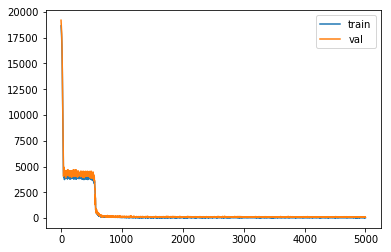

In [281]:
plt.figure()
plt.plot(losses_1, label="train")
plt.plot(vloss, label="val")
plt.legend()
plt.show()

In [98]:
x = np.zeros((len(list_times_ch_test), 54, 54))
ch = np.zeros((len(list_times_ch_test), 1))
loc = np.zeros((len(list_times_ch_test), 2))

for i in range(len(list_times_ch_test)):
        pointer = list_times_ch_test[i]
        x[i, :, :] = image_data[pointer]
        dim = x.shape[0]
        ch[i, :] = np.array(pointer[1])
        loc[i, :] = np.array(location[pointer])
x = torch.from_numpy(x).float().cuda()
x = x.view(len(list_times_ch_test), -1, 54, 54)
ch = torch.from_numpy(ch).float().cuda()
#---------FORWARD------------#
out = cnn_1.forward(x, dim, ch)
out = torch.tensor(out).float().cuda()
out = (out.data).cpu().numpy()

In [99]:
temp = {}
for i, val in enumerate(list_times_ch_test):
    try:
        temp[val[1]] += 1
    except:
        temp[val[1]] = 1
print(temp)

cnn_loc = []
com_loc = []

for i, val in enumerate(list_times_ch_test):
    if val[1] == 1:
        com_loc.append(location[val])
        cnn_loc.append(out[i])
cnn_loc = np.array(cnn_loc)
com_loc = np.array(com_loc)

print("CNN: ", np.mean(cnn_loc, axis=0), np.var(cnn_loc, axis=0))
print("COM: ", np.mean(com_loc, axis=0), np.var(com_loc, axis=0))

{95: 198, 93: 150, 57: 244, 88: 39, 17: 125, 68: 130, 81: 95, 11: 46, 1: 181, 35: 166, 26: 96, 56: 31, 98: 52, 13: 166, 60: 145, 7: 109, 65: 85, 66: 131, 51: 32, 58: 226, 41: 95, 96: 55, 84: 153, 87: 16, 37: 71, 55: 7, 28: 36, 71: 85, 2: 7, 46: 148, 33: 47, 48: 82, 89: 67, 86: 30, 61: 9, 24: 7, 18: 44, 70: 4, 100: 9, 97: 33, 3: 2, 75: 27, 12: 7, 43: 4, 59: 13, 22: 22, 72: 104, 74: 11, 76: 2, 39: 28, 83: 32, 29: 9, 54: 2, 62: 58, 67: 1, 0: 3, 8: 1, 53: 53, 94: 5, 30: 2, 99: 8, 27: 1, 45: 7, 80: 3, 69: 1, 38: 1, 6: 3, 49: 2, 42: 1, 44: 1, 5: 1, 79: 1, 50: 1}
CNN:  [ 11.420702 233.58583 ] [ 5.048944 79.75802 ]
COM:  [ 11.55166298 233.10698895] [ 3.68241608 10.81483717]


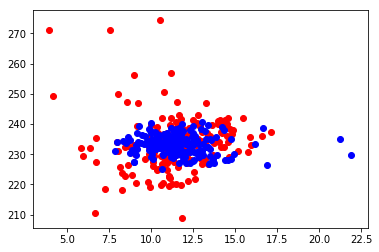

In [100]:
plt.scatter(cnn_loc[:, 0], cnn_loc[:, 1], c = 'r')
plt.scatter(com_loc[:, 0], com_loc[:, 1], c = 'b')
plt.show()

In [401]:
#torch.cuda.set_device(1)

class LocatorCNN_NC(nn.Module):
    def __init__(self, dilate=1):
        super(LocatorCNN_NC, self).__init__()
        self.conv_layer1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)
        self.conv_layer2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, dilation=dilate)

        self.conv_layer3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv_layer4 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.conv_layer6 = nn.Conv2d(128, 256, kernel_size=3, stride=1, dilation=dilate)
    
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.drop2 = nn.Dropout2d(p=0.1)
        self.drop1 = nn.Dropout(p=0.05)
        
        self.activation_layer_2d = nn.ReLU()
        self.activation_layer = nn.ELU()
        
        #self.linear_0 = nn.Linear(107648, 4096)
        self.linear_1 = nn.Linear(2304, 1024) #with maxpooling
        #self.linear_1 = nn.Linear(9750528, 2048)
        self.linear_2 = nn.Linear(1024, 512)
        self.linear_3 = nn.Linear(512, 128)
        self.linear_4 = nn.Linear(128, 32)
        self.linear_5 = nn.Linear(32, 8)
        self.linear_6 = nn.Linear(8, 2)
    
    def forward(self, x, dim, channel):

        out = self.conv_layer1(x)
        out = self.activation_layer_2d(out)
        #print(out.shape)
        out = self.conv_layer2(out)
        #print(out.shape)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        #print(out.shape)
        
        out = self.conv_layer3(out)
        out = self.activation_layer_2d(out)
        #print(out.shape)
        out = self.conv_layer4(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        #print(out.shape)
        
        out = self.conv_layer6(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        #out = self.drop2(out)
        #print(out.shape)
        
        out = out.view(dim, -1)
        #out = self.linear_0(out)
        #out = self.activation_layer(out)
        #out = self.drop1(out)
        out = self.linear_1(out)
        out = self.activation_layer(out)
        out = self.linear_2(out)
        out = self.activation_layer(out)
        out = self.drop1(out)
        out = self.linear_3(out)
        out = self.activation_layer(out)
        out = self.linear_4(out)
        out = self.activation_layer(out)
        #print(out.shape, channel.shape)
        #out = torch.cat((out, channel), dim=1)
        out = self.linear_5(out)
        out = self.activation_layer(out)
        out = self.linear_6(out)
        
        return out

In [104]:
epoch_range = 5000
batch_size = 100
learning_rate = 0.0001

cnn_1 = LocatorCNN_NC().cuda()
cnn_1.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    cnn_1.parameters(), lr=learning_rate)

out, losses_1, vloss = train_cnn(cnn_1, list_times_ch_train, list_times_ch_val ,image_data, location, criterion, optimizer, epoch_range, batch_size)

epoch [1/5000], loss:18457.89062, avg:18457.89062
epoch [2/5000], loss:18352.01758, avg:18404.95312
epoch [3/5000], loss:18272.79492, avg:18360.90234
epoch [4/5000], loss:18205.53906, avg:18322.06055
epoch [5/5000], loss:18143.05664, avg:18286.25977
epoch [6/5000], loss:18083.28125, avg:18252.42969
epoch [7/5000], loss:18026.18164, avg:18220.10938
epoch [8/5000], loss:17966.89062, avg:18188.45703
epoch [9/5000], loss:17906.45508, avg:18157.12305
epoch [10/5000], loss:17840.97656, avg:18125.50977
epoch [11/5000], loss:17769.11133, avg:18056.63086
epoch [12/5000], loss:17681.55859, avg:17989.58398
epoch [13/5000], loss:17587.30664, avg:17921.03711
epoch [14/5000], loss:17475.74805, avg:17848.05664
epoch [15/5000], loss:17357.72070, avg:17769.52344
epoch [16/5000], loss:17218.02344, avg:17682.99805
epoch [17/5000], loss:17055.79688, avg:17585.95898
epoch [18/5000], loss:16890.56641, avg:17478.32617
epoch [19/5000], loss:16695.98438, avg:17357.27930
epoch [20/5000], loss:16491.38867, avg:1

epoch [166/5000], loss:3891.30127, avg:3944.76489
epoch [167/5000], loss:3980.45947, avg:3943.81714
epoch [168/5000], loss:3924.34229, avg:3947.34033
epoch [169/5000], loss:3980.63379, avg:3951.22705
epoch [170/5000], loss:3919.90210, avg:3946.45093
epoch [171/5000], loss:3924.33936, avg:3942.20581
epoch [172/5000], loss:3995.83569, avg:3943.85596
epoch [173/5000], loss:3910.74316, avg:3939.75366
epoch [174/5000], loss:3940.49194, avg:3939.38281
epoch [175/5000], loss:3916.62744, avg:3938.46802
epoch [176/5000], loss:3925.54932, avg:3941.89307
epoch [177/5000], loss:3960.26465, avg:3939.87305
epoch [178/5000], loss:3979.02832, avg:3945.34155
epoch [179/5000], loss:3949.39258, avg:3942.21729
epoch [180/5000], loss:3978.58447, avg:3948.08594
epoch [181/5000], loss:3917.16968, avg:3947.36841
epoch [182/5000], loss:3964.85620, avg:3944.27026
epoch [183/5000], loss:3953.58447, avg:3948.55518
epoch [184/5000], loss:3929.08032, avg:3947.41406
epoch [185/5000], loss:3939.53125, avg:3949.70386


epoch [331/5000], loss:3915.27563, avg:3936.31250
epoch [332/5000], loss:3931.56567, avg:3931.89819
epoch [333/5000], loss:3863.83911, avg:3918.77612
epoch [334/5000], loss:3952.67407, avg:3922.23560
epoch [335/5000], loss:3971.26221, avg:3928.68213
epoch [336/5000], loss:3983.87793, avg:3937.47900
epoch [337/5000], loss:3927.03564, avg:3936.10327
epoch [338/5000], loss:3920.34570, avg:3940.32812
epoch [339/5000], loss:3933.15308, avg:3936.32153
epoch [340/5000], loss:3886.95386, avg:3928.59839
epoch [341/5000], loss:3898.94873, avg:3926.96558
epoch [342/5000], loss:3945.40332, avg:3928.34937
epoch [343/5000], loss:3923.51123, avg:3934.31641
epoch [344/5000], loss:3938.57104, avg:3932.90625
epoch [345/5000], loss:3958.42676, avg:3931.62280
epoch [346/5000], loss:3983.93823, avg:3931.62866
epoch [347/5000], loss:3976.23657, avg:3936.54883
epoch [348/5000], loss:3878.39819, avg:3932.35425
epoch [349/5000], loss:3937.59961, avg:3932.79858
epoch [350/5000], loss:3962.83838, avg:3940.38721


epoch [496/5000], loss:3928.10034, avg:3950.57935
epoch [497/5000], loss:3956.65088, avg:3947.18481
epoch [498/5000], loss:3895.77417, avg:3941.77026
epoch [499/5000], loss:3934.93970, avg:3941.16333
epoch [500/5000], loss:3950.62695, avg:3938.18286
epoch [501/5000], loss:3914.82617, avg:3935.13843
epoch [502/5000], loss:3889.06958, avg:3929.16260
epoch [503/5000], loss:3945.07837, avg:3927.15210
epoch [504/5000], loss:3932.97290, avg:3929.96802
epoch [505/5000], loss:3936.88184, avg:3928.49219
epoch [506/5000], loss:3988.48926, avg:3934.53101
epoch [507/5000], loss:3907.40649, avg:3929.60620
epoch [508/5000], loss:3941.13037, avg:3934.14185
epoch [509/5000], loss:4006.69165, avg:3941.31714
epoch [510/5000], loss:3946.18384, avg:3940.87305
epoch [511/5000], loss:3905.27905, avg:3939.91846
epoch [512/5000], loss:3986.94678, avg:3949.70581
epoch [513/5000], loss:4000.05542, avg:3955.20361
epoch [514/5000], loss:3945.14600, avg:3956.42114
epoch [515/5000], loss:3934.36841, avg:3956.16968


epoch [661/5000], loss:3915.26318, avg:3923.28003
epoch [662/5000], loss:3900.68042, avg:3923.15405
epoch [663/5000], loss:3926.62036, avg:3922.40942
epoch [664/5000], loss:3900.30176, avg:3917.62573
epoch [665/5000], loss:3926.85815, avg:3919.44385
epoch [666/5000], loss:3882.45386, avg:3916.51562
epoch [667/5000], loss:3899.09521, avg:3914.77197
epoch [668/5000], loss:3935.68188, avg:3914.00244
epoch [669/5000], loss:3924.42529, avg:3914.24341
epoch [670/5000], loss:3957.22241, avg:3916.86011
epoch [671/5000], loss:3893.97217, avg:3914.73120
epoch [672/5000], loss:3955.86182, avg:3920.24976
epoch [673/5000], loss:3899.62378, avg:3917.55005
epoch [674/5000], loss:3900.57886, avg:3917.57739
epoch [675/5000], loss:3949.95947, avg:3919.88745
epoch [676/5000], loss:3983.17651, avg:3929.95972
epoch [677/5000], loss:3931.94897, avg:3933.24487
epoch [678/5000], loss:3921.24634, avg:3931.80127
epoch [679/5000], loss:3917.15039, avg:3931.07422
epoch [680/5000], loss:3922.94434, avg:3927.64624


epoch [826/5000], loss:3903.07959, avg:3926.77075
epoch [827/5000], loss:3934.69995, avg:3923.65674
epoch [828/5000], loss:3946.78247, avg:3930.00073
epoch [829/5000], loss:3930.55908, avg:3932.48364
epoch [830/5000], loss:3926.05542, avg:3932.14575
epoch [831/5000], loss:3900.44946, avg:3927.24292
epoch [832/5000], loss:3930.01367, avg:3933.94531
epoch [833/5000], loss:3925.46460, avg:3929.89331
epoch [834/5000], loss:3942.72510, avg:3930.12354
epoch [835/5000], loss:3927.98022, avg:3926.78101
epoch [836/5000], loss:3920.69556, avg:3928.54272
epoch [837/5000], loss:3929.57886, avg:3928.03052
epoch [838/5000], loss:3957.00977, avg:3929.05322
epoch [839/5000], loss:3933.90649, avg:3929.38794
epoch [840/5000], loss:3953.59033, avg:3932.14136
epoch [841/5000], loss:3930.53931, avg:3935.15039
epoch [842/5000], loss:3940.79468, avg:3936.22827
epoch [843/5000], loss:3986.82397, avg:3942.36401
epoch [844/5000], loss:3946.70850, avg:3942.76245
epoch [845/5000], loss:3938.34180, avg:3943.79932


epoch [991/5000], loss:3945.08228, avg:3939.93091
epoch [992/5000], loss:3945.37207, avg:3943.73047
epoch [993/5000], loss:3919.33521, avg:3938.66260
epoch [994/5000], loss:3931.68457, avg:3937.90503
epoch [995/5000], loss:3925.29980, avg:3936.35083
epoch [996/5000], loss:3944.53784, avg:3936.38916
epoch [997/5000], loss:3959.15747, avg:3939.57935
epoch [998/5000], loss:3904.18335, avg:3935.20679
epoch [999/5000], loss:3935.03760, avg:3934.25000
epoch [1000/5000], loss:3932.88135, avg:3934.25757
epoch [1001/5000], loss:3964.00659, avg:3936.14966
epoch [1002/5000], loss:3912.58716, avg:3932.87109
epoch [1003/5000], loss:3925.92627, avg:3933.53003
epoch [1004/5000], loss:3939.93188, avg:3934.35522
epoch [1005/5000], loss:3945.23779, avg:3936.34888
epoch [1006/5000], loss:3952.84229, avg:3937.17944
epoch [1007/5000], loss:3927.94531, avg:3934.05786
epoch [1008/5000], loss:3954.81909, avg:3939.12183
epoch [1009/5000], loss:4001.69751, avg:3945.78760
epoch [1010/5000], loss:3921.05933, avg:

epoch [1153/5000], loss:3940.49121, avg:3923.96021
epoch [1154/5000], loss:3926.64258, avg:3922.31714
epoch [1155/5000], loss:3967.65820, avg:3932.00781
epoch [1156/5000], loss:3942.76562, avg:3932.69409
epoch [1157/5000], loss:3952.02563, avg:3933.11182
epoch [1158/5000], loss:3931.11426, avg:3928.77661
epoch [1159/5000], loss:3927.60840, avg:3934.71069
epoch [1160/5000], loss:3926.17163, avg:3934.14429
epoch [1161/5000], loss:3941.38745, avg:3934.99927
epoch [1162/5000], loss:3944.57788, avg:3940.04468
epoch [1163/5000], loss:3985.94507, avg:3944.58984
epoch [1164/5000], loss:3906.77686, avg:3942.60327
epoch [1165/5000], loss:3907.99243, avg:3936.63647
epoch [1166/5000], loss:3963.51660, avg:3938.71167
epoch [1167/5000], loss:3914.80884, avg:3934.98999
epoch [1168/5000], loss:3955.30542, avg:3937.40894
epoch [1169/5000], loss:3901.78882, avg:3934.82690
epoch [1170/5000], loss:3967.20532, avg:3938.93042
epoch [1171/5000], loss:3939.76807, avg:3938.76880
epoch [1172/5000], loss:3959.67

epoch [1315/5000], loss:3948.77002, avg:3929.85278
epoch [1316/5000], loss:3925.31616, avg:3928.71729
epoch [1317/5000], loss:3893.61035, avg:3923.00366
epoch [1318/5000], loss:3938.76489, avg:3924.04956
epoch [1319/5000], loss:3910.99316, avg:3920.75977
epoch [1320/5000], loss:3947.71875, avg:3922.10010
epoch [1321/5000], loss:3939.35815, avg:3923.18018
epoch [1322/5000], loss:3922.94971, avg:3922.38745
epoch [1323/5000], loss:3936.58301, avg:3927.48901
epoch [1324/5000], loss:3878.25073, avg:3924.23120
epoch [1325/5000], loss:3969.41943, avg:3926.29614
epoch [1326/5000], loss:3954.97437, avg:3929.26172
epoch [1327/5000], loss:3909.73242, avg:3930.87427
epoch [1328/5000], loss:3925.43262, avg:3929.54102
epoch [1329/5000], loss:3923.44092, avg:3930.78638
epoch [1330/5000], loss:3946.02881, avg:3930.61694
epoch [1331/5000], loss:3924.32324, avg:3929.11377
epoch [1332/5000], loss:3879.38745, avg:3924.75757
epoch [1333/5000], loss:3898.66187, avg:3920.96484
epoch [1334/5000], loss:3967.86

epoch [1477/5000], loss:3363.98975, avg:3647.54028
epoch [1478/5000], loss:3256.71777, avg:3594.64233
epoch [1479/5000], loss:3069.05542, avg:3520.58057
epoch [1480/5000], loss:2862.13989, avg:3427.91919
epoch [1481/5000], loss:2747.15649, avg:3329.83643
epoch [1482/5000], loss:2511.36572, avg:3211.63306
epoch [1483/5000], loss:2344.65381, avg:3077.06836
epoch [1484/5000], loss:2152.76758, avg:2932.56714
epoch [1485/5000], loss:1847.95190, avg:2754.20679
epoch [1486/5000], loss:1544.49951, avg:2570.02979
epoch [1487/5000], loss:1667.27197, avg:2400.35815
epoch [1488/5000], loss:1148.68152, avg:2189.55444
epoch [1489/5000], loss:1237.94031, avg:2006.44275
epoch [1490/5000], loss:954.61664, avg:1815.69043
epoch [1491/5000], loss:784.16571, avg:1619.39148
epoch [1492/5000], loss:675.73444, avg:1435.82837
epoch [1493/5000], loss:700.94775, avg:1271.45764
epoch [1494/5000], loss:619.57391, avg:1118.13855
epoch [1495/5000], loss:565.22540, avg:989.86572
epoch [1496/5000], loss:533.45782, avg

epoch [1648/5000], loss:44.69436, avg:47.76392
epoch [1649/5000], loss:45.72587, avg:47.63146
epoch [1650/5000], loss:43.26114, avg:46.54526
epoch [1651/5000], loss:41.72691, avg:46.16174
epoch [1652/5000], loss:41.07339, avg:45.16575
epoch [1653/5000], loss:48.53125, avg:45.43321
epoch [1654/5000], loss:42.85696, avg:45.25234
epoch [1655/5000], loss:44.16428, avg:44.84606
epoch [1656/5000], loss:45.74801, avg:44.45921
epoch [1657/5000], loss:34.06991, avg:43.18521
epoch [1658/5000], loss:40.00274, avg:42.71605
epoch [1659/5000], loss:37.51904, avg:41.89537
epoch [1660/5000], loss:38.39087, avg:41.40834
epoch [1661/5000], loss:49.87684, avg:42.22333
epoch [1662/5000], loss:44.12664, avg:42.52866
epoch [1663/5000], loss:46.10426, avg:42.28595
epoch [1664/5000], loss:37.00211, avg:41.70047
epoch [1665/5000], loss:44.24424, avg:41.70847
epoch [1666/5000], loss:45.01746, avg:41.63541
epoch [1667/5000], loss:36.58818, avg:41.88724
epoch [1668/5000], loss:43.48434, avg:42.23540
epoch [1669/5

epoch [1825/5000], loss:31.92591, avg:29.49943
epoch [1826/5000], loss:34.91511, avg:30.32217
epoch [1827/5000], loss:32.85763, avg:29.93644
epoch [1828/5000], loss:27.23025, avg:29.83773
epoch [1829/5000], loss:30.15001, avg:29.92491
epoch [1830/5000], loss:28.99670, avg:30.05852
epoch [1831/5000], loss:28.44774, avg:29.98098
epoch [1832/5000], loss:29.14534, avg:30.11709
epoch [1833/5000], loss:35.46772, avg:30.96292
epoch [1834/5000], loss:25.73988, avg:30.48763
epoch [1835/5000], loss:24.84878, avg:29.77992
epoch [1836/5000], loss:26.80906, avg:28.96931
epoch [1837/5000], loss:29.29568, avg:28.61312
epoch [1838/5000], loss:31.29885, avg:29.01998
epoch [1839/5000], loss:34.54393, avg:29.45937
epoch [1840/5000], loss:28.58572, avg:29.41827
epoch [1841/5000], loss:29.58335, avg:29.53183
epoch [1842/5000], loss:31.71850, avg:29.78915
epoch [1843/5000], loss:25.67062, avg:28.80944
epoch [1844/5000], loss:26.79982, avg:28.91543
epoch [1845/5000], loss:30.03837, avg:29.43439
epoch [1846/5

epoch [2002/5000], loss:23.34777, avg:23.09498
epoch [2003/5000], loss:26.42470, avg:23.74984
epoch [2004/5000], loss:23.26945, avg:23.56708
epoch [2005/5000], loss:26.32954, avg:23.40644
epoch [2006/5000], loss:24.11129, avg:23.66639
epoch [2007/5000], loss:23.15483, avg:23.63416
epoch [2008/5000], loss:23.02683, avg:23.44449
epoch [2009/5000], loss:26.93723, avg:24.03838
epoch [2010/5000], loss:24.97357, avg:24.19623
epoch [2011/5000], loss:21.99806, avg:24.35733
epoch [2012/5000], loss:23.59304, avg:24.38186
epoch [2013/5000], loss:22.15384, avg:23.95477
epoch [2014/5000], loss:22.46961, avg:23.87479
epoch [2015/5000], loss:20.55434, avg:23.29726
epoch [2016/5000], loss:21.73218, avg:23.05935
epoch [2017/5000], loss:22.56045, avg:22.99992
epoch [2018/5000], loss:23.65645, avg:23.06288
epoch [2019/5000], loss:25.27741, avg:22.89689
epoch [2020/5000], loss:24.53200, avg:22.85274
epoch [2021/5000], loss:21.92790, avg:22.84572
epoch [2022/5000], loss:18.62799, avg:22.34922
epoch [2023/5

epoch [2179/5000], loss:17.64234, avg:17.79435
epoch [2180/5000], loss:18.14087, avg:17.69726
epoch [2181/5000], loss:16.90859, avg:17.32528
epoch [2182/5000], loss:17.03266, avg:17.61722
epoch [2183/5000], loss:18.33693, avg:17.78413
epoch [2184/5000], loss:17.50492, avg:17.84525
epoch [2185/5000], loss:13.78289, avg:17.33223
epoch [2186/5000], loss:16.58662, avg:17.35597
epoch [2187/5000], loss:22.31959, avg:17.73352
epoch [2188/5000], loss:18.69527, avg:17.69507
epoch [2189/5000], loss:13.47972, avg:17.27881
epoch [2190/5000], loss:16.97584, avg:17.16230
epoch [2191/5000], loss:17.57775, avg:17.22922
epoch [2192/5000], loss:16.64898, avg:17.19085
epoch [2193/5000], loss:17.38357, avg:17.09552
epoch [2194/5000], loss:17.57537, avg:17.10256
epoch [2195/5000], loss:12.97139, avg:17.02141
epoch [2196/5000], loss:19.91849, avg:17.35460
epoch [2197/5000], loss:16.11344, avg:16.73398
epoch [2198/5000], loss:14.64909, avg:16.32936
epoch [2199/5000], loss:14.61557, avg:16.44295
epoch [2200/5

epoch [2356/5000], loss:12.70057, avg:13.88916
epoch [2357/5000], loss:13.78828, avg:13.52363
epoch [2358/5000], loss:14.25779, avg:13.28650
epoch [2359/5000], loss:10.32613, avg:12.98607
epoch [2360/5000], loss:11.73052, avg:13.08791
epoch [2361/5000], loss:14.64465, avg:13.16955
epoch [2362/5000], loss:11.28059, avg:13.01310
epoch [2363/5000], loss:13.79714, avg:12.92069
epoch [2364/5000], loss:11.47638, avg:12.88929
epoch [2365/5000], loss:12.73256, avg:12.67346
epoch [2366/5000], loss:12.23128, avg:12.62653
epoch [2367/5000], loss:16.11798, avg:12.85950
epoch [2368/5000], loss:14.59127, avg:12.89285
epoch [2369/5000], loss:13.01328, avg:13.16157
epoch [2370/5000], loss:12.39515, avg:13.22803
epoch [2371/5000], loss:11.85892, avg:12.94946
epoch [2372/5000], loss:11.18372, avg:12.93977
epoch [2373/5000], loss:15.60472, avg:13.12053
epoch [2374/5000], loss:12.53199, avg:13.22609
epoch [2375/5000], loss:10.72444, avg:13.02528
epoch [2376/5000], loss:12.60610, avg:13.06276
epoch [2377/5

epoch [2533/5000], loss:11.20755, avg:11.02759
epoch [2534/5000], loss:11.05400, avg:11.03173
epoch [2535/5000], loss:10.26831, avg:10.81336
epoch [2536/5000], loss:11.02137, avg:11.00792
epoch [2537/5000], loss:9.88443, avg:10.53169
epoch [2538/5000], loss:13.25408, avg:10.90353
epoch [2539/5000], loss:10.84529, avg:11.07638
epoch [2540/5000], loss:10.91689, avg:11.20461
epoch [2541/5000], loss:8.27961, avg:10.76430
epoch [2542/5000], loss:9.33071, avg:10.60623
epoch [2543/5000], loss:11.69352, avg:10.65482
epoch [2544/5000], loss:11.34449, avg:10.68387
epoch [2545/5000], loss:8.91908, avg:10.54895
epoch [2546/5000], loss:11.92639, avg:10.63945
epoch [2547/5000], loss:13.02063, avg:10.95307
epoch [2548/5000], loss:10.46954, avg:10.67462
epoch [2549/5000], loss:9.51714, avg:10.54180
epoch [2550/5000], loss:10.44702, avg:10.49481
epoch [2551/5000], loss:9.94274, avg:10.66113
epoch [2552/5000], loss:8.02838, avg:10.53089
epoch [2553/5000], loss:11.17227, avg:10.47877
epoch [2554/5000], l

epoch [2710/5000], loss:7.52799, avg:9.22770
epoch [2711/5000], loss:10.33521, avg:9.24469
epoch [2712/5000], loss:11.43401, avg:9.53153
epoch [2713/5000], loss:8.83885, avg:9.45229
epoch [2714/5000], loss:8.77908, avg:9.20655
epoch [2715/5000], loss:8.62124, avg:9.24693
epoch [2716/5000], loss:9.20867, avg:9.34647
epoch [2717/5000], loss:12.17782, avg:9.43236
epoch [2718/5000], loss:10.18447, avg:9.54328
epoch [2719/5000], loss:10.24365, avg:9.73510
epoch [2720/5000], loss:11.15090, avg:10.09739
epoch [2721/5000], loss:10.21351, avg:10.08522
epoch [2722/5000], loss:12.19382, avg:10.16120
epoch [2723/5000], loss:10.15012, avg:10.29233
epoch [2724/5000], loss:11.37204, avg:10.55162
epoch [2725/5000], loss:10.13453, avg:10.70295
epoch [2726/5000], loss:10.76485, avg:10.85857
epoch [2727/5000], loss:9.15314, avg:10.55610
epoch [2728/5000], loss:9.43736, avg:10.48139
epoch [2729/5000], loss:8.71569, avg:10.32860
epoch [2730/5000], loss:9.17352, avg:10.13086
epoch [2731/5000], loss:10.32121

epoch [2893/5000], loss:7.72394, avg:8.92009
epoch [2894/5000], loss:9.18390, avg:8.87739
epoch [2895/5000], loss:7.80716, avg:8.81336
epoch [2896/5000], loss:7.81516, avg:8.60417
epoch [2897/5000], loss:8.14186, avg:8.37378
epoch [2898/5000], loss:9.35604, avg:8.53000
epoch [2899/5000], loss:9.80257, avg:8.38477
epoch [2900/5000], loss:9.70447, avg:8.54232
epoch [2901/5000], loss:8.20504, avg:8.51866
epoch [2902/5000], loss:9.63535, avg:8.73755
epoch [2903/5000], loss:6.94687, avg:8.65984
epoch [2904/5000], loss:7.88142, avg:8.52960
epoch [2905/5000], loss:8.27227, avg:8.57611
epoch [2906/5000], loss:8.70389, avg:8.66498
epoch [2907/5000], loss:8.96202, avg:8.74699
epoch [2908/5000], loss:7.85893, avg:8.59728
epoch [2909/5000], loss:9.68513, avg:8.58554
epoch [2910/5000], loss:12.07245, avg:8.82234
epoch [2911/5000], loss:7.48524, avg:8.75036
epoch [2912/5000], loss:7.27666, avg:8.51449
epoch [2913/5000], loss:8.00837, avg:8.62064
epoch [2914/5000], loss:8.76120, avg:8.70862
epoch [29

epoch [3076/5000], loss:10.98777, avg:8.66247
epoch [3077/5000], loss:8.09833, avg:8.84229
epoch [3078/5000], loss:8.42812, avg:8.74640
epoch [3079/5000], loss:7.53717, avg:8.72114
epoch [3080/5000], loss:7.96369, avg:8.43021
epoch [3081/5000], loss:5.75868, avg:8.20910
epoch [3082/5000], loss:7.08525, avg:7.85080
epoch [3083/5000], loss:7.53639, avg:7.90382
epoch [3084/5000], loss:8.32740, avg:7.82293
epoch [3085/5000], loss:6.39302, avg:7.81158
epoch [3086/5000], loss:8.22906, avg:7.53571
epoch [3087/5000], loss:8.19476, avg:7.54535
epoch [3088/5000], loss:7.75601, avg:7.47814
epoch [3089/5000], loss:7.65020, avg:7.48945
epoch [3090/5000], loss:7.07601, avg:7.40068
epoch [3091/5000], loss:7.49200, avg:7.57401
epoch [3092/5000], loss:9.01735, avg:7.76722
epoch [3093/5000], loss:9.51892, avg:7.96547
epoch [3094/5000], loss:8.50400, avg:7.98313
epoch [3095/5000], loss:8.44170, avg:8.18800
epoch [3096/5000], loss:6.27138, avg:7.99223
epoch [3097/5000], loss:8.08064, avg:7.98082
epoch [30

epoch [3259/5000], loss:7.70131, avg:7.94032
epoch [3260/5000], loss:7.56461, avg:7.72574
epoch [3261/5000], loss:7.43643, avg:7.84924
epoch [3262/5000], loss:9.42387, avg:7.93236
epoch [3263/5000], loss:7.80004, avg:7.94892
epoch [3264/5000], loss:7.67800, avg:7.98666
epoch [3265/5000], loss:7.04782, avg:7.94431
epoch [3266/5000], loss:7.25342, avg:7.73062
epoch [3267/5000], loss:5.88049, avg:7.47953
epoch [3268/5000], loss:6.86815, avg:7.46541
epoch [3269/5000], loss:7.52272, avg:7.44755
epoch [3270/5000], loss:6.67148, avg:7.35824
epoch [3271/5000], loss:7.18575, avg:7.33317
epoch [3272/5000], loss:6.82567, avg:7.07335
epoch [3273/5000], loss:10.17988, avg:7.31134
epoch [3274/5000], loss:5.94719, avg:7.13826
epoch [3275/5000], loss:8.76102, avg:7.30958
epoch [3276/5000], loss:7.44487, avg:7.32872
epoch [3277/5000], loss:8.63346, avg:7.60402
epoch [3278/5000], loss:8.81565, avg:7.79877
epoch [3279/5000], loss:9.65304, avg:8.01180
epoch [3280/5000], loss:7.49918, avg:8.09457
epoch [32

epoch [3442/5000], loss:7.10867, avg:7.34515
epoch [3443/5000], loss:6.60403, avg:7.32388
epoch [3444/5000], loss:8.68390, avg:7.45676
epoch [3445/5000], loss:7.08372, avg:7.54335
epoch [3446/5000], loss:5.60998, avg:7.46878
epoch [3447/5000], loss:7.63314, avg:7.50198
epoch [3448/5000], loss:6.95364, avg:7.35810
epoch [3449/5000], loss:6.42073, avg:7.21314
epoch [3450/5000], loss:7.98078, avg:7.15345
epoch [3451/5000], loss:6.32609, avg:7.04047
epoch [3452/5000], loss:7.04818, avg:7.03442
epoch [3453/5000], loss:5.65679, avg:6.93969
epoch [3454/5000], loss:7.44999, avg:6.81630
epoch [3455/5000], loss:6.59889, avg:6.76782
epoch [3456/5000], loss:7.93108, avg:6.99993
epoch [3457/5000], loss:6.78689, avg:6.91531
epoch [3458/5000], loss:6.40500, avg:6.86044
epoch [3459/5000], loss:5.49662, avg:6.76803
epoch [3460/5000], loss:9.24571, avg:6.89452
epoch [3461/5000], loss:7.87502, avg:7.04942
epoch [3462/5000], loss:7.63507, avg:7.10811
epoch [3463/5000], loss:6.04016, avg:7.14644
epoch [346

epoch [3625/5000], loss:5.61753, avg:6.61644
epoch [3626/5000], loss:7.24336, avg:6.69546
epoch [3627/5000], loss:5.89099, avg:6.63220
epoch [3628/5000], loss:6.51220, avg:6.52335
epoch [3629/5000], loss:5.27068, avg:6.46976
epoch [3630/5000], loss:6.01030, avg:6.33099
epoch [3631/5000], loss:7.04826, avg:6.43778
epoch [3632/5000], loss:5.53155, avg:6.26704
epoch [3633/5000], loss:7.24902, avg:6.28101
epoch [3634/5000], loss:7.76675, avg:6.41406
epoch [3635/5000], loss:6.62355, avg:6.51467
epoch [3636/5000], loss:6.80365, avg:6.47070
epoch [3637/5000], loss:5.98070, avg:6.47967
epoch [3638/5000], loss:5.17560, avg:6.34601
epoch [3639/5000], loss:7.68415, avg:6.58736
epoch [3640/5000], loss:7.49062, avg:6.73539
epoch [3641/5000], loss:6.52654, avg:6.68321
epoch [3642/5000], loss:7.24592, avg:6.85465
epoch [3643/5000], loss:7.38809, avg:6.86856
epoch [3644/5000], loss:6.76866, avg:6.76875
epoch [3645/5000], loss:7.21472, avg:6.82786
epoch [3646/5000], loss:7.70753, avg:6.91825
epoch [364

epoch [3808/5000], loss:6.37787, avg:6.10828
epoch [3809/5000], loss:6.26705, avg:6.11301
epoch [3810/5000], loss:7.73462, avg:6.14277
epoch [3811/5000], loss:6.12333, avg:6.21254
epoch [3812/5000], loss:6.14625, avg:6.20184
epoch [3813/5000], loss:6.26098, avg:6.21145
epoch [3814/5000], loss:6.86925, avg:6.31387
epoch [3815/5000], loss:5.99868, avg:6.38060
epoch [3816/5000], loss:6.42929, avg:6.41936
epoch [3817/5000], loss:6.34048, avg:6.45478
epoch [3818/5000], loss:4.85769, avg:6.30276
epoch [3819/5000], loss:6.41915, avg:6.31797
epoch [3820/5000], loss:6.82562, avg:6.22707
epoch [3821/5000], loss:8.57859, avg:6.47260
epoch [3822/5000], loss:6.60725, avg:6.51870
epoch [3823/5000], loss:6.07361, avg:6.49996
epoch [3824/5000], loss:5.52724, avg:6.36576
epoch [3825/5000], loss:6.59998, avg:6.42589
epoch [3826/5000], loss:5.91483, avg:6.37444
epoch [3827/5000], loss:5.56210, avg:6.29661
epoch [3828/5000], loss:5.69074, avg:6.37991
epoch [3829/5000], loss:5.81152, avg:6.31915
epoch [383

epoch [3991/5000], loss:8.63484, avg:7.12854
epoch [3992/5000], loss:5.91403, avg:7.15248
epoch [3993/5000], loss:7.91657, avg:7.18957
epoch [3994/5000], loss:6.62007, avg:7.36254
epoch [3995/5000], loss:8.34029, avg:7.46753
epoch [3996/5000], loss:6.85504, avg:7.49892
epoch [3997/5000], loss:5.35677, avg:7.13087
epoch [3998/5000], loss:8.05730, avg:7.15736
epoch [3999/5000], loss:6.44367, avg:7.13609
epoch [4000/5000], loss:6.97470, avg:7.11133
epoch [4001/5000], loss:6.52682, avg:6.90053
epoch [4002/5000], loss:5.91660, avg:6.90078
epoch [4003/5000], loss:6.95568, avg:6.80469
epoch [4004/5000], loss:5.76403, avg:6.71909
epoch [4005/5000], loss:5.95777, avg:6.48084
epoch [4006/5000], loss:6.17856, avg:6.41319
epoch [4007/5000], loss:5.84756, avg:6.46227
epoch [4008/5000], loss:6.94818, avg:6.35136
epoch [4009/5000], loss:4.49643, avg:6.15663
epoch [4010/5000], loss:6.09623, avg:6.06879
epoch [4011/5000], loss:5.28358, avg:5.94446
epoch [4012/5000], loss:5.65905, avg:5.91871
epoch [401

epoch [4174/5000], loss:5.74120, avg:6.33523
epoch [4175/5000], loss:4.32987, avg:6.13439
epoch [4176/5000], loss:5.84119, avg:6.05274
epoch [4177/5000], loss:8.34977, avg:6.31967
epoch [4178/5000], loss:7.29882, avg:6.33644
epoch [4179/5000], loss:6.14400, avg:6.38998
epoch [4180/5000], loss:6.15618, avg:6.30543
epoch [4181/5000], loss:7.53769, avg:6.50607
epoch [4182/5000], loss:8.29642, avg:6.66737
epoch [4183/5000], loss:7.19400, avg:6.68891
epoch [4184/5000], loss:8.12430, avg:6.92722
epoch [4185/5000], loss:8.51844, avg:7.34608
epoch [4186/5000], loss:6.24962, avg:7.38692
epoch [4187/5000], loss:5.97627, avg:7.14957
epoch [4188/5000], loss:6.93541, avg:7.11323
epoch [4189/5000], loss:5.16138, avg:7.01497
epoch [4190/5000], loss:5.89997, avg:6.98935
epoch [4191/5000], loss:5.79441, avg:6.81502
epoch [4192/5000], loss:6.19172, avg:6.60455
epoch [4193/5000], loss:7.46886, avg:6.63204
epoch [4194/5000], loss:6.97520, avg:6.51713
epoch [4195/5000], loss:6.88825, avg:6.35411
epoch [419

epoch [4357/5000], loss:6.03749, avg:6.08089
epoch [4358/5000], loss:6.09096, avg:6.11222
epoch [4359/5000], loss:5.68531, avg:5.97877
epoch [4360/5000], loss:4.43340, avg:5.94309
epoch [4361/5000], loss:7.73394, avg:5.98975
epoch [4362/5000], loss:5.09776, avg:5.99360
epoch [4363/5000], loss:5.93886, avg:5.88785
epoch [4364/5000], loss:4.54796, avg:5.69711
epoch [4365/5000], loss:4.12717, avg:5.40186
epoch [4366/5000], loss:5.93926, avg:5.56321
epoch [4367/5000], loss:4.73580, avg:5.43304
epoch [4368/5000], loss:6.09084, avg:5.43303
epoch [4369/5000], loss:3.92411, avg:5.25691
epoch [4370/5000], loss:5.08718, avg:5.32229
epoch [4371/5000], loss:4.37957, avg:4.98685
epoch [4372/5000], loss:7.14594, avg:5.19167
epoch [4373/5000], loss:4.41617, avg:5.03940
epoch [4374/5000], loss:6.57646, avg:5.24225
epoch [4375/5000], loss:5.51859, avg:5.38139
epoch [4376/5000], loss:5.72561, avg:5.36003
epoch [4377/5000], loss:8.16380, avg:5.70283
epoch [4378/5000], loss:6.66980, avg:5.76072
epoch [437

epoch [4540/5000], loss:5.46240, avg:5.74693
epoch [4541/5000], loss:6.20721, avg:5.79443
epoch [4542/5000], loss:4.66536, avg:5.70613
epoch [4543/5000], loss:5.16580, avg:5.68232
epoch [4544/5000], loss:5.89138, avg:5.86373
epoch [4545/5000], loss:5.48871, avg:5.77821
epoch [4546/5000], loss:7.36009, avg:5.91277
epoch [4547/5000], loss:5.42114, avg:5.88235
epoch [4548/5000], loss:7.01609, avg:5.81786
epoch [4549/5000], loss:5.96914, avg:5.86473
epoch [4550/5000], loss:4.88632, avg:5.80712
epoch [4551/5000], loss:6.63683, avg:5.85009
epoch [4552/5000], loss:4.17091, avg:5.80064
epoch [4553/5000], loss:5.57382, avg:5.84144
epoch [4554/5000], loss:5.80199, avg:5.83250
epoch [4555/5000], loss:4.23601, avg:5.70723
epoch [4556/5000], loss:5.76050, avg:5.54727
epoch [4557/5000], loss:4.79793, avg:5.48495
epoch [4558/5000], loss:5.72550, avg:5.35589
epoch [4559/5000], loss:4.73450, avg:5.23243
epoch [4560/5000], loss:6.88837, avg:5.43263
epoch [4561/5000], loss:6.72198, avg:5.44115
epoch [456

epoch [4723/5000], loss:4.80835, avg:5.50514
epoch [4724/5000], loss:4.20215, avg:5.46820
epoch [4725/5000], loss:5.44275, avg:5.41628
epoch [4726/5000], loss:4.90506, avg:5.38890
epoch [4727/5000], loss:6.31684, avg:5.50351
epoch [4728/5000], loss:4.16723, avg:5.34234
epoch [4729/5000], loss:5.05724, avg:5.36254
epoch [4730/5000], loss:6.00701, avg:5.40274
epoch [4731/5000], loss:5.85800, avg:5.16075
epoch [4732/5000], loss:5.58537, avg:5.23500
epoch [4733/5000], loss:5.92541, avg:5.34670
epoch [4734/5000], loss:3.59123, avg:5.28561
epoch [4735/5000], loss:6.55994, avg:5.39733
epoch [4736/5000], loss:5.71291, avg:5.47812
epoch [4737/5000], loss:5.11183, avg:5.35762
epoch [4738/5000], loss:3.83661, avg:5.32455
epoch [4739/5000], loss:6.48156, avg:5.46699
epoch [4740/5000], loss:5.26381, avg:5.39267
epoch [4741/5000], loss:5.68965, avg:5.37583
epoch [4742/5000], loss:5.56609, avg:5.37390
epoch [4743/5000], loss:4.32594, avg:5.21396
epoch [4744/5000], loss:5.36232, avg:5.39107
epoch [474

epoch [4906/5000], loss:5.73526, avg:5.08893
epoch [4907/5000], loss:4.17086, avg:4.94440
epoch [4908/5000], loss:6.97799, avg:5.24040
epoch [4909/5000], loss:4.16033, avg:5.06268
epoch [4910/5000], loss:5.92110, avg:5.23619
epoch [4911/5000], loss:4.65237, avg:5.20363
epoch [4912/5000], loss:4.12402, avg:4.98355
epoch [4913/5000], loss:6.09956, avg:5.11086
epoch [4914/5000], loss:3.81213, avg:5.03640
epoch [4915/5000], loss:4.64132, avg:5.02950
epoch [4916/5000], loss:5.17916, avg:4.97388
epoch [4917/5000], loss:4.03721, avg:4.96052
epoch [4918/5000], loss:6.33216, avg:4.89594
epoch [4919/5000], loss:6.27016, avg:5.10692
epoch [4920/5000], loss:4.43696, avg:4.95851
epoch [4921/5000], loss:4.70178, avg:4.96345
epoch [4922/5000], loss:5.36278, avg:5.08732
epoch [4923/5000], loss:3.40687, avg:4.81805
epoch [4924/5000], loss:4.57814, avg:4.89465
epoch [4925/5000], loss:5.80596, avg:5.01112
epoch [4926/5000], loss:5.27610, avg:5.02081
epoch [4927/5000], loss:6.06706, avg:5.22380
epoch [492

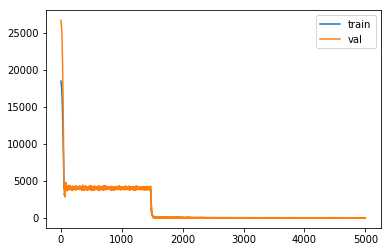

{95: 198, 93: 150, 57: 244, 88: 39, 17: 125, 68: 130, 81: 95, 11: 46, 1: 181, 35: 166, 26: 96, 56: 31, 98: 52, 13: 166, 60: 145, 7: 109, 65: 85, 66: 131, 51: 32, 58: 226, 41: 95, 96: 55, 84: 153, 87: 16, 37: 71, 55: 7, 28: 36, 71: 85, 2: 7, 46: 148, 33: 47, 48: 82, 89: 67, 86: 30, 61: 9, 24: 7, 18: 44, 70: 4, 100: 9, 97: 33, 3: 2, 75: 27, 12: 7, 43: 4, 59: 13, 22: 22, 72: 104, 74: 11, 76: 2, 39: 28, 83: 32, 29: 9, 54: 2, 62: 58, 67: 1, 0: 3, 8: 1, 53: 53, 94: 5, 30: 2, 99: 8, 27: 1, 45: 7, 80: 3, 69: 1, 38: 1, 6: 3, 49: 2, 42: 1, 44: 1, 5: 1, 79: 1, 50: 1}
CNN:  [ 11.488699 230.11443 ] [  3.0693686 113.04349  ]
COM:  [ 11.55166298 233.10698895] [ 3.68241608 10.81483717]


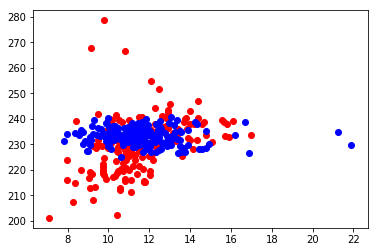

In [105]:
plt.figure()
plt.plot(losses_1, label="train")
plt.plot(vloss, label="val")
plt.legend()
plt.show()

x = np.zeros((len(list_times_ch_test), 54, 54))
ch = np.zeros((len(list_times_ch_test), 1))
loc = np.zeros((len(list_times_ch_test), 2))

for i in range(len(list_times_ch_test)):
        pointer = list_times_ch_test[i]
        x[i, :, :] = image_data[pointer]
        dim = x.shape[0]
        ch[i, :] = np.array(pointer[1])
        loc[i, :] = np.array(location[pointer])
x = torch.from_numpy(x).float().cuda()
x = x.view(len(list_times_ch_test), -1, 54, 54)
ch = torch.from_numpy(ch).float().cuda()
#---------FORWARD------------#
out = cnn_1.forward(x, dim, ch)
out = torch.tensor(out).float().cuda()
out = (out.data).cpu().numpy()

temp = {}
for i, val in enumerate(list_times_ch_test):
    try:
        temp[val[1]] += 1
    except:
        temp[val[1]] = 1
print(temp)

cnn_loc = []
com_loc = []

for i, val in enumerate(list_times_ch_test):
    if val[1] == 1:
        com_loc.append(location[val])
        cnn_loc.append(out[i])
cnn_loc = np.array(cnn_loc)
com_loc = np.array(com_loc)

print("CNN: ", np.mean(cnn_loc, axis=0), np.var(cnn_loc, axis=0))
print("COM: ", np.mean(com_loc, axis=0), np.var(com_loc, axis=0))

plt.scatter(cnn_loc[:, 0], cnn_loc[:, 1], c = 'r')
plt.scatter(com_loc[:, 0], com_loc[:, 1], c = 'b')
plt.show()

# New Model - Branched Convolutional Network

In [396]:
#torch.cuda.set_device(0)

class LocatorCNN_XY(nn.Module):
    def __init__(self, dilate=1):
        super(LocatorCNN_XY, self).__init__()
        self.conv_layer1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)
        self.conv_layer2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, dilation=dilate)

        self.conv_layer3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv_layer4 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.conv_layer6 = nn.Conv2d(128, 256, kernel_size=3, stride=1, dilation=dilate)
    
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.drop2 = nn.Dropout2d(p=0.1)
        self.drop1 = nn.Dropout(p=0.05)
        
        self.activation_layer_2d = nn.Tanh()
        self.activation_layer = nn.ELU()
                
        self.linear_1 = nn.Linear(2304, 1024) #Without dilation
        
        self.linear_2_x = nn.Linear(1024, 512)
        self.linear_3_x = nn.Linear(512, 128)
        self.linear_4_x = nn.Linear(128, 32)
        self.linear_5_x = nn.Linear(33, 8)
        self.linear_6_x = nn.Linear(8, 1)
        
        self.linear_2_y = nn.Linear(1024, 512)
        self.linear_3_y = nn.Linear(512, 128)
        self.linear_4_y = nn.Linear(128, 32)
        self.linear_5_y = nn.Linear(33, 8)
        self.linear_6_y = nn.Linear(8, 1)
    
    def forward(self, x, dim, channel):

        out = self.conv_layer1(x)
        out = self.activation_layer_2d(out)
        #print(out.shape)
        out = self.conv_layer2(out)
        #print(out.shape)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        #print(out.shape)
        
        out = self.conv_layer3(out)
        out = self.activation_layer_2d(out)
        #print(out.shape)
        out = self.conv_layer4(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        #print(out.shape)
        
        out = self.conv_layer6(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        #out = self.drop2(out)
        #print(out.shape)
        
        out = out.view(dim, -1)
        
        out = self.linear_1(out)
        out = self.activation_layer(out)
        
        out_x = self.linear_2_x(out)
        out_x = self.activation_layer(out_x)
        out_x = self.drop1(out_x)
        out_x = self.linear_3_x(out_x)
        out_x = self.activation_layer(out_x)
        out_x = self.linear_4_x(out_x)
        out_x = self.activation_layer(out_x)
        out_x = torch.cat((out_x, channel), dim=1)
        out_x = self.linear_5_x(out_x)
        out_x = self.activation_layer(out_x)
        out_x = self.linear_6_x(out_x)
        
        out_y = self.linear_2_y(out)
        out_y = self.activation_layer(out_y)
        out_y = self.drop1(out_y)
        out_y = self.linear_3_y(out_y)
        out_y = self.activation_layer(out_y)
        out_y = self.linear_4_y(out_y)
        out_y = self.activation_layer(out_y)
        out_y = torch.cat((out_y, channel), dim=1)
        out_y = self.linear_5_y(out_y)
        out_y = self.activation_layer(out_y)
        out_y = self.linear_6_y(out_y)
        
        final = torch.cat((out_x, out_y)).view(dim, -1)
        
        return final

In [453]:
# import random
# random.seed(0)

# def train_cnn(model, times_ch_tr, times_ch_v, images, location, criterion, optimizer, epoch_range,  batch_size):
#     losses = []
#     val_losses = []
#     for num_epoch in range(epoch_range):
#         selected = random.sample(range(0, len(times_ch_tr)), batch_size)
#         x = np.zeros((batch_size, 54, 54))
#         ch = np.zeros((batch_size, 1))
#         loc = np.zeros((batch_size, 2))
#         for i in range(len(selected)):
#             pointer = times_ch_tr[i]
#             x[i, :, :] = images[pointer]
#             dim = x.shape[0]
#             ch[i, :] = np.array(pointer[1])
#             loc[i, :] = np.array(location[pointer])
#         x = torch.from_numpy(x).float().cuda()
#         x = x.view(batch_size, -1, 54, 54)
#         ch = torch.from_numpy(ch).float().cuda()
#         #---------FORWARD------------#
#         out = model.forward(x, dim, ch)
#         out = torch.tensor(out).float().cuda()
#         loc = torch.from_numpy(loc).float().cuda()
#         loss = criterion(out, loc)
#         #---------BACKWARD------------#
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         v = random.sample(range(0, len(times_ch_v)), 5)
#         v_im = np.zeros((5, 54, 54))
#         v_ch = np.zeros((5, 1))
#         v_loc = np.zeros((5, 2))
#         for i in range(len(v)):
#             pointer = times_ch_v[i]
#             v_im[i, :, :] = images[pointer]
#             dim = v_im.shape[0]
#             v_ch[i, :] = np.array(pointer[1])
#             v_loc[i, :] = np.array(location[pointer])
        
#         v_im = torch.from_numpy(v_im).float().cuda()
#         v_im = v_im.view(5, -1, 54, 54)
#         v_ch = torch.from_numpy(v_ch).float().cuda()
#         v_loc = torch.from_numpy(v_loc).float().cuda()
        
        
#         val_out = model.forward(v_im, 5, v_ch)
#         v_loss = criterion(val_out, v_loc)
        
#         val_losses.append(v_loss.data[0])            
#         losses.append(loss.data[0])
#         print('epoch [{}/{}], train:{:.5f}, val:{:.5f}'.format(num_epoch + 1, epoch_range, 
#                                                               loss.data[0], v_loss.data[0]))
#     return out, losses, val_losses

In [454]:
import random
random.seed(0)

def train_cnn_branch(model, times_ch_tr, times_ch_v, images, location, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    val_losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, len(times_ch_tr)), batch_size)
        x = np.zeros((batch_size, 54, 54))
        ch = np.zeros((batch_size, 1))
        loc = np.zeros((batch_size, 2))
        for i in range(len(selected)):
            pointer = times_ch_tr[i]
            x[i, :, :] = images[pointer]
            dim = x.shape[0]
            ch[i, :] = np.array(pointer[1])
            loc[i, :] = np.array(location[pointer])
        x = torch.from_numpy(x).float().cuda()
        x = x.view(batch_size, -1, 54, 54)
        ch = torch.from_numpy(ch).float().cuda()
        #---------FORWARD------------#
        out = model.forward(x, dim, ch)
        out = torch.tensor(out).float().cuda()
        loc = torch.from_numpy(loc).float().cuda()
        loss1 = criterion(out[0], loc[0])
        loss2 = criterion(out[1], loc[1])
        #---------BACKWARD------------#
        optimizer.zero_grad()
        (loss1 + loss2).backward()
        optimizer.step()
        
        v = random.sample(range(0, len(times_ch_v)), 30)
        v_im = np.zeros((30, 54, 54))
        v_ch = np.zeros((30, 1))
        v_loc = np.zeros((30, 2))
        for i in range(len(v)):
            pointer = times_ch_v[i]
            v_im[i, :, :] = images[pointer]
            dim = v_im.shape[0]
            v_ch[i, :] = np.array(pointer[1])
            v_loc[i, :] = np.array(location[pointer])
        
        v_im = torch.from_numpy(v_im).float().cuda()
        v_im = v_im.view(30, -1, 54, 54)
        v_ch = torch.from_numpy(v_ch).float().cuda()
        v_loc = torch.from_numpy(v_loc).float().cuda()
        
        
        val_out = model.forward(v_im, 30, v_ch)
        v_loss1 = criterion(val_out[0], v_loc[0])
        v_loss2 = criterion(val_out[1], v_loc[1])

        
        val_losses.append(v_loss1.data[0]+v_loss2.data[0])            
        losses.append(loss1.data[0]+loss2.data[0])
        print('epoch [{}/{}], loss:{:.5f}, val:{:.5f}'.format(num_epoch + 1, epoch_range, 
                                                              loss1.data[0]+loss2.data[0], v_loss1.data[0]+v_loss2.data[0]))
    return out, losses, val_losses

In [398]:
def init_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d:
        nn.init.xavier_normal_(layer.weight)

In [83]:
#print(image_data.keys())
#print(list_times_ch_train)
#print(location.values())

In [455]:
epoch_range = 10000
batch_size = 300
learning_rate = 0.0001

cnn_2 = LocatorCNN_XY().cuda()
cnn_2.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    cnn_2.parameters(), lr=learning_rate, weight_decay=0.001)

out, losses_b1, vlossb = train_cnn_branch(cnn_2, list_times_ch_train, list_times_ch_val ,new_image_data, new_location, criterion, optimizer, epoch_range, batch_size)

epoch [1/10000], loss:59482.36328, val:8726.45410
epoch [2/10000], loss:59206.92188, val:8632.51172
epoch [3/10000], loss:58955.11719, val:8524.86035
epoch [4/10000], loss:58735.39453, val:8420.25195
epoch [5/10000], loss:58528.73438, val:8351.09180
epoch [6/10000], loss:58218.20312, val:8203.83301
epoch [7/10000], loss:57946.30469, val:8101.29883
epoch [8/10000], loss:57696.00000, val:7971.13965
epoch [9/10000], loss:57372.20703, val:7829.98633
epoch [10/10000], loss:56883.17578, val:7704.25000
epoch [11/10000], loss:56446.24219, val:7486.07227
epoch [12/10000], loss:55975.44531, val:7199.05908
epoch [13/10000], loss:55339.54688, val:6993.72266
epoch [14/10000], loss:54881.23047, val:6802.57520
epoch [15/10000], loss:54178.19531, val:6549.21582
epoch [16/10000], loss:53197.98828, val:6088.47656
epoch [17/10000], loss:52404.82031, val:5756.90186
epoch [18/10000], loss:51423.07031, val:5331.18555
epoch [19/10000], loss:50223.60938, val:5082.53174
epoch [20/10000], loss:49052.82031, val:

epoch [159/10000], loss:15925.43555, val:16857.65234
epoch [160/10000], loss:16191.85449, val:17607.79688
epoch [161/10000], loss:17152.38672, val:18941.71875
epoch [162/10000], loss:15717.72852, val:17200.05859
epoch [163/10000], loss:16451.72266, val:16379.92773
epoch [164/10000], loss:16029.29297, val:16621.83203
epoch [165/10000], loss:15600.78906, val:18109.58203
epoch [166/10000], loss:15861.25000, val:16545.65625
epoch [167/10000], loss:15511.43164, val:17458.44141
epoch [168/10000], loss:15024.97363, val:16991.10547
epoch [169/10000], loss:14969.84375, val:17515.31445
epoch [170/10000], loss:17090.45703, val:17269.78320
epoch [171/10000], loss:14497.06543, val:18065.01953
epoch [172/10000], loss:14923.65723, val:17150.19141
epoch [173/10000], loss:16685.60547, val:17384.24219
epoch [174/10000], loss:16228.94727, val:17814.69336
epoch [175/10000], loss:16857.23242, val:17855.69531
epoch [176/10000], loss:16896.46875, val:17845.09570
epoch [177/10000], loss:16430.29688, val:16900

epoch [315/10000], loss:14078.31934, val:16313.22949
epoch [316/10000], loss:16096.46484, val:17782.91797
epoch [317/10000], loss:15976.21875, val:17671.10352
epoch [318/10000], loss:15495.89551, val:17819.12695
epoch [319/10000], loss:14857.84961, val:18661.30664
epoch [320/10000], loss:16015.03320, val:18422.21680
epoch [321/10000], loss:15397.16602, val:17713.07422
epoch [322/10000], loss:15869.16211, val:17953.90039
epoch [323/10000], loss:15832.73242, val:17002.71094
epoch [324/10000], loss:16379.39648, val:17774.01758
epoch [325/10000], loss:15533.10547, val:17413.35156
epoch [326/10000], loss:15639.13281, val:16908.86523
epoch [327/10000], loss:16352.83789, val:17333.68555
epoch [328/10000], loss:15887.38281, val:17196.89648
epoch [329/10000], loss:15657.02832, val:17441.55273
epoch [330/10000], loss:15655.96777, val:17253.09961
epoch [331/10000], loss:16103.94434, val:16721.21094
epoch [332/10000], loss:15194.77148, val:17981.63281
epoch [333/10000], loss:15524.32422, val:17684

epoch [471/10000], loss:15232.53906, val:18309.45312
epoch [472/10000], loss:16820.22461, val:17561.09375
epoch [473/10000], loss:15515.18164, val:18526.45703
epoch [474/10000], loss:16838.87695, val:18259.74805
epoch [475/10000], loss:15760.03320, val:17821.92383
epoch [476/10000], loss:16133.88086, val:17570.58594
epoch [477/10000], loss:17255.38672, val:16276.59473
epoch [478/10000], loss:16404.75391, val:17311.01758
epoch [479/10000], loss:17163.29688, val:17005.24609
epoch [480/10000], loss:15634.78516, val:16483.09180
epoch [481/10000], loss:16131.93555, val:16783.58008
epoch [482/10000], loss:15117.81445, val:16793.06836
epoch [483/10000], loss:15832.19531, val:17651.78320
epoch [484/10000], loss:15545.29004, val:15665.80859
epoch [485/10000], loss:16680.30273, val:17955.58789
epoch [486/10000], loss:15471.61328, val:15944.70605
epoch [487/10000], loss:15076.58887, val:17837.09961
epoch [488/10000], loss:16262.08203, val:17219.03516
epoch [489/10000], loss:15389.58496, val:17976

epoch [627/10000], loss:16210.37207, val:18320.73633
epoch [628/10000], loss:16151.09180, val:17381.77344
epoch [629/10000], loss:15344.51367, val:17064.76953
epoch [630/10000], loss:15120.31738, val:18426.59375
epoch [631/10000], loss:16967.70703, val:18462.23047
epoch [632/10000], loss:16608.71484, val:17423.58984
epoch [633/10000], loss:14644.69922, val:17379.34180
epoch [634/10000], loss:16424.18164, val:18965.25977
epoch [635/10000], loss:16237.56543, val:16833.49219
epoch [636/10000], loss:17362.25000, val:17258.17969
epoch [637/10000], loss:15494.15332, val:17127.27148
epoch [638/10000], loss:15025.46582, val:17024.79297
epoch [639/10000], loss:14804.90625, val:17313.25586
epoch [640/10000], loss:17285.70312, val:17959.60156
epoch [641/10000], loss:15486.30859, val:16707.55469
epoch [642/10000], loss:15094.19238, val:17597.10156
epoch [643/10000], loss:15272.53320, val:17370.60352
epoch [644/10000], loss:16210.01855, val:16781.85742
epoch [645/10000], loss:16161.66895, val:17714

epoch [783/10000], loss:15523.23926, val:17421.66211
epoch [784/10000], loss:14591.11133, val:16755.53516
epoch [785/10000], loss:14504.54980, val:17890.00391
epoch [786/10000], loss:16665.06250, val:17473.69922
epoch [787/10000], loss:16383.18555, val:18707.84766
epoch [788/10000], loss:15582.67188, val:18485.62305
epoch [789/10000], loss:15978.36719, val:18248.39844
epoch [790/10000], loss:15879.90430, val:18006.37500
epoch [791/10000], loss:15891.88477, val:18001.68750
epoch [792/10000], loss:15007.75391, val:17695.55859
epoch [793/10000], loss:15614.41211, val:17014.87109
epoch [794/10000], loss:14907.58008, val:17195.62500
epoch [795/10000], loss:15921.89453, val:17114.23438
epoch [796/10000], loss:14198.78711, val:17969.88086
epoch [797/10000], loss:15277.83887, val:17387.59766
epoch [798/10000], loss:16125.72070, val:16691.05078
epoch [799/10000], loss:15251.33398, val:18140.81641
epoch [800/10000], loss:15954.67285, val:17713.95508
epoch [801/10000], loss:14887.81836, val:17718

epoch [939/10000], loss:16220.81738, val:17993.74414
epoch [940/10000], loss:15664.55566, val:17350.18359
epoch [941/10000], loss:14449.96973, val:16396.09961
epoch [942/10000], loss:15057.08984, val:18128.87500
epoch [943/10000], loss:15661.58105, val:17112.17773
epoch [944/10000], loss:15527.49219, val:18165.33203
epoch [945/10000], loss:15935.11523, val:16864.64453
epoch [946/10000], loss:15793.50879, val:17706.65234
epoch [947/10000], loss:15280.32227, val:17057.17188
epoch [948/10000], loss:15720.95703, val:17361.65625
epoch [949/10000], loss:16261.04492, val:17911.06641
epoch [950/10000], loss:16907.64453, val:15774.47656
epoch [951/10000], loss:15483.45117, val:17934.70703
epoch [952/10000], loss:15619.87891, val:17751.87695
epoch [953/10000], loss:16062.81348, val:16896.71484
epoch [954/10000], loss:14704.29395, val:17493.89062
epoch [955/10000], loss:14799.59473, val:17729.57422
epoch [956/10000], loss:16615.16992, val:18268.62500
epoch [957/10000], loss:15526.50977, val:17925

epoch [1093/10000], loss:15581.60254, val:17732.17969
epoch [1094/10000], loss:14963.84473, val:17706.44922
epoch [1095/10000], loss:16817.49219, val:17529.86328
epoch [1096/10000], loss:15234.78320, val:18103.93945
epoch [1097/10000], loss:15526.21289, val:18112.82227
epoch [1098/10000], loss:16278.55664, val:16089.13379
epoch [1099/10000], loss:15919.40039, val:16645.15625
epoch [1100/10000], loss:15095.56445, val:17619.19336
epoch [1101/10000], loss:14847.04492, val:18014.36523
epoch [1102/10000], loss:15102.00781, val:15833.05078
epoch [1103/10000], loss:14755.41309, val:17821.72266
epoch [1104/10000], loss:15263.95996, val:17317.08789
epoch [1105/10000], loss:16336.50098, val:18067.02734
epoch [1106/10000], loss:14632.73242, val:17966.53320
epoch [1107/10000], loss:15823.39453, val:17747.38672
epoch [1108/10000], loss:15319.43652, val:15767.70703
epoch [1109/10000], loss:16492.00195, val:17041.90430
epoch [1110/10000], loss:14680.68164, val:18456.89844
epoch [1111/10000], loss:153

epoch [1247/10000], loss:2930.02808, val:52471.14062
epoch [1248/10000], loss:1938.05652, val:62918.82031
epoch [1249/10000], loss:3025.93896, val:61151.87500
epoch [1250/10000], loss:1312.37805, val:70030.08594
epoch [1251/10000], loss:1886.94873, val:64214.28516
epoch [1252/10000], loss:4307.26221, val:54879.87891
epoch [1253/10000], loss:1051.42932, val:51013.17188
epoch [1254/10000], loss:1466.69824, val:54705.15625
epoch [1255/10000], loss:1231.39270, val:72882.21094
epoch [1256/10000], loss:1234.54785, val:78120.18750
epoch [1257/10000], loss:2101.77734, val:72711.95312
epoch [1258/10000], loss:2197.37769, val:67939.29688
epoch [1259/10000], loss:728.61279, val:56274.14844
epoch [1260/10000], loss:1190.43994, val:49802.95312
epoch [1261/10000], loss:2631.43262, val:57528.31250
epoch [1262/10000], loss:1731.51855, val:72577.98438
epoch [1263/10000], loss:861.71991, val:73871.96094
epoch [1264/10000], loss:1663.17273, val:76475.03125
epoch [1265/10000], loss:820.05115, val:68308.53

epoch [1407/10000], loss:11.68101, val:59795.36719
epoch [1408/10000], loss:2.84839, val:58654.27344
epoch [1409/10000], loss:18.08241, val:58970.17969
epoch [1410/10000], loss:109.50277, val:61736.59766
epoch [1411/10000], loss:71.00234, val:58491.46875
epoch [1412/10000], loss:132.42505, val:58417.67578
epoch [1413/10000], loss:46.91840, val:55748.78906
epoch [1414/10000], loss:53.27901, val:53156.28906
epoch [1415/10000], loss:138.49060, val:53602.41406
epoch [1416/10000], loss:115.59215, val:54491.73438
epoch [1417/10000], loss:8.46571, val:55250.50781
epoch [1418/10000], loss:45.10622, val:56352.52734
epoch [1419/10000], loss:9.65703, val:55955.31250
epoch [1420/10000], loss:59.75284, val:55845.50781
epoch [1421/10000], loss:60.33702, val:59287.35547
epoch [1422/10000], loss:119.02099, val:58137.85547
epoch [1423/10000], loss:44.24331, val:58898.19531
epoch [1424/10000], loss:32.68705, val:59370.52344
epoch [1425/10000], loss:55.22987, val:55690.30469
epoch [1426/10000], loss:10.2

epoch [1569/10000], loss:13.69942, val:56855.16406
epoch [1570/10000], loss:20.76654, val:57004.43359
epoch [1571/10000], loss:37.04324, val:56634.92578
epoch [1572/10000], loss:26.15870, val:53651.49609
epoch [1573/10000], loss:38.21263, val:55418.08594
epoch [1574/10000], loss:25.49961, val:54435.59375
epoch [1575/10000], loss:20.99707, val:55672.32812
epoch [1576/10000], loss:21.39734, val:54656.28906
epoch [1577/10000], loss:2.91416, val:54208.67969
epoch [1578/10000], loss:14.88067, val:56107.20703
epoch [1579/10000], loss:29.70948, val:57732.77344
epoch [1580/10000], loss:35.08101, val:55160.32422
epoch [1581/10000], loss:28.47826, val:56809.64062
epoch [1582/10000], loss:87.57372, val:57261.71484
epoch [1583/10000], loss:19.08720, val:57707.44531
epoch [1584/10000], loss:27.65365, val:58618.23438
epoch [1585/10000], loss:27.58109, val:58078.57031
epoch [1586/10000], loss:43.54822, val:55089.00000
epoch [1587/10000], loss:14.74831, val:62038.50000
epoch [1588/10000], loss:95.4986

epoch [1731/10000], loss:13.02424, val:58783.70312
epoch [1732/10000], loss:65.35886, val:56787.38281
epoch [1733/10000], loss:22.65035, val:56521.86719
epoch [1734/10000], loss:91.13567, val:58136.66016
epoch [1735/10000], loss:5.34347, val:58177.26172
epoch [1736/10000], loss:90.24133, val:61809.00391
epoch [1737/10000], loss:21.60543, val:57792.32031
epoch [1738/10000], loss:86.84326, val:54937.77344
epoch [1739/10000], loss:46.34330, val:55715.14844
epoch [1740/10000], loss:12.96319, val:57219.47656
epoch [1741/10000], loss:35.19196, val:53333.64844
epoch [1742/10000], loss:41.63324, val:52416.67578
epoch [1743/10000], loss:31.75532, val:56368.75000
epoch [1744/10000], loss:26.54787, val:54984.47266
epoch [1745/10000], loss:50.10404, val:52749.09375
epoch [1746/10000], loss:29.83086, val:53466.55469
epoch [1747/10000], loss:22.82966, val:55516.50391
epoch [1748/10000], loss:53.24220, val:55063.48047
epoch [1749/10000], loss:51.80061, val:55199.00781
epoch [1750/10000], loss:23.9898

epoch [1893/10000], loss:10.59490, val:56942.10156
epoch [1894/10000], loss:80.48138, val:61547.14062
epoch [1895/10000], loss:21.20016, val:56340.94141
epoch [1896/10000], loss:28.35298, val:58354.83594
epoch [1897/10000], loss:40.44828, val:56139.52734
epoch [1898/10000], loss:34.90694, val:53666.49609
epoch [1899/10000], loss:15.98701, val:56271.11328
epoch [1900/10000], loss:53.42110, val:52362.45312
epoch [1901/10000], loss:3.70933, val:56789.77344
epoch [1902/10000], loss:25.32842, val:54412.98828
epoch [1903/10000], loss:11.42055, val:53135.20703
epoch [1904/10000], loss:44.24838, val:53163.07422
epoch [1905/10000], loss:39.45351, val:53914.19531
epoch [1906/10000], loss:67.07847, val:55597.72656
epoch [1907/10000], loss:26.09263, val:55281.73047
epoch [1908/10000], loss:48.40481, val:55737.73047
epoch [1909/10000], loss:39.69434, val:56988.17188
epoch [1910/10000], loss:27.62043, val:57966.50781
epoch [1911/10000], loss:44.74512, val:56744.57031
epoch [1912/10000], loss:38.0877

epoch [2055/10000], loss:50.67090, val:54520.16016
epoch [2056/10000], loss:63.19830, val:57434.71484
epoch [2057/10000], loss:57.45278, val:57081.30078
epoch [2058/10000], loss:89.64783, val:56999.50000
epoch [2059/10000], loss:71.92667, val:55642.32031
epoch [2060/10000], loss:28.04955, val:56394.70312
epoch [2061/10000], loss:142.29222, val:55179.36719
epoch [2062/10000], loss:34.38688, val:52189.12500
epoch [2063/10000], loss:126.14024, val:52981.94141
epoch [2064/10000], loss:6.22942, val:55288.55469
epoch [2065/10000], loss:97.86592, val:55757.26172
epoch [2066/10000], loss:27.97651, val:55592.12109
epoch [2067/10000], loss:51.50957, val:57342.46094
epoch [2068/10000], loss:106.38822, val:55762.13672
epoch [2069/10000], loss:48.46434, val:54414.76562
epoch [2070/10000], loss:4.13910, val:54205.81250
epoch [2071/10000], loss:30.91499, val:54211.13672
epoch [2072/10000], loss:20.24125, val:56283.88672
epoch [2073/10000], loss:28.79842, val:54346.20312
epoch [2074/10000], loss:40.30

epoch [2217/10000], loss:54.41833, val:55092.03516
epoch [2218/10000], loss:32.09868, val:53037.33594
epoch [2219/10000], loss:64.84492, val:55819.97266
epoch [2220/10000], loss:7.63732, val:51984.69922
epoch [2221/10000], loss:14.27215, val:52995.41016
epoch [2222/10000], loss:69.52686, val:50378.60156
epoch [2223/10000], loss:28.87022, val:52327.37109
epoch [2224/10000], loss:12.50797, val:54211.26953
epoch [2225/10000], loss:20.06657, val:56054.99609
epoch [2226/10000], loss:18.13621, val:50808.44141
epoch [2227/10000], loss:10.97450, val:55085.27734
epoch [2228/10000], loss:18.15165, val:56275.22266
epoch [2229/10000], loss:68.10582, val:53598.03125
epoch [2230/10000], loss:17.00035, val:55246.71875
epoch [2231/10000], loss:20.16124, val:53401.71094
epoch [2232/10000], loss:37.46392, val:53481.31250
epoch [2233/10000], loss:15.81054, val:51989.26172
epoch [2234/10000], loss:122.23542, val:52376.76953
epoch [2235/10000], loss:20.70573, val:50088.13281
epoch [2236/10000], loss:23.711

epoch [2379/10000], loss:34.88260, val:56585.22266
epoch [2380/10000], loss:22.90652, val:54744.65234
epoch [2381/10000], loss:22.20553, val:53912.78516
epoch [2382/10000], loss:33.45966, val:53181.63281
epoch [2383/10000], loss:114.69138, val:55602.00781
epoch [2384/10000], loss:123.85676, val:53484.47656
epoch [2385/10000], loss:6.59550, val:54102.57031
epoch [2386/10000], loss:81.24545, val:57843.15625
epoch [2387/10000], loss:126.15521, val:57469.73438
epoch [2388/10000], loss:89.06402, val:57360.66406
epoch [2389/10000], loss:37.16460, val:57199.24219
epoch [2390/10000], loss:46.39044, val:53271.76172
epoch [2391/10000], loss:53.66689, val:57917.98438
epoch [2392/10000], loss:38.79699, val:52577.83594
epoch [2393/10000], loss:50.00343, val:54051.76562
epoch [2394/10000], loss:21.62345, val:53687.43750
epoch [2395/10000], loss:105.97397, val:53072.48828
epoch [2396/10000], loss:43.60776, val:52075.56250
epoch [2397/10000], loss:82.73659, val:53615.73047
epoch [2398/10000], loss:3.6

epoch [2541/10000], loss:34.19911, val:52058.98828
epoch [2542/10000], loss:11.36633, val:49272.28125
epoch [2543/10000], loss:11.87148, val:50613.05078
epoch [2544/10000], loss:21.60238, val:53351.55859
epoch [2545/10000], loss:33.48148, val:53605.74609
epoch [2546/10000], loss:102.83411, val:52367.41406
epoch [2547/10000], loss:17.09667, val:56223.42969
epoch [2548/10000], loss:94.52304, val:58188.30469
epoch [2549/10000], loss:13.57798, val:57116.82812
epoch [2550/10000], loss:38.66641, val:57089.45312
epoch [2551/10000], loss:85.34605, val:56189.03906
epoch [2552/10000], loss:20.08888, val:56089.26953
epoch [2553/10000], loss:49.40223, val:53438.62109
epoch [2554/10000], loss:12.81563, val:52269.23438
epoch [2555/10000], loss:55.22143, val:48585.39844
epoch [2556/10000], loss:67.69038, val:50098.96875
epoch [2557/10000], loss:22.59376, val:53894.25000
epoch [2558/10000], loss:21.14675, val:58178.51953
epoch [2559/10000], loss:11.54317, val:54099.49219
epoch [2560/10000], loss:47.81

epoch [2703/10000], loss:10.78901, val:51723.12891
epoch [2704/10000], loss:15.49454, val:51188.07812
epoch [2705/10000], loss:148.11986, val:50765.03125
epoch [2706/10000], loss:9.77007, val:52245.89453
epoch [2707/10000], loss:49.63979, val:52816.67578
epoch [2708/10000], loss:57.68356, val:53640.64062
epoch [2709/10000], loss:74.57048, val:58250.07812
epoch [2710/10000], loss:13.68837, val:54111.00781
epoch [2711/10000], loss:11.70540, val:52980.43750
epoch [2712/10000], loss:27.05340, val:55200.60156
epoch [2713/10000], loss:17.79660, val:57217.12500
epoch [2714/10000], loss:18.55519, val:53778.17578
epoch [2715/10000], loss:29.73461, val:54861.26172
epoch [2716/10000], loss:26.41958, val:53217.03906
epoch [2717/10000], loss:38.37906, val:55960.25391
epoch [2718/10000], loss:22.40539, val:54202.98438
epoch [2719/10000], loss:23.39970, val:52799.62891
epoch [2720/10000], loss:143.21152, val:50535.24609
epoch [2721/10000], loss:13.94267, val:54284.60547
epoch [2722/10000], loss:21.30

epoch [2865/10000], loss:8.09620, val:50005.37891
epoch [2866/10000], loss:22.44744, val:52886.96094
epoch [2867/10000], loss:11.55131, val:54314.29297
epoch [2868/10000], loss:7.44714, val:57728.53906
epoch [2869/10000], loss:44.24724, val:56549.26172
epoch [2870/10000], loss:31.67694, val:52342.03906
epoch [2871/10000], loss:21.90673, val:56429.96094
epoch [2872/10000], loss:15.16253, val:54618.90625
epoch [2873/10000], loss:28.93773, val:54969.70312
epoch [2874/10000], loss:10.60648, val:52071.00391
epoch [2875/10000], loss:70.61917, val:55933.00000
epoch [2876/10000], loss:37.33833, val:53144.32812
epoch [2877/10000], loss:27.30803, val:51725.25781
epoch [2878/10000], loss:46.77130, val:54318.75781
epoch [2879/10000], loss:23.00970, val:57657.10547
epoch [2880/10000], loss:40.71055, val:53980.53516
epoch [2881/10000], loss:29.15091, val:54139.03906
epoch [2882/10000], loss:14.72055, val:56539.17969
epoch [2883/10000], loss:43.86048, val:50225.57812
epoch [2884/10000], loss:60.10601

epoch [3027/10000], loss:22.64043, val:52424.59766
epoch [3028/10000], loss:19.45312, val:52647.33594
epoch [3029/10000], loss:9.19077, val:56297.90234
epoch [3030/10000], loss:40.44801, val:56634.11719
epoch [3031/10000], loss:25.80881, val:55981.10156
epoch [3032/10000], loss:19.53030, val:52415.48438
epoch [3033/10000], loss:44.39677, val:52993.60547
epoch [3034/10000], loss:27.34349, val:52131.98438
epoch [3035/10000], loss:32.51171, val:53780.05469
epoch [3036/10000], loss:132.56863, val:54844.90234
epoch [3037/10000], loss:12.57553, val:54317.66406
epoch [3038/10000], loss:9.19625, val:49077.88672
epoch [3039/10000], loss:31.47876, val:55488.95703
epoch [3040/10000], loss:10.88654, val:57840.66406
epoch [3041/10000], loss:24.29334, val:54583.96875
epoch [3042/10000], loss:35.54576, val:57170.20703
epoch [3043/10000], loss:34.03292, val:57363.94141
epoch [3044/10000], loss:32.22033, val:52882.63281
epoch [3045/10000], loss:9.11643, val:53290.45703
epoch [3046/10000], loss:29.88604

epoch [3189/10000], loss:18.44893, val:56394.68750
epoch [3190/10000], loss:33.92168, val:55706.12891
epoch [3191/10000], loss:3.01937, val:53646.60938
epoch [3192/10000], loss:63.91545, val:54035.24609
epoch [3193/10000], loss:14.84177, val:53272.19141
epoch [3194/10000], loss:30.94722, val:53510.84375
epoch [3195/10000], loss:28.75131, val:55291.08203
epoch [3196/10000], loss:33.19948, val:51692.57422
epoch [3197/10000], loss:15.02392, val:53076.12500
epoch [3198/10000], loss:52.17522, val:55300.71094
epoch [3199/10000], loss:36.42076, val:55874.72656
epoch [3200/10000], loss:21.86301, val:54849.45703
epoch [3201/10000], loss:11.57629, val:55400.15234
epoch [3202/10000], loss:15.22692, val:57677.52344
epoch [3203/10000], loss:60.78202, val:57539.73438
epoch [3204/10000], loss:33.79589, val:55289.33984
epoch [3205/10000], loss:17.99779, val:54969.26953
epoch [3206/10000], loss:22.48517, val:55488.33984
epoch [3207/10000], loss:43.83066, val:53621.58203
epoch [3208/10000], loss:26.4702

epoch [3351/10000], loss:115.23799, val:54957.77344
epoch [3352/10000], loss:107.08841, val:54029.12891
epoch [3353/10000], loss:37.96484, val:50475.88281
epoch [3354/10000], loss:69.66098, val:52051.80859
epoch [3355/10000], loss:66.37961, val:51967.62500
epoch [3356/10000], loss:44.36544, val:53111.50000
epoch [3357/10000], loss:22.76874, val:50037.18359
epoch [3358/10000], loss:53.05034, val:56049.32031
epoch [3359/10000], loss:32.85110, val:54468.95312
epoch [3360/10000], loss:18.92491, val:53589.07031
epoch [3361/10000], loss:44.63123, val:53182.55859
epoch [3362/10000], loss:53.59486, val:48545.80859
epoch [3363/10000], loss:156.57051, val:49053.04688
epoch [3364/10000], loss:77.66920, val:49630.42969
epoch [3365/10000], loss:111.97974, val:55477.42969
epoch [3366/10000], loss:13.71350, val:54613.47266
epoch [3367/10000], loss:31.35774, val:60609.60938
epoch [3368/10000], loss:144.93784, val:61558.82812
epoch [3369/10000], loss:151.69975, val:57484.94922
epoch [3370/10000], loss:

epoch [3513/10000], loss:41.78756, val:51456.35547
epoch [3514/10000], loss:30.04441, val:53997.12500
epoch [3515/10000], loss:53.30052, val:56365.16016
epoch [3516/10000], loss:22.59896, val:52471.42188
epoch [3517/10000], loss:28.61235, val:53775.54688
epoch [3518/10000], loss:20.85301, val:52849.23438
epoch [3519/10000], loss:19.67020, val:52656.91406
epoch [3520/10000], loss:3.32042, val:49916.00781
epoch [3521/10000], loss:31.36352, val:54779.07031
epoch [3522/10000], loss:2.97188, val:52620.92969
epoch [3523/10000], loss:21.61969, val:54586.51562
epoch [3524/10000], loss:71.04524, val:52611.46094
epoch [3525/10000], loss:50.72986, val:53250.41406
epoch [3526/10000], loss:29.02988, val:54936.50781
epoch [3527/10000], loss:25.58783, val:56496.37500
epoch [3528/10000], loss:49.09538, val:55251.50000
epoch [3529/10000], loss:19.90320, val:51869.03516
epoch [3530/10000], loss:30.55473, val:52562.89844
epoch [3531/10000], loss:8.51221, val:51639.46094
epoch [3532/10000], loss:40.00176,

epoch [3675/10000], loss:9.38908, val:51823.56641
epoch [3676/10000], loss:35.76242, val:56912.76953
epoch [3677/10000], loss:31.63412, val:55421.24609
epoch [3678/10000], loss:45.38404, val:57075.91406
epoch [3679/10000], loss:60.08811, val:56771.57812
epoch [3680/10000], loss:9.34723, val:57308.85156
epoch [3681/10000], loss:10.84416, val:52612.08594
epoch [3682/10000], loss:58.06595, val:52523.39844
epoch [3683/10000], loss:20.19455, val:53863.64453
epoch [3684/10000], loss:28.87606, val:53380.57812
epoch [3685/10000], loss:23.33492, val:51918.39062
epoch [3686/10000], loss:21.90743, val:54514.29297
epoch [3687/10000], loss:7.67509, val:57868.25781
epoch [3688/10000], loss:62.89803, val:55908.94141
epoch [3689/10000], loss:26.20756, val:57043.61719
epoch [3690/10000], loss:36.61749, val:53630.57422
epoch [3691/10000], loss:36.99795, val:52893.87891
epoch [3692/10000], loss:39.43104, val:54248.88281
epoch [3693/10000], loss:5.10701, val:50030.62891
epoch [3694/10000], loss:8.37791, v

epoch [3837/10000], loss:57.50588, val:48753.26953
epoch [3838/10000], loss:65.77499, val:52822.09766
epoch [3839/10000], loss:3.40658, val:50698.64062
epoch [3840/10000], loss:5.50690, val:53337.33594
epoch [3841/10000], loss:4.55571, val:52199.30859
epoch [3842/10000], loss:24.66093, val:54661.51953
epoch [3843/10000], loss:35.60051, val:54145.87500
epoch [3844/10000], loss:25.39448, val:54566.00391
epoch [3845/10000], loss:32.04956, val:54634.85156
epoch [3846/10000], loss:3.83661, val:53317.28125
epoch [3847/10000], loss:9.03472, val:57299.35156
epoch [3848/10000], loss:61.92746, val:53327.94531
epoch [3849/10000], loss:14.34876, val:55501.04297
epoch [3850/10000], loss:28.29481, val:55698.46094
epoch [3851/10000], loss:45.16296, val:59796.79297
epoch [3852/10000], loss:74.38587, val:55998.05469
epoch [3853/10000], loss:7.82075, val:55364.85938
epoch [3854/10000], loss:36.39096, val:52090.85938
epoch [3855/10000], loss:25.48603, val:56293.68750
epoch [3856/10000], loss:35.65425, va

epoch [3999/10000], loss:15.79380, val:53754.35938
epoch [4000/10000], loss:13.32915, val:56426.24219
epoch [4001/10000], loss:12.73918, val:56043.86719
epoch [4002/10000], loss:39.21039, val:53851.60938
epoch [4003/10000], loss:18.88413, val:51705.09766
epoch [4004/10000], loss:22.41678, val:52184.48828
epoch [4005/10000], loss:19.85861, val:54633.19922
epoch [4006/10000], loss:69.76104, val:57894.32422
epoch [4007/10000], loss:20.33879, val:56833.41406
epoch [4008/10000], loss:5.12341, val:56144.41016
epoch [4009/10000], loss:36.38024, val:54863.32031
epoch [4010/10000], loss:4.72196, val:54979.84766
epoch [4011/10000], loss:39.89425, val:53738.61719
epoch [4012/10000], loss:21.04823, val:55952.56641
epoch [4013/10000], loss:55.14617, val:52527.89062
epoch [4014/10000], loss:22.75479, val:53200.31641
epoch [4015/10000], loss:18.34187, val:51302.07031
epoch [4016/10000], loss:4.05392, val:51948.15625
epoch [4017/10000], loss:185.37459, val:51228.45703
epoch [4018/10000], loss:20.35211

epoch [4161/10000], loss:45.27089, val:57750.62500
epoch [4162/10000], loss:79.89420, val:57577.03125
epoch [4163/10000], loss:31.70927, val:55601.10938
epoch [4164/10000], loss:36.79491, val:58397.16406
epoch [4165/10000], loss:27.31100, val:51074.64844
epoch [4166/10000], loss:11.61034, val:51286.44531
epoch [4167/10000], loss:60.37655, val:53030.26562
epoch [4168/10000], loss:51.57735, val:51116.00781
epoch [4169/10000], loss:8.43186, val:52480.90625
epoch [4170/10000], loss:27.07068, val:55050.32812
epoch [4171/10000], loss:10.59994, val:52277.02734
epoch [4172/10000], loss:3.80622, val:54525.15625
epoch [4173/10000], loss:7.01498, val:53946.72656
epoch [4174/10000], loss:71.74412, val:55271.23828
epoch [4175/10000], loss:3.86149, val:53600.45312
epoch [4176/10000], loss:15.91809, val:53144.66016
epoch [4177/10000], loss:18.75521, val:49870.61328
epoch [4178/10000], loss:97.20395, val:50258.16797
epoch [4179/10000], loss:75.73074, val:55514.89844
epoch [4180/10000], loss:20.76726, 

epoch [4323/10000], loss:11.07150, val:52640.39844
epoch [4324/10000], loss:17.32916, val:56561.86719
epoch [4325/10000], loss:0.91900, val:53699.42188
epoch [4326/10000], loss:13.56550, val:52404.10156
epoch [4327/10000], loss:28.65145, val:49599.31641
epoch [4328/10000], loss:54.31276, val:49158.06641
epoch [4329/10000], loss:9.72727, val:52105.61719
epoch [4330/10000], loss:67.81254, val:54549.76562
epoch [4331/10000], loss:22.96744, val:53247.48047
epoch [4332/10000], loss:71.71565, val:53585.23047
epoch [4333/10000], loss:10.31665, val:54282.67969
epoch [4334/10000], loss:26.98377, val:53795.20312
epoch [4335/10000], loss:25.04680, val:52393.10938
epoch [4336/10000], loss:10.57427, val:51583.67969
epoch [4337/10000], loss:17.50729, val:52801.31641
epoch [4338/10000], loss:15.48013, val:52657.02734
epoch [4339/10000], loss:122.85205, val:52951.30859
epoch [4340/10000], loss:6.73983, val:54129.51953
epoch [4341/10000], loss:4.62736, val:52888.15234
epoch [4342/10000], loss:100.02734

epoch [4485/10000], loss:3.53052, val:52559.85547
epoch [4486/10000], loss:38.01025, val:55329.37500
epoch [4487/10000], loss:8.32050, val:56645.19531
epoch [4488/10000], loss:6.29677, val:56409.87109
epoch [4489/10000], loss:48.94180, val:54180.27344
epoch [4490/10000], loss:11.39445, val:54053.41016
epoch [4491/10000], loss:79.66924, val:52844.31250
epoch [4492/10000], loss:78.77879, val:53854.80078
epoch [4493/10000], loss:44.39359, val:50343.15625
epoch [4494/10000], loss:19.65725, val:51209.45703
epoch [4495/10000], loss:25.39821, val:51378.41406
epoch [4496/10000], loss:12.31808, val:53042.12500
epoch [4497/10000], loss:13.64073, val:51498.05469
epoch [4498/10000], loss:33.59052, val:51319.28516
epoch [4499/10000], loss:44.83163, val:52103.36719
epoch [4500/10000], loss:42.48423, val:55627.30469
epoch [4501/10000], loss:28.26101, val:53073.30078
epoch [4502/10000], loss:12.23214, val:52312.92188
epoch [4503/10000], loss:50.42175, val:50616.73047
epoch [4504/10000], loss:0.17987, 

epoch [4647/10000], loss:24.68730, val:50967.53906
epoch [4648/10000], loss:11.38494, val:53056.57812
epoch [4649/10000], loss:46.40420, val:54906.60938
epoch [4650/10000], loss:11.67169, val:51442.71094
epoch [4651/10000], loss:7.07469, val:55511.54688
epoch [4652/10000], loss:4.52782, val:53709.02734
epoch [4653/10000], loss:63.13404, val:53989.70312
epoch [4654/10000], loss:83.53362, val:54643.63281
epoch [4655/10000], loss:24.20994, val:54163.84375
epoch [4656/10000], loss:41.71133, val:55327.56250
epoch [4657/10000], loss:3.83837, val:53681.88672
epoch [4658/10000], loss:4.14645, val:55317.11328
epoch [4659/10000], loss:11.18275, val:52071.55469
epoch [4660/10000], loss:53.97504, val:51321.78906
epoch [4661/10000], loss:27.87404, val:48848.37500
epoch [4662/10000], loss:82.17830, val:51286.92969
epoch [4663/10000], loss:5.63993, val:52426.92188
epoch [4664/10000], loss:45.35900, val:51836.26953
epoch [4665/10000], loss:27.64447, val:51557.75781
epoch [4666/10000], loss:22.59708, v

epoch [4809/10000], loss:13.77876, val:54443.88281
epoch [4810/10000], loss:14.34900, val:53033.58984
epoch [4811/10000], loss:5.96132, val:53674.62109
epoch [4812/10000], loss:24.07938, val:53180.52734
epoch [4813/10000], loss:61.95995, val:53125.67188
epoch [4814/10000], loss:8.93750, val:53008.09766
epoch [4815/10000], loss:2.74370, val:58077.24609
epoch [4816/10000], loss:20.42547, val:58210.74219
epoch [4817/10000], loss:75.99339, val:53272.40625
epoch [4818/10000], loss:15.01280, val:55570.16797
epoch [4819/10000], loss:29.15060, val:51346.20312
epoch [4820/10000], loss:14.19527, val:52606.78125
epoch [4821/10000], loss:73.47613, val:52418.10938
epoch [4822/10000], loss:35.55866, val:53271.66406
epoch [4823/10000], loss:64.62814, val:54067.78125
epoch [4824/10000], loss:10.26989, val:54753.08203
epoch [4825/10000], loss:93.12955, val:57719.71094
epoch [4826/10000], loss:48.37930, val:55435.87500
epoch [4827/10000], loss:31.81186, val:54697.70703
epoch [4828/10000], loss:4.71316, 

epoch [4971/10000], loss:5.10185, val:55269.62500
epoch [4972/10000], loss:30.05779, val:52027.41016
epoch [4973/10000], loss:107.25742, val:52313.27344
epoch [4974/10000], loss:54.90585, val:52596.27344
epoch [4975/10000], loss:9.90526, val:52193.16406
epoch [4976/10000], loss:11.44265, val:53402.00781
epoch [4977/10000], loss:2.82061, val:53464.92969
epoch [4978/10000], loss:13.92354, val:55691.22266
epoch [4979/10000], loss:29.17582, val:57592.61719
epoch [4980/10000], loss:42.35296, val:53785.37891
epoch [4981/10000], loss:3.96659, val:53986.22656
epoch [4982/10000], loss:9.21850, val:54704.08594
epoch [4983/10000], loss:3.59564, val:51732.55469
epoch [4984/10000], loss:3.78219, val:53752.25781
epoch [4985/10000], loss:51.99680, val:55599.66016
epoch [4986/10000], loss:33.10677, val:52586.70312
epoch [4987/10000], loss:9.42295, val:55616.05469
epoch [4988/10000], loss:10.46283, val:55307.23828
epoch [4989/10000], loss:1.46265, val:52088.32031
epoch [4990/10000], loss:9.90950, val:5

epoch [5133/10000], loss:11.58879, val:53907.98047
epoch [5134/10000], loss:11.88309, val:55087.18359
epoch [5135/10000], loss:36.14374, val:51981.94531
epoch [5136/10000], loss:7.60184, val:53011.69531
epoch [5137/10000], loss:7.57745, val:54405.20703
epoch [5138/10000], loss:43.85280, val:52217.92969
epoch [5139/10000], loss:13.41676, val:52973.50781
epoch [5140/10000], loss:40.21870, val:53612.82031
epoch [5141/10000], loss:4.80986, val:53237.30078
epoch [5142/10000], loss:11.56037, val:52213.94531
epoch [5143/10000], loss:9.94170, val:50581.37109
epoch [5144/10000], loss:4.63663, val:55660.98828
epoch [5145/10000], loss:21.91195, val:55425.51172
epoch [5146/10000], loss:17.32940, val:54602.85938
epoch [5147/10000], loss:6.06642, val:54116.54297
epoch [5148/10000], loss:26.79031, val:52876.92188
epoch [5149/10000], loss:9.83718, val:53099.86719
epoch [5150/10000], loss:16.77337, val:50391.82812
epoch [5151/10000], loss:50.78803, val:53129.89453
epoch [5152/10000], loss:13.56842, val

epoch [5295/10000], loss:62.42336, val:53838.44141
epoch [5296/10000], loss:23.57780, val:56463.38281
epoch [5297/10000], loss:12.10469, val:57634.44141
epoch [5298/10000], loss:34.19804, val:60282.39062
epoch [5299/10000], loss:96.49498, val:58051.89062
epoch [5300/10000], loss:53.39404, val:56708.08203
epoch [5301/10000], loss:36.93599, val:54049.91406
epoch [5302/10000], loss:12.29141, val:52713.92188
epoch [5303/10000], loss:25.53726, val:47323.84375
epoch [5304/10000], loss:58.81085, val:50486.17578
epoch [5305/10000], loss:134.06758, val:51154.10156
epoch [5306/10000], loss:99.75670, val:52564.40234
epoch [5307/10000], loss:107.37926, val:53158.28516
epoch [5308/10000], loss:9.17602, val:58502.18750
epoch [5309/10000], loss:84.33926, val:60564.22266
epoch [5310/10000], loss:198.41518, val:55649.12891
epoch [5311/10000], loss:43.55039, val:57383.60156
epoch [5312/10000], loss:28.79169, val:53673.29297
epoch [5313/10000], loss:17.32688, val:50670.26172
epoch [5314/10000], loss:19.6

epoch [5457/10000], loss:19.38485, val:54583.38672
epoch [5458/10000], loss:3.84722, val:56374.77344
epoch [5459/10000], loss:65.88149, val:55578.52734
epoch [5460/10000], loss:59.80091, val:54070.69531
epoch [5461/10000], loss:8.42326, val:53904.61328
epoch [5462/10000], loss:30.20899, val:51329.32422
epoch [5463/10000], loss:19.97409, val:50920.29688
epoch [5464/10000], loss:30.93966, val:50375.40625
epoch [5465/10000], loss:31.14981, val:55373.26562
epoch [5466/10000], loss:5.86494, val:56060.84375
epoch [5467/10000], loss:7.16815, val:57437.03125
epoch [5468/10000], loss:13.56096, val:52536.76953
epoch [5469/10000], loss:55.57519, val:55312.23828
epoch [5470/10000], loss:16.50079, val:54035.29297
epoch [5471/10000], loss:39.84692, val:52049.07031
epoch [5472/10000], loss:6.96630, val:51047.00391
epoch [5473/10000], loss:74.45354, val:51105.46484
epoch [5474/10000], loss:30.15104, val:54085.27344
epoch [5475/10000], loss:11.94868, val:51661.57812
epoch [5476/10000], loss:10.87092, v

epoch [5619/10000], loss:6.61824, val:51478.25781
epoch [5620/10000], loss:100.47772, val:50406.60156
epoch [5621/10000], loss:31.00536, val:53830.56641
epoch [5622/10000], loss:3.89654, val:54320.71875
epoch [5623/10000], loss:18.10985, val:54612.68750
epoch [5624/10000], loss:10.71293, val:54938.80078
epoch [5625/10000], loss:18.40569, val:54689.35156
epoch [5626/10000], loss:3.40157, val:53867.68750
epoch [5627/10000], loss:24.23216, val:56630.48047
epoch [5628/10000], loss:3.75551, val:54119.14453
epoch [5629/10000], loss:49.96795, val:52636.49219
epoch [5630/10000], loss:26.77158, val:54407.51562
epoch [5631/10000], loss:5.46229, val:52980.03906
epoch [5632/10000], loss:7.20061, val:52153.05078
epoch [5633/10000], loss:12.93092, val:54744.61328
epoch [5634/10000], loss:5.28229, val:56228.68359
epoch [5635/10000], loss:32.05604, val:53202.69141
epoch [5636/10000], loss:15.47609, val:53768.34375
epoch [5637/10000], loss:29.64006, val:53165.13672
epoch [5638/10000], loss:44.74570, va

epoch [5781/10000], loss:15.09556, val:52904.90625
epoch [5782/10000], loss:18.32347, val:50101.95312
epoch [5783/10000], loss:30.11971, val:53627.15625
epoch [5784/10000], loss:14.61090, val:53071.52734
epoch [5785/10000], loss:28.22589, val:54334.10938
epoch [5786/10000], loss:55.30677, val:52928.23438
epoch [5787/10000], loss:79.20074, val:58081.87891
epoch [5788/10000], loss:8.88877, val:56163.42969
epoch [5789/10000], loss:57.76967, val:57085.97656
epoch [5790/10000], loss:72.88940, val:55719.08594
epoch [5791/10000], loss:48.20555, val:54855.16016
epoch [5792/10000], loss:39.26048, val:54012.89062
epoch [5793/10000], loss:14.23138, val:53074.06250
epoch [5794/10000], loss:29.85929, val:52630.02734
epoch [5795/10000], loss:10.28639, val:53548.00781
epoch [5796/10000], loss:28.42490, val:53684.10156
epoch [5797/10000], loss:50.47470, val:56260.09375
epoch [5798/10000], loss:30.23039, val:57612.03516
epoch [5799/10000], loss:9.08162, val:56233.66406
epoch [5800/10000], loss:86.68773

epoch [5943/10000], loss:10.52031, val:54175.64062
epoch [5944/10000], loss:53.16665, val:54039.25000
epoch [5945/10000], loss:3.15786, val:53881.33984
epoch [5946/10000], loss:11.79441, val:56221.00391
epoch [5947/10000], loss:58.52308, val:55177.35156
epoch [5948/10000], loss:31.26925, val:52680.19922
epoch [5949/10000], loss:20.26405, val:54433.21094
epoch [5950/10000], loss:17.22799, val:51245.43750
epoch [5951/10000], loss:18.05844, val:52373.79688
epoch [5952/10000], loss:25.12375, val:50860.02344
epoch [5953/10000], loss:4.29650, val:51401.54688
epoch [5954/10000], loss:24.70939, val:51895.16016
epoch [5955/10000], loss:30.92932, val:53100.32031
epoch [5956/10000], loss:31.77205, val:55395.20312
epoch [5957/10000], loss:3.85050, val:53817.93359
epoch [5958/10000], loss:5.06206, val:53839.67969
epoch [5959/10000], loss:32.45372, val:52048.28906
epoch [5960/10000], loss:2.23956, val:53888.86328
epoch [5961/10000], loss:14.73985, val:51139.43359
epoch [5962/10000], loss:2.98693, va

epoch [6105/10000], loss:33.03582, val:51493.19531
epoch [6106/10000], loss:40.50704, val:52212.05469
epoch [6107/10000], loss:10.23093, val:55320.76172
epoch [6108/10000], loss:18.46449, val:54984.01562
epoch [6109/10000], loss:9.65268, val:54998.20312
epoch [6110/10000], loss:67.63134, val:56914.69141
epoch [6111/10000], loss:26.31374, val:51658.26953
epoch [6112/10000], loss:16.24182, val:52476.97656
epoch [6113/10000], loss:5.09753, val:51718.53516
epoch [6114/10000], loss:12.77070, val:51785.34375
epoch [6115/10000], loss:75.56770, val:52632.64062
epoch [6116/10000], loss:4.63740, val:51651.86719
epoch [6117/10000], loss:10.94360, val:54075.02344
epoch [6118/10000], loss:10.30786, val:56083.50000
epoch [6119/10000], loss:12.54256, val:52784.18750
epoch [6120/10000], loss:48.48955, val:56300.92188
epoch [6121/10000], loss:77.08683, val:52230.30469
epoch [6122/10000], loss:13.43736, val:52732.33594
epoch [6123/10000], loss:48.52676, val:52467.66797
epoch [6124/10000], loss:16.88675,

epoch [6267/10000], loss:2.48696, val:50327.39844
epoch [6268/10000], loss:15.54170, val:48580.78516
epoch [6269/10000], loss:7.75163, val:47087.29688
epoch [6270/10000], loss:93.09268, val:49976.40625
epoch [6271/10000], loss:68.08237, val:50634.71094
epoch [6272/10000], loss:17.93563, val:54751.02344
epoch [6273/10000], loss:20.87969, val:54895.64453
epoch [6274/10000], loss:112.79466, val:55440.16406
epoch [6275/10000], loss:96.57335, val:54419.96094
epoch [6276/10000], loss:7.94280, val:54113.42969
epoch [6277/10000], loss:21.00051, val:52572.45703
epoch [6278/10000], loss:27.58267, val:48490.56250
epoch [6279/10000], loss:75.35052, val:46253.67188
epoch [6280/10000], loss:84.80026, val:49012.26172
epoch [6281/10000], loss:48.69193, val:52530.61328
epoch [6282/10000], loss:17.57357, val:54156.47656
epoch [6283/10000], loss:3.27827, val:55826.53906
epoch [6284/10000], loss:37.58492, val:60447.64844
epoch [6285/10000], loss:42.38591, val:60082.16406
epoch [6286/10000], loss:53.13958,

epoch [6429/10000], loss:15.25784, val:49222.99219
epoch [6430/10000], loss:24.84416, val:52330.31250
epoch [6431/10000], loss:1.19236, val:54412.98047
epoch [6432/10000], loss:9.08045, val:54862.04297
epoch [6433/10000], loss:9.75602, val:53985.00000
epoch [6434/10000], loss:23.10759, val:51898.19531
epoch [6435/10000], loss:167.62434, val:55436.95312
epoch [6436/10000], loss:34.32107, val:54448.39453
epoch [6437/10000], loss:35.07907, val:55524.19141
epoch [6438/10000], loss:5.78281, val:56988.99219
epoch [6439/10000], loss:67.82422, val:52208.43750
epoch [6440/10000], loss:3.49174, val:54981.91016
epoch [6441/10000], loss:14.35510, val:53296.97266
epoch [6442/10000], loss:13.01173, val:52011.76562
epoch [6443/10000], loss:12.27100, val:52434.98828
epoch [6444/10000], loss:42.80238, val:54330.84375
epoch [6445/10000], loss:11.65285, val:51483.72656
epoch [6446/10000], loss:17.38964, val:52637.02734
epoch [6447/10000], loss:21.39363, val:51597.10156
epoch [6448/10000], loss:3.90992, v

epoch [6591/10000], loss:15.01514, val:50335.25781
epoch [6592/10000], loss:22.66636, val:50097.08203
epoch [6593/10000], loss:100.11317, val:49680.34766
epoch [6594/10000], loss:35.29753, val:53608.14062
epoch [6595/10000], loss:58.61097, val:53759.36719
epoch [6596/10000], loss:14.46085, val:54582.75000
epoch [6597/10000], loss:54.02983, val:55514.75391
epoch [6598/10000], loss:22.20831, val:55972.80469
epoch [6599/10000], loss:24.85982, val:54535.55078
epoch [6600/10000], loss:21.37786, val:52900.46484
epoch [6601/10000], loss:14.87508, val:54579.59766
epoch [6602/10000], loss:32.51643, val:53606.20312
epoch [6603/10000], loss:16.53304, val:53068.81250
epoch [6604/10000], loss:8.84982, val:52167.32812
epoch [6605/10000], loss:23.03976, val:54206.28516
epoch [6606/10000], loss:8.48647, val:53278.71875
epoch [6607/10000], loss:3.11193, val:54797.56250
epoch [6608/10000], loss:21.67289, val:54609.17188
epoch [6609/10000], loss:2.95197, val:55419.23047
epoch [6610/10000], loss:2.04487, 

epoch [6753/10000], loss:18.66288, val:52472.18750
epoch [6754/10000], loss:5.62403, val:51552.40234
epoch [6755/10000], loss:41.57155, val:51055.78906
epoch [6756/10000], loss:50.09308, val:49262.21875
epoch [6757/10000], loss:53.85339, val:51553.03906
epoch [6758/10000], loss:47.92656, val:52504.55859
epoch [6759/10000], loss:13.56004, val:52143.83594
epoch [6760/10000], loss:44.18145, val:54209.11719
epoch [6761/10000], loss:25.58247, val:55527.95703
epoch [6762/10000], loss:5.58605, val:53397.02734
epoch [6763/10000], loss:44.78809, val:56447.58594
epoch [6764/10000], loss:11.19606, val:56426.14062
epoch [6765/10000], loss:12.85933, val:53591.42578
epoch [6766/10000], loss:70.12009, val:55956.82422
epoch [6767/10000], loss:44.45382, val:55241.19141
epoch [6768/10000], loss:34.38966, val:52835.11719
epoch [6769/10000], loss:23.66930, val:49366.30469
epoch [6770/10000], loss:2.31688, val:50760.85156
epoch [6771/10000], loss:13.69891, val:51629.87891
epoch [6772/10000], loss:27.98666,

epoch [6915/10000], loss:49.21783, val:52578.69922
epoch [6916/10000], loss:16.70779, val:50470.74609
epoch [6917/10000], loss:16.63417, val:51830.10938
epoch [6918/10000], loss:7.84166, val:48785.70312
epoch [6919/10000], loss:27.64262, val:52363.35547
epoch [6920/10000], loss:2.48744, val:58364.81641
epoch [6921/10000], loss:9.32470, val:53806.58203
epoch [6922/10000], loss:14.01376, val:56434.94922
epoch [6923/10000], loss:24.38876, val:53528.39062
epoch [6924/10000], loss:34.11304, val:53869.69531
epoch [6925/10000], loss:23.77305, val:53556.32812
epoch [6926/10000], loss:15.88231, val:50689.51172
epoch [6927/10000], loss:26.24574, val:49241.88281
epoch [6928/10000], loss:55.20006, val:51468.83984
epoch [6929/10000], loss:43.74870, val:52342.74609
epoch [6930/10000], loss:12.23960, val:55926.94141
epoch [6931/10000], loss:4.00934, val:54927.02734
epoch [6932/10000], loss:15.86267, val:53646.92969
epoch [6933/10000], loss:31.26220, val:55338.37109
epoch [6934/10000], loss:23.56079, 

epoch [7077/10000], loss:30.64943, val:50662.45312
epoch [7078/10000], loss:2.54303, val:50228.08984
epoch [7079/10000], loss:8.97480, val:49462.76953
epoch [7080/10000], loss:45.67576, val:49161.89062
epoch [7081/10000], loss:18.49492, val:50929.17969
epoch [7082/10000], loss:9.68367, val:52710.81250
epoch [7083/10000], loss:24.30178, val:52750.47656
epoch [7084/10000], loss:39.64809, val:51401.99219
epoch [7085/10000], loss:12.43690, val:52874.50781
epoch [7086/10000], loss:18.13499, val:52919.44922
epoch [7087/10000], loss:25.29058, val:49504.36328
epoch [7088/10000], loss:5.37288, val:54556.96094
epoch [7089/10000], loss:6.13314, val:53791.42188
epoch [7090/10000], loss:20.34689, val:53832.53125
epoch [7091/10000], loss:13.38971, val:54504.60547
epoch [7092/10000], loss:3.69893, val:52550.26953
epoch [7093/10000], loss:107.07709, val:54363.47656
epoch [7094/10000], loss:22.34770, val:58350.57812
epoch [7095/10000], loss:38.00178, val:55235.85938
epoch [7096/10000], loss:28.76293, v

epoch [7239/10000], loss:9.17942, val:54823.04297
epoch [7240/10000], loss:19.11912, val:55352.99609
epoch [7241/10000], loss:51.04902, val:53686.09766
epoch [7242/10000], loss:12.78483, val:51878.80469
epoch [7243/10000], loss:46.45488, val:53424.86328
epoch [7244/10000], loss:8.58995, val:53786.28125
epoch [7245/10000], loss:21.54541, val:53925.94141
epoch [7246/10000], loss:4.18020, val:51872.91406
epoch [7247/10000], loss:15.14399, val:54031.91797
epoch [7248/10000], loss:74.06797, val:53315.54688
epoch [7249/10000], loss:6.51561, val:56849.13281
epoch [7250/10000], loss:10.94779, val:54828.73047
epoch [7251/10000], loss:6.12648, val:57875.03516
epoch [7252/10000], loss:25.58898, val:54436.80859
epoch [7253/10000], loss:35.45142, val:53626.53906
epoch [7254/10000], loss:16.36509, val:55726.96875
epoch [7255/10000], loss:22.48368, val:53632.07812
epoch [7256/10000], loss:4.73721, val:53894.94531
epoch [7257/10000], loss:32.46975, val:52127.30078
epoch [7258/10000], loss:13.78656, va

epoch [7401/10000], loss:50.04395, val:55361.39453
epoch [7402/10000], loss:75.20077, val:55442.14844
epoch [7403/10000], loss:9.56062, val:56175.10156
epoch [7404/10000], loss:12.31584, val:60057.36719
epoch [7405/10000], loss:50.90073, val:58705.53125
epoch [7406/10000], loss:130.72433, val:57591.81250
epoch [7407/10000], loss:19.80763, val:53163.28906
epoch [7408/10000], loss:55.72412, val:52004.43750
epoch [7409/10000], loss:35.36418, val:52287.04297
epoch [7410/10000], loss:55.85487, val:50880.43750
epoch [7411/10000], loss:22.35968, val:54372.37500
epoch [7412/10000], loss:21.95147, val:57035.87500
epoch [7413/10000], loss:13.15906, val:58791.72266
epoch [7414/10000], loss:12.85455, val:57883.83203
epoch [7415/10000], loss:10.39054, val:55672.86328
epoch [7416/10000], loss:8.75671, val:57603.87500
epoch [7417/10000], loss:16.60839, val:57600.97266
epoch [7418/10000], loss:23.41689, val:54259.07812
epoch [7419/10000], loss:17.39140, val:53455.14844
epoch [7420/10000], loss:14.3730

epoch [7563/10000], loss:42.22581, val:53935.59766
epoch [7564/10000], loss:12.13567, val:52826.72656
epoch [7565/10000], loss:30.16438, val:49727.40625
epoch [7566/10000], loss:47.49027, val:48829.96094
epoch [7567/10000], loss:31.98114, val:47011.10547
epoch [7568/10000], loss:66.53630, val:52564.14062
epoch [7569/10000], loss:12.74212, val:54755.86328
epoch [7570/10000], loss:3.54024, val:58354.97656
epoch [7571/10000], loss:16.64443, val:55270.58594
epoch [7572/10000], loss:12.48193, val:57745.93750
epoch [7573/10000], loss:26.56153, val:56673.99609
epoch [7574/10000], loss:16.35262, val:55030.61328
epoch [7575/10000], loss:17.20564, val:54907.01953
epoch [7576/10000], loss:24.83779, val:53816.30078
epoch [7577/10000], loss:5.79991, val:54869.83984
epoch [7578/10000], loss:18.88601, val:53406.75391
epoch [7579/10000], loss:7.68068, val:52499.71875
epoch [7580/10000], loss:10.39792, val:55499.67969
epoch [7581/10000], loss:32.38681, val:54621.01953
epoch [7582/10000], loss:3.67913, 

epoch [7725/10000], loss:29.60690, val:52632.85156
epoch [7726/10000], loss:4.72541, val:52121.84375
epoch [7727/10000], loss:11.25920, val:55113.65625
epoch [7728/10000], loss:8.13511, val:54365.27344
epoch [7729/10000], loss:25.22819, val:53725.52344
epoch [7730/10000], loss:26.44201, val:56734.07031
epoch [7731/10000], loss:23.72542, val:54425.26562
epoch [7732/10000], loss:5.22867, val:53913.63281
epoch [7733/10000], loss:21.90168, val:54469.86328
epoch [7734/10000], loss:22.09838, val:54459.87891
epoch [7735/10000], loss:12.91330, val:55819.28125
epoch [7736/10000], loss:12.21527, val:54663.61328
epoch [7737/10000], loss:71.74296, val:51659.67188
epoch [7738/10000], loss:8.87646, val:51859.21875
epoch [7739/10000], loss:13.15385, val:52030.82422
epoch [7740/10000], loss:44.20924, val:50809.95312
epoch [7741/10000], loss:24.23980, val:51467.90625
epoch [7742/10000], loss:19.35787, val:50927.67969
epoch [7743/10000], loss:6.43236, val:52179.41016
epoch [7744/10000], loss:6.27805, va

epoch [7887/10000], loss:73.42997, val:51326.37500
epoch [7888/10000], loss:107.98885, val:55427.19531
epoch [7889/10000], loss:4.78934, val:55936.08203
epoch [7890/10000], loss:118.52559, val:57632.16406
epoch [7891/10000], loss:50.63367, val:56813.52734
epoch [7892/10000], loss:17.67401, val:59856.18359
epoch [7893/10000], loss:44.30184, val:56563.88672
epoch [7894/10000], loss:24.48001, val:58269.21094
epoch [7895/10000], loss:4.46938, val:55821.30078
epoch [7896/10000], loss:5.80476, val:53904.92188
epoch [7897/10000], loss:4.87354, val:51765.07031
epoch [7898/10000], loss:69.94810, val:54822.44922
epoch [7899/10000], loss:15.03291, val:52967.67188
epoch [7900/10000], loss:37.41336, val:55368.25781
epoch [7901/10000], loss:6.16078, val:56977.81641
epoch [7902/10000], loss:20.41172, val:57660.00781
epoch [7903/10000], loss:22.81370, val:56400.24609
epoch [7904/10000], loss:44.11995, val:56980.70312
epoch [7905/10000], loss:24.78979, val:55719.53906
epoch [7906/10000], loss:10.42709,

epoch [8049/10000], loss:11.00200, val:52618.96875
epoch [8050/10000], loss:35.85020, val:54216.21875
epoch [8051/10000], loss:10.26722, val:52428.72266
epoch [8052/10000], loss:4.52746, val:52779.32812
epoch [8053/10000], loss:6.92724, val:50349.34766
epoch [8054/10000], loss:19.35006, val:50254.79297
epoch [8055/10000], loss:25.30752, val:50950.21875
epoch [8056/10000], loss:12.98887, val:53804.43750
epoch [8057/10000], loss:9.69598, val:53631.34766
epoch [8058/10000], loss:10.44045, val:54172.78906
epoch [8059/10000], loss:21.68443, val:55751.03516
epoch [8060/10000], loss:18.47084, val:49863.78906
epoch [8061/10000], loss:8.80959, val:53235.85156
epoch [8062/10000], loss:10.89952, val:55430.92969
epoch [8063/10000], loss:7.22288, val:51760.55469
epoch [8064/10000], loss:21.13490, val:53083.44531
epoch [8065/10000], loss:18.22380, val:52238.46875
epoch [8066/10000], loss:5.49723, val:47759.33984
epoch [8067/10000], loss:7.93651, val:49804.88281
epoch [8068/10000], loss:34.16784, val

epoch [8213/10000], loss:16.63989, val:53598.20312
epoch [8214/10000], loss:1.85688, val:56937.45312
epoch [8215/10000], loss:6.38233, val:56440.83984
epoch [8216/10000], loss:30.41706, val:59420.69531
epoch [8217/10000], loss:31.08348, val:59504.94141
epoch [8218/10000], loss:22.45448, val:58119.56250
epoch [8219/10000], loss:2.21224, val:56725.08594
epoch [8220/10000], loss:31.59905, val:56989.85938
epoch [8221/10000], loss:2.97730, val:52779.09766
epoch [8222/10000], loss:40.13794, val:55117.91406
epoch [8223/10000], loss:17.87670, val:52519.42969
epoch [8224/10000], loss:40.87796, val:54428.70312
epoch [8225/10000], loss:48.15714, val:55110.35547
epoch [8226/10000], loss:9.41527, val:53870.88672
epoch [8227/10000], loss:12.84988, val:58883.38281
epoch [8228/10000], loss:17.92466, val:53610.73828
epoch [8229/10000], loss:4.28175, val:57996.25781
epoch [8230/10000], loss:24.50611, val:57183.45703
epoch [8231/10000], loss:27.66627, val:57710.71875
epoch [8232/10000], loss:14.97894, va

epoch [8375/10000], loss:7.54737, val:54577.78125
epoch [8376/10000], loss:15.82397, val:53786.80469
epoch [8377/10000], loss:29.17885, val:55355.75391
epoch [8378/10000], loss:17.15678, val:54441.25391
epoch [8379/10000], loss:13.73827, val:53405.26562
epoch [8380/10000], loss:2.10824, val:51567.30859
epoch [8381/10000], loss:5.96325, val:51944.09375
epoch [8382/10000], loss:0.91507, val:53339.67188
epoch [8383/10000], loss:3.72200, val:52680.70312
epoch [8384/10000], loss:31.81032, val:51103.35156
epoch [8385/10000], loss:2.86599, val:53501.78125
epoch [8386/10000], loss:13.53281, val:52021.45703
epoch [8387/10000], loss:9.81688, val:50511.03125
epoch [8388/10000], loss:1.69409, val:53549.89062
epoch [8389/10000], loss:16.15253, val:55645.21094
epoch [8390/10000], loss:3.30561, val:54601.36719
epoch [8391/10000], loss:29.26616, val:51896.94922
epoch [8392/10000], loss:6.36962, val:54710.19141
epoch [8393/10000], loss:9.82888, val:55797.00000
epoch [8394/10000], loss:5.56266, val:5531

epoch [8537/10000], loss:5.03899, val:50671.13281
epoch [8538/10000], loss:3.01422, val:48384.54688
epoch [8539/10000], loss:42.99769, val:49120.76953
epoch [8540/10000], loss:29.71560, val:51336.80469
epoch [8541/10000], loss:46.67366, val:52117.64844
epoch [8542/10000], loss:10.53229, val:54637.42578
epoch [8543/10000], loss:16.46504, val:55738.47656
epoch [8544/10000], loss:76.75523, val:53763.42578
epoch [8545/10000], loss:7.20213, val:50820.91797
epoch [8546/10000], loss:1.86981, val:51681.47656
epoch [8547/10000], loss:12.43865, val:51939.18750
epoch [8548/10000], loss:61.65261, val:50230.28125
epoch [8549/10000], loss:31.26328, val:53274.41797
epoch [8550/10000], loss:32.92999, val:56342.82422
epoch [8551/10000], loss:45.10577, val:57017.15234
epoch [8552/10000], loss:50.04847, val:56867.42969
epoch [8553/10000], loss:18.26041, val:53917.04297
epoch [8554/10000], loss:14.68368, val:53463.64062
epoch [8555/10000], loss:3.52196, val:52550.24219
epoch [8556/10000], loss:10.46654, v

epoch [8701/10000], loss:14.03598, val:54153.05078
epoch [8702/10000], loss:35.11520, val:53232.27734
epoch [8703/10000], loss:4.10988, val:54231.89453
epoch [8704/10000], loss:47.85377, val:52258.50391
epoch [8705/10000], loss:27.59113, val:53814.51562
epoch [8706/10000], loss:14.98520, val:55404.54297
epoch [8707/10000], loss:10.66206, val:54262.66016
epoch [8708/10000], loss:4.36969, val:51359.82812
epoch [8709/10000], loss:7.79732, val:54164.99219
epoch [8710/10000], loss:11.87392, val:51194.49609
epoch [8711/10000], loss:8.28699, val:50439.05469
epoch [8712/10000], loss:15.84596, val:51034.20312
epoch [8713/10000], loss:6.66052, val:51007.43359
epoch [8714/10000], loss:4.03262, val:54199.85156
epoch [8715/10000], loss:10.92477, val:51853.21094
epoch [8716/10000], loss:15.47966, val:54049.13281
epoch [8717/10000], loss:15.39717, val:54381.51172
epoch [8718/10000], loss:45.01240, val:53780.99609
epoch [8719/10000], loss:20.28034, val:51980.17969
epoch [8720/10000], loss:2.37835, val

epoch [8863/10000], loss:6.40802, val:52401.88672
epoch [8864/10000], loss:4.03096, val:55105.17578
epoch [8865/10000], loss:1.28254, val:53216.63281
epoch [8866/10000], loss:42.64409, val:55670.82031
epoch [8867/10000], loss:7.27354, val:54609.57812
epoch [8868/10000], loss:77.50517, val:53454.12109
epoch [8869/10000], loss:45.34122, val:57285.49219
epoch [8870/10000], loss:20.47776, val:61649.33984
epoch [8871/10000], loss:92.71389, val:59698.59375
epoch [8872/10000], loss:59.35968, val:58448.68359
epoch [8873/10000], loss:24.92275, val:55035.50000
epoch [8874/10000], loss:24.79863, val:54431.49609
epoch [8875/10000], loss:53.02497, val:53641.17188
epoch [8876/10000], loss:32.88766, val:54758.00000
epoch [8877/10000], loss:7.47271, val:55374.77734
epoch [8878/10000], loss:3.30261, val:55176.40625
epoch [8879/10000], loss:17.90039, val:56031.84375
epoch [8880/10000], loss:6.15307, val:54225.11719
epoch [8881/10000], loss:3.68776, val:53161.48438
epoch [8882/10000], loss:4.82175, val:5

epoch [9025/10000], loss:44.66802, val:54063.85547
epoch [9026/10000], loss:63.06610, val:55388.50391
epoch [9027/10000], loss:20.35344, val:59088.94922
epoch [9028/10000], loss:42.32345, val:57889.65625
epoch [9029/10000], loss:44.00470, val:56498.00781
epoch [9030/10000], loss:16.51638, val:58006.16406
epoch [9031/10000], loss:76.54803, val:55355.92969
epoch [9032/10000], loss:29.09611, val:51810.18359
epoch [9033/10000], loss:2.47534, val:50504.21094
epoch [9034/10000], loss:47.54512, val:50260.28906
epoch [9035/10000], loss:15.20339, val:48869.12891
epoch [9036/10000], loss:37.40871, val:51397.63281
epoch [9037/10000], loss:63.31357, val:52988.71484
epoch [9038/10000], loss:0.64829, val:53293.46094
epoch [9039/10000], loss:7.62223, val:54307.16016
epoch [9040/10000], loss:30.82657, val:56126.67578
epoch [9041/10000], loss:15.13276, val:54296.56250
epoch [9042/10000], loss:9.58151, val:55313.80078
epoch [9043/10000], loss:7.94553, val:54802.34375
epoch [9044/10000], loss:12.80725, v

epoch [9187/10000], loss:44.62226, val:56416.82031
epoch [9188/10000], loss:15.16225, val:53064.87891
epoch [9189/10000], loss:12.75429, val:51676.12500
epoch [9190/10000], loss:57.72158, val:53343.73047
epoch [9191/10000], loss:9.28520, val:53036.62109
epoch [9192/10000], loss:26.46520, val:55259.65625
epoch [9193/10000], loss:2.58675, val:56416.21094
epoch [9194/10000], loss:9.86199, val:57170.78906
epoch [9195/10000], loss:46.99054, val:52982.60156
epoch [9196/10000], loss:7.67569, val:55255.82031
epoch [9197/10000], loss:24.99461, val:55236.75000
epoch [9198/10000], loss:17.12074, val:54331.97266
epoch [9199/10000], loss:13.55039, val:51494.59766
epoch [9200/10000], loss:6.24787, val:51768.05469
epoch [9201/10000], loss:28.48098, val:51566.85547
epoch [9202/10000], loss:37.90069, val:50284.20312
epoch [9203/10000], loss:49.97986, val:49808.73438
epoch [9204/10000], loss:7.91071, val:52823.40625
epoch [9205/10000], loss:40.22470, val:53965.28125
epoch [9206/10000], loss:31.63759, va

epoch [9349/10000], loss:29.12313, val:55454.39844
epoch [9350/10000], loss:7.25741, val:49579.87891
epoch [9351/10000], loss:29.61726, val:50765.58594
epoch [9352/10000], loss:46.39196, val:50631.22656
epoch [9353/10000], loss:23.23182, val:51345.75781
epoch [9354/10000], loss:38.65683, val:52572.25391
epoch [9355/10000], loss:37.75582, val:53920.03125
epoch [9356/10000], loss:1.75807, val:53234.37500
epoch [9357/10000], loss:8.99783, val:56265.32812
epoch [9358/10000], loss:68.47470, val:56482.05469
epoch [9359/10000], loss:26.16176, val:56253.00391
epoch [9360/10000], loss:34.52650, val:54761.04297
epoch [9361/10000], loss:7.27315, val:51845.84766
epoch [9362/10000], loss:2.61943, val:52038.56250
epoch [9363/10000], loss:90.83134, val:51374.48438
epoch [9364/10000], loss:8.76572, val:52822.00781
epoch [9365/10000], loss:3.76836, val:51865.49609
epoch [9366/10000], loss:4.34485, val:52853.25391
epoch [9367/10000], loss:1.91032, val:55295.07031
epoch [9368/10000], loss:1.11382, val:55

epoch [9511/10000], loss:31.25986, val:54444.33594
epoch [9512/10000], loss:31.38446, val:55461.04297
epoch [9513/10000], loss:19.81370, val:51448.75781
epoch [9514/10000], loss:10.82125, val:55156.04688
epoch [9515/10000], loss:36.36611, val:53186.44531
epoch [9516/10000], loss:4.83149, val:54609.67188
epoch [9517/10000], loss:6.74634, val:54253.43750
epoch [9518/10000], loss:2.48426, val:54067.24219
epoch [9519/10000], loss:14.67408, val:52334.20312
epoch [9520/10000], loss:5.51614, val:51437.42969
epoch [9521/10000], loss:19.69392, val:52106.58984
epoch [9522/10000], loss:4.73409, val:53243.54297
epoch [9523/10000], loss:3.98523, val:52779.35547
epoch [9524/10000], loss:10.52381, val:53949.28516
epoch [9525/10000], loss:4.27708, val:53057.21875
epoch [9526/10000], loss:5.87986, val:54102.15234
epoch [9527/10000], loss:15.37478, val:53309.40234
epoch [9528/10000], loss:21.80542, val:52898.26953
epoch [9529/10000], loss:3.05243, val:53773.94922
epoch [9530/10000], loss:22.91304, val:5

epoch [9675/10000], loss:42.23418, val:54776.67188
epoch [9676/10000], loss:33.81314, val:50398.42578
epoch [9677/10000], loss:6.91681, val:52111.41016
epoch [9678/10000], loss:83.46275, val:51534.92188
epoch [9679/10000], loss:2.57049, val:54705.51562
epoch [9680/10000], loss:1.99293, val:54304.86328
epoch [9681/10000], loss:21.12867, val:54296.75391
epoch [9682/10000], loss:34.66204, val:52582.35547
epoch [9683/10000], loss:17.16762, val:50719.09766
epoch [9684/10000], loss:21.74787, val:51314.29688
epoch [9685/10000], loss:10.82122, val:53398.92188
epoch [9686/10000], loss:29.19048, val:53773.80078
epoch [9687/10000], loss:12.39474, val:52001.91406
epoch [9688/10000], loss:28.31465, val:51693.23828
epoch [9689/10000], loss:12.06653, val:52637.28516
epoch [9690/10000], loss:5.07365, val:51843.10156
epoch [9691/10000], loss:1.56634, val:51098.76562
epoch [9692/10000], loss:27.63400, val:52473.57031
epoch [9693/10000], loss:15.26623, val:52979.39844
epoch [9694/10000], loss:2.50225, va

epoch [9837/10000], loss:13.19354, val:51118.00781
epoch [9838/10000], loss:22.29577, val:50116.32031
epoch [9839/10000], loss:37.69901, val:52698.80469
epoch [9840/10000], loss:20.97548, val:55317.99609
epoch [9841/10000], loss:13.12936, val:55822.06641
epoch [9842/10000], loss:53.17174, val:52484.28125
epoch [9843/10000], loss:15.23505, val:53216.14062
epoch [9844/10000], loss:3.32203, val:52465.98438
epoch [9845/10000], loss:3.53867, val:51461.02344
epoch [9846/10000], loss:7.25747, val:52152.35156
epoch [9847/10000], loss:62.78913, val:49430.75781
epoch [9848/10000], loss:9.60657, val:48923.17969
epoch [9849/10000], loss:0.91757, val:53036.65234
epoch [9850/10000], loss:30.21055, val:53359.75000
epoch [9851/10000], loss:5.16354, val:53876.21094
epoch [9852/10000], loss:3.41687, val:51744.93359
epoch [9853/10000], loss:13.08360, val:55524.78125
epoch [9854/10000], loss:14.71406, val:52549.48438
epoch [9855/10000], loss:28.99522, val:50459.44141
epoch [9856/10000], loss:1.80826, val:

epoch [9999/10000], loss:50.99747, val:49007.96875
epoch [10000/10000], loss:64.26369, val:49439.46094


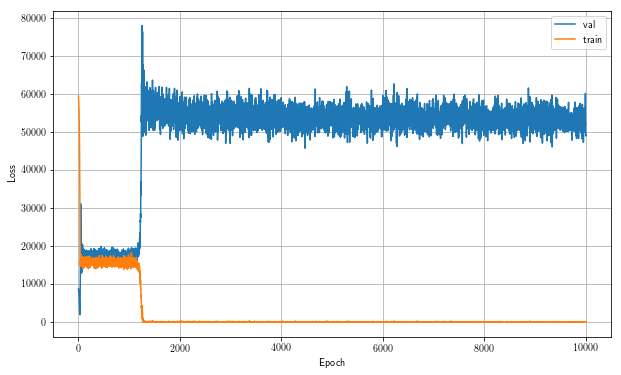

In [555]:
fig = plt.figure(figsize=(10,6))
plt.plot(vlossb, label="val")
plt.plot(losses_b1, label="train")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()
fig.savefig("cnn_loss_branch.png", bbox_inches="tight")

In [25]:
cnn_1 = torch.load('models/cnn_models/loc_cnn_unbranched.pt', map_location=lambda storage, loc: storage)

In [27]:
x = np.zeros((len(list_times_ch_test), 54, 54))
ch = np.zeros((len(list_times_ch_test), 1))
loc = np.zeros((len(list_times_ch_test), 2))

for i in range(len(list_times_ch_test)):
        pointer = list_times_ch_test[i]
        x[i, :, :] = image_data[pointer]
        dim = x.shape[0]
        ch[i, :] = np.array(pointer[1])
        loc[i, :] = np.array(location[pointer])
x = torch.from_numpy(x).float()
x = x.view(len(list_times_ch_test), -1, 54, 54)
ch = torch.from_numpy(ch).float()
#---------FORWARD------------#
out = cnn_1.forward(x, dim, ch)
out = torch.tensor(out).float()
out = (out.data).cpu().numpy()

In [ ]:
temp = {}
for i, val in enumerate(list_times_ch_test):
    try:
        temp[val[1]] += 1
    except:
        temp[val[1]] = 1
print(temp)

cnn_loc = []
com_loc = []

for i, val in enumerate(list_times_ch_test):
    if val[1] == 1:
        com_loc.append(location[val])
        cnn_loc.append(out[i])
cnn_loc = np.array(cnn_loc)
com_loc = np.array(com_loc)

print("CNN: ", np.mean(cnn_loc, axis=0), np.var(cnn_loc, axis=0))
print("COM: ", np.mean(com_loc, axis=0), np.var(com_loc, axis=0))

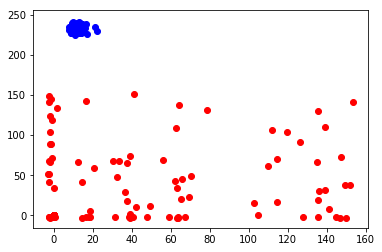

In [93]:
plt.scatter(cnn_loc[:, 0], cnn_loc[:, 1], c = 'r')
plt.scatter(com_loc[:, 0], com_loc[:, 1], c = 'b')
plt.show()

In [106]:
print(ground_truth)

[[     47   10029]
 [     35   10078]
 [     27   10094]
 ...
 [     45 1199869]
 [     20 1199885]
 [     27 1199900]]


In [117]:
print("ch", "t", "neuron", "x", "y")
for i, val in enumerate(list_times_ch_test):
    for ind, j in enumerate(ground_truth[:, 1]):
        if val[0] in range(j-6, j+6):
            neuron = ground_truth[ind, 0] - 1
            print(val[1], val[0], neuron, somapos[0, neuron], somapos[1, neuron])
            continue

ch t neuron x y
95 878178 43 71.21975778349739 227.26135913539144
95 878178 37 27.688473886980738 215.5852797694069
93 878251 10 48.058360355686084 34.22882047206244
57 878332 48 -4.321020536548048 285.07452106690357
88 878402 17 21.929984086193784 86.07177710710573
17 878521 49 12.41516045629561 279.9171104449782
68 878529 12 6.204636629183717 66.89060094079736
81 878614 41 20.96538808643902 231.05365579519244
11 878714 8 -14.63904256434109 29.023447925545256
1 878818 40 1.2462724288123752 237.03833774992944
1 878818 13 32.8616714073321 65.09189524365455
35 878820 40 1.2462724288123752 237.03833774992944
35 878820 13 32.8616714073321 65.09189524365455
35 878820 27 78.06279007913575 142.09807088762165
26 878828 27 78.06279007913575 142.09807088762165
26 878828 31 84.4412944888875 160.61075267773893
93 878854 10 48.058360355686084 34.22882047206244
57 878883 48 -4.321020536548048 285.07452106690357
57 878883 2 53.20338083002666 -14.781218541861762
56 879015 5 30.572633591464864 15.53940

93 884102 10 48.058360355686084 34.22882047206244
7 884186 53 29.196404783660128 304.7212725070782
58 884200 47 89.17156341288208 258.0971028111536
58 884200 50 39.98196363986355 285.1030572853384
60 884213 28 2.0629572306957584 159.0798804374282
96 884259 8 -14.63904256434109 29.023447925545256
96 884259 11 62.46587907380028 29.46580953847061
68 884376 21 21.56309160168722 110.4201290286616
68 884376 12 6.204636629183717 66.89060094079736
89 884376 21 21.56309160168722 110.4201290286616
89 884376 12 6.204636629183717 66.89060094079736
17 884494 49 12.41516045629561 279.9171104449782
13 884618 18 43.73117057110287 81.61044728225859
35 884660 13 32.8616714073321 65.09189524365455
35 884660 50 39.98196363986355 285.1030572853384
57 884677 25 8.787039187848436 135.2796846214902
57 884677 48 -4.321020536548048 285.07452106690357
57 884677 2 53.20338083002666 -14.781218541861762
93 884691 10 48.058360355686084 34.22882047206244
65 884715 41 20.96538808643902 231.05365579519244
1 884765 40 1

81 889177 9 20.651608426259216 36.177201343026596
81 889177 27 78.06279007913575 142.09807088762165
26 889183 9 20.651608426259216 36.177201343026596
26 889183 27 78.06279007913575 142.09807088762165
26 889183 53 29.196404783660128 304.7212725070782
7 889190 53 29.196404783660128 304.7212725070782
46 889224 21 21.56309160168722 110.4201290286616
13 889241 18 43.73117057110287 81.61044728225859
13 889241 3 76.46626374529562 -11.87462893958022
1 889251 40 1.2462724288123752 237.03833774992944
48 889383 46 68.29533070622665 264.28863666998893
28 889396 11 62.46587907380028 29.46580953847061
28 889396 19 65.97012980454399 86.96092763176041
57 889472 48 -4.321020536548048 285.07452106690357
93 889539 10 48.058360355686084 34.22882047206244
93 889539 44 -2.0787885103061896 258.22839124713335
41 889609 37 27.688473886980738 215.5852797694069
17 889650 1 13.563411804694152 -9.808245958568477
17 889650 49 12.41516045629561 279.9171104449782
17 889650 33 12.032360327800141 179.29376161360074
81 

98 893322 22 58.86033512736802 118.92213464040759
98 893322 35 66.41585518194213 195.1814405242318
60 893365 28 2.0629572306957584 159.0798804374282
60 893365 44 -2.0787885103061896 258.22839124713335
60 893365 41 20.96538808643902 231.05365579519244
81 893371 41 20.96538808643902 231.05365579519244
81 893371 36 7.6721561585161595 208.86073497920086
18 893421 53 29.196404783660128 304.7212725070782
58 893437 47 89.17156341288208 258.0971028111536
37 893543 34 42.42885691382137 179.9372547328072
35 893555 13 32.8616714073321 65.09189524365455
13 893596 18 43.73117057110287 81.61044728225859
68 893735 12 6.204636629183717 66.89060094079736
68 893735 40 1.2462724288123752 237.03833774992944
1 893740 40 1.2462724288123752 237.03833774992944
93 893933 10 48.058360355686084 34.22882047206244
93 893933 17 21.929984086193784 86.07177710710573
93 893933 41 20.96538808643902 231.05365579519244
81 893938 41 20.96538808643902 231.05365579519244
46 893971 21 21.56309160168722 110.4201290286616
59 8

68 898796 40 1.2462724288123752 237.03833774992944
68 898796 12 6.204636629183717 66.89060094079736
41 898897 37 27.688473886980738 215.5852797694069
86 898970 17 21.929984086193784 86.07177710710573
58 899085 46 68.29533070622665 264.28863666998893
58 899085 20 7.4942574022962845 110.095967166767
58 899105 51 67.64586422530788 285.9671174973289
58 899105 47 89.17156341288208 258.0971028111536
60 899130 44 -2.0787885103061896 258.22839124713335
60 899130 28 2.0629572306957584 159.0798804374282
12 899138 14 56.635852252252064 54.52997833339967
12 899138 5 30.572633591464864 15.539403198947753
56 899143 5 30.572633591464864 15.539403198947753
93 899166 10 48.058360355686084 34.22882047206244
46 899218 21 21.56309160168722 110.4201290286616
46 899218 1 13.563411804694152 -9.808245958568477
17 899226 49 12.41516045629561 279.9171104449782
35 899256 13 32.8616714073321 65.09189524365455
84 899284 29 37.182174617108984 161.34565319128473
84 899284 41 20.96538808643902 231.05365579519244
13 8

37 906152 34 42.42885691382137 179.9372547328072
37 906152 30 56.40944800817404 158.56847750705774
37 906152 20 7.4942574022962845 110.095967166767
89 906229 21 21.56309160168722 110.4201290286616
57 906267 48 -4.321020536548048 285.07452106690357
13 906507 36 7.6721561585161595 208.86073497920086
13 906507 18 43.73117057110287 81.61044728225859
35 906571 13 32.8616714073321 65.09189524365455
60 906647 28 2.0629572306957584 159.0798804374282
7 906728 53 29.196404783660128 304.7212725070782
7 906728 24 -19.23563550600796 138.77277261771135
7 906728 27 78.06279007913575 142.09807088762165
26 906736 24 -19.23563550600796 138.77277261771135
26 906736 27 78.06279007913575 142.09807088762165
98 906767 22 58.86033512736802 118.92213464040759
98 906767 50 39.98196363986355 285.1030572853384
17 906782 49 12.41516045629561 279.9171104449782
83 906855 29 37.182174617108984 161.34565319128473
81 906919 41 20.96538808643902 231.05365579519244
57 906976 48 -4.321020536548048 285.07452106690357
89 90

35 913442 23 91.96037958183258 114.69148692316693
35 913442 13 32.8616714073321 65.09189524365455
29 913486 12 6.204636629183717 66.89060094079736
37 913508 34 42.42885691382137 179.9372547328072
17 913560 49 12.41516045629561 279.9171104449782
88 913633 17 21.929984086193784 86.07177710710573
1 913678 40 1.2462724288123752 237.03833774992944
1 913678 36 7.6721561585161595 208.86073497920086
60 913739 28 2.0629572306957584 159.0798804374282
71 913817 32 -11.078967322015629 182.23483294831658
26 913826 27 78.06279007913575 142.09807088762165
13 913888 18 43.73117057110287 81.61044728225859
13 913888 26 43.03259679874801 142.414760948499
58 913900 46 68.29533070622665 264.28863666998893
58 913900 31 84.4412944888875 160.61075267773893
7 913910 53 29.196404783660128 304.7212725070782
7 913910 0 -15.481029003693855 -14.975225920985395
57 913996 48 -4.321020536548048 285.07452106690357
81 914040 19 65.97012980454399 86.96092763176041
81 914040 41 20.96538808643902 231.05365579519244
74 9141

1 919996 40 1.2462724288123752 237.03833774992944
1 919996 53 29.196404783660128 304.7212725070782
1 919996 18 43.73117057110287 81.61044728225859
1 919996 17 21.929984086193784 86.07177710710573
88 920002 18 43.73117057110287 81.61044728225859
88 920002 17 21.929984086193784 86.07177710710573
51 920121 8 -14.63904256434109 29.023447925545256
71 920170 32 -11.078967322015629 182.23483294831658
17 920192 49 12.41516045629561 279.9171104449782
35 920217 13 32.8616714073321 65.09189524365455
57 920283 48 -4.321020536548048 285.07452106690357
22 920342 51 67.64586422530788 285.9671174973289
41 920390 38 60.57670279018768 213.41725808122825
41 920390 37 27.688473886980738 215.5852797694069
56 920443 5 30.572633591464864 15.539403198947753
66 920537 50 39.98196363986355 285.1030572853384
66 920537 34 42.42885691382137 179.9372547328072
60 920608 28 2.0629572306957584 159.0798804374282
1 920621 40 1.2462724288123752 237.03833774992944
13 920728 18 43.73117057110287 81.61044728225859
84 920808

17 926204 49 12.41516045629561 279.9171104449782
17 926204 1 13.563411804694152 -9.808245958568477
57 926271 48 -4.321020536548048 285.07452106690357
57 926271 2 53.20338083002666 -14.781218541861762
93 926648 10 48.058360355686084 34.22882047206244
56 926693 5 30.572633591464864 15.539403198947753
56 926693 52 2.689424678455879 319.1776364338083
13 926738 18 43.73117057110287 81.61044728225859
84 926746 41 20.96538808643902 231.05365579519244
84 926746 4 1.5823362971976067 10.150136258336886
60 926805 28 2.0629572306957584 159.0798804374282
7 926925 53 29.196404783660128 304.7212725070782
7 926925 15 90.36306974002551 58.164272038492086
57 926954 48 -4.321020536548048 285.07452106690357
57 926954 6 54.902873278407895 19.959384105320567
71 926984 32 -11.078967322015629 182.23483294831658
1 927007 40 1.2462724288123752 237.03833774992944
1 927007 12 6.204636629183717 66.89060094079736
68 927008 40 1.2462724288123752 237.03833774992944
68 927008 12 6.204636629183717 66.89060094079736
17 

11 934882 8 -14.63904256434109 29.023447925545256
17 935082 49 12.41516045629561 279.9171104449782
18 935188 53 29.196404783660128 304.7212725070782
12 935317 14 56.635852252252064 54.52997833339967
48 935333 46 68.29533070622665 264.28863666998893
100 935360 44 -2.0787885103061896 258.22839124713335
100 935360 48 -4.321020536548048 285.07452106690357
100 935360 0 -15.481029003693855 -14.975225920985395
95 935403 43 71.21975778349739 227.26135913539144
95 935403 10 48.058360355686084 34.22882047206244
95 935403 35 66.41585518194213 195.1814405242318
93 935409 10 48.058360355686084 34.22882047206244
93 935409 35 66.41585518194213 195.1814405242318
71 935560 32 -11.078967322015629 182.23483294831658
71 935560 50 39.98196363986355 285.1030572853384
71 935560 3 76.46626374529562 -11.87462893958022
56 935631 5 30.572633591464864 15.539403198947753
33 935759 38 60.57670279018768 213.41725808122825
1 935874 40 1.2462724288123752 237.03833774992944
7 935894 53 29.196404783660128 304.7212725070

71 942787 32 -11.078967322015629 182.23483294831658
17 942865 49 12.41516045629561 279.9171104449782
13 942882 18 43.73117057110287 81.61044728225859
13 942882 46 68.29533070622665 264.28863666998893
58 942887 46 68.29533070622665 264.28863666998893
58 942887 50 39.98196363986355 285.1030572853384
7 943016 53 29.196404783660128 304.7212725070782
7 943016 44 -2.0787885103061896 258.22839124713335
57 943082 48 -4.321020536548048 285.07452106690357
96 943093 10 48.058360355686084 34.22882047206244
96 943093 35 66.41585518194213 195.1814405242318
28 943180 11 62.46587907380028 29.46580953847061
1 943239 40 1.2462724288123752 237.03833774992944
1 943239 21 21.56309160168722 110.4201290286616
1 943239 1 13.563411804694152 -9.808245958568477
46 943244 21 21.56309160168722 110.4201290286616
46 943244 1 13.563411804694152 -9.808245958568477
30 943253 52 2.689424678455879 319.1776364338083
30 943253 26 43.03259679874801 142.414760948499
30 943253 51 67.64586422530788 285.9671174973289
60 943306 

84 949457 17 21.929984086193784 86.07177710710573
84 949457 42 35.03627355888451 226.68770520106688
17 949486 49 12.41516045629561 279.9171104449782
17 949486 20 7.4942574022962845 110.095967166767
93 949499 10 48.058360355686084 34.22882047206244
13 949658 18 43.73117057110287 81.61044728225859
57 949722 31 84.4412944888875 160.61075267773893
57 949722 48 -4.321020536548048 285.07452106690357
81 949771 41 20.96538808643902 231.05365579519244
58 950146 46 68.29533070622665 264.28863666998893
93 950156 10 48.058360355686084 34.22882047206244
28 950260 11 62.46587907380028 29.46580953847061
18 950270 53 29.196404783660128 304.7212725070782
18 950270 54 62.603384840652026 314.53088145476136
17 950414 49 12.41516045629561 279.9171104449782
72 950434 27 78.06279007913575 142.09807088762165
58 950484 47 89.17156341288208 258.0971028111536
56 950509 5 30.572633591464864 15.539403198947753
56 950509 34 42.42885691382137 179.9372547328072
37 950514 34 42.42885691382137 179.9372547328072
37 9505

58 957937 46 68.29533070622665 264.28863666998893
95 957952 49 12.41516045629561 279.9171104449782
95 957952 43 71.21975778349739 227.26135913539144
41 957969 37 27.688473886980738 215.5852797694069
26 958066 27 78.06279007913575 142.09807088762165
24 958094 10 48.058360355686084 34.22882047206244
60 958230 28 2.0629572306957584 159.0798804374282
1 958575 40 1.2462724288123752 237.03833774992944
33 958584 38 60.57670279018768 213.41725808122825
51 958620 8 -14.63904256434109 29.023447925545256
51 958620 11 62.46587907380028 29.46580953847061
96 958624 11 62.46587907380028 29.46580953847061
96 958624 35 66.41585518194213 195.1814405242318
84 958680 41 20.96538808643902 231.05365579519244
71 958697 32 -11.078967322015629 182.23483294831658
57 958783 48 -4.321020536548048 285.07452106690357
7 958811 53 29.196404783660128 304.7212725070782
93 958850 10 48.058360355686084 34.22882047206244
56 958918 5 30.572633591464864 15.539403198947753
56 958918 25 8.787039187848436 135.2796846214902
60 

58 966932 46 68.29533070622665 264.28863666998893
58 966932 24 -19.23563550600796 138.77277261771135
58 966932 28 2.0629572306957584 159.0798804374282
60 966937 24 -19.23563550600796 138.77277261771135
60 966937 28 2.0629572306957584 159.0798804374282
60 966937 7 84.46847549808167 14.246335268579315
11 966983 8 -14.63904256434109 29.023447925545256
7 967026 53 29.196404783660128 304.7212725070782
41 967049 2 53.20338083002666 -14.781218541861762
41 967049 37 27.688473886980738 215.5852797694069
41 967049 51 67.64586422530788 285.9671174973289
41 967049 6 54.902873278407895 19.959384105320567
93 967355 5 30.572633591464864 15.539403198947753
93 967355 10 48.058360355686084 34.22882047206244
93 967355 49 12.41516045629561 279.9171104449782
17 967361 49 12.41516045629561 279.9171104449782
57 967416 48 -4.321020536548048 285.07452106690357
68 967644 12 6.204636629183717 66.89060094079736
68 967644 40 1.2462724288123752 237.03833774992944
68 967644 50 39.98196363986355 285.1030572853384
84 

96 976252 11 62.46587907380028 29.46580953847061
93 976329 10 48.058360355686084 34.22882047206244
57 976538 48 -4.321020536548048 285.07452106690357
59 976604 35 66.41585518194213 195.1814405242318
39 976650 12 6.204636629183717 66.89060094079736
39 976650 40 1.2462724288123752 237.03833774992944
95 976670 43 71.21975778349739 227.26135913539144
26 976721 51 67.64586422530788 285.9671174973289
26 976721 27 78.06279007913575 142.09807088762165
26 976721 32 -11.078967322015629 182.23483294831658
71 976724 27 78.06279007913575 142.09807088762165
71 976724 32 -11.078967322015629 182.23483294831658
58 976777 46 68.29533070622665 264.28863666998893
86 976792 36 7.6721561585161595 208.86073497920086
86 976792 17 21.929984086193784 86.07177710710573
74 976888 13 32.8616714073321 65.09189524365455
74 976888 34 42.42885691382137 179.9372547328072
37 976889 13 32.8616714073321 65.09189524365455
37 976889 34 42.42885691382137 179.9372547328072
84 976995 41 20.96538808643902 231.05365579519244
84 

17 985183 49 12.41516045629561 279.9171104449782
96 985310 11 62.46587907380028 29.46580953847061
96 985310 55 86.68857442036482 312.60178399381834
65 985379 41 20.96538808643902 231.05365579519244
88 985465 47 89.17156341288208 258.0971028111536
88 985465 17 21.929984086193784 86.07177710710573
88 985465 15 90.36306974002551 58.164272038492086
13 985493 18 43.73117057110287 81.61044728225859
95 985514 43 71.21975778349739 227.26135913539144
57 985632 39 82.26593670956638 215.64550236108266
57 985632 48 -4.321020536548048 285.07452106690357
35 985832 13 32.8616714073321 65.09189524365455
35 985832 25 8.787039187848436 135.2796846214902
35 985832 12 6.204636629183717 66.89060094079736
35 985832 6 54.902873278407895 19.959384105320567
35 985832 34 42.42885691382137 179.9372547328072
66 985837 12 6.204636629183717 66.89060094079736
66 985837 6 54.902873278407895 19.959384105320567
66 985837 34 42.42885691382137 179.9372547328072
84 985988 42 35.03627355888451 226.68770520106688
95 986114 

95 992177 43 71.21975778349739 227.26135913539144
57 992188 48 -4.321020536548048 285.07452106690357
68 992244 12 6.204636629183717 66.89060094079736
68 992244 33 12.032360327800141 179.29376161360074
60 992438 28 2.0629572306957584 159.0798804374282
35 992542 13 32.8616714073321 65.09189524365455
35 992542 10 48.058360355686084 34.22882047206244
96 992549 10 48.058360355686084 34.22882047206244
96 992549 15 90.36306974002551 58.164272038492086
26 992560 29 37.182174617108984 161.34565319128473
26 992560 40 1.2462724288123752 237.03833774992944
26 992560 27 78.06279007913575 142.09807088762165
26 992560 50 39.98196363986355 285.1030572853384
48 992755 46 68.29533070622665 264.28863666998893
48 992755 7 84.46847549808167 14.246335268579315
28 992771 11 62.46587907380028 29.46580953847061
33 992809 33 12.032360327800141 179.29376161360074
33 992809 38 60.57670279018768 213.41725808122825
57 992889 48 -4.321020536548048 285.07452106690357
7 992931 53 29.196404783660128 304.7212725070782
5

65 999788 41 20.96538808643902 231.05365579519244
60 999831 28 2.0629572306957584 159.0798804374282
68 999908 1 13.563411804694152 -9.808245958568477
68 999908 12 6.204636629183717 66.89060094079736
35 1000252 13 32.8616714073321 65.09189524365455
71 1000276 32 -11.078967322015629 182.23483294831658
71 1000276 0 -15.481029003693855 -14.975225920985395
1 1000335 39 82.26593670956638 215.64550236108266
1 1000335 40 1.2462724288123752 237.03833774992944
81 1000527 41 20.96538808643902 231.05365579519244
68 1000537 12 6.204636629183717 66.89060094079736
95 1000581 43 71.21975778349739 227.26135913539144
57 1000684 48 -4.321020536548048 285.07452106690357
37 1000746 34 42.42885691382137 179.9372547328072
13 1000760 18 43.73117057110287 81.61044728225859
13 1000760 35 66.41585518194213 195.1814405242318
84 1000849 42 35.03627355888451 226.68770520106688
26 1000895 27 78.06279007913575 142.09807088762165
26 1000895 33 12.032360327800141 179.29376161360074
35 1001123 50 39.98196363986355 285.1

95 1008012 43 71.21975778349739 227.26135913539144
7 1008049 53 29.196404783660128 304.7212725070782
7 1008049 41 20.96538808643902 231.05365579519244
65 1008055 41 20.96538808643902 231.05365579519244
84 1008151 42 35.03627355888451 226.68770520106688
84 1008151 37 27.688473886980738 215.5852797694069
41 1008154 42 35.03627355888451 226.68770520106688
41 1008154 37 27.688473886980738 215.5852797694069
35 1008233 13 32.8616714073321 65.09189524365455
1 1008291 40 1.2462724288123752 237.03833774992944
1 1008291 33 12.032360327800141 179.29376161360074
68 1008309 12 6.204636629183717 66.89060094079736
68 1008309 10 48.058360355686084 34.22882047206244
96 1008310 12 6.204636629183717 66.89060094079736
96 1008310 10 48.058360355686084 34.22882047206244
13 1008398 18 43.73117057110287 81.61044728225859
66 1008439 34 42.42885691382137 179.9372547328072
66 1008439 44 -2.0787885103061896 258.22839124713335
28 1008595 11 62.46587907380028 29.46580953847061
71 1008616 32 -11.078967322015629 182.

71 1014787 32 -11.078967322015629 182.23483294831658
39 1015042 12 6.204636629183717 66.89060094079736
39 1015042 40 1.2462724288123752 237.03833774992944
39 1015042 18 43.73117057110287 81.61044728225859
37 1015225 33 12.032360327800141 179.29376161360074
37 1015225 34 42.42885691382137 179.9372547328072
37 1015225 1 13.563411804694152 -9.808245958568477
35 1015296 13 32.8616714073321 65.09189524365455
41 1015349 37 27.688473886980738 215.5852797694069
6 1015368 42 35.03627355888451 226.68770520106688
6 1015368 41 20.96538808643902 231.05365579519244
65 1015375 41 20.96538808643902 231.05365579519244
65 1015375 52 2.689424678455879 319.1776364338083
98 1015751 22 58.86033512736802 118.92213464040759
98 1015751 32 -11.078967322015629 182.23483294831658
71 1015757 32 -11.078967322015629 182.23483294831658
68 1015765 12 6.204636629183717 66.89060094079736
46 1015829 21 21.56309160168722 110.4201290286616
37 1015928 36 7.6721561585161595 208.86073497920086
37 1015928 34 42.42885691382137 

13 1023604 18 43.73117057110287 81.61044728225859
58 1023664 47 89.17156341288208 258.0971028111536
1 1023695 40 1.2462724288123752 237.03833774992944
48 1023776 46 68.29533070622665 264.28863666998893
53 1023835 50 39.98196363986355 285.1030572853384
53 1023835 42 35.03627355888451 226.68770520106688
95 1023892 43 71.21975778349739 227.26135913539144
66 1024165 34 42.42885691382137 179.9372547328072
48 1024248 0 -15.481029003693855 -14.975225920985395
48 1024248 46 68.29533070622665 264.28863666998893
48 1024248 21 21.56309160168722 110.4201290286616
48 1024248 48 -4.321020536548048 285.07452106690357
46 1024249 0 -15.481029003693855 -14.975225920985395
46 1024249 46 68.29533070622665 264.28863666998893
46 1024249 21 21.56309160168722 110.4201290286616
46 1024249 48 -4.321020536548048 285.07452106690357
57 1024255 48 -4.321020536548048 285.07452106690357
72 1024293 27 78.06279007913575 142.09807088762165
81 1024359 40 1.2462724288123752 237.03833774992944
60 1024409 28 2.0629572306957

84 1032049 41 20.96538808643902 231.05365579519244
41 1032123 37 27.688473886980738 215.5852797694069
41 1032123 33 12.032360327800141 179.29376161360074
18 1032171 53 29.196404783660128 304.7212725070782
58 1032199 47 89.17156341288208 258.0971028111536
100 1032307 48 -4.321020536548048 285.07452106690357
1 1032457 25 8.787039187848436 135.2796846214902
1 1032457 40 1.2462724288123752 237.03833774992944
66 1032475 34 42.42885691382137 179.9372547328072
58 1032486 46 68.29533070622665 264.28863666998893
58 1032486 28 2.0629572306957584 159.0798804374282
60 1032488 46 68.29533070622665 264.28863666998893
60 1032488 28 2.0629572306957584 159.0798804374282
46 1032796 21 21.56309160168722 110.4201290286616
84 1032916 42 35.03627355888451 226.68770520106688
84 1032916 17 21.929984086193784 86.07177710710573
84 1032988 41 20.96538808643902 231.05365579519244
95 1033157 43 71.21975778349739 227.26135913539144
95 1033157 1 13.563411804694152 -9.808245958568477
58 1033242 46 68.29533070622665 2

7 1039999 53 29.196404783660128 304.7212725070782
13 1040088 18 43.73117057110287 81.61044728225859
89 1040194 21 21.56309160168722 110.4201290286616
37 1040245 34 42.42885691382137 179.9372547328072
99 1040276 44 -2.0787885103061896 258.22839124713335
99 1040276 26 43.03259679874801 142.414760948499
42 1040392 29 37.182174617108984 161.34565319128473
51 1040458 8 -14.63904256434109 29.023447925545256
68 1040466 12 6.204636629183717 66.89060094079736
60 1040493 28 2.0629572306957584 159.0798804374282
84 1040506 41 20.96538808643902 231.05365579519244
35 1040574 13 32.8616714073321 65.09189524365455
71 1040703 32 -11.078967322015629 182.23483294831658
71 1040703 21 21.56309160168722 110.4201290286616
46 1040709 21 21.56309160168722 110.4201290286616
81 1040799 37 27.688473886980738 215.5852797694069
57 1040894 48 -4.321020536548048 285.07452106690357
57 1040894 30 56.40944800817404 158.56847750705774
98 1040920 22 58.86033512736802 118.92213464040759
1 1040965 40 1.2462724288123752 237.

46 1048535 21 21.56309160168722 110.4201290286616
68 1048747 12 6.204636629183717 66.89060094079736
57 1048770 39 82.26593670956638 215.64550236108266
57 1048770 48 -4.321020536548048 285.07452106690357
62 1048780 15 90.36306974002551 58.164272038492086
26 1048856 27 78.06279007913575 142.09807088762165
1 1048897 40 1.2462724288123752 237.03833774992944
71 1048906 32 -11.078967322015629 182.23483294831658
84 1048945 41 20.96538808643902 231.05365579519244
84 1048945 17 21.929984086193784 86.07177710710573
89 1049000 21 21.56309160168722 110.4201290286616
7 1049058 53 29.196404783660128 304.7212725070782
7 1049058 46 68.29533070622665 264.28863666998893
48 1049065 46 68.29533070622665 264.28863666998893
48 1049065 14 56.635852252252064 54.52997833339967
13 1049156 18 43.73117057110287 81.61044728225859
46 1049461 36 7.6721561585161595 208.86073497920086
46 1049461 21 21.56309160168722 110.4201290286616
57 1049575 3 76.46626374529562 -11.87462893958022
57 1049575 48 -4.321020536548048 28

95 1057967 43 71.21975778349739 227.26135913539144
46 1058006 21 21.56309160168722 110.4201290286616
58 1058077 47 89.17156341288208 258.0971028111536
86 1058178 17 21.929984086193784 86.07177710710573
48 1058217 46 68.29533070622665 264.28863666998893
57 1058325 36 7.6721561585161595 208.86073497920086
57 1058325 52 2.689424678455879 319.1776364338083
57 1058325 48 -4.321020536548048 285.07452106690357
60 1058446 28 2.0629572306957584 159.0798804374282
60 1058446 40 1.2462724288123752 237.03833774992944
89 1058495 21 21.56309160168722 110.4201290286616
81 1058717 41 20.96538808643902 231.05365579519244
53 1058752 39 82.26593670956638 215.64550236108266
53 1058752 42 35.03627355888451 226.68770520106688
26 1058775 27 78.06279007913575 142.09807088762165
75 1058805 45 27.73676678808696 261.30266622860006
48 1058848 46 68.29533070622665 264.28863666998893
95 1058926 43 71.21975778349739 227.26135913539144
39 1058946 12 6.204636629183717 66.89060094079736
46 1059000 44 -2.0787885103061896

1 1065506 40 1.2462724288123752 237.03833774992944
81 1065781 41 20.96538808643902 231.05365579519244
46 1065847 21 21.56309160168722 110.4201290286616
46 1065847 43 71.21975778349739 227.26135913539144
95 1065853 43 71.21975778349739 227.26135913539144
48 1065943 46 68.29533070622665 264.28863666998893
48 1065943 30 56.40944800817404 158.56847750705774
87 1066008 44 -2.0787885103061896 258.22839124713335
87 1066008 17 21.929984086193784 86.07177710710573
68 1066170 12 6.204636629183717 66.89060094079736
68 1066170 52 2.689424678455879 319.1776364338083
84 1066190 42 35.03627355888451 226.68770520106688
7 1066298 53 29.196404783660128 304.7212725070782
7 1066298 26 43.03259679874801 142.414760948499
1 1066345 35 66.41585518194213 195.1814405242318
1 1066345 40 1.2462724288123752 237.03833774992944
46 1066383 21 21.56309160168722 110.4201290286616
46 1066383 50 39.98196363986355 285.1030572853384
81 1066422 41 20.96538808643902 231.05365579519244
81 1066422 31 84.4412944888875 160.61075

46 1073217 21 21.56309160168722 110.4201290286616
60 1073362 28 2.0629572306957584 159.0798804374282
57 1073399 48 -4.321020536548048 285.07452106690357
57 1073399 44 -2.0787885103061896 258.22839124713335
68 1073453 25 8.787039187848436 135.2796846214902
68 1073453 12 6.204636629183717 66.89060094079736
68 1073453 20 7.4942574022962845 110.095967166767
83 1073617 29 37.182174617108984 161.34565319128473
13 1073674 18 43.73117057110287 81.61044728225859
95 1073695 43 71.21975778349739 227.26135913539144
72 1073766 27 78.06279007913575 142.09807088762165
46 1073788 21 21.56309160168722 110.4201290286616
48 1073817 19 65.97012980454399 86.96092763176041
48 1073817 46 68.29533070622665 264.28863666998893
65 1073950 41 20.96538808643902 231.05365579519244
1 1074063 40 1.2462724288123752 237.03833774992944
53 1074345 42 35.03627355888451 226.68770520106688
46 1074373 21 21.56309160168722 110.4201290286616
46 1074373 15 90.36306974002551 58.164272038492086
46 1074373 48 -4.321020536548048 28

89 1081063 8 -14.63904256434109 29.023447925545256
89 1081063 21 21.56309160168722 110.4201290286616
48 1081292 46 68.29533070622665 264.28863666998893
53 1081393 19 65.97012980454399 86.96092763176041
53 1081393 42 35.03627355888451 226.68770520106688
53 1081393 13 32.8616714073321 65.09189524365455
35 1081400 13 32.8616714073321 65.09189524365455
35 1081400 44 -2.0787885103061896 258.22839124713335
81 1081435 10 48.058360355686084 34.22882047206244
81 1081435 41 20.96538808643902 231.05365579519244
71 1081454 32 -11.078967322015629 182.23483294831658
71 1081454 37 27.688473886980738 215.5852797694069
41 1081459 37 27.688473886980738 215.5852797694069
13 1081522 18 43.73117057110287 81.61044728225859
57 1081532 48 -4.321020536548048 285.07452106690357
62 1081667 17 21.929984086193784 86.07177710710573
62 1081667 15 90.36306974002551 58.164272038492086
62 1081667 27 78.06279007913575 142.09807088762165
26 1081674 27 78.06279007913575 142.09807088762165
95 1081742 43 71.21975778349739 2

72 1088526 27 78.06279007913575 142.09807088762165
72 1088526 12 6.204636629183717 66.89060094079736
68 1088532 12 6.204636629183717 66.89060094079736
62 1088621 15 90.36306974002551 58.164272038492086
84 1088765 42 35.03627355888451 226.68770520106688
13 1088905 18 43.73117057110287 81.61044728225859
13 1088905 46 68.29533070622665 264.28863666998893
58 1088909 46 68.29533070622665 264.28863666998893
93 1088924 10 48.058360355686084 34.22882047206244
65 1089022 41 20.96538808643902 231.05365579519244
65 1089022 55 86.68857442036482 312.60178399381834
66 1089040 34 42.42885691382137 179.9372547328072
35 1089058 13 32.8616714073321 65.09189524365455
95 1089175 39 82.26593670956638 215.64550236108266
95 1089175 43 71.21975778349739 227.26135913539144
46 1089213 21 21.56309160168722 110.4201290286616
46 1089213 17 21.929984086193784 86.07177710710573
26 1089234 27 78.06279007913575 142.09807088762165
41 1089250 37 27.688473886980738 215.5852797694069
57 1089278 48 -4.321020536548048 285.0

84 1094787 31 84.4412944888875 160.61075267773893
17 1094849 49 12.41516045629561 279.9171104449782
75 1094882 45 27.73676678808696 261.30266622860006
13 1094905 18 43.73117057110287 81.61044728225859
89 1094986 21 21.56309160168722 110.4201290286616
95 1095045 43 71.21975778349739 227.26135913539144
95 1095045 50 39.98196363986355 285.1030572853384
66 1095071 34 42.42885691382137 179.9372547328072
98 1095147 22 58.86033512736802 118.92213464040759
26 1095197 27 78.06279007913575 142.09807088762165
93 1095291 10 48.058360355686084 34.22882047206244
93 1095291 53 29.196404783660128 304.7212725070782
7 1095296 53 29.196404783660128 304.7212725070782
83 1095470 29 37.182174617108984 161.34565319128473
35 1095551 13 32.8616714073321 65.09189524365455
53 1095629 42 35.03627355888451 226.68770520106688
53 1095629 20 7.4942574022962845 110.095967166767
53 1095629 41 20.96538808643902 231.05365579519244
57 1095691 48 -4.321020536548048 285.07452106690357
37 1095825 34 42.42885691382137 179.937

72 1101925 27 78.06279007913575 142.09807088762165
72 1101925 35 66.41585518194213 195.1814405242318
75 1101976 45 27.73676678808696 261.30266622860006
75 1101976 41 20.96538808643902 231.05365579519244
65 1101980 41 20.96538808643902 231.05365579519244
93 1102011 10 48.058360355686084 34.22882047206244
98 1102239 31 84.4412944888875 160.61075267773893
98 1102239 22 58.86033512736802 118.92213464040759
66 1102257 34 42.42885691382137 179.9372547328072
66 1102257 29 37.182174617108984 161.34565319128473
95 1102301 43 71.21975778349739 227.26135913539144
35 1102524 13 32.8616714073321 65.09189524365455
35 1102524 21 21.56309160168722 110.4201290286616
89 1102525 13 32.8616714073321 65.09189524365455
89 1102525 21 21.56309160168722 110.4201290286616
89 1102525 2 53.20338083002666 -14.781218541861762
89 1102525 27 78.06279007913575 142.09807088762165
26 1102532 2 53.20338083002666 -14.781218541861762
26 1102532 27 78.06279007913575 142.09807088762165
26 1102532 0 -15.481029003693855 -14.97

60 1109162 28 2.0629572306957584 159.0798804374282
46 1109203 21 21.56309160168722 110.4201290286616
35 1109243 13 32.8616714073321 65.09189524365455
62 1109264 30 56.40944800817404 158.56847750705774
62 1109264 15 90.36306974002551 58.164272038492086
95 1109277 3 76.46626374529562 -11.87462893958022
95 1109277 43 71.21975778349739 227.26135913539144
58 1109389 47 89.17156341288208 258.0971028111536
58 1109389 46 68.29533070622665 264.28863666998893
72 1109454 27 78.06279007913575 142.09807088762165
1 1109564 40 1.2462724288123752 237.03833774992944
66 1109812 34 42.42885691382137 179.9372547328072
65 1109901 9 20.651608426259216 36.177201343026596
65 1109901 41 20.96538808643902 231.05365579519244
48 1109919 46 68.29533070622665 264.28863666998893
98 1109946 22 58.86033512736802 118.92213464040759
83 1109975 29 37.182174617108984 161.34565319128473
95 1110008 43 71.21975778349739 227.26135913539144
13 1110023 18 43.73117057110287 81.61044728225859
72 1110041 27 78.06279007913575 142.0

13 1116988 15 90.36306974002551 58.164272038492086
13 1116988 18 43.73117057110287 81.61044728225859
80 1117020 36 7.6721561585161595 208.86073497920086
80 1117020 37 27.688473886980738 215.5852797694069
80 1117020 44 -2.0787885103061896 258.22839124713335
72 1117037 27 78.06279007913575 142.09807088762165
72 1117037 20 7.4942574022962845 110.095967166767
72 1117037 1 13.563411804694152 -9.808245958568477
98 1117118 22 58.86033512736802 118.92213464040759
35 1117323 13 32.8616714073321 65.09189524365455
93 1117344 10 48.058360355686084 34.22882047206244
93 1117344 31 84.4412944888875 160.61075267773893
93 1117344 54 62.603384840652026 314.53088145476136
84 1117361 41 20.96538808643902 231.05365579519244
95 1117535 43 71.21975778349739 227.26135913539144
3 1117591 11 62.46587907380028 29.46580953847061
53 1117678 42 35.03627355888451 226.68770520106688
53 1117678 29 37.182174617108984 161.34565319128473
26 1117861 27 78.06279007913575 142.09807088762165
26 1117861 45 27.73676678808696 2

66 1126582 34 42.42885691382137 179.9372547328072
66 1126582 25 8.787039187848436 135.2796846214902
65 1126601 41 20.96538808643902 231.05365579519244
72 1126784 27 78.06279007913575 142.09807088762165
84 1126810 42 35.03627355888451 226.68770520106688
84 1126810 31 84.4412944888875 160.61075267773893
71 1126993 32 -11.078967322015629 182.23483294831658
89 1127034 21 21.56309160168722 110.4201290286616
89 1127034 38 60.57670279018768 213.41725808122825
89 1127034 43 71.21975778349739 227.26135913539144
95 1127039 38 60.57670279018768 213.41725808122825
95 1127039 43 71.21975778349739 227.26135913539144
98 1127140 22 58.86033512736802 118.92213464040759
60 1127174 28 2.0629572306957584 159.0798804374282
58 1127195 24 -19.23563550600796 138.77277261771135
58 1127195 46 68.29533070622665 264.28863666998893
11 1127474 0 -15.481029003693855 -14.975225920985395
11 1127474 8 -14.63904256434109 29.023447925545256
95 1127860 43 71.21975778349739 227.26135913539144
95 1127860 31 84.4412944888875

95 1137602 43 71.21975778349739 227.26135913539144
58 1137622 46 68.29533070622665 264.28863666998893
46 1137644 21 21.56309160168722 110.4201290286616
58 1137833 47 89.17156341288208 258.0971028111536
1 1137853 40 1.2462724288123752 237.03833774992944
33 1137871 38 60.57670279018768 213.41725808122825
98 1138068 7 84.46847549808167 14.246335268579315
98 1138068 22 58.86033512736802 118.92213464040759
45 1138088 28 2.0629572306957584 159.0798804374282
45 1138088 46 68.29533070622665 264.28863666998893
58 1138093 46 68.29533070622665 264.28863666998893
58 1138093 32 -11.078967322015629 182.23483294831658
72 1138189 27 78.06279007913575 142.09807088762165
66 1138476 34 42.42885691382137 179.9372547328072
41 1138545 37 27.688473886980738 215.5852797694069
11 1138555 8 -14.63904256434109 29.023447925545256
58 1138579 46 68.29533070622665 264.28863666998893
58 1138839 47 89.17156341288208 258.0971028111536
58 1138839 35 66.41585518194213 195.1814405242318
62 1138855 15 90.36306974002551 58.

35 1147651 13 32.8616714073321 65.09189524365455
35 1147651 16 -16.705722316203534 85.04998913470799
35 1147651 29 37.182174617108984 161.34565319128473
11 1147674 8 -14.63904256434109 29.023447925545256
58 1147855 47 89.17156341288208 258.0971028111536
60 1147916 28 2.0629572306957584 159.0798804374282
13 1147999 18 43.73117057110287 81.61044728225859
13 1147999 31 84.4412944888875 160.61075267773893
13 1147999 12 6.204636629183717 66.89060094079736
29 1148004 31 84.4412944888875 160.61075267773893
29 1148004 12 6.204636629183717 66.89060094079736
29 1148004 46 68.29533070622665 264.28863666998893
58 1148009 46 68.29533070622665 264.28863666998893
58 1148009 1 13.563411804694152 -9.808245958568477
93 1148052 10 48.058360355686084 34.22882047206244
93 1148052 35 66.41585518194213 195.1814405242318
33 1148064 38 60.57670279018768 213.41725808122825
86 1148080 17 21.929984086193784 86.07177710710573
37 1148218 34 42.42885691382137 179.9372547328072
37 1148218 26 43.03259679874801 142.414

In [64]:
temp = [(878251, 93), (878332, 57)]
x = np.zeros((len(temp), 54, 54))
ch = np.zeros((len(temp), 1))
loc = np.zeros((len(temp), 2))

for i in range(len(temp)):
        pointer = temp[i]
        x[i, :, :] = image_data[pointer]
        dim = x.shape[0]
        ch[i, :] = np.array(pointer[1])
        loc[i, :] = np.array(location[pointer])
x = torch.from_numpy(x).float().cuda()
x = x.view(len(temp), -1, 54, 54)
ch = torch.from_numpy(ch).float().cuda()
#---------FORWARD------------#
out = cnn_1.forward(x, dim, ch)
out = torch.tensor(out).float().cuda()
out = (out.data).cpu().numpy()
print(out)

[[-0.031622    0.19800985]
 [-0.03247429  0.19816048]]


In [128]:
com_loc = []
cnn_loc = []
for i, val in enumerate(temp):
    if True:
        com_loc.append(location[val])
        cnn_loc.append(out[i])
cnn_loc = np.array(cnn_loc)
com_loc = np.array(com_loc)
print(cnn_loc)
print(com_loc)
#print("CNN: ", np.mean(cnn_loc, axis=0), np.var(cnn_loc, axis=0))
#print("COM: ", np.mean(com_loc, axis=0), np.var(com_loc, axis=0))

[[ 45.694588  26.375175]
 [  9.017405 286.96277 ]]
[[ 46.541  26.116]
 [ 12.075 279.635]]


# Create New Dataset

In [51]:
print("ch", "t", "neuron", "x", "y")
for i, val in enumerate(list_times_ch):
    for ind, j in enumerate(ground_truth[:, 1]):
        if val[0] in range(j-6, j+6):
            neuron = ground_truth[ind, 0] - 1
            print(val[1], val[0], neuron, somapos[0, neuron], somapos[1, neuron])

ch t neuron x y
48 10030 46 68.29533070622665 264.28863666998893
66 10080 34 42.42885691382137 179.9372547328072
65 10110 41 20.96538808643902 231.05365579519244
65 10110 40 1.2462724288123752 237.03833774992944
65 10110 54 62.603384840652026 314.53088145476136
57 10137 48 -4.321020536548048 285.07452106690357
68 10226 24 -19.23563550600796 138.77277261771135
68 10226 12 6.204636629183717 66.89060094079736
17 10309 1 13.563411804694152 -9.808245958568477
17 10309 49 12.41516045629561 279.9171104449782
72 10366 27 78.06279007913575 142.09807088762165
95 10411 43 71.21975778349739 227.26135913539144
95 10411 45 27.73676678808696 261.30266622860006
75 10412 43 71.21975778349739 227.26135913539144
75 10412 45 27.73676678808696 261.30266622860006
60 10425 28 2.0629572306957584 159.0798804374282
60 10425 35 66.41585518194213 195.1814405242318
13 10435 35 66.41585518194213 195.1814405242318
13 10435 18 43.73117057110287 81.61044728225859
13 10435 52 2.689424678455879 319.1776364338083
13 1043

13 14636 1 13.563411804694152 -9.808245958568477
13 14636 38 60.57670279018768 213.41725808122825
68 14669 12 6.204636629183717 66.89060094079736
68 14669 25 8.787039187848436 135.2796846214902
97 14679 22 58.86033512736802 118.92213464040759
97 14679 35 66.41585518194213 195.1814405242318
35 14787 13 32.8616714073321 65.09189524365455
1 14826 40 1.2462724288123752 237.03833774992944
1 14826 31 84.4412944888875 160.61075267773893
17 14961 49 12.41516045629561 279.9171104449782
17 14961 47 89.17156341288208 258.0971028111536
17 14961 39 82.26593670956638 215.64550236108266
46 14972 21 21.56309160168722 110.4201290286616
46 14972 34 42.42885691382137 179.9372547328072
66 14977 34 42.42885691382137 179.9372547328072
72 15026 27 78.06279007913575 142.09807088762165
72 15026 7 84.46847549808167 14.246335268579315
58 15042 46 68.29533070622665 264.28863666998893
57 15066 9 20.651608426259216 36.177201343026596
57 15066 48 -4.321020536548048 285.07452106690357
57 15066 28 2.0629572306957584 1

53 19045 42 35.03627355888451 226.68770520106688
53 19045 31 84.4412944888875 160.61075267773893
72 19059 35 66.41585518194213 195.1814405242318
72 19059 27 78.06279007913575 142.09807088762165
72 19059 46 68.29533070622665 264.28863666998893
60 19096 28 2.0629572306957584 159.0798804374282
98 19225 22 58.86033512736802 118.92213464040759
98 19225 33 12.032360327800141 179.29376161360074
46 19266 21 21.56309160168722 110.4201290286616
46 19266 55 86.68857442036482 312.60178399381834
46 19266 39 82.26593670956638 215.64550236108266
7 19366 53 29.196404783660128 304.7212725070782
7 19366 47 89.17156341288208 258.0971028111536
58 19370 53 29.196404783660128 304.7212725070782
58 19370 47 89.17156341288208 258.0971028111536
35 19392 13 32.8616714073321 65.09189524365455
93 19452 10 48.058360355686084 34.22882047206244
95 19468 38 60.57670279018768 213.41725808122825
95 19468 43 71.21975778349739 227.26135913539144
57 19585 48 -4.321020536548048 285.07452106690357
57 19585 1 13.5634118046941

72 24195 27 78.06279007913575 142.09807088762165
93 24231 10 48.058360355686084 34.22882047206244
60 24280 28 2.0629572306957584 159.0798804374282
33 24360 38 60.57670279018768 213.41725808122825
66 24484 34 42.42885691382137 179.9372547328072
66 24484 35 66.41585518194213 195.1814405242318
66 24484 44 -2.0787885103061896 258.22839124713335
68 24494 12 6.204636629183717 66.89060094079736
11 24612 8 -14.63904256434109 29.023447925545256
74 24652 13 32.8616714073321 65.09189524365455
74 24652 26 43.03259679874801 142.414760948499
22 24667 1 13.563411804694152 -9.808245958568477
22 24667 51 67.64586422530788 285.9671174973289
95 24687 31 84.4412944888875 160.61075267773893
95 24687 43 71.21975778349739 227.26135913539144
48 24764 46 68.29533070622665 264.28863666998893
48 24764 48 -4.321020536548048 285.07452106690357
57 24769 48 -4.321020536548048 285.07452106690357
93 24942 10 48.058360355686084 34.22882047206244
46 24951 21 21.56309160168722 110.4201290286616
46 24951 42 35.03627355888

58 28576 26 43.03259679874801 142.414760948499
58 28576 46 68.29533070622665 264.28863666998893
33 28608 36 7.6721561585161595 208.86073497920086
33 28608 38 60.57670279018768 213.41725808122825
98 28738 22 58.86033512736802 118.92213464040759
35 28765 13 32.8616714073321 65.09189524365455
93 28806 10 48.058360355686084 34.22882047206244
93 28806 28 2.0629572306957584 159.0798804374282
60 28812 28 2.0629572306957584 159.0798804374282
68 28850 12 6.204636629183717 66.89060094079736
11 28909 0 -15.481029003693855 -14.975225920985395
11 28909 8 -14.63904256434109 29.023447925545256
58 28920 47 89.17156341288208 258.0971028111536
58 28920 55 86.68857442036482 312.60178399381834
66 28929 34 42.42885691382137 179.9372547328072
66 28929 7 84.46847549808167 14.246335268579315
66 28929 27 78.06279007913575 142.09807088762165
1 29043 33 12.032360327800141 179.29376161360074
1 29043 40 1.2462724288123752 237.03833774992944
95 29061 43 71.21975778349739 227.26135913539144
95 29061 29 37.1821746171

95 32901 7 84.46847549808167 14.246335268579315
31 32995 18 43.73117057110287 81.61044728225859
31 32995 39 82.26593670956638 215.64550236108266
57 33017 48 -4.321020536548048 285.07452106690357
57 33017 21 21.56309160168722 110.4201290286616
46 33025 21 21.56309160168722 110.4201290286616
46 33025 34 42.42885691382137 179.9372547328072
37 33032 34 42.42885691382137 179.9372547328072
100 33065 44 -2.0787885103061896 258.22839124713335
100 33065 49 12.41516045629561 279.9171104449782
60 33082 28 2.0629572306957584 159.0798804374282
41 33091 37 27.688473886980738 215.5852797694069
93 33129 10 48.058360355686084 34.22882047206244
98 33166 25 8.787039187848436 135.2796846214902
98 33166 22 58.86033512736802 118.92213464040759
98 33166 40 1.2462724288123752 237.03833774992944
11 33183 8 -14.63904256434109 29.023447925545256
68 33278 12 6.204636629183717 66.89060094079736
68 33278 19 65.97012980454399 86.96092763176041
53 33324 42 35.03627355888451 226.68770520106688
53 33324 13 32.861671407

58 37159 46 68.29533070622665 264.28863666998893
72 37240 27 78.06279007913575 142.09807088762165
17 37267 49 12.41516045629561 279.9171104449782
95 37283 43 71.21975778349739 227.26135913539144
95 37283 33 12.032360327800141 179.29376161360074
84 37315 41 20.96538808643902 231.05365579519244
66 37360 34 42.42885691382137 179.9372547328072
57 37415 31 84.4412944888875 160.61075267773893
57 37415 48 -4.321020536548048 285.07452106690357
11 37599 8 -14.63904256434109 29.023447925545256
11 37599 22 58.86033512736802 118.92213464040759
98 37602 8 -14.63904256434109 29.023447925545256
98 37602 22 58.86033512736802 118.92213464040759
98 37602 46 68.29533070622665 264.28863666998893
58 37609 46 68.29533070622665 264.28863666998893
58 37609 55 86.68857442036482 312.60178399381834
84 37640 42 35.03627355888451 226.68770520106688
35 37747 13 32.8616714073321 65.09189524365455
66 37763 44 -2.0787885103061896 258.22839124713335
66 37763 47 89.17156341288208 258.0971028111536
66 37763 34 42.4288569

60 41131 28 2.0629572306957584 159.0798804374282
60 41131 48 -4.321020536548048 285.07452106690357
60 41131 36 7.6721561585161595 208.86073497920086
95 41147 43 71.21975778349739 227.26135913539144
95 41147 50 39.98196363986355 285.1030572853384
26 41389 27 78.06279007913575 142.09807088762165
66 41402 26 43.03259679874801 142.414760948499
66 41402 34 42.42885691382137 179.9372547328072
17 41471 49 12.41516045629561 279.9171104449782
17 41471 2 53.20338083002666 -14.781218541861762
17 41471 46 68.29533070622665 264.28863666998893
58 41474 49 12.41516045629561 279.9171104449782
58 41474 2 53.20338083002666 -14.781218541861762
58 41474 46 68.29533070622665 264.28863666998893
93 41509 10 48.058360355686084 34.22882047206244
65 41520 41 20.96538808643902 231.05365579519244
65 41520 25 8.787039187848436 135.2796846214902
33 41553 7 84.46847549808167 14.246335268579315
33 41553 38 60.57670279018768 213.41725808122825
33 41553 17 21.929984086193784 86.07177710710573
86 41555 7 84.468475498081

95 45543 43 71.21975778349739 227.26135913539144
46 45585 21 21.56309160168722 110.4201290286616
60 45596 28 2.0629572306957584 159.0798804374282
26 45607 8 -14.63904256434109 29.023447925545256
26 45607 27 78.06279007913575 142.09807088762165
1 45617 40 1.2462724288123752 237.03833774992944
1 45617 7 84.46847549808167 14.246335268579315
84 45732 42 35.03627355888451 226.68770520106688
68 45760 12 6.204636629183717 66.89060094079736
68 45760 46 68.29533070622665 264.28863666998893
13 45772 18 43.73117057110287 81.61044728225859
98 45842 22 58.86033512736802 118.92213464040759
98 45842 47 89.17156341288208 258.0971028111536
35 45885 13 32.8616714073321 65.09189524365455
37 45960 34 42.42885691382137 179.9372547328072
37 45960 39 82.26593670956638 215.64550236108266
28 46026 11 62.46587907380028 29.46580953847061
46 46060 21 21.56309160168722 110.4201290286616
46 46060 49 12.41516045629561 279.9171104449782
93 46094 10 48.058360355686084 34.22882047206244
81 46141 41 20.96538808643902 23

97 50526 25 8.787039187848436 135.2796846214902
97 50526 22 58.86033512736802 118.92213464040759
98 50529 25 8.787039187848436 135.2796846214902
98 50529 22 58.86033512736802 118.92213464040759
95 50582 43 71.21975778349739 227.26135913539144
95 50582 29 37.182174617108984 161.34565319128473
95 50582 6 54.902873278407895 19.959384105320567
46 50720 34 42.42885691382137 179.9372547328072
46 50720 18 43.73117057110287 81.61044728225859
46 50720 21 21.56309160168722 110.4201290286616
46 50720 17 21.929984086193784 86.07177710710573
37 50720 34 42.42885691382137 179.9372547328072
37 50720 18 43.73117057110287 81.61044728225859
37 50720 21 21.56309160168722 110.4201290286616
37 50720 17 21.929984086193784 86.07177710710573
89 50722 34 42.42885691382137 179.9372547328072
89 50722 18 43.73117057110287 81.61044728225859
89 50722 21 21.56309160168722 110.4201290286616
89 50722 17 21.929984086193784 86.07177710710573
35 50756 13 32.8616714073321 65.09189524365455
35 50756 9 20.651608426259216 36

51 56411 8 -14.63904256434109 29.023447925545256
51 56411 13 32.8616714073321 65.09189524365455
35 56415 8 -14.63904256434109 29.023447925545256
35 56415 13 32.8616714073321 65.09189524365455
33 56438 38 60.57670279018768 213.41725808122825
58 56458 42 35.03627355888451 226.68770520106688
58 56458 46 68.29533070622665 264.28863666998893
58 56458 52 2.689424678455879 319.1776364338083
84 56458 42 35.03627355888451 226.68770520106688
84 56458 46 68.29533070622665 264.28863666998893
84 56458 52 2.689424678455879 319.1776364338083
18 56501 3 76.46626374529562 -11.87462893958022
18 56501 53 29.196404783660128 304.7212725070782
46 56522 21 21.56309160168722 110.4201290286616
13 56535 18 43.73117057110287 81.61044728225859
13 56535 5 30.572633591464864 15.539403198947753
56 56539 5 30.572633591464864 15.539403198947753
95 56579 25 8.787039187848436 135.2796846214902
95 56579 43 71.21975778349739 227.26135913539144
60 56614 28 2.0629572306957584 159.0798804374282
60 56614 40 1.2462724288123752

71 62726 0 -15.481029003693855 -14.975225920985395
88 62744 17 21.929984086193784 86.07177710710573
68 62764 12 6.204636629183717 66.89060094079736
33 62898 38 60.57670279018768 213.41725808122825
60 63005 28 2.0629572306957584 159.0798804374282
7 63130 53 29.196404783660128 304.7212725070782
95 63218 43 71.21975778349739 227.26135913539144
95 63218 51 67.64586422530788 285.9671174973289
35 63262 13 32.8616714073321 65.09189524365455
35 63262 27 78.06279007913575 142.09807088762165
26 63264 13 32.8616714073321 65.09189524365455
26 63264 27 78.06279007913575 142.09807088762165
46 63302 21 21.56309160168722 110.4201290286616
51 63398 8 -14.63904256434109 29.023447925545256
51 63398 36 7.6721561585161595 208.86073497920086
51 63398 34 42.42885691382137 179.9372547328072
37 63404 34 42.42885691382137 179.9372547328072
58 63472 46 68.29533070622665 264.28863666998893
58 63472 19 65.97012980454399 86.96092763176041
68 63532 12 6.204636629183717 66.89060094079736
22 63722 51 67.64586422530788

60 69950 28 2.0629572306957584 159.0798804374282
89 69960 21 21.56309160168722 110.4201290286616
57 70009 48 -4.321020536548048 285.07452106690357
57 70009 43 71.21975778349739 227.26135913539144
95 70013 43 71.21975778349739 227.26135913539144
95 70013 31 84.4412944888875 160.61075267773893
58 70172 47 89.17156341288208 258.0971028111536
58 70172 8 -14.63904256434109 29.023447925545256
98 70199 22 58.86033512736802 118.92213464040759
98 70199 35 66.41585518194213 195.1814405242318
98 70199 29 37.182174617108984 161.34565319128473
1 70297 40 1.2462724288123752 237.03833774992944
68 70344 12 6.204636629183717 66.89060094079736
84 70472 42 35.03627355888451 226.68770520106688
72 70521 27 78.06279007913575 142.09807088762165
12 70543 14 56.635852252252064 54.52997833339967
12 70543 11 62.46587907380028 29.46580953847061
96 70549 11 62.46587907380028 29.46580953847061
35 70623 13 32.8616714073321 65.09189524365455
35 70623 17 21.929984086193784 86.07177710710573
95 70669 43 71.219757783497

60 76248 28 2.0629572306957584 159.0798804374282
35 76322 13 32.8616714073321 65.09189524365455
35 76322 44 -2.0787885103061896 258.22839124713335
72 76357 27 78.06279007913575 142.09807088762165
72 76357 33 12.032360327800141 179.29376161360074
97 76384 22 58.86033512736802 118.92213464040759
1 76394 40 1.2462724288123752 237.03833774992944
1 76394 30 56.40944800817404 158.56847750705774
13 76512 18 43.73117057110287 81.61044728225859
86 76639 17 21.929984086193784 86.07177710710573
58 76835 47 89.17156341288208 258.0971028111536
46 76848 21 21.56309160168722 110.4201290286616
95 76881 43 71.21975778349739 227.26135913539144
95 76881 29 37.182174617108984 161.34565319128473
35 77012 13 32.8616714073321 65.09189524365455
60 77110 28 2.0629572306957584 159.0798804374282
96 77127 11 62.46587907380028 29.46580953847061
11 77148 8 -14.63904256434109 29.023447925545256
57 77219 48 -4.321020536548048 285.07452106690357
37 77333 34 42.42885691382137 179.9372547328072
37 77333 26 43.0325967987

11 84404 8 -14.63904256434109 29.023447925545256
11 84404 23 91.96037958183258 114.69148692316693
68 84451 12 6.204636629183717 66.89060094079736
26 84485 27 78.06279007913575 142.09807088762165
26 84485 20 7.4942574022962845 110.095967166767
89 84631 1 13.563411804694152 -9.808245958568477
89 84631 21 21.56309160168722 110.4201290286616
89 84631 48 -4.321020536548048 285.07452106690357
89 84631 0 -15.481029003693855 -14.975225920985395
89 84631 51 67.64586422530788 285.9671174973289
89 84631 32 -11.078967322015629 182.23483294831658
71 84638 48 -4.321020536548048 285.07452106690357
71 84638 0 -15.481029003693855 -14.975225920985395
71 84638 51 67.64586422530788 285.9671174973289
71 84638 32 -11.078967322015629 182.23483294831658
71 84638 53 29.196404783660128 304.7212725070782
71 84638 43 71.21975778349739 227.26135913539144
18 84644 53 29.196404783660128 304.7212725070782
18 84644 43 71.21975778349739 227.26135913539144
18 84644 36 7.6721561585161595 208.86073497920086
95 84646 53 29

35 90686 53 29.196404783660128 304.7212725070782
35 90686 13 32.8616714073321 65.09189524365455
35 90686 54 62.603384840652026 314.53088145476136
87 90794 21 21.56309160168722 110.4201290286616
87 90794 49 12.41516045629561 279.9171104449782
17 90798 21 21.56309160168722 110.4201290286616
17 90798 49 12.41516045629561 279.9171104449782
17 90798 0 -15.481029003693855 -14.975225920985395
13 90815 18 43.73117057110287 81.61044728225859
13 90815 36 7.6721561585161595 208.86073497920086
95 90844 43 71.21975778349739 227.26135913539144
72 90876 27 78.06279007913575 142.09807088762165
28 91008 11 62.46587907380028 29.46580953847061
86 91044 17 21.929984086193784 86.07177710710573
86 91044 52 2.689424678455879 319.1776364338083
75 91071 45 27.73676678808696 261.30266622860006
51 91159 8 -14.63904256434109 29.023447925545256
60 91169 28 2.0629572306957584 159.0798804374282
60 91169 35 66.41585518194213 195.1814405242318
57 91217 48 -4.321020536548048 285.07452106690357
33 91420 12 6.20463662918

58 96765 47 89.17156341288208 258.0971028111536
95 96814 48 -4.321020536548048 285.07452106690357
95 96814 1 13.563411804694152 -9.808245958568477
95 96814 43 71.21975778349739 227.26135913539144
57 96812 20 7.4942574022962845 110.095967166767
57 96812 48 -4.321020536548048 285.07452106690357
57 96812 1 13.563411804694152 -9.808245958568477
57 96812 43 71.21975778349739 227.26135913539144
68 96856 12 6.204636629183717 66.89060094079736
18 96947 53 29.196404783660128 304.7212725070782
96 97002 11 62.46587907380028 29.46580953847061
58 97137 0 -15.481029003693855 -14.975225920985395
58 97137 46 68.29533070622665 264.28863666998893
58 97137 33 12.032360327800141 179.29376161360074
58 97137 49 12.41516045629561 279.9171104449782
58 97137 52 2.689424678455879 319.1776364338083
17 97143 33 12.032360327800141 179.29376161360074
17 97143 49 12.41516045629561 279.9171104449782
17 97143 52 2.689424678455879 319.1776364338083
26 97196 27 78.06279007913575 142.09807088762165
26 97196 55 86.6885744

12 103650 14 56.635852252252064 54.52997833339967
17 103695 2 53.20338083002666 -14.781218541861762
17 103695 49 12.41516045629561 279.9171104449782
26 103760 27 78.06279007913575 142.09807088762165
1 103943 40 1.2462724288123752 237.03833774992944
1 103943 3 76.46626374529562 -11.87462893958022
60 103964 28 2.0629572306957584 159.0798804374282
57 104155 48 -4.321020536548048 285.07452106690357
57 104155 53 29.196404783660128 304.7212725070782
7 104160 53 29.196404783660128 304.7212725070782
7 104160 13 32.8616714073321 65.09189524365455
74 104168 13 32.8616714073321 65.09189524365455
58 104303 46 68.29533070622665 264.28863666998893
95 104328 43 71.21975778349739 227.26135913539144
95 104328 24 -19.23563550600796 138.77277261771135
72 104388 27 78.06279007913575 142.09807088762165
58 104416 47 89.17156341288208 258.0971028111536
58 104416 35 66.41585518194213 195.1814405242318
75 104455 45 27.73676678808696 261.30266622860006
13 104524 18 43.73117057110287 81.61044728225859
100 104557

95 111250 43 71.21975778349739 227.26135913539144
60 111313 28 2.0629572306957584 159.0798804374282
60 111313 30 56.40944800817404 158.56847750705774
57 111336 9 20.651608426259216 36.177201343026596
57 111336 48 -4.321020536548048 285.07452106690357
13 111366 18 43.73117057110287 81.61044728225859
26 111418 27 78.06279007913575 142.09807088762165
35 111458 13 32.8616714073321 65.09189524365455
58 111511 47 89.17156341288208 258.0971028111536
46 111530 1 13.563411804694152 -9.808245958568477
46 111530 21 21.56309160168722 110.4201290286616
46 111530 44 -2.0787885103061896 258.22839124713335
56 111540 5 30.572633591464864 15.539403198947753
68 111604 12 6.204636629183717 66.89060094079736
41 111630 37 27.688473886980738 215.5852797694069
41 111630 38 60.57670279018768 213.41725808122825
96 111713 11 62.46587907380028 29.46580953847061
17 111749 49 12.41516045629561 279.9171104449782
57 111783 48 -4.321020536548048 285.07452106690357
93 111817 10 48.058360355686084 34.22882047206244
83 1

68 119403 12 6.204636629183717 66.89060094079736
26 119421 1 13.563411804694152 -9.808245958568477
26 119421 27 78.06279007913575 142.09807088762165
58 119691 47 89.17156341288208 258.0971028111536
58 119691 44 -2.0787885103061896 258.22839124713335
86 119703 17 21.929984086193784 86.07177710710573
86 119703 36 7.6721561585161595 208.86073497920086
17 119773 1 13.563411804694152 -9.808245958568477
17 119773 49 12.41516045629561 279.9171104449782
57 119811 48 -4.321020536548048 285.07452106690357
93 119869 10 48.058360355686084 34.22882047206244
95 120035 43 71.21975778349739 227.26135913539144
95 120035 6 54.902873278407895 19.959384105320567
35 120077 26 43.03259679874801 142.414760948499
35 120077 13 32.8616714073321 65.09189524365455
28 120133 11 62.46587907380028 29.46580953847061
65 120231 41 20.96538808643902 231.05365579519244
83 120312 7 84.46847549808167 14.246335268579315
83 120312 29 37.182174617108984 161.34565319128473
57 120323 48 -4.321020536548048 285.07452106690357
26 

35 126059 13 32.8616714073321 65.09189524365455
35 126059 41 20.96538808643902 231.05365579519244
84 126066 41 20.96538808643902 231.05365579519244
97 126125 22 58.86033512736802 118.92213464040759
17 126134 49 12.41516045629561 279.9171104449782
17 126134 6 54.902873278407895 19.959384105320567
28 126162 11 62.46587907380028 29.46580953847061
68 126260 12 6.204636629183717 66.89060094079736
41 126294 37 27.688473886980738 215.5852797694069
33 126303 38 60.57670279018768 213.41725808122825
57 126396 48 -4.321020536548048 285.07452106690357
13 126445 18 43.73117057110287 81.61044728225859
70 126567 45 27.73676678808696 261.30266622860006
58 126636 46 68.29533070622665 264.28863666998893
58 126636 47 89.17156341288208 258.0971028111536
58 126636 34 42.42885691382137 179.9372547328072
37 126641 34 42.42885691382137 179.9372547328072
99 126696 44 -2.0787885103061896 258.22839124713335
12 126717 14 56.635852252252064 54.52997833339967
95 126812 27 78.06279007913575 142.09807088762165
95 126

95 131528 43 71.21975778349739 227.26135913539144
71 131626 32 -11.078967322015629 182.23483294831658
71 131626 33 12.032360327800141 179.29376161360074
71 131626 46 68.29533070622665 264.28863666998893
58 131633 46 68.29533070622665 264.28863666998893
58 131633 36 7.6721561585161595 208.86073497920086
57 131679 23 91.96037958183258 114.69148692316693
57 131679 48 -4.321020536548048 285.07452106690357
17 131707 49 12.41516045629561 279.9171104449782
17 131707 28 2.0629572306957584 159.0798804374282
17 131707 47 89.17156341288208 258.0971028111536
60 131707 49 12.41516045629561 279.9171104449782
60 131707 28 2.0629572306957584 159.0798804374282
60 131707 47 89.17156341288208 258.0971028111536
33 131751 38 60.57670279018768 213.41725808122825
84 131772 42 35.03627355888451 226.68770520106688
35 131789 35 66.41585518194213 195.1814405242318
35 131789 13 32.8616714073321 65.09189524365455
81 131844 41 20.96538808643902 231.05365579519244
66 131972 22 58.86033512736802 118.92213464040759
66

53 137883 42 35.03627355888451 226.68770520106688
53 137883 43 71.21975778349739 227.26135913539144
95 137888 43 71.21975778349739 227.26135913539144
56 137985 5 30.572633591464864 15.539403198947753
28 138040 11 62.46587907380028 29.46580953847061
58 138124 47 89.17156341288208 258.0971028111536
68 138257 12 6.204636629183717 66.89060094079736
68 138257 10 48.058360355686084 34.22882047206244
93 138264 10 48.058360355686084 34.22882047206244
93 138264 33 12.032360327800141 179.29376161360074
93 138264 49 12.41516045629561 279.9171104449782
17 138271 33 12.032360327800141 179.29376161360074
17 138271 49 12.41516045629561 279.9171104449782
98 138317 45 27.73676678808696 261.30266622860006
98 138317 22 58.86033512736802 118.92213464040759
48 138339 46 68.29533070622665 264.28863666998893
37 138356 34 42.42885691382137 179.9372547328072
37 138356 50 39.98196363986355 285.1030572853384
37 138356 38 60.57670279018768 213.41725808122825
57 138411 48 -4.321020536548048 285.07452106690357
35 1

35 144375 13 32.8616714073321 65.09189524365455
58 144385 47 89.17156341288208 258.0971028111536
18 144549 53 29.196404783660128 304.7212725070782
18 144549 35 66.41585518194213 195.1814405242318
81 144584 41 20.96538808643902 231.05365579519244
81 144584 26 43.03259679874801 142.414760948499
81 144584 10 48.058360355686084 34.22882047206244
93 144590 26 43.03259679874801 142.414760948499
93 144590 10 48.058360355686084 34.22882047206244
93 144590 55 86.68857442036482 312.60178399381834
56 144639 5 30.572633591464864 15.539403198947753
56 144639 36 7.6721561585161595 208.86073497920086
66 144656 50 39.98196363986355 285.1030572853384
66 144656 34 42.42885691382137 179.9372547328072
17 144735 49 12.41516045629561 279.9171104449782
88 144822 17 21.929984086193784 86.07177710710573
84 144903 42 35.03627355888451 226.68770520106688
57 144928 48 -4.321020536548048 285.07452106690357
57 144928 14 56.635852252252064 54.52997833339967
95 144972 43 71.21975778349739 227.26135913539144
95 144972

2 151462 47 89.17156341288208 258.0971028111536
57 151473 48 -4.321020536548048 285.07452106690357
57 151473 7 84.46847549808167 14.246335268579315
57 151473 10 48.058360355686084 34.22882047206244
93 151480 10 48.058360355686084 34.22882047206244
68 151547 6 54.902873278407895 19.959384105320567
68 151547 12 6.204636629183717 66.89060094079736
68 151547 39 82.26593670956638 215.64550236108266
68 151547 14 56.635852252252064 54.52997833339967
12 151553 39 82.26593670956638 215.64550236108266
12 151553 14 56.635852252252064 54.52997833339967
35 151576 13 32.8616714073321 65.09189524365455
95 151718 43 71.21975778349739 227.26135913539144
28 151745 11 62.46587907380028 29.46580953847061
58 151982 46 68.29533070622665 264.28863666998893
58 151982 42 35.03627355888451 226.68770520106688
53 151984 46 68.29533070622665 264.28863666998893
53 151984 42 35.03627355888451 226.68770520106688
57 152051 48 -4.321020536548048 285.07452106690357
12 152082 14 56.635852252252064 54.52997833339967
12 15

84 157193 42 35.03627355888451 226.68770520106688
1 157254 40 1.2462724288123752 237.03833774992944
41 157339 37 27.688473886980738 215.5852797694069
11 157363 8 -14.63904256434109 29.023447925545256
58 157382 45 27.73676678808696 261.30266622860006
58 157382 47 89.17156341288208 258.0971028111536
86 157481 17 21.929984086193784 86.07177710710573
48 157505 46 68.29533070622665 264.28863666998893
97 157540 22 58.86033512736802 118.92213464040759
97 157540 15 90.36306974002551 58.164272038492086
97 157540 41 20.96538808643902 231.05365579519244
97 157540 11 62.46587907380028 29.46580953847061
84 157543 22 58.86033512736802 118.92213464040759
84 157543 15 90.36306974002551 58.164272038492086
84 157543 41 20.96538808643902 231.05365579519244
84 157543 11 62.46587907380028 29.46580953847061
28 157546 15 90.36306974002551 58.164272038492086
28 157546 41 20.96538808643902 231.05365579519244
28 157546 11 62.46587907380028 29.46580953847061
62 157544 22 58.86033512736802 118.92213464040759
62 1

68 162270 12 6.204636629183717 66.89060094079736
68 162270 23 91.96037958183258 114.69148692316693
56 162279 5 30.572633591464864 15.539403198947753
56 162279 52 2.689424678455879 319.1776364338083
93 162432 10 48.058360355686084 34.22882047206244
93 162432 55 86.68857442036482 312.60178399381834
57 162523 48 -4.321020536548048 285.07452106690357
84 162553 41 20.96538808643902 231.05365579519244
84 162553 22 58.86033512736802 118.92213464040759
98 162561 22 58.86033512736802 118.92213464040759
13 162596 18 43.73117057110287 81.61044728225859
35 162719 25 8.787039187848436 135.2796846214902
35 162719 13 32.8616714073321 65.09189524365455
35 162719 35 66.41585518194213 195.1814405242318
95 162754 43 71.21975778349739 227.26135913539144
95 162754 47 89.17156341288208 258.0971028111536
46 162774 21 21.56309160168722 110.4201290286616
46 162774 42 35.03627355888451 226.68770520106688
33 162913 38 60.57670279018768 213.41725808122825
88 163032 15 90.36306974002551 58.164272038492086
88 16303

95 168313 43 71.21975778349739 227.26135913539144
95 168313 6 54.902873278407895 19.959384105320567
58 168336 46 68.29533070622665 264.28863666998893
13 168444 18 43.73117057110287 81.61044728225859
13 168444 2 53.20338083002666 -14.781218541861762
68 168475 12 6.204636629183717 66.89060094079736
18 168512 36 7.6721561585161595 208.86073497920086
18 168512 20 7.4942574022962845 110.095967166767
18 168512 53 29.196404783660128 304.7212725070782
65 168607 31 84.4412944888875 160.61075267773893
65 168607 41 20.96538808643902 231.05365579519244
65 168607 1 13.563411804694152 -9.808245958568477
35 168753 13 32.8616714073321 65.09189524365455
35 168753 8 -14.63904256434109 29.023447925545256
62 168762 15 90.36306974002551 58.164272038492086
62 168762 3 76.46626374529562 -11.87462893958022
26 168797 27 78.06279007913575 142.09807088762165
93 168837 10 48.058360355686084 34.22882047206244
53 168863 42 35.03627355888451 226.68770520106688
98 168891 22 58.86033512736802 118.92213464040759
98 168

11 173132 8 -14.63904256434109 29.023447925545256
98 173257 52 2.689424678455879 319.1776364338083
98 173257 22 58.86033512736802 118.92213464040759
68 173437 12 6.204636629183717 66.89060094079736
68 173437 7 84.46847549808167 14.246335268579315
57 173543 48 -4.321020536548048 285.07452106690357
57 173543 17 21.929984086193784 86.07177710710573
65 173614 41 20.96538808643902 231.05365579519244
65 173614 23 91.96037958183258 114.69148692316693
53 173694 42 35.03627355888451 226.68770520106688
58 173730 46 68.29533070622665 264.28863666998893
58 173730 53 29.196404783660128 304.7212725070782
18 173735 46 68.29533070622665 264.28863666998893
18 173735 53 29.196404783660128 304.7212725070782
35 173754 13 32.8616714073321 65.09189524365455
35 173754 50 39.98196363986355 285.1030572853384
35 173754 4 1.5823362971976067 10.150136258336886
95 173806 43 71.21975778349739 227.26135913539144
95 173806 54 62.603384840652026 314.53088145476136
17 173840 49 12.41516045629561 279.9171104449782
58 17

95 179455 43 71.21975778349739 227.26135913539144
11 179464 4 1.5823362971976067 10.150136258336886
11 179464 45 27.73676678808696 261.30266622860006
57 179515 48 -4.321020536548048 285.07452106690357
57 179515 21 21.56309160168722 110.4201290286616
46 179520 21 21.56309160168722 110.4201290286616
93 179565 10 48.058360355686084 34.22882047206244
93 179565 44 -2.0787885103061896 258.22839124713335
74 179639 13 32.8616714073321 65.09189524365455
74 179639 14 56.635852252252064 54.52997833339967
13 179668 26 43.03259679874801 142.414760948499
13 179668 18 43.73117057110287 81.61044728225859
13 179668 37 27.688473886980738 215.5852797694069
41 179671 18 43.73117057110287 81.61044728225859
41 179671 37 27.688473886980738 215.5852797694069
58 179731 46 68.29533070622665 264.28863666998893
33 179838 38 60.57670279018768 213.41725808122825
33 179838 15 90.36306974002551 58.164272038492086
33 179838 52 2.689424678455879 319.1776364338083
81 179904 41 20.96538808643902 231.05365579519244
51 179

7 184963 2 53.20338083002666 -14.781218541861762
7 184963 53 29.196404783660128 304.7212725070782
7 184963 41 20.96538808643902 231.05365579519244
81 184968 53 29.196404783660128 304.7212725070782
81 184968 41 20.96538808643902 231.05365579519244
81 184968 0 -15.481029003693855 -14.975225920985395
13 185002 55 86.68857442036482 312.60178399381834
13 185002 18 43.73117057110287 81.61044728225859
13 185002 4 1.5823362971976067 10.150136258336886
68 185015 12 6.204636629183717 66.89060094079736
35 185104 7 84.46847549808167 14.246335268579315
35 185104 13 32.8616714073321 65.09189524365455
66 185145 34 42.42885691382137 179.9372547328072
66 185145 29 37.182174617108984 161.34565319128473
60 185201 28 2.0629572306957584 159.0798804374282
93 185256 10 48.058360355686084 34.22882047206244
48 185357 14 56.635852252252064 54.52997833339967
48 185357 46 68.29533070622665 264.28863666998893
48 185357 36 7.6721561585161595 208.86073497920086
62 185386 15 90.36306974002551 58.164272038492086
84 18

68 190703 12 6.204636629183717 66.89060094079736
84 190712 41 20.96538808643902 231.05365579519244
58 190756 46 68.29533070622665 264.28863666998893
58 190756 3 76.46626374529562 -11.87462893958022
46 190804 21 21.56309160168722 110.4201290286616
84 190816 42 35.03627355888451 226.68770520106688
84 190816 36 7.6721561585161595 208.86073497920086
13 190840 18 43.73117057110287 81.61044728225859
13 190840 7 84.46847549808167 14.246335268579315
17 190863 49 12.41516045629561 279.9171104449782
35 190880 13 32.8616714073321 65.09189524365455
56 191134 5 30.572633591464864 15.539403198947753
56 191134 50 39.98196363986355 285.1030572853384
56 191134 34 42.42885691382137 179.9372547328072
66 191142 50 39.98196363986355 285.1030572853384
66 191142 34 42.42885691382137 179.9372547328072
51 191234 8 -14.63904256434109 29.023447925545256
68 191297 12 6.204636629183717 66.89060094079736
58 191558 46 68.29533070622665 264.28863666998893
58 191558 38 60.57670279018768 213.41725808122825
58 191558 41

68 197247 12 6.204636629183717 66.89060094079736
68 197247 50 39.98196363986355 285.1030572853384
58 197266 46 68.29533070622665 264.28863666998893
58 197266 40 1.2462724288123752 237.03833774992944
1 197270 40 1.2462724288123752 237.03833774992944
72 197306 27 78.06279007913575 142.09807088762165
57 197548 48 -4.321020536548048 285.07452106690357
35 197574 17 21.929984086193784 86.07177710710573
35 197574 13 32.8616714073321 65.09189524365455
35 197574 51 67.64586422530788 285.9671174973289
58 197661 47 89.17156341288208 258.0971028111536
66 197682 26 43.03259679874801 142.414760948499
66 197682 34 42.42885691382137 179.9372547328072
7 197692 53 29.196404783660128 304.7212725070782
17 197758 49 12.41516045629561 279.9171104449782
62 197817 15 90.36306974002551 58.164272038492086
39 197870 12 6.204636629183717 66.89060094079736
39 197870 46 68.29533070622665 264.28863666998893
58 197875 46 68.29533070622665 264.28863666998893
46 197951 21 21.56309160168722 110.4201290286616
46 197951 3

68 203544 12 6.204636629183717 66.89060094079736
68 203544 7 84.46847549808167 14.246335268579315
57 203599 48 -4.321020536548048 285.07452106690357
13 203619 18 43.73117057110287 81.61044728225859
74 203679 13 32.8616714073321 65.09189524365455
11 203691 8 -14.63904256434109 29.023447925545256
11 203691 53 29.196404783660128 304.7212725070782
7 203693 8 -14.63904256434109 29.023447925545256
7 203693 53 29.196404783660128 304.7212725070782
7 203693 26 43.03259679874801 142.414760948499
98 203742 22 58.86033512736802 118.92213464040759
46 203764 21 21.56309160168722 110.4201290286616
60 203817 28 2.0629572306957584 159.0798804374282
72 203952 27 78.06279007913575 142.09807088762165
72 203952 0 -15.481029003693855 -14.975225920985395
72 203952 19 65.97012980454399 86.96092763176041
68 204136 12 6.204636629183717 66.89060094079736
58 204209 46 68.29533070622665 264.28863666998893
57 204288 48 -4.321020536548048 285.07452106690357
57 204288 29 37.182174617108984 161.34565319128473
35 20437

60 211379 14 56.635852252252064 54.52997833339967
60 211379 26 43.03259679874801 142.414760948499
60 211379 18 43.73117057110287 81.61044728225859
60 211379 28 2.0629572306957584 159.0798804374282
68 211396 12 6.204636629183717 66.89060094079736
68 211396 1 13.563411804694152 -9.808245958568477
72 211628 27 78.06279007913575 142.09807088762165
58 211688 46 68.29533070622665 264.28863666998893
83 211783 29 37.182174617108984 161.34565319128473
68 211983 12 6.204636629183717 66.89060094079736
35 212013 54 62.603384840652026 314.53088145476136
35 212013 13 32.8616714073321 65.09189524365455
35 212013 33 12.032360327800141 179.29376161360074
66 212034 50 39.98196363986355 285.1030572853384
66 212034 34 42.42885691382137 179.9372547328072
11 212056 8 -14.63904256434109 29.023447925545256
86 212084 17 21.929984086193784 86.07177710710573
46 212171 21 21.56309160168722 110.4201290286616
13 212182 18 43.73117057110287 81.61044728225859
57 212261 48 -4.321020536548048 285.07452106690357
17 2122

12 219006 14 56.635852252252064 54.52997833339967
12 219006 33 12.032360327800141 179.29376161360074
74 219057 13 32.8616714073321 65.09189524365455
74 219057 20 7.4942574022962845 110.095967166767
46 219208 21 21.56309160168722 110.4201290286616
33 219217 38 60.57670279018768 213.41725808122825
33 219217 51 67.64586422530788 285.9671174973289
26 219286 27 78.06279007913575 142.09807088762165
13 219298 18 43.73117057110287 81.61044728225859
39 219339 12 6.204636629183717 66.89060094079736
58 219519 26 43.03259679874801 142.414760948499
58 219519 46 68.29533070622665 264.28863666998893
11 219627 8 -14.63904256434109 29.023447925545256
66 219731 34 42.42885691382137 179.9372547328072
66 219731 24 -19.23563550600796 138.77277261771135
35 219757 13 32.8616714073321 65.09189524365455
35 219757 25 8.787039187848436 135.2796846214902
60 219811 28 2.0629572306957584 159.0798804374282
60 219811 55 86.68857442036482 312.60178399381834
46 219862 21 21.56309160168722 110.4201290286616
13 219962 18

71 225556 32 -11.078967322015629 182.23483294831658
26 225660 7 84.46847549808167 14.246335268579315
26 225660 27 78.06279007913575 142.09807088762165
26 225660 17 21.929984086193784 86.07177710710573
86 225667 17 21.929984086193784 86.07177710710573
35 225757 13 32.8616714073321 65.09189524365455
60 225865 28 2.0629572306957584 159.0798804374282
13 225906 18 43.73117057110287 81.61044728225859
96 225915 11 62.46587907380028 29.46580953847061
96 225915 19 65.97012980454399 86.96092763176041
96 225915 36 7.6721561585161595 208.86073497920086
66 225998 34 42.42885691382137 179.9372547328072
51 226039 8 -14.63904256434109 29.023447925545256
51 226039 9 20.651608426259216 36.177201343026596
68 226305 12 6.204636629183717 66.89060094079736
68 226305 30 56.40944800817404 158.56847750705774
26 226376 27 78.06279007913575 142.09807088762165
26 226376 51 67.64586422530788 285.9671174973289
97 226514 22 58.86033512736802 118.92213464040759
46 226537 19 65.97012980454399 86.96092763176041
46 2265

66 235281 3 76.46626374529562 -11.87462893958022
66 235281 34 42.42885691382137 179.9372547328072
33 235296 38 60.57670279018768 213.41725808122825
1 235428 40 1.2462724288123752 237.03833774992944
81 235491 41 20.96538808643902 231.05365579519244
28 235515 11 62.46587907380028 29.46580953847061
72 235592 27 78.06279007913575 142.09807088762165
88 235631 17 21.929984086193784 86.07177710710573
97 235705 22 58.86033512736802 118.92213464040759
97 235705 8 -14.63904256434109 29.023447925545256
97 235705 9 20.651608426259216 36.177201343026596
51 235711 8 -14.63904256434109 29.023447925545256
51 235711 9 20.651608426259216 36.177201343026596
46 235728 21 21.56309160168722 110.4201290286616
84 235751 42 35.03627355888451 226.68770520106688
68 235770 12 6.204636629183717 66.89060094079736
94 236154 19 65.97012980454399 86.96092763176041
94 236154 29 37.182174617108984 161.34565319128473
94 236154 25 8.787039187848436 135.2796846214902
7 236171 53 29.196404783660128 304.7212725070782
81 2362

95 242649 43 71.21975778349739 227.26135913539144
68 242730 12 6.204636629183717 66.89060094079736
72 242776 27 78.06279007913575 142.09807088762165
28 242810 11 62.46587907380028 29.46580953847061
28 242810 20 7.4942574022962845 110.095967166767
51 242854 8 -14.63904256434109 29.023447925545256
51 242854 50 39.98196363986355 285.1030572853384
84 242909 41 20.96538808643902 231.05365579519244
93 243046 10 48.058360355686084 34.22882047206244
66 243088 34 42.42885691382137 179.9372547328072
12 243121 14 56.635852252252064 54.52997833339967
12 243121 47 89.17156341288208 258.0971028111536
13 243159 18 43.73117057110287 81.61044728225859
57 243217 48 -4.321020536548048 285.07452106690357
57 243217 1 13.563411804694152 -9.808245958568477
57 243217 36 7.6721561585161595 208.86073497920086
95 243269 43 71.21975778349739 227.26135913539144
11 243399 0 -15.481029003693855 -14.975225920985395
97 243432 22 58.86033512736802 118.92213464040759
33 243503 38 60.57670279018768 213.41725808122825
39 

28 250629 0 -15.481029003693855 -14.975225920985395
28 250629 11 62.46587907380028 29.46580953847061
58 250638 31 84.4412944888875 160.61075267773893
58 250638 46 68.29533070622665 264.28863666998893
24 250714 12 6.204636629183717 66.89060094079736
24 250714 10 48.058360355686084 34.22882047206244
24 250714 15 90.36306974002551 58.164272038492086
68 250713 12 6.204636629183717 66.89060094079736
68 250713 10 48.058360355686084 34.22882047206244
68 250713 15 90.36306974002551 58.164272038492086
95 250823 43 71.21975778349739 227.26135913539144
57 250842 48 -4.321020536548048 285.07452106690357
57 250842 1 13.563411804694152 -9.808245958568477
2 250923 47 89.17156341288208 258.0971028111536
26 250964 27 78.06279007913575 142.09807088762165
26 250964 55 86.68857442036482 312.60178399381834
13 251132 18 43.73117057110287 81.61044728225859
1 251200 40 1.2462724288123752 237.03833774992944
81 251281 41 20.96538808643902 231.05365579519244
41 251330 42 35.03627355888451 226.68770520106688
41 2

93 257825 10 48.058360355686084 34.22882047206244
35 257840 13 32.8616714073321 65.09189524365455
11 257850 8 -14.63904256434109 29.023447925545256
11 257850 14 56.635852252252064 54.52997833339967
11 257850 31 84.4412944888875 160.61075267773893
65 257873 41 20.96538808643902 231.05365579519244
65 257873 17 21.929984086193784 86.07177710710573
13 257896 18 43.73117057110287 81.61044728225859
60 257929 28 2.0629572306957584 159.0798804374282
60 257929 54 62.603384840652026 314.53088145476136
39 257993 12 6.204636629183717 66.89060094079736
41 258070 37 27.688473886980738 215.5852797694069
57 258099 48 -4.321020536548048 285.07452106690357
96 258331 6 54.902873278407895 19.959384105320567
96 258331 14 56.635852252252064 54.52997833339967
28 258403 11 62.46587907380028 29.46580953847061
33 258457 38 60.57670279018768 213.41725808122825
93 258467 36 7.6721561585161595 208.86073497920086
93 258467 10 48.058360355686084 34.22882047206244
93 258467 55 86.68857442036482 312.60178399381834
2 2

11 263880 1 13.563411804694152 -9.808245958568477
11 263880 8 -14.63904256434109 29.023447925545256
28 264006 11 62.46587907380028 29.46580953847061
75 264048 45 27.73676678808696 261.30266622860006
1 264085 40 1.2462724288123752 237.03833774992944
37 264139 34 42.42885691382137 179.9372547328072
95 264295 43 71.21975778349739 227.26135913539144
24 264323 10 48.058360355686084 34.22882047206244
24 264323 13 32.8616714073321 65.09189524365455
65 264395 41 20.96538808643902 231.05365579519244
65 264395 14 56.635852252252064 54.52997833339967
13 264446 18 43.73117057110287 81.61044728225859
13 264446 2 53.20338083002666 -14.781218541861762
33 264466 38 60.57670279018768 213.41725808122825
33 264466 23 91.96037958183258 114.69148692316693
68 264476 23 91.96037958183258 114.69148692316693
68 264476 50 39.98196363986355 285.1030572853384
68 264476 7 84.46847549808167 14.246335268579315
68 264476 12 6.204636629183717 66.89060094079736
68 264476 55 86.68857442036482 312.60178399381834
60 26448

95 270549 43 71.21975778349739 227.26135913539144
66 270710 34 42.42885691382137 179.9372547328072
93 270747 10 48.058360355686084 34.22882047206244
12 270887 25 8.787039187848436 135.2796846214902
12 270887 14 56.635852252252064 54.52997833339967
1 271127 40 1.2462724288123752 237.03833774992944
33 271195 38 60.57670279018768 213.41725808122825
68 271238 7 84.46847549808167 14.246335268579315
68 271238 12 6.204636629183717 66.89060094079736
57 271256 48 -4.321020536548048 285.07452106690357
60 271279 28 2.0629572306957584 159.0798804374282
60 271279 8 -14.63904256434109 29.023447925545256
51 271286 8 -14.63904256434109 29.023447925545256
35 271297 23 91.96037958183258 114.69148692316693
35 271297 13 32.8616714073321 65.09189524365455
93 271373 10 48.058360355686084 34.22882047206244
95 271404 43 71.21975778349739 227.26135913539144
13 271456 18 43.73117057110287 81.61044728225859
72 271467 27 78.06279007913575 142.09807088762165
81 271542 41 20.96538808643902 231.05365579519244
56 271

93 277852 10 48.058360355686084 34.22882047206244
60 277865 28 2.0629572306957584 159.0798804374282
60 277865 50 39.98196363986355 285.1030572853384
57 277947 48 -4.321020536548048 285.07452106690357
57 277947 19 65.97012980454399 86.96092763176041
71 278011 32 -11.078967322015629 182.23483294831658
48 278090 36 7.6721561585161595 208.86073497920086
48 278090 49 12.41516045629561 279.9171104449782
48 278090 46 68.29533070622665 264.28863666998893
17 278090 36 7.6721561585161595 208.86073497920086
17 278090 49 12.41516045629561 279.9171104449782
17 278090 46 68.29533070622665 264.28863666998893
51 278124 8 -14.63904256434109 29.023447925545256
65 278193 41 20.96538808643902 231.05365579519244
65 278193 2 53.20338083002666 -14.781218541861762
95 278332 43 71.21975778349739 227.26135913539144
26 278385 27 78.06279007913575 142.09807088762165
57 278587 48 -4.321020536548048 285.07452106690357
57 278587 36 7.6721561585161595 208.86073497920086
18 278707 53 29.196404783660128 304.72127250707

13 284428 35 66.41585518194213 195.1814405242318
13 284428 18 43.73117057110287 81.61044728225859
11 284558 8 -14.63904256434109 29.023447925545256
48 284606 40 1.2462724288123752 237.03833774992944
48 284606 46 68.29533070622665 264.28863666998893
48 284606 52 2.689424678455879 319.1776364338083
57 284704 48 -4.321020536548048 285.07452106690357
57 284704 9 20.651608426259216 36.177201343026596
57 284704 15 90.36306974002551 58.164272038492086
26 284778 27 78.06279007913575 142.09807088762165
95 284887 43 71.21975778349739 227.26135913539144
95 284887 4 1.5823362971976067 10.150136258336886
53 284913 42 35.03627355888451 226.68770520106688
93 285026 10 48.058360355686084 34.22882047206244
17 285054 49 12.41516045629561 279.9171104449782
48 285140 46 68.29533070622665 264.28863666998893
48 285140 30 56.40944800817404 158.56847750705774
48 285140 0 -15.481029003693855 -14.975225920985395
48 285140 13 32.8616714073321 65.09189524365455
74 285147 0 -15.481029003693855 -14.975225920985395


66 291261 34 42.42885691382137 179.9372547328072
56 291280 5 30.572633591464864 15.539403198947753
62 291442 15 90.36306974002551 58.164272038492086
72 291587 27 78.06279007913575 142.09807088762165
98 291881 22 58.86033512736802 118.92213464040759
98 291881 1 13.563411804694152 -9.808245958568477
98 291881 18 43.73117057110287 81.61044728225859
31 291888 1 13.563411804694152 -9.808245958568477
31 291888 18 43.73117057110287 81.61044728225859
99 291902 44 -2.0787885103061896 258.22839124713335
60 291973 28 2.0629572306957584 159.0798804374282
95 292004 43 71.21975778349739 227.26135913539144
95 292004 48 -4.321020536548048 285.07452106690357
95 292004 19 65.97012980454399 86.96092763176041
57 292006 43 71.21975778349739 227.26135913539144
57 292006 48 -4.321020536548048 285.07452106690357
57 292006 19 65.97012980454399 86.96092763176041
46 292077 21 21.56309160168722 110.4201290286616
93 292088 10 48.058360355686084 34.22882047206244
62 292157 15 90.36306974002551 58.164272038492086
62

93 298553 10 48.058360355686084 34.22882047206244
60 298843 28 2.0629572306957584 159.0798804374282
26 299062 27 78.06279007913575 142.09807088762165
26 299062 48 -4.321020536548048 285.07452106690357
57 299065 27 78.06279007913575 142.09807088762165
57 299065 48 -4.321020536548048 285.07452106690357
57 299065 39 82.26593670956638 215.64550236108266
46 299130 21 21.56309160168722 110.4201290286616
48 299167 46 68.29533070622665 264.28863666998893
18 299205 53 29.196404783660128 304.7212725070782
18 299205 54 62.603384840652026 314.53088145476136
93 299243 10 48.058360355686084 34.22882047206244
93 299243 30 56.40944800817404 158.56847750705774
93 299243 51 67.64586422530788 285.9671174973289
66 299252 34 42.42885691382137 179.9372547328072
66 299252 3 76.46626374529562 -11.87462893958022
95 299287 43 71.21975778349739 227.26135913539144
13 299467 18 43.73117057110287 81.61044728225859
33 299520 38 60.57670279018768 213.41725808122825
62 299562 15 90.36306974002551 58.164272038492086
98

37 306144 34 42.42885691382137 179.9372547328072
37 306144 15 90.36306974002551 58.164272038492086
17 306159 49 12.41516045629561 279.9171104449782
17 306159 18 43.73117057110287 81.61044728225859
97 306232 22 58.86033512736802 118.92213464040759
46 306266 21 21.56309160168722 110.4201290286616
46 306266 28 2.0629572306957584 159.0798804374282
60 306270 28 2.0629572306957584 159.0798804374282
72 306500 24 -19.23563550600796 138.77277261771135
72 306500 27 78.06279007913575 142.09807088762165
72 306500 54 62.603384840652026 314.53088145476136
1 306524 40 1.2462724288123752 237.03833774992944
18 306594 53 29.196404783660128 304.7212725070782
7 306641 48 -4.321020536548048 285.07452106690357
71 306678 32 -11.078967322015629 182.23483294831658
71 306678 31 84.4412944888875 160.61075267773893
71 306678 29 37.182174617108984 161.34565319128473
58 306714 46 68.29533070622665 264.28863666998893
58 306714 2 53.20338083002666 -14.781218541861762
95 306799 43 71.21975778349739 227.26135913539144


66 314112 34 42.42885691382137 179.9372547328072
93 314208 55 86.68857442036482 312.60178399381834
93 314208 10 48.058360355686084 34.22882047206244
93 314208 33 12.032360327800141 179.29376161360074
53 314325 42 35.03627355888451 226.68770520106688
98 314342 22 58.86033512736802 118.92213464040759
98 314342 32 -11.078967322015629 182.23483294831658
71 314348 32 -11.078967322015629 182.23483294831658
71 314348 7 84.46847549808167 14.246335268579315
57 314393 48 -4.321020536548048 285.07452106690357
57 314393 29 37.182174617108984 161.34565319128473
7 314514 53 29.196404783660128 304.7212725070782
60 314599 28 2.0629572306957584 159.0798804374282
58 314774 46 68.29533070622665 264.28863666998893
89 314787 21 21.56309160168722 110.4201290286616
89 314787 52 2.689424678455879 319.1776364338083
95 314852 43 71.21975778349739 227.26135913539144
17 314871 49 12.41516045629561 279.9171104449782
37 314968 34 42.42885691382137 179.9372547328072
71 315077 32 -11.078967322015629 182.2348329483165

13 321733 18 43.73117057110287 81.61044728225859
37 321789 34 42.42885691382137 179.9372547328072
37 321789 12 6.204636629183717 66.89060094079736
68 321795 12 6.204636629183717 66.89060094079736
1 321897 23 91.96037958183258 114.69148692316693
1 321897 40 1.2462724288123752 237.03833774992944
1 321897 26 43.03259679874801 142.414760948499
74 322063 13 32.8616714073321 65.09189524365455
74 322063 55 86.68857442036482 312.60178399381834
95 322083 43 71.21975778349739 227.26135913539144
88 322106 17 21.929984086193784 86.07177710710573
88 322106 49 12.41516045629561 279.9171104449782
17 322113 49 12.41516045629561 279.9171104449782
57 322227 48 -4.321020536548048 285.07452106690357
57 322227 29 37.182174617108984 161.34565319128473
84 322242 42 35.03627355888451 226.68770520106688
93 322474 10 48.058360355686084 34.22882047206244
66 322486 34 42.42885691382137 179.9372547328072
66 322486 35 66.41585518194213 195.1814405242318
62 322538 15 90.36306974002551 58.164272038492086
98 322616 22

1 329090 40 1.2462724288123752 237.03833774992944
57 329113 48 -4.321020536548048 285.07452106690357
57 329113 44 -2.0787885103061896 258.22839124713335
62 329336 15 90.36306974002551 58.164272038492086
60 329367 36 7.6721561585161595 208.86073497920086
60 329367 28 2.0629572306957584 159.0798804374282
53 329467 42 35.03627355888451 226.68770520106688
95 329513 43 71.21975778349739 227.26135913539144
68 329583 33 12.032360327800141 179.29376161360074
68 329583 12 6.204636629183717 66.89060094079736
66 329594 34 42.42885691382137 179.9372547328072
74 329631 10 48.058360355686084 34.22882047206244
74 329631 13 32.8616714073321 65.09189524365455
74 329631 49 12.41516045629561 279.9171104449782
17 329637 49 12.41516045629561 279.9171104449782
17 329637 30 56.40944800817404 158.56847750705774
57 329886 48 -4.321020536548048 285.07452106690357
11 329923 8 -14.63904256434109 29.023447925545256
48 330033 46 68.29533070622665 264.28863666998893
60 330049 28 2.0629572306957584 159.0798804374282


7 335198 53 29.196404783660128 304.7212725070782
26 335320 19 65.97012980454399 86.96092763176041
26 335320 27 78.06279007913575 142.09807088762165
26 335320 24 -19.23563550600796 138.77277261771135
13 335444 18 43.73117057110287 81.61044728225859
17 335482 49 12.41516045629561 279.9171104449782
17 335482 26 43.03259679874801 142.414760948499
59 335557 35 66.41585518194213 195.1814405242318
59 335557 25 8.787039187848436 135.2796846214902
28 335596 11 62.46587907380028 29.46580953847061
98 335655 22 58.86033512736802 118.92213464040759
71 335714 32 -11.078967322015629 182.23483294831658
93 335760 10 48.058360355686084 34.22882047206244
93 335760 9 20.651608426259216 36.177201343026596
60 335789 31 84.4412944888875 160.61075267773893
60 335789 28 2.0629572306957584 159.0798804374282
60 335789 7 84.46847549808167 14.246335268579315
60 335789 45 27.73676678808696 261.30266622860006
36 335795 7 84.46847549808167 14.246335268579315
36 335795 45 27.73676678808696 261.30266622860006
35 335866

35 341819 13 32.8616714073321 65.09189524365455
17 341897 49 12.41516045629561 279.9171104449782
58 341921 46 68.29533070622665 264.28863666998893
58 341921 44 -2.0787885103061896 258.22839124713335
57 341932 48 -4.321020536548048 285.07452106690357
39 341996 12 6.204636629183717 66.89060094079736
62 342020 15 90.36306974002551 58.164272038492086
62 342020 35 66.41585518194213 195.1814405242318
13 342034 18 43.73117057110287 81.61044728225859
60 342137 28 2.0629572306957584 159.0798804374282
60 342137 36 7.6721561585161595 208.86073497920086
46 342203 21 21.56309160168722 110.4201290286616
46 342203 53 29.196404783660128 304.7212725070782
7 342211 53 29.196404783660128 304.7212725070782
93 342278 10 48.058360355686084 34.22882047206244
1 342335 40 1.2462724288123752 237.03833774992944
35 342510 13 32.8616714073321 65.09189524365455
35 342510 23 91.96037958183258 114.69148692316693
26 342531 27 78.06279007913575 142.09807088762165
71 342558 32 -11.078967322015629 182.23483294831658
57 3

12 347986 14 56.635852252252064 54.52997833339967
46 348039 21 21.56309160168722 110.4201290286616
68 348171 12 6.204636629183717 66.89060094079736
74 348181 13 32.8616714073321 65.09189524365455
13 348373 9 20.651608426259216 36.177201343026596
13 348373 18 43.73117057110287 81.61044728225859
13 348373 24 -19.23563550600796 138.77277261771135
37 348504 34 42.42885691382137 179.9372547328072
33 348515 35 66.41585518194213 195.1814405242318
33 348515 38 60.57670279018768 213.41725808122825
33 348515 42 35.03627355888451 226.68770520106688
93 348537 10 48.058360355686084 34.22882047206244
57 348693 48 -4.321020536548048 285.07452106690357
57 348693 15 90.36306974002551 58.164272038492086
11 348711 8 -14.63904256434109 29.023447925545256
11 348711 30 56.40944800817404 158.56847750705774
68 348776 12 6.204636629183717 66.89060094079736
17 348925 49 12.41516045629561 279.9171104449782
74 348961 0 -15.481029003693855 -14.975225920985395
74 348961 13 32.8616714073321 65.09189524365455
13 3490

39 355822 12 6.204636629183717 66.89060094079736
39 355822 15 90.36306974002551 58.164272038492086
28 355849 11 62.46587907380028 29.46580953847061
93 355927 10 48.058360355686084 34.22882047206244
13 355993 2 53.20338083002666 -14.781218541861762
13 355993 18 43.73117057110287 81.61044728225859
13 355993 24 -19.23563550600796 138.77277261771135
13 355993 50 39.98196363986355 285.1030572853384
37 356063 52 2.689424678455879 319.1776364338083
37 356063 34 42.42885691382137 179.9372547328072
57 356242 30 56.40944800817404 158.56847750705774
57 356242 48 -4.321020536548048 285.07452106690357
35 356336 13 32.8616714073321 65.09189524365455
35 356336 20 7.4942574022962845 110.095967166767
93 356448 10 48.058360355686084 34.22882047206244
93 356448 17 21.929984086193784 86.07177710710573
33 356565 38 60.57670279018768 213.41725808122825
33 356565 15 90.36306974002551 58.164272038492086
62 356572 15 90.36306974002551 58.164272038492086
17 356627 49 12.41516045629561 279.9171104449782
39 35670

98 364496 22 58.86033512736802 118.92213464040759
17 364512 49 12.41516045629561 279.9171104449782
57 364635 48 -4.321020536548048 285.07452106690357
93 364827 10 48.058360355686084 34.22882047206244
68 364957 12 6.204636629183717 66.89060094079736
68 364957 15 90.36306974002551 58.164272038492086
62 364963 15 90.36306974002551 58.164272038492086
51 365045 8 -14.63904256434109 29.023447925545256
51 365045 20 7.4942574022962845 110.095967166767
96 365088 11 62.46587907380028 29.46580953847061
35 365192 13 32.8616714073321 65.09189524365455
33 365227 38 60.57670279018768 213.41725808122825
13 365273 18 43.73117057110287 81.61044728225859
37 365354 34 42.42885691382137 179.9372547328072
57 365375 48 -4.321020536548048 285.07452106690357
93 365402 10 48.058360355686084 34.22882047206244
93 365402 17 21.929984086193784 86.07177710710573
93 365402 7 84.46847549808167 14.246335268579315
93 365402 2 53.20338083002666 -14.781218541861762
17 365431 49 12.41516045629561 279.9171104449782
56 36556

97 371302 22 58.86033512736802 118.92213464040759
97 371302 12 6.204636629183717 66.89060094079736
56 371324 5 30.572633591464864 15.539403198947753
56 371324 17 21.929984086193784 86.07177710710573
74 371583 13 32.8616714073321 65.09189524365455
81 371593 41 20.96538808643902 231.05365579519244
95 371619 20 7.4942574022962845 110.095967166767
95 371619 43 71.21975778349739 227.26135913539144
46 371878 21 21.56309160168722 110.4201290286616
93 371926 10 48.058360355686084 34.22882047206244
68 371948 12 6.204636629183717 66.89060094079736
57 372098 48 -4.321020536548048 285.07452106690357
73 372113 18 43.73117057110287 81.61044728225859
73 372113 49 12.41516045629561 279.9171104449782
76 372141 54 62.603384840652026 314.53088145476136
76 372141 47 89.17156341288208 258.0971028111536
58 372143 54 62.603384840652026 314.53088145476136
58 372143 47 89.17156341288208 258.0971028111536
26 372407 32 -11.078967322015629 182.23483294831658
26 372407 27 78.06279007913575 142.09807088762165
26 37

41 376475 37 27.688473886980738 215.5852797694069
58 376557 38 60.57670279018768 213.41725808122825
58 376557 46 68.29533070622665 264.28863666998893
97 376600 22 58.86033512736802 118.92213464040759
81 376731 41 20.96538808643902 231.05365579519244
17 376743 15 90.36306974002551 58.164272038492086
17 376743 49 12.41516045629561 279.9171104449782
95 376777 1 13.563411804694152 -9.808245958568477
95 376777 43 71.21975778349739 227.26135913539144
1 376908 40 1.2462724288123752 237.03833774992944
60 376934 20 7.4942574022962845 110.095967166767
60 376934 28 2.0629572306957584 159.0798804374282
89 376983 21 21.56309160168722 110.4201290286616
57 377009 48 -4.321020536548048 285.07452106690357
57 377009 19 65.97012980454399 86.96092763176041
93 377024 10 48.058360355686084 34.22882047206244
93 377024 45 27.73676678808696 261.30266622860006
93 377024 2 53.20338083002666 -14.781218541861762
51 377036 8 -14.63904256434109 29.023447925545256
83 377195 29 37.182174617108984 161.34565319128473
83

93 381629 10 48.058360355686084 34.22882047206244
75 381664 45 27.73676678808696 261.30266622860006
17 381684 29 37.182174617108984 161.34565319128473
17 381684 49 12.41516045629561 279.9171104449782
17 381684 47 89.17156341288208 258.0971028111536
98 381782 51 67.64586422530788 285.9671174973289
98 381782 22 58.86033512736802 118.92213464040759
98 381782 23 91.96037958183258 114.69148692316693
33 381842 38 60.57670279018768 213.41725808122825
84 381901 41 20.96538808643902 231.05365579519244
84 381901 9 20.651608426259216 36.177201343026596
84 381901 2 53.20338083002666 -14.781218541861762
1 382077 40 1.2462724288123752 237.03833774992944
26 382090 27 78.06279007913575 142.09807088762165
28 382179 11 62.46587907380028 29.46580953847061
28 382179 48 -4.321020536548048 285.07452106690357
57 382183 48 -4.321020536548048 285.07452106690357
57 382183 23 91.96037958183258 114.69148692316693
60 382193 23 91.96037958183258 114.69148692316693
60 382193 4 1.5823362971976067 10.150136258336886
6

57 387165 48 -4.321020536548048 285.07452106690357
35 387193 46 68.29533070622665 264.28863666998893
35 387193 13 32.8616714073321 65.09189524365455
89 387282 21 21.56309160168722 110.4201290286616
7 387361 53 29.196404783660128 304.7212725070782
75 387431 45 27.73676678808696 261.30266622860006
75 387431 8 -14.63904256434109 29.023447925545256
93 387445 10 48.058360355686084 34.22882047206244
17 387533 49 12.41516045629561 279.9171104449782
17 387533 54 62.603384840652026 314.53088145476136
17 387533 25 8.787039187848436 135.2796846214902
17 387533 39 82.26593670956638 215.64550236108266
17 387533 3 76.46626374529562 -11.87462893958022
84 387543 3 76.46626374529562 -11.87462893958022
84 387543 41 20.96538808643902 231.05365579519244
62 387582 15 90.36306974002551 58.164272038492086
57 387843 38 60.57670279018768 213.41725808122825
57 387843 48 -4.321020536548048 285.07452106690357
57 387843 0 -15.481029003693855 -14.975225920985395
41 388018 44 -2.0787885103061896 258.22839124713335
4

65 394653 41 20.96538808643902 231.05365579519244
7 394732 53 29.196404783660128 304.7212725070782
95 394958 43 71.21975778349739 227.26135913539144
95 394958 44 -2.0787885103061896 258.22839124713335
48 395033 46 68.29533070622665 264.28863666998893
17 395092 38 60.57670279018768 213.41725808122825
17 395092 49 12.41516045629561 279.9171104449782
17 395092 55 86.68857442036482 312.60178399381834
11 395107 8 -14.63904256434109 29.023447925545256
62 395130 15 90.36306974002551 58.164272038492086
62 395130 11 62.46587907380028 29.46580953847061
28 395135 11 62.46587907380028 29.46580953847061
53 395147 42 35.03627355888451 226.68770520106688
57 395242 48 -4.321020536548048 285.07452106690357
98 395326 22 58.86033512736802 118.92213464040759
93 395374 19 65.97012980454399 86.96092763176041
93 395374 10 48.058360355686084 34.22882047206244
93 395374 25 8.787039187848436 135.2796846214902
65 395475 40 1.2462724288123752 237.03833774992944
65 395475 41 20.96538808643902 231.05365579519244
48

7 401037 27 78.06279007913575 142.09807088762165
7 401037 53 29.196404783660128 304.7212725070782
48 401080 46 68.29533070622665 264.28863666998893
93 401248 10 48.058360355686084 34.22882047206244
93 401248 33 12.032360327800141 179.29376161360074
95 401296 43 71.21975778349739 227.26135913539144
65 401402 47 89.17156341288208 258.0971028111536
65 401402 41 20.96538808643902 231.05365579519244
62 401524 15 90.36306974002551 58.164272038492086
48 401588 26 43.03259679874801 142.414760948499
48 401588 46 68.29533070622665 264.28863666998893
48 401588 55 86.68857442036482 312.60178399381834
51 401705 8 -14.63904256434109 29.023447925545256
51 401705 40 1.2462724288123752 237.03833774992944
84 401793 42 35.03627355888451 226.68770520106688
46 401837 19 65.97012980454399 86.96092763176041
46 401837 21 21.56309160168722 110.4201290286616
46 401837 51 67.64586422530788 285.9671174973289
46 401837 38 60.57670279018768 213.41725808122825
17 401881 49 12.41516045629561 279.9171104449782
95 4019

72 408556 27 78.06279007913575 142.09807088762165
62 408609 55 86.68857442036482 312.60178399381834
62 408609 15 90.36306974002551 58.164272038492086
62 408609 17 21.929984086193784 86.07177710710573
62 408609 50 39.98196363986355 285.1030572853384
88 408609 55 86.68857442036482 312.60178399381834
88 408609 15 90.36306974002551 58.164272038492086
88 408609 17 21.929984086193784 86.07177710710573
88 408609 50 39.98196363986355 285.1030572853384
7 408672 31 84.4412944888875 160.61075267773893
7 408672 53 29.196404783660128 304.7212725070782
7 408672 29 37.182174617108984 161.34565319128473
7 408672 47 89.17156341288208 258.0971028111536
7 408672 5 30.572633591464864 15.539403198947753
95 408841 43 71.21975778349739 227.26135913539144
48 408898 46 68.29533070622665 264.28863666998893
13 408916 18 43.73117057110287 81.61044728225859
13 408916 40 1.2462724288123752 237.03833774992944
1 408924 40 1.2462724288123752 237.03833774992944
1 408924 44 -2.0787885103061896 258.22839124713335
1 40892

1 415156 40 1.2462724288123752 237.03833774992944
1 415156 31 84.4412944888875 160.61075267773893
39 415208 12 6.204636629183717 66.89060094079736
95 415286 43 71.21975778349739 227.26135913539144
65 415305 41 20.96538808643902 231.05365579519244
65 415305 52 2.689424678455879 319.1776364338083
65 415305 51 67.64586422530788 285.9671174973289
96 415319 11 62.46587907380028 29.46580953847061
84 415346 42 35.03627355888451 226.68770520106688
84 415346 7 84.46847549808167 14.246335268579315
13 415373 18 43.73117057110287 81.61044728225859
17 415406 49 12.41516045629561 279.9171104449782
51 415472 8 -14.63904256434109 29.023447925545256
18 415526 53 29.196404783660128 304.7212725070782
18 415526 25 8.787039187848436 135.2796846214902
46 415623 21 21.56309160168722 110.4201290286616
62 415632 15 90.36306974002551 58.164272038492086
62 415632 20 7.4942574022962845 110.095967166767
93 415673 10 48.058360355686084 34.22882047206244
93 415673 4 1.5823362971976067 10.150136258336886
75 415934 45

17 421332 49 12.41516045629561 279.9171104449782
51 421383 8 -14.63904256434109 29.023447925545256
7 421393 33 12.032360327800141 179.29376161360074
7 421393 53 29.196404783660128 304.7212725070782
53 421509 42 35.03627355888451 226.68770520106688
37 421612 52 2.689424678455879 319.1776364338083
37 421612 34 42.42885691382137 179.9372547328072
37 421612 18 43.73117057110287 81.61044728225859
37 421612 44 -2.0787885103061896 258.22839124713335
13 421614 34 42.42885691382137 179.9372547328072
13 421614 18 43.73117057110287 81.61044728225859
13 421614 44 -2.0787885103061896 258.22839124713335
74 421753 13 32.8616714073321 65.09189524365455
81 421774 41 20.96538808643902 231.05365579519244
81 421774 19 65.97012980454399 86.96092763176041
81 421774 14 56.635852252252064 54.52997833339967
28 421846 11 62.46587907380028 29.46580953847061
1 421864 40 1.2462724288123752 237.03833774992944
93 421945 10 48.058360355686084 34.22882047206244
93 421945 38 60.57670279018768 213.41725808122825
33 4219

58 426823 43 71.21975778349739 227.26135913539144
58 426823 46 68.29533070622665 264.28863666998893
93 426836 7 84.46847549808167 14.246335268579315
93 426836 10 48.058360355686084 34.22882047206244
93 426836 6 54.902873278407895 19.959384105320567
93 426836 29 37.182174617108984 161.34565319128473
81 426863 8 -14.63904256434109 29.023447925545256
81 426863 41 20.96538808643902 231.05365579519244
66 426973 34 42.42885691382137 179.9372547328072
35 427070 13 32.8616714073321 65.09189524365455
41 427212 37 27.688473886980738 215.5852797694069
58 427236 47 89.17156341288208 258.0971028111536
96 427295 11 62.46587907380028 29.46580953847061
96 427295 1 13.563411804694152 -9.808245958568477
96 427295 33 12.032360327800141 179.29376161360074
17 427387 49 12.41516045629561 279.9171104449782
13 427469 18 43.73117057110287 81.61044728225859
13 427469 6 54.902873278407895 19.959384105320567
53 427512 32 -11.078967322015629 182.23483294831658
53 427512 42 35.03627355888451 226.68770520106688
84 4

95 432900 43 71.21975778349739 227.26135913539144
56 432940 5 30.572633591464864 15.539403198947753
13 432966 18 43.73117057110287 81.61044728225859
98 433146 22 58.86033512736802 118.92213464040759
98 433146 27 78.06279007913575 142.09807088762165
7 433229 53 29.196404783660128 304.7212725070782
7 433229 6 54.902873278407895 19.959384105320567
84 433262 41 20.96538808643902 231.05365579519244
17 433278 49 12.41516045629561 279.9171104449782
48 433314 46 68.29533070622665 264.28863666998893
48 433314 25 8.787039187848436 135.2796846214902
57 433371 48 -4.321020536548048 285.07452106690357
57 433371 51 67.64586422530788 285.9671174973289
57 433371 7 84.46847549808167 14.246335268579315
66 433387 34 42.42885691382137 179.9372547328072
66 433387 3 76.46626374529562 -11.87462893958022
86 433412 17 21.929984086193784 86.07177710710573
62 433545 15 90.36306974002551 58.164272038492086
62 433545 13 32.8616714073321 65.09189524365455
35 433552 13 32.8616714073321 65.09189524365455
93 433584 10

97 439219 34 42.42885691382137 179.9372547328072
87 439250 21 21.56309160168722 110.4201290286616
87 439250 29 37.182174617108984 161.34565319128473
51 439309 8 -14.63904256434109 29.023447925545256
11 439309 8 -14.63904256434109 29.023447925545256
81 439351 31 84.4412944888875 160.61075267773893
81 439351 41 20.96538808643902 231.05365579519244
56 439373 5 30.572633591464864 15.539403198947753
56 439373 35 66.41585518194213 195.1814405242318
56 439373 51 67.64586422530788 285.9671174973289
28 439390 11 62.46587907380028 29.46580953847061
18 439414 53 29.196404783660128 304.7212725070782
13 439477 18 43.73117057110287 81.61044728225859
17 439494 49 12.41516045629561 279.9171104449782
84 439639 42 35.03627355888451 226.68770520106688
95 439706 43 71.21975778349739 227.26135913539144
95 439706 10 48.058360355686084 34.22882047206244
93 439708 43 71.21975778349739 227.26135913539144
93 439708 10 48.058360355686084 34.22882047206244
57 439743 48 -4.321020536548048 285.07452106690357
58 439

28 445075 11 62.46587907380028 29.46580953847061
48 445099 46 68.29533070622665 264.28863666998893
48 445099 7 84.46847549808167 14.246335268579315
93 445108 7 84.46847549808167 14.246335268579315
93 445108 10 48.058360355686084 34.22882047206244
93 445108 48 -4.321020536548048 285.07452106690357
57 445114 48 -4.321020536548048 285.07452106690357
13 445232 18 43.73117057110287 81.61044728225859
84 445241 42 35.03627355888451 226.68770520106688
84 445241 30 56.40944800817404 158.56847750705774
84 445241 37 27.688473886980738 215.5852797694069
83 445267 29 37.182174617108984 161.34565319128473
95 445295 0 -15.481029003693855 -14.975225920985395
95 445295 32 -11.078967322015629 182.23483294831658
95 445295 43 71.21975778349739 227.26135913539144
66 445370 34 42.42885691382137 179.9372547328072
66 445370 31 84.4412944888875 160.61075267773893
1 445409 40 1.2462724288123752 237.03833774992944
1 445409 8 -14.63904256434109 29.023447925545256
51 445412 40 1.2462724288123752 237.03833774992944

13 450325 18 43.73117057110287 81.61044728225859
13 450325 48 -4.321020536548048 285.07452106690357
57 450331 48 -4.321020536548048 285.07452106690357
57 450331 47 89.17156341288208 258.0971028111536
57 450331 23 91.96037958183258 114.69148692316693
75 450372 45 27.73676678808696 261.30266622860006
7 450523 53 29.196404783660128 304.7212725070782
7 450523 50 39.98196363986355 285.1030572853384
86 450559 17 21.929984086193784 86.07177710710573
86 450559 10 48.058360355686084 34.22882047206244
93 450565 10 48.058360355686084 34.22882047206244
93 450565 21 21.56309160168722 110.4201290286616
89 450570 21 21.56309160168722 110.4201290286616
26 450717 27 78.06279007913575 142.09807088762165
98 450780 22 58.86033512736802 118.92213464040759
100 450792 44 -2.0787885103061896 258.22839124713335
100 450792 49 12.41516045629561 279.9171104449782
100 450792 19 65.97012980454399 86.96092763176041
1 450800 19 65.97012980454399 86.96092763176041
1 450800 40 1.2462724288123752 237.03833774992944
29 4

81 456129 20 7.4942574022962845 110.095967166767
81 456129 41 20.96538808643902 231.05365579519244
35 456188 13 32.8616714073321 65.09189524365455
95 456198 43 71.21975778349739 227.26135913539144
95 456198 34 42.42885691382137 179.9372547328072
95 456198 33 12.032360327800141 179.29376161360074
37 456198 43 71.21975778349739 227.26135913539144
37 456198 34 42.42885691382137 179.9372547328072
37 456198 33 12.032360327800141 179.29376161360074
1 456329 25 8.787039187848436 135.2796846214902
1 456329 40 1.2462724288123752 237.03833774992944
1 456329 22 58.86033512736802 118.92213464040759
98 456335 22 58.86033512736802 118.92213464040759
60 456347 31 84.4412944888875 160.61075267773893
60 456347 55 86.68857442036482 312.60178399381834
60 456347 28 2.0629572306957584 159.0798804374282
28 456423 11 62.46587907380028 29.46580953847061
28 456423 48 -4.321020536548048 285.07452106690357
57 456430 48 -4.321020536548048 285.07452106690357
18 456477 51 67.64586422530788 285.9671174973289
18 4564

13 461398 18 43.73117057110287 81.61044728225859
7 461462 44 -2.0787885103061896 258.22839124713335
7 461462 53 29.196404783660128 304.7212725070782
86 461489 12 6.204636629183717 66.89060094079736
86 461489 35 66.41585518194213 195.1814405242318
17 461594 49 12.41516045629561 279.9171104449782
41 461627 37 27.688473886980738 215.5852797694069
95 461671 3 76.46626374529562 -11.87462893958022
95 461671 43 71.21975778349739 227.26135913539144
66 461711 34 42.42885691382137 179.9372547328072
83 461794 29 37.182174617108984 161.34565319128473
83 461794 25 8.787039187848436 135.2796846214902
86 461806 17 21.929984086193784 86.07177710710573
86 461806 45 27.73676678808696 261.30266622860006
58 461863 46 68.29533070622665 264.28863666998893
58 461863 36 7.6721561585161595 208.86073497920086
84 461919 41 20.96538808643902 231.05365579519244
84 461919 42 35.03627355888451 226.68770520106688
46 461938 21 21.56309160168722 110.4201290286616
51 461985 8 -14.63904256434109 29.023447925545256
35 462

93 467289 10 48.058360355686084 34.22882047206244
96 467441 11 62.46587907380028 29.46580953847061
96 467441 49 12.41516045629561 279.9171104449782
17 467445 49 12.41516045629561 279.9171104449782
88 467468 17 21.929984086193784 86.07177710710573
88 467468 51 67.64586422530788 285.9671174973289
57 467486 48 -4.321020536548048 285.07452106690357
7 467526 53 29.196404783660128 304.7212725070782
7 467526 42 35.03627355888451 226.68770520106688
53 467531 42 35.03627355888451 226.68770520106688
95 467607 43 71.21975778349739 227.26135913539144
37 467786 34 42.42885691382137 179.9372547328072
37 467786 46 68.29533070622665 264.28863666998893
37 467786 44 -2.0787885103061896 258.22839124713335
48 467792 46 68.29533070622665 264.28863666998893
48 467792 44 -2.0787885103061896 258.22839124713335
13 467803 18 43.73117057110287 81.61044728225859
41 467863 37 27.688473886980738 215.5852797694069
84 467926 41 20.96538808643902 231.05365579519244
35 467934 13 32.8616714073321 65.09189524365455
35 46

95 473388 19 65.97012980454399 86.96092763176041
95 473388 40 1.2462724288123752 237.03833774992944
95 473388 43 71.21975778349739 227.26135913539144
60 473448 28 2.0629572306957584 159.0798804374282
46 473544 7 84.46847549808167 14.246335268579315
46 473544 21 21.56309160168722 110.4201290286616
46 473544 39 82.26593670956638 215.64550236108266
46 473544 47 89.17156341288208 258.0971028111536
33 473559 38 60.57670279018768 213.41725808122825
33 473559 18 43.73117057110287 81.61044728225859
13 473562 38 60.57670279018768 213.41725808122825
13 473562 18 43.73117057110287 81.61044728225859
13 473562 17 21.929984086193784 86.07177710710573
13 473562 54 62.603384840652026 314.53088145476136
68 473623 12 6.204636629183717 66.89060094079736
17 473639 49 12.41516045629561 279.9171104449782
48 473652 46 68.29533070622665 264.28863666998893
66 473800 34 42.42885691382137 179.9372547328072
7 473819 53 29.196404783660128 304.7212725070782
65 473927 41 20.96538808643902 231.05365579519244
57 47401

57 479171 48 -4.321020536548048 285.07452106690357
86 479254 17 21.929984086193784 86.07177710710573
86 479254 36 7.6721561585161595 208.86073497920086
86 479254 21 21.56309160168722 110.4201290286616
87 479257 17 21.929984086193784 86.07177710710573
87 479257 36 7.6721561585161595 208.86073497920086
87 479257 21 21.56309160168722 110.4201290286616
65 479267 41 20.96538808643902 231.05365579519244
65 479267 47 89.17156341288208 258.0971028111536
58 479274 47 89.17156341288208 258.0971028111536
17 479316 49 12.41516045629561 279.9171104449782
72 479329 27 78.06279007913575 142.09807088762165
35 479398 24 -19.23563550600796 138.77277261771135
35 479398 13 32.8616714073321 65.09189524365455
35 479398 34 42.42885691382137 179.9372547328072
66 479401 13 32.8616714073321 65.09189524365455
66 479401 34 42.42885691382137 179.9372547328072
66 479401 46 68.29533070622665 264.28863666998893
48 479406 46 68.29533070622665 264.28863666998893
48 479406 31 84.4412944888875 160.61075267773893
13 47944

57 484073 36 7.6721561585161595 208.86073497920086
57 484073 31 84.4412944888875 160.61075267773893
57 484073 48 -4.321020536548048 285.07452106690357
65 484151 41 20.96538808643902 231.05365579519244
65 484151 51 67.64586422530788 285.9671174973289
68 484175 12 6.204636629183717 66.89060094079736
68 484175 43 71.21975778349739 227.26135913539144
68 484175 17 21.929984086193784 86.07177710710573
95 484176 12 6.204636629183717 66.89060094079736
95 484176 43 71.21975778349739 227.26135913539144
95 484176 17 21.929984086193784 86.07177710710573
62 484277 15 90.36306974002551 58.164272038492086
7 484314 29 37.182174617108984 161.34565319128473
7 484314 53 29.196404783660128 304.7212725070782
58 484377 18 43.73117057110287 81.61044728225859
58 484377 46 68.29533070622665 264.28863666998893
70 484389 45 27.73676678808696 261.30266622860006
35 484451 13 32.8616714073321 65.09189524365455
35 484451 49 12.41516045629561 279.9171104449782
17 484456 49 12.41516045629561 279.9171104449782
89 48458

57 489261 7 84.46847549808167 14.246335268579315
57 489261 48 -4.321020536548048 285.07452106690357
51 489290 8 -14.63904256434109 29.023447925545256
51 489290 54 62.603384840652026 314.53088145476136
41 489354 26 43.03259679874801 142.414760948499
41 489354 37 27.688473886980738 215.5852797694069
41 489354 6 54.902873278407895 19.959384105320567
84 489424 41 20.96538808643902 231.05365579519244
84 489424 15 90.36306974002551 58.164272038492086
84 489424 38 60.57670279018768 213.41725808122825
35 489436 13 32.8616714073321 65.09189524365455
48 489447 46 68.29533070622665 264.28863666998893
95 489537 43 71.21975778349739 227.26135913539144
95 489537 55 86.68857442036482 312.60178399381834
13 489575 18 43.73117057110287 81.61044728225859
13 489575 25 8.787039187848436 135.2796846214902
7 489694 53 29.196404783660128 304.7212725070782
58 489723 7 84.46847549808167 14.246335268579315
58 489723 47 89.17156341288208 258.0971028111536
98 489781 22 58.86033512736802 118.92213464040759
26 48983

65 494536 41 20.96538808643902 231.05365579519244
58 494627 46 68.29533070622665 264.28863666998893
17 494707 49 12.41516045629561 279.9171104449782
93 494763 10 48.058360355686084 34.22882047206244
72 494854 27 78.06279007913575 142.09807088762165
95 494912 43 71.21975778349739 227.26135913539144
66 495008 34 42.42885691382137 179.9372547328072
68 495032 12 6.204636629183717 66.89060094079736
68 495032 33 12.032360327800141 179.29376161360074
68 495032 15 90.36306974002551 58.164272038492086
68 495032 39 82.26593670956638 215.64550236108266
11 495042 39 82.26593670956638 215.64550236108266
11 495042 8 -14.63904256434109 29.023447925545256
11 495042 4 1.5823362971976067 10.150136258336886
28 495054 11 62.46587907380028 29.46580953847061
48 495091 46 68.29533070622665 264.28863666998893
48 495091 21 21.56309160168722 110.4201290286616
89 495095 46 68.29533070622665 264.28863666998893
89 495095 21 21.56309160168722 110.4201290286616
98 495185 22 58.86033512736802 118.92213464040759
98 49

84 499473 42 35.03627355888451 226.68770520106688
84 499473 0 -15.481029003693855 -14.975225920985395
58 499528 46 68.29533070622665 264.28863666998893
98 499542 22 58.86033512736802 118.92213464040759
98 499542 14 56.635852252252064 54.52997833339967
28 499557 11 62.46587907380028 29.46580953847061
41 499569 37 27.688473886980738 215.5852797694069
41 499569 55 86.68857442036482 312.60178399381834
76 499580 54 62.603384840652026 314.53088145476136
57 499675 48 -4.321020536548048 285.07452106690357
57 499675 17 21.929984086193784 86.07177710710573
57 499675 7 84.46847549808167 14.246335268579315
39 499701 12 6.204636629183717 66.89060094079736
39 499701 6 54.902873278407895 19.959384105320567
39 499701 25 8.787039187848436 135.2796846214902
17 499748 49 12.41516045629561 279.9171104449782
51 499793 8 -14.63904256434109 29.023447925545256
95 499807 43 71.21975778349739 227.26135913539144
46 499853 21 21.56309160168722 110.4201290286616
46 499853 45 27.73676678808696 261.30266622860006
46

57 504909 48 -4.321020536548048 285.07452106690357
57 504909 51 67.64586422530788 285.9671174973289
66 504937 34 42.42885691382137 179.9372547328072
46 504978 21 21.56309160168722 110.4201290286616
65 504991 41 20.96538808643902 231.05365579519244
51 505064 8 -14.63904256434109 29.023447925545256
28 505143 9 20.651608426259216 36.177201343026596
28 505143 11 62.46587907380028 29.46580953847061
98 505238 22 58.86033512736802 118.92213464040759
68 505257 12 6.204636629183717 66.89060094079736
35 505288 13 32.8616714073321 65.09189524365455
58 505299 47 89.17156341288208 258.0971028111536
48 505361 46 68.29533070622665 264.28863666998893
13 505414 18 43.73117057110287 81.61044728225859
93 505455 10 48.058360355686084 34.22882047206244
93 505455 2 53.20338083002666 -14.781218541861762
95 505508 43 71.21975778349739 227.26135913539144
56 505665 3 76.46626374529562 -11.87462893958022
56 505665 5 30.572633591464864 15.539403198947753
56 505665 7 84.46847549808167 14.246335268579315
84 505784 

13 512655 18 43.73117057110287 81.61044728225859
53 512731 42 35.03627355888451 226.68770520106688
7 512817 53 29.196404783660128 304.7212725070782
93 512839 10 48.058360355686084 34.22882047206244
68 512885 12 6.204636629183717 66.89060094079736
41 512942 37 27.688473886980738 215.5852797694069
93 513048 5 30.572633591464864 15.539403198947753
35 513077 13 32.8616714073321 65.09189524365455
57 513201 6 54.902873278407895 19.959384105320567
57 513201 48 -4.321020536548048 285.07452106690357
57 513201 22 58.86033512736802 118.92213464040759
97 513201 6 54.902873278407895 19.959384105320567
97 513201 48 -4.321020536548048 285.07452106690357
97 513201 22 58.86033512736802 118.92213464040759
62 513290 15 90.36306974002551 58.164272038492086
39 513509 12 6.204636629183717 66.89060094079736
46 513526 21 21.56309160168722 110.4201290286616
46 513526 16 -16.705722316203534 85.04998913470799
13 513534 16 -16.705722316203534 85.04998913470799
13 513534 18 43.73117057110287 81.61044728225859
99 5

84 521218 41 20.96538808643902 231.05365579519244
33 521227 38 60.57670279018768 213.41725808122825
75 521291 45 27.73676678808696 261.30266622860006
35 521348 48 -4.321020536548048 285.07452106690357
35 521348 13 32.8616714073321 65.09189524365455
57 521348 48 -4.321020536548048 285.07452106690357
57 521348 13 32.8616714073321 65.09189524365455
68 521441 12 6.204636629183717 66.89060094079736
88 521675 17 21.929984086193784 86.07177710710573
88 521675 9 20.651608426259216 36.177201343026596
62 521726 15 90.36306974002551 58.164272038492086
93 521739 10 48.058360355686084 34.22882047206244
56 521772 5 30.572633591464864 15.539403198947753
56 521772 0 -15.481029003693855 -14.975225920985395
37 521855 34 42.42885691382137 179.9372547328072
18 521864 42 35.03627355888451 226.68770520106688
18 521864 53 29.196404783660128 304.7212725070782
53 521863 42 35.03627355888451 226.68770520106688
53 521863 53 29.196404783660128 304.7212725070782
11 521943 8 -14.63904256434109 29.023447925545256
28

71 526932 32 -11.078967322015629 182.23483294831658
81 527009 41 20.96538808643902 231.05365579519244
57 527057 48 -4.321020536548048 285.07452106690357
48 527164 46 68.29533070622665 264.28863666998893
7 527182 53 29.196404783660128 304.7212725070782
95 527337 43 71.21975778349739 227.26135913539144
95 527337 25 8.787039187848436 135.2796846214902
84 527389 42 35.03627355888451 226.68770520106688
84 527389 4 1.5823362971976067 10.150136258336886
60 527455 28 2.0629572306957584 159.0798804374282
60 527455 12 6.204636629183717 66.89060094079736
68 527455 28 2.0629572306957584 159.0798804374282
68 527455 12 6.204636629183717 66.89060094079736
28 527566 11 62.46587907380028 29.46580953847061
28 527566 55 86.68857442036482 312.60178399381834
62 527599 15 90.36306974002551 58.164272038492086
48 527628 46 68.29533070622665 264.28863666998893
93 527689 10 48.058360355686084 34.22882047206244
93 527689 1 13.563411804694152 -9.808245958568477
66 527705 27 78.06279007913575 142.09807088762165
66

24 533511 10 48.058360355686084 34.22882047206244
24 533511 0 -15.481029003693855 -14.975225920985395
92 533512 10 48.058360355686084 34.22882047206244
92 533512 0 -15.481029003693855 -14.975225920985395
35 533531 13 32.8616714073321 65.09189524365455
58 533539 46 68.29533070622665 264.28863666998893
58 533539 35 66.41585518194213 195.1814405242318
95 533722 43 71.21975778349739 227.26135913539144
95 533722 6 54.902873278407895 19.959384105320567
39 533745 12 6.204636629183717 66.89060094079736
13 533774 18 43.73117057110287 81.61044728225859
57 533839 48 -4.321020536548048 285.07452106690357
60 534002 28 2.0629572306957584 159.0798804374282
58 534065 52 2.689424678455879 319.1776364338083
58 534065 46 68.29533070622665 264.28863666998893
18 534174 53 29.196404783660128 304.7212725070782
18 534174 9 20.651608426259216 36.177201343026596
26 534224 27 78.06279007913575 142.09807088762165
75 534251 45 27.73676678808696 261.30266622860006
11 534345 8 -14.63904256434109 29.023447925545256
9

35 540173 13 32.8616714073321 65.09189524365455
1 540258 40 1.2462724288123752 237.03833774992944
1 540258 3 76.46626374529562 -11.87462893958022
93 540280 10 48.058360355686084 34.22882047206244
57 540317 48 -4.321020536548048 285.07452106690357
60 540358 28 2.0629572306957584 159.0798804374282
26 540385 27 78.06279007913575 142.09807088762165
68 540407 12 6.204636629183717 66.89060094079736
95 540508 43 71.21975778349739 227.26135913539144
53 540571 42 35.03627355888451 226.68770520106688
53 540571 19 65.97012980454399 86.96092763176041
53 540571 25 8.787039187848436 135.2796846214902
18 540608 53 29.196404783660128 304.7212725070782
56 540727 6 54.902873278407895 19.959384105320567
56 540727 5 30.572633591464864 15.539403198947753
22 540764 46 68.29533070622665 264.28863666998893
35 540926 13 32.8616714073321 65.09189524365455
28 540957 11 62.46587907380028 29.46580953847061
93 540997 10 48.058360355686084 34.22882047206244
68 541015 12 6.204636629183717 66.89060094079736
60 541101 

72 547279 27 78.06279007913575 142.09807088762165
35 547305 17 21.929984086193784 86.07177710710573
35 547305 13 32.8616714073321 65.09189524365455
93 547375 10 48.058360355686084 34.22882047206244
2 547511 39 82.26593670956638 215.64550236108266
2 547511 47 89.17156341288208 258.0971028111536
66 547535 34 42.42885691382137 179.9372547328072
66 547535 53 29.196404783660128 304.7212725070782
7 547542 53 29.196404783660128 304.7212725070782
60 547646 28 2.0629572306957584 159.0798804374282
68 547840 1 13.563411804694152 -9.808245958568477
68 547840 12 6.204636629183717 66.89060094079736
48 547914 46 68.29533070622665 264.28863666998893
46 547927 21 21.56309160168722 110.4201290286616
33 547948 38 60.57670279018768 213.41725808122825
93 547970 10 48.058360355686084 34.22882047206244
93 547970 13 32.8616714073321 65.09189524365455
93 547970 55 86.68857442036482 312.60178399381834
57 548200 48 -4.321020536548048 285.07452106690357
57 548200 14 56.635852252252064 54.52997833339967
72 548250 

70 555845 45 27.73676678808696 261.30266622860006
70 555845 20 7.4942574022962845 110.095967166767
51 555881 8 -14.63904256434109 29.023447925545256
98 555895 22 58.86033512736802 118.92213464040759
98 555895 25 8.787039187848436 135.2796846214902
98 555895 5 30.572633591464864 15.539403198947753
56 555899 22 58.86033512736802 118.92213464040759
56 555899 25 8.787039187848436 135.2796846214902
56 555899 5 30.572633591464864 15.539403198947753
65 555974 41 20.96538808643902 231.05365579519244
65 555974 19 65.97012980454399 86.96092763176041
65 555974 27 78.06279007913575 142.09807088762165
72 555976 41 20.96538808643902 231.05365579519244
72 555976 19 65.97012980454399 86.96092763176041
72 555976 27 78.06279007913575 142.09807088762165
41 556069 37 27.688473886980738 215.5852797694069
35 556100 13 32.8616714073321 65.09189524365455
35 556100 28 2.0629572306957584 159.0798804374282
60 556104 28 2.0629572306957584 159.0798804374282
89 556140 21 21.56309160168722 110.4201290286616
89 55614

86 563657 20 7.4942574022962845 110.095967166767
86 563657 17 21.929984086193784 86.07177710710573
60 563748 28 2.0629572306957584 159.0798804374282
68 563760 12 6.204636629183717 66.89060094079736
57 563796 48 -4.321020536548048 285.07452106690357
11 564115 8 -14.63904256434109 29.023447925545256
17 564203 49 12.41516045629561 279.9171104449782
17 564203 21 21.56309160168722 110.4201290286616
93 564217 10 48.058360355686084 34.22882047206244
93 564217 44 -2.0787885103061896 258.22839124713335
26 564263 27 78.06279007913575 142.09807088762165
35 564324 13 32.8616714073321 65.09189524365455
37 564390 34 42.42885691382137 179.9372547328072
37 564390 42 35.03627355888451 226.68770520106688
84 564397 42 35.03627355888451 226.68770520106688
95 564442 43 71.21975778349739 227.26135913539144
95 564442 23 91.96037958183258 114.69148692316693
33 564535 38 60.57670279018768 213.41725808122825
81 564566 41 20.96538808643902 231.05365579519244
68 564789 12 6.204636629183717 66.89060094079736
60 56

68 570572 12 6.204636629183717 66.89060094079736
93 570650 10 48.058360355686084 34.22882047206244
93 570650 20 7.4942574022962845 110.095967166767
93 570650 36 7.6721561585161595 208.86073497920086
60 570737 28 2.0629572306957584 159.0798804374282
37 570804 34 42.42885691382137 179.9372547328072
37 570804 46 68.29533070622665 264.28863666998893
58 570804 34 42.42885691382137 179.9372547328072
58 570804 46 68.29533070622665 264.28863666998893
1 570821 0 -15.481029003693855 -14.975225920985395
1 570821 40 1.2462724288123752 237.03833774992944
1 570821 26 43.03259679874801 142.414760948499
1 570821 24 -19.23563550600796 138.77277261771135
1 570821 23 91.96037958183258 114.69148692316693
95 570845 43 71.21975778349739 227.26135913539144
65 570906 41 20.96538808643902 231.05365579519244
65 570906 54 62.603384840652026 314.53088145476136
11 570962 8 -14.63904256434109 29.023447925545256
16 570994 50 39.98196363986355 285.1030572853384
16 570994 32 -11.078967322015629 182.23483294831658
98 5

11 574699 8 -14.63904256434109 29.023447925545256
84 574715 42 35.03627355888451 226.68770520106688
88 574752 17 21.929984086193784 86.07177710710573
65 574777 41 20.96538808643902 231.05365579519244
41 574811 37 27.688473886980738 215.5852797694069
35 574847 13 32.8616714073321 65.09189524365455
35 574847 51 67.64586422530788 285.9671174973289
68 574921 24 -19.23563550600796 138.77277261771135
68 574921 12 6.204636629183717 66.89060094079736
68 574921 1 13.563411804694152 -9.808245958568477
68 574921 39 82.26593670956638 215.64550236108266
68 574921 33 12.032360327800141 179.29376161360074
60 574984 28 2.0629572306957584 159.0798804374282
60 574984 22 58.86033512736802 118.92213464040759
98 574989 22 58.86033512736802 118.92213464040759
56 575031 5 30.572633591464864 15.539403198947753
58 575082 46 68.29533070622665 264.28863666998893
95 575113 43 71.21975778349739 227.26135913539144
72 575126 27 78.06279007913575 142.09807088762165
24 575143 19 65.97012980454399 86.96092763176041
24 

48 579132 46 68.29533070622665 264.28863666998893
89 579148 21 21.56309160168722 110.4201290286616
89 579148 29 37.182174617108984 161.34565319128473
33 579181 38 60.57670279018768 213.41725808122825
26 579194 27 78.06279007913575 142.09807088762165
53 579216 42 35.03627355888451 226.68770520106688
93 579244 10 48.058360355686084 34.22882047206244
93 579244 15 90.36306974002551 58.164272038492086
98 579422 22 58.86033512736802 118.92213464040759
98 579422 1 13.563411804694152 -9.808245958568477
18 579438 53 29.196404783660128 304.7212725070782
41 579467 37 27.688473886980738 215.5852797694069
56 579495 5 30.572633591464864 15.539403198947753
68 579546 12 6.204636629183717 66.89060094079736
35 579563 13 32.8616714073321 65.09189524365455
54 579726 39 82.26593670956638 215.64550236108266
54 579726 25 8.787039187848436 135.2796846214902
84 579745 41 20.96538808643902 231.05365579519244
84 579745 20 7.4942574022962845 110.095967166767
60 579766 36 7.6721561585161595 208.86073497920086
60 5

1 584161 26 43.03259679874801 142.414760948499
1 584161 40 1.2462724288123752 237.03833774992944
6 584199 42 35.03627355888451 226.68770520106688
66 584326 34 42.42885691382137 179.9372547328072
66 584326 41 20.96538808643902 231.05365579519244
84 584331 41 20.96538808643902 231.05365579519244
72 584367 27 78.06279007913575 142.09807088762165
60 584457 5 30.572633591464864 15.539403198947753
60 584457 28 2.0629572306957584 159.0798804374282
60 584457 50 39.98196363986355 285.1030572853384
46 584475 21 21.56309160168722 110.4201290286616
46 584475 30 56.40944800817404 158.56847750705774
93 584560 10 48.058360355686084 34.22882047206244
93 584560 29 37.182174617108984 161.34565319128473
13 584645 18 43.73117057110287 81.61044728225859
35 584699 13 32.8616714073321 65.09189524365455
68 584853 38 60.57670279018768 213.41725808122825
68 584853 12 6.204636629183717 66.89060094079736
98 584868 22 58.86033512736802 118.92213464040759
98 584868 31 84.4412944888875 160.61075267773893
7 584888 26

26 589332 27 78.06279007913575 142.09807088762165
26 589332 10 48.058360355686084 34.22882047206244
93 589333 27 78.06279007913575 142.09807088762165
93 589333 10 48.058360355686084 34.22882047206244
95 589356 43 71.21975778349739 227.26135913539144
95 589356 25 8.787039187848436 135.2796846214902
68 589461 12 6.204636629183717 66.89060094079736
68 589461 17 21.929984086193784 86.07177710710573
68 589461 13 32.8616714073321 65.09189524365455
35 589469 17 21.929984086193784 86.07177710710573
35 589469 13 32.8616714073321 65.09189524365455
35 589469 15 90.36306974002551 58.164272038492086
58 589487 19 65.97012980454399 86.96092763176041
58 589487 47 89.17156341288208 258.0971028111536
60 589511 28 2.0629572306957584 159.0798804374282
60 589511 55 86.68857442036482 312.60178399381834
18 589537 9 20.651608426259216 36.177201343026596
18 589537 6 54.902873278407895 19.959384105320567
18 589537 53 29.196404783660128 304.7212725070782
18 589537 20 7.4942574022962845 110.095967166767
58 589575

57 593579 26 43.03259679874801 142.414760948499
57 593579 48 -4.321020536548048 285.07452106690357
57 593579 46 68.29533070622665 264.28863666998893
48 593583 46 68.29533070622665 264.28863666998893
60 593620 28 2.0629572306957584 159.0798804374282
60 593620 43 71.21975778349739 227.26135913539144
95 593623 28 2.0629572306957584 159.0798804374282
95 593623 43 71.21975778349739 227.26135913539144
35 593707 13 32.8616714073321 65.09189524365455
35 593707 2 53.20338083002666 -14.781218541861762
35 593707 1 13.563411804694152 -9.808245958568477
72 593717 27 78.06279007913575 142.09807088762165
72 593717 14 56.635852252252064 54.52997833339967
54 593743 38 60.57670279018768 213.41725808122825
93 593759 10 48.058360355686084 34.22882047206244
93 593759 19 65.97012980454399 86.96092763176041
93 593759 53 29.196404783660128 304.7212725070782
7 593763 10 48.058360355686084 34.22882047206244
7 593763 19 65.97012980454399 86.96092763176041
7 593763 53 29.196404783660128 304.7212725070782
46 59399

84 598321 45 27.73676678808696 261.30266622860006
11 598405 23 91.96037958183258 114.69148692316693
11 598405 8 -14.63904256434109 29.023447925545256
12 598669 14 56.635852252252064 54.52997833339967
35 598732 13 32.8616714073321 65.09189524365455
95 598749 43 71.21975778349739 227.26135913539144
95 598749 18 43.73117057110287 81.61044728225859
98 598794 36 7.6721561585161595 208.86073497920086
98 598794 22 58.86033512736802 118.92213464040759
98 598794 12 6.204636629183717 66.89060094079736
68 598801 12 6.204636629183717 66.89060094079736
68 598801 0 -15.481029003693855 -14.975225920985395
53 598878 42 35.03627355888451 226.68770520106688
86 598927 17 21.929984086193784 86.07177710710573
86 598927 15 90.36306974002551 58.164272038492086
58 598939 46 68.29533070622665 264.28863666998893
60 598949 28 2.0629572306957584 159.0798804374282
56 599024 5 30.572633591464864 15.539403198947753
26 599034 27 78.06279007913575 142.09807088762165
26 599034 26 43.03259679874801 142.414760948499
26 5

96 602855 11 62.46587907380028 29.46580953847061
7 602873 53 29.196404783660128 304.7212725070782
58 602884 46 68.29533070622665 264.28863666998893
58 602884 1 13.563411804694152 -9.808245958568477
35 602919 26 43.03259679874801 142.414760948499
35 602919 13 32.8616714073321 65.09189524365455
98 602949 3 76.46626374529562 -11.87462893958022
98 602949 22 58.86033512736802 118.92213464040759
98 602949 17 21.929984086193784 86.07177710710573
46 602993 21 21.56309160168722 110.4201290286616
46 602993 14 56.635852252252064 54.52997833339967
46 602993 50 39.98196363986355 285.1030572853384
62 603004 50 39.98196363986355 285.1030572853384
62 603004 15 90.36306974002551 58.164272038492086
65 603051 0 -15.481029003693855 -14.975225920985395
65 603051 41 20.96538808643902 231.05365579519244
60 603133 28 2.0629572306957584 159.0798804374282
60 603133 30 56.40944800817404 158.56847750705774
13 603161 18 43.73117057110287 81.61044728225859
68 603184 23 91.96037958183258 114.69148692316693
68 603184

7 607865 53 29.196404783660128 304.7212725070782
7 607865 15 90.36306974002551 58.164272038492086
46 607876 21 21.56309160168722 110.4201290286616
46 607876 50 39.98196363986355 285.1030572853384
46 607876 12 6.204636629183717 66.89060094079736
68 607883 12 6.204636629183717 66.89060094079736
6 608001 42 35.03627355888451 226.68770520106688
13 608043 7 84.46847549808167 14.246335268579315
13 608043 18 43.73117057110287 81.61044728225859
13 608043 26 43.03259679874801 142.414760948499
13 608043 43 71.21975778349739 227.26135913539144
95 608044 7 84.46847549808167 14.246335268579315
95 608044 18 43.73117057110287 81.61044728225859
95 608044 26 43.03259679874801 142.414760948499
95 608044 43 71.21975778349739 227.26135913539144
60 608094 28 2.0629572306957584 159.0798804374282
41 608102 37 27.688473886980738 215.5852797694069
56 608181 5 30.572633591464864 15.539403198947753
72 608230 27 78.06279007913575 142.09807088762165
72 608230 2 53.20338083002666 -14.781218541861762
35 608298 13 32

98 612754 31 84.4412944888875 160.61075267773893
98 612754 22 58.86033512736802 118.92213464040759
84 612796 41 20.96538808643902 231.05365579519244
84 612796 3 76.46626374529562 -11.87462893958022
89 612843 21 21.56309160168722 110.4201290286616
89 612843 19 65.97012980454399 86.96092763176041
93 612929 10 48.058360355686084 34.22882047206244
66 612960 34 42.42885691382137 179.9372547328072
66 612960 15 90.36306974002551 58.164272038492086
95 613025 43 71.21975778349739 227.26135913539144
95 613025 25 8.787039187848436 135.2796846214902
13 613107 18 43.73117057110287 81.61044728225859
26 613148 27 78.06279007913575 142.09807088762165
60 613177 28 2.0629572306957584 159.0798804374282
35 613185 13 32.8616714073321 65.09189524365455
41 613317 37 27.688473886980738 215.5852797694069
41 613317 50 39.98196363986355 285.1030572853384
68 613383 12 6.204636629183717 66.89060094079736
57 613474 48 -4.321020536548048 285.07452106690357
57 613474 15 90.36306974002551 58.164272038492086
57 613474 

95 617089 43 71.21975778349739 227.26135913539144
95 617089 10 48.058360355686084 34.22882047206244
93 617094 10 48.058360355686084 34.22882047206244
65 617159 20 7.4942574022962845 110.095967166767
65 617159 41 20.96538808643902 231.05365579519244
35 617254 17 21.929984086193784 86.07177710710573
35 617254 13 32.8616714073321 65.09189524365455
35 617254 42 35.03627355888451 226.68770520106688
35 617254 15 90.36306974002551 58.164272038492086
84 617257 13 32.8616714073321 65.09189524365455
84 617257 42 35.03627355888451 226.68770520106688
84 617257 15 90.36306974002551 58.164272038492086
84 617257 25 8.787039187848436 135.2796846214902
84 617257 34 42.42885691382137 179.9372547328072
66 617263 15 90.36306974002551 58.164272038492086
66 617263 25 8.787039187848436 135.2796846214902
66 617263 34 42.42885691382137 179.9372547328072
1 617304 40 1.2462724288123752 237.03833774992944
1 617304 27 78.06279007913575 142.09807088762165
72 617306 40 1.2462724288123752 237.03833774992944
72 617306

95 620780 43 71.21975778349739 227.26135913539144
66 620808 34 42.42885691382137 179.9372547328072
39 620934 12 6.204636629183717 66.89060094079736
58 620948 46 68.29533070622665 264.28863666998893
60 621069 28 2.0629572306957584 159.0798804374282
60 621069 13 32.8616714073321 65.09189524365455
60 621069 44 -2.0787885103061896 258.22839124713335
35 621069 28 2.0629572306957584 159.0798804374282
35 621069 13 32.8616714073321 65.09189524365455
35 621069 44 -2.0787885103061896 258.22839124713335
86 621137 17 21.929984086193784 86.07177710710573
86 621137 15 90.36306974002551 58.164272038492086
97 621151 22 58.86033512736802 118.92213464040759
1 621182 40 1.2462724288123752 237.03833774992944
1 621182 1 13.563411804694152 -9.808245958568477
72 621200 41 20.96538808643902 231.05365579519244
72 621200 27 78.06279007913575 142.09807088762165
72 621200 7 84.46847549808167 14.246335268579315
72 621200 3 76.46626374529562 -11.87462893958022
75 621236 45 27.73676678808696 261.30266622860006
93 62

96 624686 11 62.46587907380028 29.46580953847061
96 624686 7 84.46847549808167 14.246335268579315
66 624823 34 42.42885691382137 179.9372547328072
66 624823 10 48.058360355686084 34.22882047206244
66 624823 25 8.787039187848436 135.2796846214902
93 624831 10 48.058360355686084 34.22882047206244
93 624831 25 8.787039187848436 135.2796846214902
93 624831 2 53.20338083002666 -14.781218541861762
18 624951 53 29.196404783660128 304.7212725070782
18 624951 6 54.902873278407895 19.959384105320567
62 624987 15 90.36306974002551 58.164272038492086
35 625025 13 32.8616714073321 65.09189524365455
35 625025 1 13.563411804694152 -9.808245958568477
13 625093 18 43.73117057110287 81.61044728225859
13 625093 26 43.03259679874801 142.414760948499
13 625093 12 6.204636629183717 66.89060094079736
68 625096 18 43.73117057110287 81.61044728225859
68 625096 26 43.03259679874801 142.414760948499
68 625096 12 6.204636629183717 66.89060094079736
81 625168 41 20.96538808643902 231.05365579519244
81 625168 54 62

13 628877 18 43.73117057110287 81.61044728225859
13 628877 52 2.689424678455879 319.1776364338083
65 628922 41 20.96538808643902 231.05365579519244
60 628937 28 2.0629572306957584 159.0798804374282
98 629031 22 58.86033512736802 118.92213464040759
98 629031 11 62.46587907380028 29.46580953847061
96 629035 11 62.46587907380028 29.46580953847061
62 629178 15 90.36306974002551 58.164272038492086
62 629178 51 67.64586422530788 285.9671174973289
58 629188 46 68.29533070622665 264.28863666998893
41 629215 37 27.688473886980738 215.5852797694069
68 629270 12 6.204636629183717 66.89060094079736
66 629286 1 13.563411804694152 -9.808245958568477
66 629286 34 42.42885691382137 179.9372547328072
74 629314 13 32.8616714073321 65.09189524365455
74 629314 47 89.17156341288208 258.0971028111536
93 629447 10 48.058360355686084 34.22882047206244
13 629584 18 43.73117057110287 81.61044728225859
26 629594 42 35.03627355888451 226.68770520106688
26 629594 27 78.06279007913575 142.09807088762165
84 629593 4

66 633250 34 42.42885691382137 179.9372547328072
58 633306 46 68.29533070622665 264.28863666998893
58 633306 17 21.929984086193784 86.07177710710573
74 633324 0 -15.481029003693855 -14.975225920985395
74 633324 13 32.8616714073321 65.09189524365455
74 633324 38 60.57670279018768 213.41725808122825
71 633355 32 -11.078967322015629 182.23483294831658
71 633355 26 43.03259679874801 142.414760948499
17 633398 54 62.603384840652026 314.53088145476136
17 633398 49 12.41516045629561 279.9171104449782
17 633398 19 65.97012980454399 86.96092763176041
57 633531 48 -4.321020536548048 285.07452106690357
1 633543 40 1.2462724288123752 237.03833774992944
68 633677 12 6.204636629183717 66.89060094079736
96 633717 11 62.46587907380028 29.46580953847061
93 633792 10 48.058360355686084 34.22882047206244
56 633824 5 30.572633591464864 15.539403198947753
98 633847 22 58.86033512736802 118.92213464040759
65 633857 41 20.96538808643902 231.05365579519244
37 633900 34 42.42885691382137 179.9372547328072
13 6

68 638114 23 91.96037958183258 114.69148692316693
68 638114 12 6.204636629183717 66.89060094079736
98 638148 22 58.86033512736802 118.92213464040759
84 638188 0 -15.481029003693855 -14.975225920985395
84 638188 41 20.96538808643902 231.05365579519244
53 638242 42 35.03627355888451 226.68770520106688
53 638242 44 -2.0787885103061896 258.22839124713335
53 638242 13 32.8616714073321 65.09189524365455
35 638246 42 35.03627355888451 226.68770520106688
35 638246 44 -2.0787885103061896 258.22839124713335
35 638246 13 32.8616714073321 65.09189524365455
60 638254 28 2.0629572306957584 159.0798804374282
46 638330 21 21.56309160168722 110.4201290286616
1 638343 50 39.98196363986355 285.1030572853384
1 638343 40 1.2462724288123752 237.03833774992944
17 638405 49 12.41516045629561 279.9171104449782
71 638563 32 -11.078967322015629 182.23483294831658
93 638574 19 65.97012980454399 86.96092763176041
93 638574 10 48.058360355686084 34.22882047206244
93 638574 48 -4.321020536548048 285.07452106690357
9

98 643035 23 91.96037958183258 114.69148692316693
68 643066 12 6.204636629183717 66.89060094079736
68 643066 28 2.0629572306957584 159.0798804374282
68 643066 46 68.29533070622665 264.28863666998893
60 643067 12 6.204636629183717 66.89060094079736
60 643067 28 2.0629572306957584 159.0798804374282
60 643067 46 68.29533070622665 264.28863666998893
60 643067 55 86.68857442036482 312.60178399381834
58 643071 28 2.0629572306957584 159.0798804374282
58 643071 46 68.29533070622665 264.28863666998893
58 643071 55 86.68857442036482 312.60178399381834
84 643080 41 20.96538808643902 231.05365579519244
84 643080 29 37.182174617108984 161.34565319128473
13 643262 18 43.73117057110287 81.61044728225859
41 643295 37 27.688473886980738 215.5852797694069
46 643352 21 21.56309160168722 110.4201290286616
35 643363 13 32.8616714073321 65.09189524365455
35 643363 52 2.689424678455879 319.1776364338083
57 643510 48 -4.321020536548048 285.07452106690357
57 643510 32 -11.078967322015629 182.23483294831658
71 

53 648814 42 35.03627355888451 226.68770520106688
66 648905 34 42.42885691382137 179.9372547328072
66 648905 26 43.03259679874801 142.414760948499
60 648920 15 90.36306974002551 58.164272038492086
60 648920 28 2.0629572306957584 159.0798804374282
35 648936 13 32.8616714073321 65.09189524365455
35 648936 36 7.6721561585161595 208.86073497920086
59 648953 35 66.41585518194213 195.1814405242318
59 648953 25 8.787039187848436 135.2796846214902
68 649008 12 6.204636629183717 66.89060094079736
68 649008 29 37.182174617108984 161.34565319128473
93 649023 10 48.058360355686084 34.22882047206244
84 649040 41 20.96538808643902 231.05365579519244
46 649212 21 21.56309160168722 110.4201290286616
13 649301 18 43.73117057110287 81.61044728225859
57 649344 7 84.46847549808167 14.246335268579315
57 649344 48 -4.321020536548048 285.07452106690357
17 649410 49 12.41516045629561 279.9171104449782
26 649482 27 78.06279007913575 142.09807088762165
41 649503 37 27.688473886980738 215.5852797694069
35 649546

35 654288 13 32.8616714073321 65.09189524365455
81 654306 41 20.96538808643902 231.05365579519244
93 654337 10 48.058360355686084 34.22882047206244
13 654365 18 43.73117057110287 81.61044728225859
98 654444 22 58.86033512736802 118.92213464040759
26 654559 27 78.06279007913575 142.09807088762165
56 654576 33 12.032360327800141 179.29376161360074
56 654576 5 30.572633591464864 15.539403198947753
58 654616 46 68.29533070622665 264.28863666998893
58 654616 29 37.182174617108984 161.34565319128473
58 654616 23 91.96037958183258 114.69148692316693
57 654626 48 -4.321020536548048 285.07452106690357
57 654626 12 6.204636629183717 66.89060094079736
68 654629 48 -4.321020536548048 285.07452106690357
68 654629 12 6.204636629183717 66.89060094079736
89 654695 21 21.56309160168722 110.4201290286616
89 654695 14 56.635852252252064 54.52997833339967
12 654702 14 56.635852252252064 54.52997833339967
12 654702 50 39.98196363986355 285.1030572853384
35 654755 13 32.8616714073321 65.09189524365455
75 65

46 659625 21 21.56309160168722 110.4201290286616
48 659650 46 68.29533070622665 264.28863666998893
60 659703 28 2.0629572306957584 159.0798804374282
57 659758 48 -4.321020536548048 285.07452106690357
57 659758 31 84.4412944888875 160.61075267773893
57 659758 44 -2.0787885103061896 258.22839124713335
35 659780 13 32.8616714073321 65.09189524365455
35 659780 14 56.635852252252064 54.52997833339967
84 659841 42 35.03627355888451 226.68770520106688
84 659841 41 20.96538808643902 231.05365579519244
84 659841 2 53.20338083002666 -14.781218541861762
81 659845 41 20.96538808643902 231.05365579519244
81 659845 2 53.20338083002666 -14.781218541861762
81 659845 18 43.73117057110287 81.61044728225859
13 659851 18 43.73117057110287 81.61044728225859
88 659894 17 21.929984086193784 86.07177710710573
68 659934 12 6.204636629183717 66.89060094079736
98 659949 22 58.86033512736802 118.92213464040759
72 659995 27 78.06279007913575 142.09807088762165
72 659995 51 67.64586422530788 285.9671174973289
72 65

17 664282 49 12.41516045629561 279.9171104449782
53 664402 42 35.03627355888451 226.68770520106688
35 664435 24 -19.23563550600796 138.77277261771135
35 664435 13 32.8616714073321 65.09189524365455
35 664435 8 -14.63904256434109 29.023447925545256
35 664435 36 7.6721561585161595 208.86073497920086
93 664463 10 48.058360355686084 34.22882047206244
57 664524 48 -4.321020536548048 285.07452106690357
68 664608 12 6.204636629183717 66.89060094079736
68 664608 2 53.20338083002666 -14.781218541861762
12 664701 1 13.563411804694152 -9.808245958568477
12 664701 14 56.635852252252064 54.52997833339967
72 664758 27 78.06279007913575 142.09807088762165
72 664758 46 68.29533070622665 264.28863666998893
71 664780 32 -11.078967322015629 182.23483294831658
71 664780 36 7.6721561585161595 208.86073497920086
71 664780 40 1.2462724288123752 237.03833774992944
1 664785 36 7.6721561585161595 208.86073497920086
1 664785 40 1.2462724288123752 237.03833774992944
13 664797 18 43.73117057110287 81.6104472822585

17 669377 49 12.41516045629561 279.9171104449782
13 669412 18 43.73117057110287 81.61044728225859
57 669459 48 -4.321020536548048 285.07452106690357
57 669459 45 27.73676678808696 261.30266622860006
41 669487 33 12.032360327800141 179.29376161360074
41 669487 37 27.688473886980738 215.5852797694069
53 669557 42 35.03627355888451 226.68770520106688
53 669557 13 32.8616714073321 65.09189524365455
35 669566 13 32.8616714073321 65.09189524365455
68 669606 12 6.204636629183717 66.89060094079736
68 669606 21 21.56309160168722 110.4201290286616
84 669666 41 20.96538808643902 231.05365579519244
84 669666 16 -16.705722316203534 85.04998913470799
71 669885 32 -11.078967322015629 182.23483294831658
66 669950 34 42.42885691382137 179.9372547328072
66 669950 30 56.40944800817404 158.56847750705774
60 669981 28 2.0629572306957584 159.0798804374282
11 669990 8 -14.63904256434109 29.023447925545256
11 669990 17 21.929984086193784 86.07177710710573
11 669990 51 67.64586422530788 285.9671174973289
13 67

57 674947 48 -4.321020536548048 285.07452106690357
65 675054 44 -2.0787885103061896 258.22839124713335
65 675054 41 20.96538808643902 231.05365579519244
13 675073 18 43.73117057110287 81.61044728225859
41 675081 37 27.688473886980738 215.5852797694069
41 675081 15 90.36306974002551 58.164272038492086
41 675081 49 12.41516045629561 279.9171104449782
17 675085 37 27.688473886980738 215.5852797694069
17 675085 15 90.36306974002551 58.164272038492086
17 675085 49 12.41516045629561 279.9171104449782
66 675174 52 2.689424678455879 319.1776364338083
66 675174 34 42.42885691382137 179.9372547328072
66 675174 55 86.68857442036482 312.60178399381834
18 675204 53 29.196404783660128 304.7212725070782
97 675444 32 -11.078967322015629 182.23483294831658
97 675444 22 58.86033512736802 118.92213464040759
71 675443 32 -11.078967322015629 182.23483294831658
71 675443 22 58.86033512736802 118.92213464040759
35 675529 13 32.8616714073321 65.09189524365455
60 675541 28 2.0629572306957584 159.0798804374282


93 681609 10 48.058360355686084 34.22882047206244
71 681629 32 -11.078967322015629 182.23483294831658
58 681720 46 68.29533070622665 264.28863666998893
29 681833 12 6.204636629183717 66.89060094079736
60 681851 28 2.0629572306957584 159.0798804374282
66 681982 34 42.42885691382137 179.9372547328072
35 682087 13 32.8616714073321 65.09189524365455
35 682087 29 37.182174617108984 161.34565319128473
51 682139 36 7.6721561585161595 208.86073497920086
51 682139 8 -14.63904256434109 29.023447925545256
51 682139 6 54.902873278407895 19.959384105320567
13 682181 18 43.73117057110287 81.61044728225859
1 682453 40 1.2462724288123752 237.03833774992944
57 682480 48 -4.321020536548048 285.07452106690357
57 682480 42 35.03627355888451 226.68770520106688
53 682485 42 35.03627355888451 226.68770520106688
17 682570 49 12.41516045629561 279.9171104449782
41 682665 37 27.688473886980738 215.5852797694069
41 682665 34 42.42885691382137 179.9372547328072
37 682670 37 27.688473886980738 215.5852797694069
37

60 688826 28 2.0629572306957584 159.0798804374282
95 688895 43 71.21975778349739 227.26135913539144
1 688993 40 1.2462724288123752 237.03833774992944
1 688993 47 89.17156341288208 258.0971028111536
51 689017 8 -14.63904256434109 29.023447925545256
17 689103 1 13.563411804694152 -9.808245958568477
17 689103 49 12.41516045629561 279.9171104449782
17 689103 15 90.36306974002551 58.164272038492086
17 689103 7 84.46847549808167 14.246335268579315
53 689192 44 -2.0787885103061896 258.22839124713335
53 689192 42 35.03627355888451 226.68770520106688
13 689247 18 43.73117057110287 81.61044728225859
81 689293 41 20.96538808643902 231.05365579519244
81 689293 54 62.603384840652026 314.53088145476136
66 689329 34 42.42885691382137 179.9372547328072
57 689447 48 -4.321020536548048 285.07452106690357
57 689447 13 32.8616714073321 65.09189524365455
35 689450 48 -4.321020536548048 285.07452106690357
35 689450 13 32.8616714073321 65.09189524365455
81 689550 37 27.688473886980738 215.5852797694069
93 68

35 695236 13 32.8616714073321 65.09189524365455
1 695289 40 1.2462724288123752 237.03833774992944
33 695343 38 60.57670279018768 213.41725808122825
93 695362 10 48.058360355686084 34.22882047206244
84 695423 42 35.03627355888451 226.68770520106688
84 695423 39 82.26593670956638 215.64550236108266
84 695633 7 84.46847549808167 14.246335268579315
84 695633 41 20.96538808643902 231.05365579519244
84 695633 48 -4.321020536548048 285.07452106690357
57 695637 41 20.96538808643902 231.05365579519244
57 695637 48 -4.321020536548048 285.07452106690357
95 695725 43 71.21975778349739 227.26135913539144
58 695770 47 89.17156341288208 258.0971028111536
51 695803 8 -14.63904256434109 29.023447925545256
37 695851 34 42.42885691382137 179.9372547328072
37 695851 37 27.688473886980738 215.5852797694069
35 695929 13 32.8616714073321 65.09189524365455
35 695929 33 12.032360327800141 179.29376161360074
17 696002 52 2.689424678455879 319.1776364338083
17 696002 49 12.41516045629561 279.9171104449782
17 696

33 701187 38 60.57670279018768 213.41725808122825
84 701231 41 20.96538808643902 231.05365579519244
84 701231 51 67.64586422530788 285.9671174973289
84 701231 46 68.29533070622665 264.28863666998893
48 701238 46 68.29533070622665 264.28863666998893
93 701280 10 48.058360355686084 34.22882047206244
93 701280 27 78.06279007913575 142.09807088762165
26 701281 10 48.058360355686084 34.22882047206244
26 701281 27 78.06279007913575 142.09807088762165
1 701305 30 56.40944800817404 158.56847750705774
1 701305 40 1.2462724288123752 237.03833774992944
57 701354 48 -4.321020536548048 285.07452106690357
74 701447 8 -14.63904256434109 29.023447925545256
74 701447 13 32.8616714073321 65.09189524365455
83 701462 29 37.182174617108984 161.34565319128473
95 701516 43 71.21975778349739 227.26135913539144
95 701516 49 12.41516045629561 279.9171104449782
17 701518 43 71.21975778349739 227.26135913539144
17 701518 49 12.41516045629561 279.9171104449782
66 701620 34 42.42885691382137 179.9372547328072
58 70

98 705823 28 2.0629572306957584 159.0798804374282
98 705823 6 54.902873278407895 19.959384105320567
98 705823 14 56.635852252252064 54.52997833339967
98 705823 22 58.86033512736802 118.92213464040759
60 705821 28 2.0629572306957584 159.0798804374282
60 705821 6 54.902873278407895 19.959384105320567
60 705821 14 56.635852252252064 54.52997833339967
60 705821 22 58.86033512736802 118.92213464040759
33 705870 38 60.57670279018768 213.41725808122825
33 705870 20 7.4942574022962845 110.095967166767
13 705886 18 43.73117057110287 81.61044728225859
13 705886 50 39.98196363986355 285.1030572853384
17 705910 49 12.41516045629561 279.9171104449782
41 705993 37 27.688473886980738 215.5852797694069
41 705993 25 8.787039187848436 135.2796846214902
57 706063 48 -4.321020536548048 285.07452106690357
35 706073 13 32.8616714073321 65.09189524365455
35 706073 39 82.26593670956638 215.64550236108266
62 706125 15 90.36306974002551 58.164272038492086
62 706125 47 89.17156341288208 258.0971028111536
62 7061

35 710329 13 32.8616714073321 65.09189524365455
84 710355 41 20.96538808643902 231.05365579519244
84 710355 26 43.03259679874801 142.414760948499
58 710399 46 68.29533070622665 264.28863666998893
93 710472 10 48.058360355686084 34.22882047206244
60 710508 28 2.0629572306957584 159.0798804374282
13 710610 18 43.73117057110287 81.61044728225859
13 710610 12 6.204636629183717 66.89060094079736
13 710610 53 29.196404783660128 304.7212725070782
68 710611 18 43.73117057110287 81.61044728225859
68 710611 12 6.204636629183717 66.89060094079736
68 710611 53 29.196404783660128 304.7212725070782
18 710616 53 29.196404783660128 304.7212725070782
57 710627 48 -4.321020536548048 285.07452106690357
17 710711 49 12.41516045629561 279.9171104449782
17 710711 14 56.635852252252064 54.52997833339967
17 710711 6 54.902873278407895 19.959384105320567
12 710714 49 12.41516045629561 279.9171104449782
12 710714 14 56.635852252252064 54.52997833339967
12 710714 6 54.902873278407895 19.959384105320567
98 710739

58 714522 7 84.46847549808167 14.246335268579315
58 714522 47 89.17156341288208 258.0971028111536
37 714535 34 42.42885691382137 179.9372547328072
28 714598 11 62.46587907380028 29.46580953847061
13 714694 55 86.68857442036482 312.60178399381834
13 714694 18 43.73117057110287 81.61044728225859
65 714765 38 60.57670279018768 213.41725808122825
65 714765 41 20.96538808643902 231.05365579519244
35 714809 13 32.8616714073321 65.09189524365455
35 714809 8 -14.63904256434109 29.023447925545256
26 714831 27 78.06279007913575 142.09807088762165
26 714831 33 12.032360327800141 179.29376161360074
26 714831 40 1.2462724288123752 237.03833774992944
68 714904 12 6.204636629183717 66.89060094079736
68 714904 31 84.4412944888875 160.61075267773893
58 714913 31 84.4412944888875 160.61075267773893
58 714913 46 68.29533070622665 264.28863666998893
58 714913 6 54.902873278407895 19.959384105320567
98 714992 22 58.86033512736802 118.92213464040759
98 714992 36 7.6721561585161595 208.86073497920086
98 7149

37 719285 34 42.42885691382137 179.9372547328072
35 719442 13 32.8616714073321 65.09189524365455
35 719442 7 84.46847549808167 14.246335268579315
98 719462 22 58.86033512736802 118.92213464040759
98 719462 20 7.4942574022962845 110.095967166767
95 719519 3 76.46626374529562 -11.87462893958022
95 719519 9 20.651608426259216 36.177201343026596
95 719519 43 71.21975778349739 227.26135913539144
58 719596 46 68.29533070622665 264.28863666998893
17 719705 49 12.41516045629561 279.9171104449782
68 719730 12 6.204636629183717 66.89060094079736
68 719730 28 2.0629572306957584 159.0798804374282
60 719737 28 2.0629572306957584 159.0798804374282
60 719737 41 20.96538808643902 231.05365579519244
84 719738 28 2.0629572306957584 159.0798804374282
84 719738 41 20.96538808643902 231.05365579519244
58 719834 47 89.17156341288208 258.0971028111536
58 719834 18 43.73117057110287 81.61044728225859
13 719837 47 89.17156341288208 258.0971028111536
13 719837 18 43.73117057110287 81.61044728225859
13 719837 33

56 724866 5 30.572633591464864 15.539403198947753
39 724983 12 6.204636629183717 66.89060094079736
60 725068 28 2.0629572306957584 159.0798804374282
41 725079 37 27.688473886980738 215.5852797694069
41 725079 46 68.29533070622665 264.28863666998893
58 725085 46 68.29533070622665 264.28863666998893
66 725266 34 42.42885691382137 179.9372547328072
66 725266 25 8.787039187848436 135.2796846214902
66 725266 23 91.96037958183258 114.69148692316693
57 725289 24 -19.23563550600796 138.77277261771135
57 725289 48 -4.321020536548048 285.07452106690357
57 725289 13 32.8616714073321 65.09189524365455
57 725289 19 65.97012980454399 86.96092763176041
35 725291 48 -4.321020536548048 285.07452106690357
35 725291 13 32.8616714073321 65.09189524365455
35 725291 19 65.97012980454399 86.96092763176041
65 725337 41 20.96538808643902 231.05365579519244
26 725477 27 78.06279007913575 142.09807088762165
84 725545 42 35.03627355888451 226.68770520106688
48 725579 20 7.4942574022962845 110.095967166767
48 7255

66 731293 30 56.40944800817404 158.56847750705774
66 731293 34 42.42885691382137 179.9372547328072
66 731293 37 27.688473886980738 215.5852797694069
58 731428 46 68.29533070622665 264.28863666998893
60 731504 28 2.0629572306957584 159.0798804374282
75 731654 45 27.73676678808696 261.30266622860006
75 731654 35 66.41585518194213 195.1814405242318
75 731654 24 -19.23563550600796 138.77277261771135
57 731721 48 -4.321020536548048 285.07452106690357
57 731721 33 12.032360327800141 179.29376161360074
57 731721 43 71.21975778349739 227.26135913539144
95 731726 33 12.032360327800141 179.29376161360074
95 731726 43 71.21975778349739 227.26135913539144
66 731821 34 42.42885691382137 179.9372547328072
58 731836 47 89.17156341288208 258.0971028111536
58 731836 7 84.46847549808167 14.246335268579315
58 731836 46 68.29533070622665 264.28863666998893
58 731836 23 91.96037958183258 114.69148692316693
60 731951 28 2.0629572306957584 159.0798804374282
60 731951 30 56.40944800817404 158.56847750705774
9

57 737107 48 -4.321020536548048 285.07452106690357
57 737107 27 78.06279007913575 142.09807088762165
57 737107 44 -2.0787885103061896 258.22839124713335
57 737107 23 91.96037958183258 114.69148692316693
22 737120 47 89.17156341288208 258.0971028111536
22 737120 51 67.64586422530788 285.9671174973289
22 737120 35 66.41585518194213 195.1814405242318
17 737140 49 12.41516045629561 279.9171104449782
7 737184 53 29.196404783660128 304.7212725070782
95 737203 43 71.21975778349739 227.26135913539144
95 737203 37 27.688473886980738 215.5852797694069
41 737208 37 27.688473886980738 215.5852797694069
86 737322 17 21.929984086193784 86.07177710710573
98 737442 22 58.86033512736802 118.92213464040759
98 737442 20 7.4942574022962845 110.095967166767
66 737478 34 42.42885691382137 179.9372547328072
66 737478 32 -11.078967322015629 182.23483294831658
60 737502 28 2.0629572306957584 159.0798804374282
48 737635 46 68.29533070622665 264.28863666998893
96 737676 11 62.46587907380028 29.46580953847061
57 

58 743071 46 68.29533070622665 264.28863666998893
98 743134 22 58.86033512736802 118.92213464040759
26 743152 27 78.06279007913575 142.09807088762165
26 743152 19 65.97012980454399 86.96092763176041
51 743167 8 -14.63904256434109 29.023447925545256
51 743167 21 21.56309160168722 110.4201290286616
84 743300 41 20.96538808643902 231.05365579519244
84 743300 15 90.36306974002551 58.164272038492086
17 743314 49 12.41516045629561 279.9171104449782
86 743413 17 21.929984086193784 86.07177710710573
58 743424 50 39.98196363986355 285.1030572853384
58 743424 47 89.17156341288208 258.0971028111536
58 743424 43 71.21975778349739 227.26135913539144
95 743431 43 71.21975778349739 227.26135913539144
95 743431 39 82.26593670956638 215.64550236108266
95 743431 38 60.57670279018768 213.41725808122825
66 743444 25 8.787039187848436 135.2796846214902
66 743444 29 37.182174617108984 161.34565319128473
58 743509 46 68.29533070622665 264.28863666998893
58 743509 11 62.46587907380028 29.46580953847061
96 743

57 749444 48 -4.321020536548048 285.07452106690357
62 749487 15 90.36306974002551 58.164272038492086
62 749487 30 56.40944800817404 158.56847750705774
62 749487 46 68.29533070622665 264.28863666998893
58 749492 30 56.40944800817404 158.56847750705774
58 749492 46 68.29533070622665 264.28863666998893
58 749492 47 89.17156341288208 258.0971028111536
58 749492 49 12.41516045629561 279.9171104449782
17 749498 47 89.17156341288208 258.0971028111536
17 749498 49 12.41516045629561 279.9171104449782
71 749564 32 -11.078967322015629 182.23483294831658
72 749591 27 78.06279007913575 142.09807088762165
84 749599 42 35.03627355888451 226.68770520106688
87 749754 21 21.56309160168722 110.4201290286616
87 749754 2 53.20338083002666 -14.781218541861762
60 749803 28 2.0629572306957584 159.0798804374282
60 749803 36 7.6721561585161595 208.86073497920086
65 750006 41 20.96538808643902 231.05365579519244
33 750125 38 60.57670279018768 213.41725808122825
33 750125 1 13.563411804694152 -9.808245958568477
3

37 755546 51 67.64586422530788 285.9671174973289
37 755546 34 42.42885691382137 179.9372547328072
60 755606 2 53.20338083002666 -14.781218541861762
60 755606 28 2.0629572306957584 159.0798804374282
60 755606 0 -15.481029003693855 -14.975225920985395
48 755619 18 43.73117057110287 81.61044728225859
48 755619 46 68.29533070622665 264.28863666998893
93 755642 44 -2.0787885103061896 258.22839124713335
93 755642 10 48.058360355686084 34.22882047206244
57 755677 48 -4.321020536548048 285.07452106690357
96 755794 26 43.03259679874801 142.414760948499
96 755794 11 62.46587907380028 29.46580953847061
96 755794 27 78.06279007913575 142.09807088762165
72 755796 11 62.46587907380028 29.46580953847061
72 755796 27 78.06279007913575 142.09807088762165
75 755813 45 27.73676678808696 261.30266622860006
75 755813 33 12.032360327800141 179.29376161360074
75 755813 49 12.41516045629561 279.9171104449782
17 755818 49 12.41516045629561 279.9171104449782
98 755859 22 58.86033512736802 118.92213464040759
95 

98 761527 22 58.86033512736802 118.92213464040759
98 761527 24 -19.23563550600796 138.77277261771135
7 761602 19 65.97012980454399 86.96092763176041
7 761602 53 29.196404783660128 304.7212725070782
17 761673 1 13.563411804694152 -9.808245958568477
17 761673 49 12.41516045629561 279.9171104449782
13 761681 18 43.73117057110287 81.61044728225859
57 761717 48 -4.321020536548048 285.07452106690357
57 761717 44 -2.0787885103061896 258.22839124713335
58 761840 46 68.29533070622665 264.28863666998893
72 761951 27 78.06279007913575 142.09807088762165
66 762087 34 42.42885691382137 179.9372547328072
66 762087 40 1.2462724288123752 237.03833774992944
66 762087 0 -15.481029003693855 -14.975225920985395
66 762087 51 67.64586422530788 285.9671174973289
46 762188 21 21.56309160168722 110.4201290286616
46 762188 43 71.21975778349739 227.26135913539144
95 762189 21 21.56309160168722 110.4201290286616
95 762189 43 71.21975778349739 227.26135913539144
98 762265 44 -2.0787885103061896 258.22839124713335


11 767772 8 -14.63904256434109 29.023447925545256
11 767772 3 76.46626374529562 -11.87462893958022
35 767782 13 32.8616714073321 65.09189524365455
84 768084 41 20.96538808643902 231.05365579519244
17 768126 32 -11.078967322015629 182.23483294831658
17 768126 49 12.41516045629561 279.9171104449782
97 768199 22 58.86033512736802 118.92213464040759
41 768242 37 27.688473886980738 215.5852797694069
57 768310 52 2.689424678455879 319.1776364338083
57 768310 48 -4.321020536548048 285.07452106690357
57 768310 31 84.4412944888875 160.61075267773893
58 768412 46 68.29533070622665 264.28863666998893
93 768455 10 48.058360355686084 34.22882047206244
33 768470 38 60.57670279018768 213.41725808122825
61 768486 36 7.6721561585161595 208.86073497920086
61 768486 28 2.0629572306957584 159.0798804374282
61 768486 44 -2.0787885103061896 258.22839124713335
26 768520 27 78.06279007913575 142.09807088762165
68 768544 12 6.204636629183717 66.89060094079736
58 768564 47 89.17156341288208 258.0971028111536
58

22 773295 47 89.17156341288208 258.0971028111536
22 773295 51 67.64586422530788 285.9671174973289
96 773307 10 48.058360355686084 34.22882047206244
96 773307 25 8.787039187848436 135.2796846214902
57 773379 48 -4.321020536548048 285.07452106690357
57 773379 31 84.4412944888875 160.61075267773893
65 773476 41 20.96538808643902 231.05365579519244
65 773476 44 -2.0787885103061896 258.22839124713335
65 773476 7 84.46847549808167 14.246335268579315
35 773502 13 32.8616714073321 65.09189524365455
35 773502 49 12.41516045629561 279.9171104449782
17 773507 49 12.41516045629561 279.9171104449782
17 773507 32 -11.078967322015629 182.23483294831658
71 773513 32 -11.078967322015629 182.23483294831658
33 773524 38 60.57670279018768 213.41725808122825
46 773679 21 21.56309160168722 110.4201290286616
46 773679 24 -19.23563550600796 138.77277261771135
72 773774 27 78.06279007913575 142.09807088762165
72 773774 33 12.032360327800141 179.29376161360074
51 773802 8 -14.63904256434109 29.023447925545256
5

26 780494 14 56.635852252252064 54.52997833339967
26 780494 27 78.06279007913575 142.09807088762165
26 780494 39 82.26593670956638 215.64550236108266
62 780572 15 90.36306974002551 58.164272038492086
60 780611 28 2.0629572306957584 159.0798804374282
93 780681 10 48.058360355686084 34.22882047206244
57 780718 49 12.41516045629561 279.9171104449782
11 780761 8 -14.63904256434109 29.023447925545256
11 780761 19 65.97012980454399 86.96092763176041
65 780810 41 20.96538808643902 231.05365579519244
1 780972 40 1.2462724288123752 237.03833774992944
84 781015 42 35.03627355888451 226.68770520106688
84 781015 33 12.032360327800141 179.29376161360074
48 781053 38 60.57670279018768 213.41725808122825
48 781053 46 68.29533070622665 264.28863666998893
33 781054 38 60.57670279018768 213.41725808122825
33 781054 46 68.29533070622665 264.28863666998893
57 781065 48 -4.321020536548048 285.07452106690357
56 781137 5 30.572633591464864 15.539403198947753
75 781246 45 27.73676678808696 261.30266622860006


59 787221 35 66.41585518194213 195.1814405242318
75 787269 50 39.98196363986355 285.1030572853384
75 787269 45 27.73676678808696 261.30266622860006
88 787506 17 21.929984086193784 86.07177710710573
72 787553 27 78.06279007913575 142.09807088762165
58 787654 46 68.29533070622665 264.28863666998893
58 787654 5 30.572633591464864 15.539403198947753
57 787682 48 -4.321020536548048 285.07452106690357
57 787682 32 -11.078967322015629 182.23483294831658
71 787684 48 -4.321020536548048 285.07452106690357
71 787684 32 -11.078967322015629 182.23483294831658
17 787752 49 12.41516045629561 279.9171104449782
17 787752 42 35.03627355888451 226.68770520106688
53 787760 42 35.03627355888451 226.68770520106688
93 787835 10 48.058360355686084 34.22882047206244
95 787911 43 71.21975778349739 227.26135913539144
37 787996 34 42.42885691382137 179.9372547328072
51 788018 8 -14.63904256434109 29.023447925545256
62 788053 15 90.36306974002551 58.164272038492086
46 788110 21 21.56309160168722 110.4201290286616

57 792416 35 66.41585518194213 195.1814405242318
57 792416 31 84.4412944888875 160.61075267773893
57 792416 48 -4.321020536548048 285.07452106690357
57 792416 20 7.4942574022962845 110.095967166767
57 792416 51 67.64586422530788 285.9671174973289
93 792493 26 43.03259679874801 142.414760948499
93 792493 10 48.058360355686084 34.22882047206244
53 792706 42 35.03627355888451 226.68770520106688
48 792803 30 56.40944800817404 158.56847750705774
48 792803 46 68.29533070622665 264.28863666998893
95 792870 43 71.21975778349739 227.26135913539144
66 792970 34 42.42885691382137 179.9372547328072
57 792985 48 -4.321020536548048 285.07452106690357
98 793017 54 62.603384840652026 314.53088145476136
98 793017 26 43.03259679874801 142.414760948499
98 793017 22 58.86033512736802 118.92213464040759
98 793017 7 84.46847549808167 14.246335268579315
98 793017 0 -15.481029003693855 -14.975225920985395
17 793032 49 12.41516045629561 279.9171104449782
46 793235 33 12.032360327800141 179.29376161360074
46 79

68 798100 12 6.204636629183717 66.89060094079736
95 798114 43 71.21975778349739 227.26135913539144
57 798171 48 -4.321020536548048 285.07452106690357
86 798231 17 21.929984086193784 86.07177710710573
66 798272 34 42.42885691382137 179.9372547328072
66 798272 38 60.57670279018768 213.41725808122825
84 798337 42 35.03627355888451 226.68770520106688
81 798353 41 20.96538808643902 231.05365579519244
81 798353 9 20.651608426259216 36.177201343026596
35 798435 13 32.8616714073321 65.09189524365455
58 798524 46 68.29533070622665 264.28863666998893
58 798524 50 39.98196363986355 285.1030572853384
72 798580 27 78.06279007913575 142.09807088762165
46 798724 21 21.56309160168722 110.4201290286616
46 798724 8 -14.63904256434109 29.023447925545256
11 798727 21 21.56309160168722 110.4201290286616
11 798727 8 -14.63904256434109 29.023447925545256
17 798788 49 12.41516045629561 279.9171104449782
57 798823 48 -4.321020536548048 285.07452106690357
57 798823 23 91.96037958183258 114.69148692316693
95 798

37 803047 36 7.6721561585161595 208.86073497920086
37 803047 34 42.42885691382137 179.9372547328072
37 803047 23 91.96037958183258 114.69148692316693
53 803121 42 35.03627355888451 226.68770520106688
95 803151 31 84.4412944888875 160.61075267773893
95 803151 8 -14.63904256434109 29.023447925545256
95 803151 43 71.21975778349739 227.26135913539144
51 803152 31 84.4412944888875 160.61075267773893
51 803152 8 -14.63904256434109 29.023447925545256
51 803152 43 71.21975778349739 227.26135913539144
13 803164 14 56.635852252252064 54.52997833339967
13 803164 18 43.73117057110287 81.61044728225859
13 803164 40 1.2462724288123752 237.03833774992944
93 803179 1 13.563411804694152 -9.808245958568477
93 803179 10 48.058360355686084 34.22882047206244
93 803179 22 58.86033512736802 118.92213464040759
98 803187 22 58.86033512736802 118.92213464040759
46 803241 21 21.56309160168722 110.4201290286616
35 803532 13 32.8616714073321 65.09189524365455
35 803532 0 -15.481029003693855 -14.975225920985395
66 

95 808183 55 86.68857442036482 312.60178399381834
57 808264 1 13.563411804694152 -9.808245958568477
57 808264 33 12.032360327800141 179.29376161360074
57 808264 48 -4.321020536548048 285.07452106690357
24 808287 10 48.058360355686084 34.22882047206244
33 808350 38 60.57670279018768 213.41725808122825
66 808390 34 42.42885691382137 179.9372547328072
66 808390 47 89.17156341288208 258.0971028111536
68 808415 12 6.204636629183717 66.89060094079736
17 808468 49 12.41516045629561 279.9171104449782
13 808483 18 43.73117057110287 81.61044728225859
18 808588 53 29.196404783660128 304.7212725070782
1 808596 40 1.2462724288123752 237.03833774992944
87 808665 21 21.56309160168722 110.4201290286616
31 808709 13 32.8616714073321 65.09189524365455
60 808803 7 84.46847549808167 14.246335268579315
60 808803 28 2.0629572306957584 159.0798804374282
92 808855 2 53.20338083002666 -14.781218541861762
92 808855 5 30.572633591464864 15.539403198947753
92 808855 1 13.563411804694152 -9.808245958568477
66 8090

66 814257 34 42.42885691382137 179.9372547328072
11 814297 8 -14.63904256434109 29.023447925545256
11 814297 21 21.56309160168722 110.4201290286616
11 814297 28 2.0629572306957584 159.0798804374282
89 814301 21 21.56309160168722 110.4201290286616
89 814301 28 2.0629572306957584 159.0798804374282
60 814302 21 21.56309160168722 110.4201290286616
60 814302 28 2.0629572306957584 159.0798804374282
58 814315 46 68.29533070622665 264.28863666998893
17 814392 49 12.41516045629561 279.9171104449782
17 814392 31 84.4412944888875 160.61075267773893
57 814573 48 -4.321020536548048 285.07452106690357
56 814655 5 30.572633591464864 15.539403198947753
56 814655 33 12.032360327800141 179.29376161360074
95 814753 43 71.21975778349739 227.26135913539144
84 814821 42 35.03627355888451 226.68770520106688
84 814821 47 89.17156341288208 258.0971028111536
84 814821 23 91.96037958183258 114.69148692316693
13 814831 23 91.96037958183258 114.69148692316693
13 814831 18 43.73117057110287 81.61044728225859
33 814

57 819739 51 67.64586422530788 285.9671174973289
7 819777 53 29.196404783660128 304.7212725070782
65 819804 41 20.96538808643902 231.05365579519244
13 819929 18 43.73117057110287 81.61044728225859
13 819929 7 84.46847549808167 14.246335268579315
60 819977 28 2.0629572306957584 159.0798804374282
60 819977 1 13.563411804694152 -9.808245958568477
66 819991 34 42.42885691382137 179.9372547328072
33 820007 38 60.57670279018768 213.41725808122825
46 820057 21 21.56309160168722 110.4201290286616
46 820057 49 12.41516045629561 279.9171104449782
17 820064 49 12.41516045629561 279.9171104449782
93 820088 10 48.058360355686084 34.22882047206244
51 820118 8 -14.63904256434109 29.023447925545256
96 820159 23 91.96037958183258 114.69148692316693
96 820159 11 62.46587907380028 29.46580953847061
96 820159 3 76.46626374529562 -11.87462893958022
95 820180 39 82.26593670956638 215.64550236108266
95 820180 43 71.21975778349739 227.26135913539144
35 820215 46 68.29533070622665 264.28863666998893
35 820215 

65 824175 41 20.96538808643902 231.05365579519244
35 824191 13 32.8616714073321 65.09189524365455
28 824232 11 62.46587907380028 29.46580953847061
33 824270 38 60.57670279018768 213.41725808122825
89 824304 21 21.56309160168722 110.4201290286616
95 824348 39 82.26593670956638 215.64550236108266
95 824348 43 71.21975778349739 227.26135913539144
88 824461 18 43.73117057110287 81.61044728225859
88 824461 17 21.929984086193784 86.07177710710573
2 824542 47 89.17156341288208 258.0971028111536
84 824589 42 35.03627355888451 226.68770520106688
24 824622 10 48.058360355686084 34.22882047206244
24 824622 50 39.98196363986355 285.1030572853384
66 824660 34 42.42885691382137 179.9372547328072
66 824660 29 37.182174617108984 161.34565319128473
57 824681 48 -4.321020536548048 285.07452106690357
57 824681 15 90.36306974002551 58.164272038492086
75 824709 19 65.97012980454399 86.96092763176041
75 824709 45 27.73676678808696 261.30266622860006
75 824709 52 2.689424678455879 319.1776364338083
75 824709

98 829742 22 58.86033512736802 118.92213464040759
86 829793 17 21.929984086193784 86.07177710710573
7 829804 53 29.196404783660128 304.7212725070782
17 829910 49 12.41516045629561 279.9171104449782
17 829910 30 56.40944800817404 158.56847750705774
93 829944 10 48.058360355686084 34.22882047206244
57 829969 48 -4.321020536548048 285.07452106690357
62 829978 15 90.36306974002551 58.164272038492086
33 829993 38 60.57670279018768 213.41725808122825
33 829993 35 66.41585518194213 195.1814405242318
95 830070 43 71.21975778349739 227.26135913539144
48 830078 46 68.29533070622665 264.28863666998893
35 830142 13 32.8616714073321 65.09189524365455
56 830248 5 30.572633591464864 15.539403198947753
1 830262 2 53.20338083002666 -14.781218541861762
1 830262 40 1.2462724288123752 237.03833774992944
66 830288 29 37.182174617108984 161.34565319128473
66 830288 54 62.603384840652026 314.53088145476136
37 830314 0 -15.481029003693855 -14.975225920985395
37 830314 34 42.42885691382137 179.9372547328072
46

95 836211 3 76.46626374529562 -11.87462893958022
95 836211 1 13.563411804694152 -9.808245958568477
13 836471 18 43.73117057110287 81.61044728225859
66 836498 34 42.42885691382137 179.9372547328072
7 836507 53 29.196404783660128 304.7212725070782
58 836525 46 68.29533070622665 264.28863666998893
33 836677 38 60.57670279018768 213.41725808122825
33 836677 11 62.46587907380028 29.46580953847061
28 836680 38 60.57670279018768 213.41725808122825
28 836680 11 62.46587907380028 29.46580953847061
2 836802 1 13.563411804694152 -9.808245958568477
2 836802 47 89.17156341288208 258.0971028111536
2 836802 10 48.058360355686084 34.22882047206244
93 836807 10 48.058360355686084 34.22882047206244
95 836915 43 71.21975778349739 227.26135913539144
17 836944 49 12.41516045629561 279.9171104449782
68 837050 12 6.204636629183717 66.89060094079736
58 837086 46 68.29533070622665 264.28863666998893
26 837137 33 12.032360327800141 179.29376161360074
26 837137 27 78.06279007913575 142.09807088762165
71 837477 3

17 844773 49 12.41516045629561 279.9171104449782
46 844809 21 21.56309160168722 110.4201290286616
46 844809 18 43.73117057110287 81.61044728225859
13 844816 18 43.73117057110287 81.61044728225859
68 844872 12 6.204636629183717 66.89060094079736
66 844895 34 42.42885691382137 179.9372547328072
33 844936 38 60.57670279018768 213.41725808122825
95 844962 43 71.21975778349739 227.26135913539144
51 845219 8 -14.63904256434109 29.023447925545256
51 845219 32 -11.078967322015629 182.23483294831658
71 845222 8 -14.63904256434109 29.023447925545256
71 845222 32 -11.078967322015629 182.23483294831658
58 845278 46 68.29533070622665 264.28863666998893
93 845325 10 48.058360355686084 34.22882047206244
35 845338 13 32.8616714073321 65.09189524365455
58 845441 47 89.17156341288208 258.0971028111536
58 845441 51 67.64586422530788 285.9671174973289
33 845546 38 60.57670279018768 213.41725808122825
95 845557 0 -15.481029003693855 -14.975225920985395
95 845557 18 43.73117057110287 81.61044728225859
95 84

58 849700 47 89.17156341288208 258.0971028111536
58 849700 44 -2.0787885103061896 258.22839124713335
33 849733 38 60.57670279018768 213.41725808122825
58 849831 41 20.96538808643902 231.05365579519244
58 849831 46 68.29533070622665 264.28863666998893
84 849831 41 20.96538808643902 231.05365579519244
84 849831 46 68.29533070622665 264.28863666998893
88 849906 17 21.929984086193784 86.07177710710573
28 849939 11 62.46587907380028 29.46580953847061
28 849939 32 -11.078967322015629 182.23483294831658
28 849939 43 71.21975778349739 227.26135913539144
95 849944 32 -11.078967322015629 182.23483294831658
95 849944 43 71.21975778349739 227.26135913539144
66 850056 34 42.42885691382137 179.9372547328072
59 850302 35 66.41585518194213 195.1814405242318
51 850327 8 -14.63904256434109 29.023447925545256
13 850350 18 43.73117057110287 81.61044728225859
46 850360 21 21.56309160168722 110.4201290286616
46 850360 47 89.17156341288208 258.0971028111536
58 850368 47 89.17156341288208 258.0971028111536
58

84 855058 41 20.96538808643902 231.05365579519244
84 855058 23 91.96037958183258 114.69148692316693
46 855128 21 21.56309160168722 110.4201290286616
46 855128 26 43.03259679874801 142.414760948499
46 855128 17 21.929984086193784 86.07177710710573
60 855208 28 2.0629572306957584 159.0798804374282
60 855208 1 13.563411804694152 -9.808245958568477
60 855208 19 65.97012980454399 86.96092763176041
57 855332 48 -4.321020536548048 285.07452106690357
17 855368 49 12.41516045629561 279.9171104449782
93 855391 10 48.058360355686084 34.22882047206244
96 855469 11 62.46587907380028 29.46580953847061
13 855507 18 43.73117057110287 81.61044728225859
13 855507 43 71.21975778349739 227.26135913539144
95 855510 18 43.73117057110287 81.61044728225859
95 855510 43 71.21975778349739 227.26135913539144
95 855510 33 12.032360327800141 179.29376161360074
33 855588 38 60.57670279018768 213.41725808122825
68 855603 12 6.204636629183717 66.89060094079736
68 855603 52 2.689424678455879 319.1776364338083
51 85573

66 859720 34 42.42885691382137 179.9372547328072
57 859738 48 -4.321020536548048 285.07452106690357
95 859756 43 71.21975778349739 227.26135913539144
93 859795 10 48.058360355686084 34.22882047206244
93 859795 21 21.56309160168722 110.4201290286616
46 859797 10 48.058360355686084 34.22882047206244
46 859797 21 21.56309160168722 110.4201290286616
39 859901 12 6.204636629183717 66.89060094079736
35 859934 13 32.8616714073321 65.09189524365455
35 859934 3 76.46626374529562 -11.87462893958022
7 859971 53 29.196404783660128 304.7212725070782
7 859971 17 21.929984086193784 86.07177710710573
7 859971 39 82.26593670956638 215.64550236108266
58 860143 46 68.29533070622665 264.28863666998893
51 860188 8 -14.63904256434109 29.023447925545256
51 860188 29 37.182174617108984 161.34565319128473
51 860188 44 -2.0787885103061896 258.22839124713335
12 860215 14 56.635852252252064 54.52997833339967
81 860253 41 20.96538808643902 231.05365579519244
57 860271 48 -4.321020536548048 285.07452106690357
57 86

95 864700 43 71.21975778349739 227.26135913539144
13 864777 18 43.73117057110287 81.61044728225859
97 864808 47 89.17156341288208 258.0971028111536
97 864808 22 58.86033512736802 118.92213464040759
57 864825 48 -4.321020536548048 285.07452106690357
1 864873 40 1.2462724288123752 237.03833774992944
62 864890 15 90.36306974002551 58.164272038492086
62 864890 26 43.03259679874801 142.414760948499
62 864890 51 67.64586422530788 285.9671174973289
53 864902 42 35.03627355888451 226.68770520106688
81 864934 41 20.96538808643902 231.05365579519244
81 864934 44 -2.0787885103061896 258.22839124713335
68 864963 12 6.204636629183717 66.89060094079736
93 864987 10 48.058360355686084 34.22882047206244
93 864987 19 65.97012980454399 86.96092763176041
48 865011 46 68.29533070622665 264.28863666998893
48 865011 39 82.26593670956638 215.64550236108266
46 865039 21 21.56309160168722 110.4201290286616
46 865039 23 91.96037958183258 114.69148692316693
46 865039 13 32.8616714073321 65.09189524365455
35 8650

60 869287 28 2.0629572306957584 159.0798804374282
60 869287 32 -11.078967322015629 182.23483294831658
93 869316 10 48.058360355686084 34.22882047206244
93 869316 0 -15.481029003693855 -14.975225920985395
1 869348 40 1.2462724288123752 237.03833774992944
33 869377 38 60.57670279018768 213.41725808122825
56 869421 5 30.572633591464864 15.539403198947753
56 869421 33 12.032360327800141 179.29376161360074
56 869421 7 84.46847549808167 14.246335268579315
58 869451 50 39.98196363986355 285.1030572853384
58 869451 47 89.17156341288208 258.0971028111536
46 869461 21 21.56309160168722 110.4201290286616
46 869461 49 12.41516045629561 279.9171104449782
17 869467 49 12.41516045629561 279.9171104449782
62 869529 15 90.36306974002551 58.164272038492086
62 869529 14 56.635852252252064 54.52997833339967
84 869546 42 35.03627355888451 226.68770520106688
84 869546 48 -4.321020536548048 285.07452106690357
57 869548 42 35.03627355888451 226.68770520106688
57 869548 48 -4.321020536548048 285.07452106690357

95 873168 43 71.21975778349739 227.26135913539144
13 873188 18 43.73117057110287 81.61044728225859
41 873214 37 27.688473886980738 215.5852797694069
41 873214 0 -15.481029003693855 -14.975225920985395
56 873243 5 30.572633591464864 15.539403198947753
65 873261 41 20.96538808643902 231.05365579519244
65 873261 20 7.4942574022962845 110.095967166767
66 873274 34 42.42885691382137 179.9372547328072
93 873315 10 48.058360355686084 34.22882047206244
93 873315 42 35.03627355888451 226.68770520106688
84 873322 42 35.03627355888451 226.68770520106688
84 873322 14 56.635852252252064 54.52997833339967
33 873415 38 60.57670279018768 213.41725808122825
96 873465 52 2.689424678455879 319.1776364338083
96 873465 11 62.46587907380028 29.46580953847061
57 873511 48 -4.321020536548048 285.07452106690357
57 873511 40 1.2462724288123752 237.03833774992944
1 873512 48 -4.321020536548048 285.07452106690357
1 873512 40 1.2462724288123752 237.03833774992944
39 873595 33 12.032360327800141 179.29376161360074


66 877521 34 42.42885691382137 179.9372547328072
66 877521 0 -15.481029003693855 -14.975225920985395
93 877612 10 48.058360355686084 34.22882047206244
93 877612 7 84.46847549808167 14.246335268579315
93 877612 22 58.86033512736802 118.92213464040759
97 877617 7 84.46847549808167 14.246335268579315
97 877617 22 58.86033512736802 118.92213464040759
97 877617 17 21.929984086193784 86.07177710710573
7 877769 53 29.196404783660128 304.7212725070782
68 877784 12 6.204636629183717 66.89060094079736
81 877821 41 20.96538808643902 231.05365579519244
51 877837 8 -14.63904256434109 29.023447925545256
51 877837 48 -4.321020536548048 285.07452106690357
57 877838 8 -14.63904256434109 29.023447925545256
57 877838 48 -4.321020536548048 285.07452106690357
17 877872 14 56.635852252252064 54.52997833339967
17 877872 49 12.41516045629561 279.9171104449782
46 877886 21 21.56309160168722 110.4201290286616
1 877907 1 13.563411804694152 -9.808245958568477
1 877907 40 1.2462724288123752 237.03833774992944
35 8

35 883198 13 32.8616714073321 65.09189524365455
33 883392 38 60.57670279018768 213.41725808122825
33 883392 36 7.6721561585161595 208.86073497920086
41 883427 37 27.688473886980738 215.5852797694069
41 883427 33 12.032360327800141 179.29376161360074
41 883427 28 2.0629572306957584 159.0798804374282
60 883434 33 12.032360327800141 179.29376161360074
60 883434 28 2.0629572306957584 159.0798804374282
60 883434 0 -15.481029003693855 -14.975225920985395
60 883434 47 89.17156341288208 258.0971028111536
48 883474 46 68.29533070622665 264.28863666998893
57 883513 48 -4.321020536548048 285.07452106690357
93 883542 10 48.058360355686084 34.22882047206244
93 883542 44 -2.0787885103061896 258.22839124713335
93 883542 32 -11.078967322015629 182.23483294831658
71 883544 10 48.058360355686084 34.22882047206244
71 883544 44 -2.0787885103061896 258.22839124713335
71 883544 32 -11.078967322015629 182.23483294831658
17 883658 49 12.41516045629561 279.9171104449782
13 883749 18 43.73117057110287 81.610447

65 888527 41 20.96538808643902 231.05365579519244
65 888527 44 -2.0787885103061896 258.22839124713335
65 888527 21 21.56309160168722 110.4201290286616
87 888532 44 -2.0787885103061896 258.22839124713335
87 888532 21 21.56309160168722 110.4201290286616
51 888543 8 -14.63904256434109 29.023447925545256
51 888543 25 8.787039187848436 135.2796846214902
70 888634 45 27.73676678808696 261.30266622860006
93 888732 10 48.058360355686084 34.22882047206244
93 888732 46 68.29533070622665 264.28863666998893
93 888732 54 62.603384840652026 314.53088145476136
93 888732 50 39.98196363986355 285.1030572853384
48 888732 10 48.058360355686084 34.22882047206244
48 888732 46 68.29533070622665 264.28863666998893
48 888732 54 62.603384840652026 314.53088145476136
48 888732 50 39.98196363986355 285.1030572853384
57 888784 48 -4.321020536548048 285.07452106690357
57 888784 52 2.689424678455879 319.1776364338083
100 888976 49 12.41516045629561 279.9171104449782
58 889023 38 60.57670279018768 213.41725808122825

1 893104 40 1.2462724288123752 237.03833774992944
1 893104 14 56.635852252252064 54.52997833339967
84 893191 42 35.03627355888451 226.68770520106688
57 893222 48 -4.321020536548048 285.07452106690357
95 893261 43 71.21975778349739 227.26135913539144
95 893261 20 7.4942574022962845 110.095967166767
95 893261 51 67.64586422530788 285.9671174973289
17 893285 49 12.41516045629561 279.9171104449782
17 893285 24 -19.23563550600796 138.77277261771135
17 893285 46 68.29533070622665 264.28863666998893
17 893285 17 21.929984086193784 86.07177710710573
22 893286 49 12.41516045629561 279.9171104449782
22 893286 24 -19.23563550600796 138.77277261771135
22 893286 46 68.29533070622665 264.28863666998893
22 893286 17 21.929984086193784 86.07177710710573
89 893300 27 78.06279007913575 142.09807088762165
89 893300 30 56.40944800817404 158.56847750705774
89 893300 21 21.56309160168722 110.4201290286616
26 893298 27 78.06279007913575 142.09807088762165
26 893298 30 56.40944800817404 158.56847750705774
26 

58 898385 46 68.29533070622665 264.28863666998893
60 898433 28 2.0629572306957584 159.0798804374282
60 898433 1 13.563411804694152 -9.808245958568477
35 898484 21 21.56309160168722 110.4201290286616
35 898484 13 32.8616714073321 65.09189524365455
89 898482 38 60.57670279018768 213.41725808122825
89 898482 21 21.56309160168722 110.4201290286616
89 898482 13 32.8616714073321 65.09189524365455
17 898568 49 12.41516045629561 279.9171104449782
65 898632 41 20.96538808643902 231.05365579519244
26 898682 24 -19.23563550600796 138.77277261771135
26 898682 27 78.06279007913575 142.09807088762165
18 898732 53 29.196404783660128 304.7212725070782
57 898792 39 82.26593670956638 215.64550236108266
57 898792 48 -4.321020536548048 285.07452106690357
57 898792 40 1.2462724288123752 237.03833774992944
57 898792 12 6.204636629183717 66.89060094079736
1 898793 48 -4.321020536548048 285.07452106690357
1 898793 40 1.2462724288123752 237.03833774992944
1 898793 12 6.204636629183717 66.89060094079736
68 8987

26 905861 27 78.06279007913575 142.09807088762165
26 905861 49 12.41516045629561 279.9171104449782
17 905864 27 78.06279007913575 142.09807088762165
17 905864 49 12.41516045629561 279.9171104449782
88 905876 17 21.929984086193784 86.07177710710573
33 905900 38 60.57670279018768 213.41725808122825
56 906042 5 30.572633591464864 15.539403198947753
37 906152 34 42.42885691382137 179.9372547328072
37 906152 30 56.40944800817404 158.56847750705774
37 906152 20 7.4942574022962845 110.095967166767
89 906229 21 21.56309160168722 110.4201290286616
57 906267 48 -4.321020536548048 285.07452106690357
13 906507 36 7.6721561585161595 208.86073497920086
13 906507 18 43.73117057110287 81.61044728225859
35 906571 13 32.8616714073321 65.09189524365455
60 906647 28 2.0629572306957584 159.0798804374282
7 906728 53 29.196404783660128 304.7212725070782
7 906728 24 -19.23563550600796 138.77277261771135
7 906728 27 78.06279007913575 142.09807088762165
26 906736 24 -19.23563550600796 138.77277261771135
26 9067

84 913163 41 20.96538808643902 231.05365579519244
57 913182 48 -4.321020536548048 285.07452106690357
13 913240 18 43.73117057110287 81.61044728225859
58 913314 47 89.17156341288208 258.0971028111536
11 913336 8 -14.63904256434109 29.023447925545256
35 913442 23 91.96037958183258 114.69148692316693
35 913442 13 32.8616714073321 65.09189524365455
29 913486 12 6.204636629183717 66.89060094079736
37 913508 34 42.42885691382137 179.9372547328072
17 913560 49 12.41516045629561 279.9171104449782
88 913633 17 21.929984086193784 86.07177710710573
1 913678 40 1.2462724288123752 237.03833774992944
1 913678 36 7.6721561585161595 208.86073497920086
60 913739 28 2.0629572306957584 159.0798804374282
71 913817 32 -11.078967322015629 182.23483294831658
26 913826 27 78.06279007913575 142.09807088762165
13 913888 18 43.73117057110287 81.61044728225859
13 913888 26 43.03259679874801 142.414760948499
58 913900 46 68.29533070622665 264.28863666998893
58 913900 31 84.4412944888875 160.61075267773893
7 913910

18 919995 40 1.2462724288123752 237.03833774992944
18 919995 53 29.196404783660128 304.7212725070782
18 919995 18 43.73117057110287 81.61044728225859
18 919995 17 21.929984086193784 86.07177710710573
1 919996 40 1.2462724288123752 237.03833774992944
1 919996 53 29.196404783660128 304.7212725070782
1 919996 18 43.73117057110287 81.61044728225859
1 919996 17 21.929984086193784 86.07177710710573
88 920002 18 43.73117057110287 81.61044728225859
88 920002 17 21.929984086193784 86.07177710710573
51 920121 8 -14.63904256434109 29.023447925545256
71 920170 32 -11.078967322015629 182.23483294831658
17 920192 49 12.41516045629561 279.9171104449782
35 920217 13 32.8616714073321 65.09189524365455
57 920283 48 -4.321020536548048 285.07452106690357
22 920342 51 67.64586422530788 285.9671174973289
41 920390 38 60.57670279018768 213.41725808122825
41 920390 37 27.688473886980738 215.5852797694069
56 920443 5 30.572633591464864 15.539403198947753
66 920537 50 39.98196363986355 285.1030572853384
66 9205

66 926157 27 78.06279007913575 142.09807088762165
66 926157 34 42.42885691382137 179.9372547328072
72 926157 27 78.06279007913575 142.09807088762165
72 926157 34 42.42885691382137 179.9372547328072
17 926204 49 12.41516045629561 279.9171104449782
17 926204 1 13.563411804694152 -9.808245958568477
57 926271 48 -4.321020536548048 285.07452106690357
57 926271 2 53.20338083002666 -14.781218541861762
93 926648 10 48.058360355686084 34.22882047206244
56 926693 5 30.572633591464864 15.539403198947753
56 926693 52 2.689424678455879 319.1776364338083
13 926738 18 43.73117057110287 81.61044728225859
84 926746 41 20.96538808643902 231.05365579519244
84 926746 4 1.5823362971976067 10.150136258336886
60 926805 28 2.0629572306957584 159.0798804374282
7 926925 53 29.196404783660128 304.7212725070782
7 926925 15 90.36306974002551 58.164272038492086
57 926954 48 -4.321020536548048 285.07452106690357
57 926954 6 54.902873278407895 19.959384105320567
71 926984 32 -11.078967322015629 182.23483294831658
1 9

57 934810 48 -4.321020536548048 285.07452106690357
57 934810 1 13.563411804694152 -9.808245958568477
11 934882 8 -14.63904256434109 29.023447925545256
17 935082 49 12.41516045629561 279.9171104449782
18 935188 53 29.196404783660128 304.7212725070782
12 935317 14 56.635852252252064 54.52997833339967
48 935333 46 68.29533070622665 264.28863666998893
100 935360 44 -2.0787885103061896 258.22839124713335
100 935360 48 -4.321020536548048 285.07452106690357
100 935360 0 -15.481029003693855 -14.975225920985395
95 935403 43 71.21975778349739 227.26135913539144
95 935403 10 48.058360355686084 34.22882047206244
95 935403 35 66.41585518194213 195.1814405242318
93 935409 10 48.058360355686084 34.22882047206244
93 935409 35 66.41585518194213 195.1814405242318
71 935560 32 -11.078967322015629 182.23483294831658
71 935560 50 39.98196363986355 285.1030572853384
71 935560 3 76.46626374529562 -11.87462893958022
56 935631 5 30.572633591464864 15.539403198947753
33 935759 38 60.57670279018768 213.417258081

71 942787 32 -11.078967322015629 182.23483294831658
17 942865 49 12.41516045629561 279.9171104449782
13 942882 18 43.73117057110287 81.61044728225859
13 942882 46 68.29533070622665 264.28863666998893
58 942887 46 68.29533070622665 264.28863666998893
58 942887 50 39.98196363986355 285.1030572853384
7 943016 53 29.196404783660128 304.7212725070782
7 943016 44 -2.0787885103061896 258.22839124713335
57 943082 48 -4.321020536548048 285.07452106690357
96 943093 10 48.058360355686084 34.22882047206244
96 943093 35 66.41585518194213 195.1814405242318
28 943180 11 62.46587907380028 29.46580953847061
1 943239 40 1.2462724288123752 237.03833774992944
1 943239 21 21.56309160168722 110.4201290286616
1 943239 1 13.563411804694152 -9.808245958568477
46 943244 21 21.56309160168722 110.4201290286616
46 943244 1 13.563411804694152 -9.808245958568477
30 943253 52 2.689424678455879 319.1776364338083
30 943253 26 43.03259679874801 142.414760948499
30 943253 51 67.64586422530788 285.9671174973289
60 943306 

81 949771 41 20.96538808643902 231.05365579519244
58 950146 46 68.29533070622665 264.28863666998893
93 950156 10 48.058360355686084 34.22882047206244
28 950260 11 62.46587907380028 29.46580953847061
18 950270 53 29.196404783660128 304.7212725070782
18 950270 54 62.603384840652026 314.53088145476136
17 950414 49 12.41516045629561 279.9171104449782
72 950434 27 78.06279007913575 142.09807088762165
58 950484 47 89.17156341288208 258.0971028111536
56 950509 5 30.572633591464864 15.539403198947753
56 950509 34 42.42885691382137 179.9372547328072
37 950514 34 42.42885691382137 179.9372547328072
37 950514 19 65.97012980454399 86.96092763176041
65 950525 41 20.96538808643902 231.05365579519244
65 950525 44 -2.0787885103061896 258.22839124713335
57 950605 48 -4.321020536548048 285.07452106690357
57 950605 14 56.635852252252064 54.52997833339967
89 950745 21 21.56309160168722 110.4201290286616
84 950802 42 35.03627355888451 226.68770520106688
93 950854 10 48.058360355686084 34.22882047206244
71 

96 958624 11 62.46587907380028 29.46580953847061
96 958624 35 66.41585518194213 195.1814405242318
84 958680 41 20.96538808643902 231.05365579519244
71 958697 32 -11.078967322015629 182.23483294831658
57 958783 48 -4.321020536548048 285.07452106690357
7 958811 53 29.196404783660128 304.7212725070782
93 958850 10 48.058360355686084 34.22882047206244
56 958918 5 30.572633591464864 15.539403198947753
56 958918 25 8.787039187848436 135.2796846214902
60 959046 28 2.0629572306957584 159.0798804374282
60 959046 51 67.64586422530788 285.9671174973289
12 959187 14 56.635852252252064 54.52997833339967
58 959255 47 89.17156341288208 258.0971028111536
72 959345 27 78.06279007913575 142.09807088762165
72 959345 43 71.21975778349739 227.26135913539144
95 959350 43 71.21975778349739 227.26135913539144
93 959608 10 48.058360355686084 34.22882047206244
84 959630 42 35.03627355888451 226.68770520106688
84 959630 41 20.96538808643902 231.05365579519244
1 959639 40 1.2462724288123752 237.03833774992944
1 9

84 967674 41 20.96538808643902 231.05365579519244
75 967706 45 27.73676678808696 261.30266622860006
75 967706 14 56.635852252252064 54.52997833339967
75 967706 1 13.563411804694152 -9.808245958568477
83 967720 29 37.182174617108984 161.34565319128473
95 967763 43 71.21975778349739 227.26135913539144
86 967950 17 21.929984086193784 86.07177710710573
93 968017 10 48.058360355686084 34.22882047206244
84 968265 42 35.03627355888451 226.68770520106688
84 968265 46 68.29533070622665 264.28863666998893
48 968265 42 35.03627355888451 226.68770520106688
48 968265 46 68.29533070622665 264.28863666998893
96 968329 11 62.46587907380028 29.46580953847061
72 968340 27 78.06279007913575 142.09807088762165
33 968391 38 60.57670279018768 213.41725808122825
57 968440 48 -4.321020536548048 285.07452106690357
65 968456 41 20.96538808643902 231.05365579519244
95 968508 43 71.21975778349739 227.26135913539144
1 968516 40 1.2462724288123752 237.03833774992944
35 968615 13 32.8616714073321 65.09189524365455
3

84 976995 41 20.96538808643902 231.05365579519244
84 976995 23 91.96037958183258 114.69148692316693
93 977080 10 48.058360355686084 34.22882047206244
17 977321 49 12.41516045629561 279.9171104449782
28 977392 15 90.36306974002551 58.164272038492086
28 977392 11 62.46587907380028 29.46580953847061
28 977392 52 2.689424678455879 319.1776364338083
96 977393 15 90.36306974002551 58.164272038492086
96 977393 11 62.46587907380028 29.46580953847061
96 977393 52 2.689424678455879 319.1776364338083
95 977484 43 71.21975778349739 227.26135913539144
26 977520 27 78.06279007913575 142.09807088762165
56 977812 5 30.572633591464864 15.539403198947753
56 977812 31 84.4412944888875 160.61075267773893
35 977839 13 32.8616714073321 65.09189524365455
29 977869 12 6.204636629183717 66.89060094079736
29 977869 40 1.2462724288123752 237.03833774992944
1 977874 40 1.2462724288123752 237.03833774992944
93 977944 10 48.058360355686084 34.22882047206244
57 978012 33 12.032360327800141 179.29376161360074
57 9780

96 986145 27 78.06279007913575 142.09807088762165
96 986145 10 48.058360355686084 34.22882047206244
93 986145 27 78.06279007913575 142.09807088762165
93 986145 10 48.058360355686084 34.22882047206244
58 986173 46 68.29533070622665 264.28863666998893
88 986205 17 21.929984086193784 86.07177710710573
88 986205 15 90.36306974002551 58.164272038492086
88 986205 2 53.20338083002666 -14.781218541861762
62 986208 17 21.929984086193784 86.07177710710573
62 986208 15 90.36306974002551 58.164272038492086
62 986208 2 53.20338083002666 -14.781218541861762
17 986256 49 12.41516045629561 279.9171104449782
57 986334 0 -15.481029003693855 -14.975225920985395
57 986334 48 -4.321020536548048 285.07452106690357
59 986612 35 66.41585518194213 195.1814405242318
35 986621 13 32.8616714073321 65.09189524365455
35 986621 12 6.204636629183717 66.89060094079736
68 986625 12 6.204636629183717 66.89060094079736
60 986686 28 2.0629572306957584 159.0798804374282
95 986729 50 39.98196363986355 285.1030572853384
95 9

28 992771 11 62.46587907380028 29.46580953847061
33 992809 33 12.032360327800141 179.29376161360074
33 992809 38 60.57670279018768 213.41725808122825
57 992889 48 -4.321020536548048 285.07452106690357
7 992931 53 29.196404783660128 304.7212725070782
58 992995 47 89.17156341288208 258.0971028111536
95 993035 43 71.21975778349739 227.26135913539144
95 993035 2 53.20338083002666 -14.781218541861762
81 993063 41 20.96538808643902 231.05365579519244
68 993092 12 6.204636629183717 66.89060094079736
66 993138 39 82.26593670956638 215.64550236108266
66 993138 34 42.42885691382137 179.9372547328072
53 993150 42 35.03627355888451 226.68770520106688
62 993243 15 90.36306974002551 58.164272038492086
72 993340 27 78.06279007913575 142.09807088762165
35 993379 13 32.8616714073321 65.09189524365455
17 993403 49 12.41516045629561 279.9171104449782
17 993403 8 -14.63904256434109 29.023447925545256
17 993403 6 54.902873278407895 19.959384105320567
13 993554 18 43.73117057110287 81.61044728225859
13 9935

57 1000684 48 -4.321020536548048 285.07452106690357
37 1000746 34 42.42885691382137 179.9372547328072
13 1000760 18 43.73117057110287 81.61044728225859
13 1000760 35 66.41585518194213 195.1814405242318
84 1000849 42 35.03627355888451 226.68770520106688
26 1000895 27 78.06279007913575 142.09807088762165
26 1000895 33 12.032360327800141 179.29376161360074
35 1001123 50 39.98196363986355 285.1030572853384
35 1001123 13 32.8616714073321 65.09189524365455
35 1001123 7 84.46847549808167 14.246335268579315
68 1001173 12 6.204636629183717 66.89060094079736
68 1001173 39 82.26593670956638 215.64550236108266
84 1001267 41 20.96538808643902 231.05365579519244
38 1001346 25 8.787039187848436 135.2796846214902
66 1001464 34 42.42885691382137 179.9372547328072
95 1001544 1 13.563411804694152 -9.808245958568477
95 1001544 43 71.21975778349739 227.26135913539144
68 1001811 12 6.204636629183717 66.89060094079736
84 1001936 41 20.96538808643902 231.05365579519244
84 1001936 39 82.26593670956638 215.6455

66 1008439 34 42.42885691382137 179.9372547328072
66 1008439 44 -2.0787885103061896 258.22839124713335
28 1008595 11 62.46587907380028 29.46580953847061
71 1008616 32 -11.078967322015629 182.23483294831658
94 1008669 26 43.03259679874801 142.414760948499
60 1008694 28 2.0629572306957584 159.0798804374282
97 1008829 22 58.86033512736802 118.92213464040759
65 1008863 41 20.96538808643902 231.05365579519244
65 1008863 12 6.204636629183717 66.89060094079736
68 1008868 41 20.96538808643902 231.05365579519244
68 1008868 12 6.204636629183717 66.89060094079736
68 1008868 25 8.787039187848436 135.2796846214902
35 1008901 13 32.8616714073321 65.09189524365455
33 1009005 38 60.57670279018768 213.41725808122825
33 1009005 43 71.21975778349739 227.26135913539144
95 1009009 43 71.21975778349739 227.26135913539144
66 1009126 31 84.4412944888875 160.61075267773893
66 1009126 18 43.73117057110287 81.61044728225859
66 1009126 34 42.42885691382137 179.9372547328072
13 1009127 31 84.4412944888875 160.6107

88 1016275 17 21.929984086193784 86.07177710710573
88 1016275 26 43.03259679874801 142.414760948499
81 1016317 41 20.96538808643902 231.05365579519244
84 1016433 42 35.03627355888451 226.68770520106688
84 1016433 12 6.204636629183717 66.89060094079736
68 1016438 12 6.204636629183717 66.89060094079736
68 1016438 43 71.21975778349739 227.26135913539144
95 1016442 43 71.21975778349739 227.26135913539144
1 1016569 1 13.563411804694152 -9.808245958568477
1 1016569 40 1.2462724288123752 237.03833774992944
1 1016569 0 -15.481029003693855 -14.975225920985395
75 1016717 45 27.73676678808696 261.30266622860006
66 1016733 34 42.42885691382137 179.9372547328072
66 1016733 48 -4.321020536548048 285.07452106690357
57 1016740 48 -4.321020536548048 285.07452106690357
41 1016938 37 27.688473886980738 215.5852797694069
58 1017015 46 68.29533070622665 264.28863666998893
58 1017015 18 43.73117057110287 81.61044728225859
13 1017017 46 68.29533070622665 264.28863666998893
13 1017017 18 43.73117057110287 81.

58 1024797 46 68.29533070622665 264.28863666998893
81 1024935 41 20.96538808643902 231.05365579519244
1 1025041 44 -2.0787885103061896 258.22839124713335
1 1025041 40 1.2462724288123752 237.03833774992944
89 1025086 21 21.56309160168722 110.4201290286616
41 1025233 37 27.688473886980738 215.5852797694069
37 1025282 34 42.42885691382137 179.9372547328072
37 1025282 50 39.98196363986355 285.1030572853384
95 1025323 43 71.21975778349739 227.26135913539144
48 1025440 46 68.29533070622665 264.28863666998893
72 1025584 27 78.06279007913575 142.09807088762165
60 1025615 28 2.0629572306957584 159.0798804374282
39 1025641 12 6.204636629183717 66.89060094079736
41 1025672 42 35.03627355888451 226.68770520106688
71 1025703 32 -11.078967322015629 182.23483294831658
71 1025703 33 12.032360327800141 179.29376161360074
57 1025714 48 -4.321020536548048 285.07452106690357
57 1025714 40 1.2462724288123752 237.03833774992944
1 1025717 48 -4.321020536548048 285.07452106690357
1 1025717 40 1.24627242881237

84 1033931 42 35.03627355888451 226.68770520106688
84 1033931 46 68.29533070622665 264.28863666998893
84 1033931 41 20.96538808643902 231.05365579519244
58 1033929 42 35.03627355888451 226.68770520106688
58 1033929 46 68.29533070622665 264.28863666998893
58 1033929 41 20.96538808643902 231.05365579519244
46 1034100 21 21.56309160168722 110.4201290286616
66 1034190 34 42.42885691382137 179.9372547328072
18 1034291 53 29.196404783660128 304.7212725070782
57 1034360 48 -4.321020536548048 285.07452106690357
83 1034534 29 37.182174617108984 161.34565319128473
48 1034669 46 68.29533070622665 264.28863666998893
48 1034669 15 90.36306974002551 58.164272038492086
84 1034744 41 20.96538808643902 231.05365579519244
84 1034744 21 21.56309160168722 110.4201290286616
46 1034746 41 20.96538808643902 231.05365579519244
46 1034746 21 21.56309160168722 110.4201290286616
53 1034786 42 35.03627355888451 226.68770520106688
60 1035057 28 2.0629572306957584 159.0798804374282
37 1035074 34 42.42885691382137 1

89 1041728 21 21.56309160168722 110.4201290286616
68 1041802 12 6.204636629183717 66.89060094079736
60 1041866 36 7.6721561585161595 208.86073497920086
60 1041866 28 2.0629572306957584 159.0798804374282
60 1041866 52 2.689424678455879 319.1776364338083
60 1041866 26 43.03259679874801 142.414760948499
57 1041882 48 -4.321020536548048 285.07452106690357
57 1041882 29 37.182174617108984 161.34565319128473
13 1041968 18 43.73117057110287 81.61044728225859
65 1042048 41 20.96538808643902 231.05365579519244
18 1042094 53 29.196404783660128 304.7212725070782
1 1042203 40 1.2462724288123752 237.03833774992944
89 1042224 21 21.56309160168722 110.4201290286616
89 1042224 6 54.902873278407895 19.959384105320567
62 1042452 15 90.36306974002551 58.164272038492086
35 1042486 13 32.8616714073321 65.09189524365455
71 1042503 32 -11.078967322015629 182.23483294831658
71 1042503 42 35.03627355888451 226.68770520106688
84 1042511 42 35.03627355888451 226.68770520106688
66 1042598 34 42.42885691382137 179

26 1050604 27 78.06279007913575 142.09807088762165
89 1050878 21 21.56309160168722 110.4201290286616
84 1051071 41 20.96538808643902 231.05365579519244
98 1051091 22 58.86033512736802 118.92213464040759
71 1051134 32 -11.078967322015629 182.23483294831658
68 1051262 12 6.204636629183717 66.89060094079736
13 1051317 18 43.73117057110287 81.61044728225859
46 1051361 20 7.4942574022962845 110.095967166767
46 1051361 21 21.56309160168722 110.4201290286616
46 1051361 30 56.40944800817404 158.56847750705774
46 1051361 52 2.689424678455879 319.1776364338083
57 1051466 48 -4.321020536548048 285.07452106690357
1 1051518 40 1.2462724288123752 237.03833774992944
7 1051617 53 29.196404783660128 304.7212725070782
86 1051706 17 21.929984086193784 86.07177710710573
86 1051706 3 76.46626374529562 -11.87462893958022
46 1051853 21 21.56309160168722 110.4201290286616
60 1051893 28 2.0629572306957584 159.0798804374282
60 1051893 29 37.182174617108984 161.34565319128473
60 1051893 41 20.96538808643902 231.

58 1060066 46 68.29533070622665 264.28863666998893
84 1060088 41 20.96538808643902 231.05365579519244
46 1060124 21 21.56309160168722 110.4201290286616
57 1060156 48 -4.321020536548048 285.07452106690357
57 1060156 33 12.032360327800141 179.29376161360074
98 1060165 33 12.032360327800141 179.29376161360074
98 1060165 22 58.86033512736802 118.92213464040759
7 1060337 53 29.196404783660128 304.7212725070782
7 1060337 26 43.03259679874801 142.414760948499
53 1060381 42 35.03627355888451 226.68770520106688
53 1060381 50 39.98196363986355 285.1030572853384
95 1060482 43 71.21975778349739 227.26135913539144
99 1060555 44 -2.0787885103061896 258.22839124713335
22 1060607 46 68.29533070622665 264.28863666998893
46 1060690 21 21.56309160168722 110.4201290286616
1 1060721 40 1.2462724288123752 237.03833774992944
84 1060778 45 27.73676678808696 261.30266622860006
84 1060778 41 20.96538808643902 231.05365579519244
57 1060996 48 -4.321020536548048 285.07452106690357
68 1061026 12 6.204636629183717 

46 1068001 21 21.56309160168722 110.4201290286616
48 1068012 46 68.29533070622665 264.28863666998893
41 1068026 37 27.688473886980738 215.5852797694069
13 1068090 18 43.73117057110287 81.61044728225859
17 1068145 49 12.41516045629561 279.9171104449782
17 1068145 54 62.603384840652026 314.53088145476136
84 1068305 41 20.96538808643902 231.05365579519244
84 1068305 42 35.03627355888451 226.68770520106688
1 1068313 42 35.03627355888451 226.68770520106688
1 1068313 40 1.2462724288123752 237.03833774992944
57 1068513 48 -4.321020536548048 285.07452106690357
57 1068513 3 76.46626374529562 -11.87462893958022
7 1068521 3 76.46626374529562 -11.87462893958022
7 1068521 53 29.196404783660128 304.7212725070782
46 1068562 21 21.56309160168722 110.4201290286616
95 1068776 43 71.21975778349739 227.26135913539144
94 1068788 7 84.46847549808167 14.246335268579315
94 1068788 2 53.20338083002666 -14.781218541861762
94 1068788 26 43.03259679874801 142.414760948499
94 1068788 52 2.689424678455879 319.17763

41 1075816 37 27.688473886980738 215.5852797694069
13 1075898 18 43.73117057110287 81.61044728225859
13 1075898 36 7.6721561585161595 208.86073497920086
35 1075915 13 32.8616714073321 65.09189524365455
46 1076066 21 21.56309160168722 110.4201290286616
29 1076083 12 6.204636629183717 66.89060094079736
58 1076125 46 68.29533070622665 264.28863666998893
58 1076125 28 2.0629572306957584 159.0798804374282
60 1076131 28 2.0629572306957584 159.0798804374282
1 1076186 20 7.4942574022962845 110.095967166767
1 1076186 40 1.2462724288123752 237.03833774992944
57 1076325 48 -4.321020536548048 285.07452106690357
65 1076381 7 84.46847549808167 14.246335268579315
65 1076381 41 20.96538808643902 231.05365579519244
71 1076468 32 -11.078967322015629 182.23483294831658
13 1076595 27 78.06279007913575 142.09807088762165
13 1076595 33 12.032360327800141 179.29376161360074
13 1076595 18 43.73117057110287 81.61044728225859
26 1076593 27 78.06279007913575 142.09807088762165
26 1076593 33 12.032360327800141 17

68 1083560 12 6.204636629183717 66.89060094079736
68 1083560 44 -2.0787885103061896 258.22839124713335
83 1083574 29 37.182174617108984 161.34565319128473
1 1083656 40 1.2462724288123752 237.03833774992944
89 1083707 21 21.56309160168722 110.4201290286616
89 1083707 47 89.17156341288208 258.0971028111536
57 1083726 48 -4.321020536548048 285.07452106690357
57 1083726 3 76.46626374529562 -11.87462893958022
84 1083808 41 20.96538808643902 231.05365579519244
53 1083853 42 35.03627355888451 226.68770520106688
72 1083868 27 78.06279007913575 142.09807088762165
13 1084055 18 43.73117057110287 81.61044728225859
35 1084253 0 -15.481029003693855 -14.975225920985395
35 1084253 13 32.8616714073321 65.09189524365455
95 1084292 43 71.21975778349739 227.26135913539144
95 1084292 46 68.29533070622665 264.28863666998893
95 1084292 55 86.68857442036482 312.60178399381834
58 1084292 43 71.21975778349739 227.26135913539144
58 1084292 46 68.29533070622665 264.28863666998893
58 1084292 55 86.68857442036482 

95 1090603 28 2.0629572306957584 159.0798804374282
95 1090603 43 71.21975778349739 227.26135913539144
61 1090601 28 2.0629572306957584 159.0798804374282
61 1090601 43 71.21975778349739 227.26135913539144
65 1090695 41 20.96538808643902 231.05365579519244
71 1090707 32 -11.078967322015629 182.23483294831658
75 1090721 45 27.73676678808696 261.30266622860006
72 1090736 27 78.06279007913575 142.09807088762165
72 1090736 30 56.40944800817404 158.56847750705774
86 1090781 17 21.929984086193784 86.07177710710573
66 1090840 34 42.42885691382137 179.9372547328072
53 1090887 42 35.03627355888451 226.68770520106688
35 1090910 13 32.8616714073321 65.09189524365455
35 1090910 21 21.56309160168722 110.4201290286616
89 1090909 13 32.8616714073321 65.09189524365455
89 1090909 21 21.56309160168722 110.4201290286616
62 1091056 15 90.36306974002551 58.164272038492086
57 1091119 48 -4.321020536548048 285.07452106690357
57 1091119 47 89.17156341288208 258.0971028111536
95 1091276 43 71.21975778349739 227.

66 1097431 34 42.42885691382137 179.9372547328072
89 1097448 21 21.56309160168722 110.4201290286616
51 1097651 8 -14.63904256434109 29.023447925545256
13 1097708 18 43.73117057110287 81.61044728225859
48 1097721 46 68.29533070622665 264.28863666998893
48 1097721 14 56.635852252252064 54.52997833339967
72 1097876 27 78.06279007913575 142.09807088762165
35 1097972 13 32.8616714073321 65.09189524365455
35 1097972 17 21.929984086193784 86.07177710710573
57 1097988 48 -4.321020536548048 285.07452106690357
65 1098083 41 20.96538808643902 231.05365579519244
58 1098128 51 67.64586422530788 285.9671174973289
58 1098128 47 89.17156341288208 258.0971028111536
95 1098179 55 86.68857442036482 312.60178399381834
95 1098179 43 71.21975778349739 227.26135913539144
95 1098179 9 20.651608426259216 36.177201343026596
37 1098287 34 42.42885691382137 179.9372547328072
46 1098452 21 21.56309160168722 110.4201290286616
26 1098556 27 78.06279007913575 142.09807088762165
13 1098595 18 43.73117057110287 81.6104

81 1103965 41 20.96538808643902 231.05365579519244
95 1103982 43 71.21975778349739 227.26135913539144
57 1104052 48 -4.321020536548048 285.07452106690357
87 1104131 21 21.56309160168722 110.4201290286616
75 1104147 0 -15.481029003693855 -14.975225920985395
75 1104147 45 27.73676678808696 261.30266622860006
11 1104162 8 -14.63904256434109 29.023447925545256
11 1104162 19 65.97012980454399 86.96092763176041
26 1104327 27 78.06279007913575 142.09807088762165
66 1104345 34 42.42885691382137 179.9372547328072
93 1104432 10 48.058360355686084 34.22882047206244
93 1104432 44 -2.0787885103061896 258.22839124713335
60 1104631 28 2.0629572306957584 159.0798804374282
13 1104733 18 43.73117057110287 81.61044728225859
95 1104745 43 71.21975778349739 227.26135913539144
84 1104811 50 39.98196363986355 285.1030572853384
84 1104811 42 35.03627355888451 226.68770520106688
26 1104876 27 78.06279007913575 142.09807088762165
26 1104876 25 8.787039187848436 135.2796846214902
35 1104947 13 32.8616714073321 6

1 1111174 0 -15.481029003693855 -14.975225920985395
1 1111174 20 7.4942574022962845 110.095967166767
1 1111174 40 1.2462724288123752 237.03833774992944
26 1111200 27 78.06279007913575 142.09807088762165
26 1111200 50 39.98196363986355 285.1030572853384
95 1111334 43 71.21975778349739 227.26135913539144
37 1111407 47 89.17156341288208 258.0971028111536
37 1111407 34 42.42885691382137 179.9372547328072
58 1111406 47 89.17156341288208 258.0971028111536
58 1111406 34 42.42885691382137 179.9372547328072
46 1111418 21 21.56309160168722 110.4201290286616
48 1111432 44 -2.0787885103061896 258.22839124713335
48 1111432 46 68.29533070622665 264.28863666998893
48 1111432 23 91.96037958183258 114.69148692316693
60 1111710 28 2.0629572306957584 159.0798804374282
26 1111784 20 7.4942574022962845 110.095967166767
26 1111784 27 78.06279007913575 142.09807088762165
26 1111784 51 67.64586422530788 285.9671174973289
65 1111835 41 20.96538808643902 231.05365579519244
65 1111835 31 84.4412944888875 160.610

53 1119664 42 35.03627355888451 226.68770520106688
89 1119685 21 21.56309160168722 110.4201290286616
95 1119842 43 71.21975778349739 227.26135913539144
93 1119974 10 48.058360355686084 34.22882047206244
72 1120083 27 78.06279007913575 142.09807088762165
72 1120083 38 60.57670279018768 213.41725808122825
58 1120129 46 68.29533070622665 264.28863666998893
58 1120129 44 -2.0787885103061896 258.22839124713335
58 1120129 0 -15.481029003693855 -14.975225920985395
66 1120242 34 42.42885691382137 179.9372547328072
66 1120242 7 84.46847549808167 14.246335268579315
98 1120445 22 58.86033512736802 118.92213464040759
56 1120466 5 30.572633591464864 15.539403198947753
35 1120608 13 32.8616714073321 65.09189524365455
95 1120654 43 71.21975778349739 227.26135913539144
89 1120709 21 21.56309160168722 110.4201290286616
72 1120817 27 78.06279007913575 142.09807088762165
72 1120817 41 20.96538808643902 231.05365579519244
72 1120817 54 62.603384840652026 314.53088145476136
81 1120820 27 78.06279007913575 

48 1129623 46 68.29533070622665 264.28863666998893
95 1129852 43 71.21975778349739 227.26135913539144
46 1130161 21 21.56309160168722 110.4201290286616
1 1130180 40 1.2462724288123752 237.03833774992944
26 1130235 27 78.06279007913575 142.09807088762165
60 1130249 28 2.0629572306957584 159.0798804374282
33 1130314 38 60.57670279018768 213.41725808122825
58 1130357 46 68.29533070622665 264.28863666998893
58 1130357 25 8.787039187848436 135.2796846214902
95 1130479 43 71.21975778349739 227.26135913539144
55 1130604 22 58.86033512736802 118.92213464040759
60 1130904 28 2.0629572306957584 159.0798804374282
46 1131065 21 21.56309160168722 110.4201290286616
46 1131065 46 68.29533070622665 264.28863666998893
58 1131065 21 21.56309160168722 110.4201290286616
58 1131065 46 68.29533070622665 264.28863666998893
95 1131119 43 71.21975778349739 227.26135913539144
2 1131220 38 60.57670279018768 213.41725808122825
2 1131220 47 89.17156341288208 258.0971028111536
26 1131315 27 78.06279007913575 142.09

58 1140914 46 68.29533070622665 264.28863666998893
2 1141093 47 89.17156341288208 258.0971028111536
33 1141273 38 60.57670279018768 213.41725808122825
58 1141390 46 68.29533070622665 264.28863666998893
61 1141417 24 -19.23563550600796 138.77277261771135
61 1141417 25 8.787039187848436 135.2796846214902
61 1141417 51 67.64586422530788 285.9671174973289
1 1141443 40 1.2462724288123752 237.03833774992944
72 1141531 27 78.06279007913575 142.09807088762165
17 1141724 49 12.41516045629561 279.9171104449782
89 1141776 21 21.56309160168722 110.4201290286616
89 1141776 47 89.17156341288208 258.0971028111536
58 1141779 21 21.56309160168722 110.4201290286616
58 1141779 47 89.17156341288208 258.0971028111536
48 1141913 46 68.29533070622665 264.28863666998893
97 1142013 22 58.86033512736802 118.92213464040759
66 1142034 34 42.42885691382137 179.9372547328072
11 1142051 8 -14.63904256434109 29.023447925545256
93 1142272 10 48.058360355686084 34.22882047206244
83 1142345 29 37.182174617108984 161.345

48 1149753 46 68.29533070622665 264.28863666998893
35 1149777 13 32.8616714073321 65.09189524365455
7 1149786 53 29.196404783660128 304.7212725070782
7 1149786 26 43.03259679874801 142.414760948499


In [53]:
new_list_times_ch = []
new_location = {}
neuron_channels = {}

for i, val in enumerate(list_times_ch):
    for ind, j in enumerate(ground_truth[:, 1]):
        if val[0] in range(j-2, j+2):
            neuron = ground_truth[ind, 0] - 1
            new_list_times_ch.append((val[0], val[1]))
            new_location[(val[0], val[1])] = (somapos[0, neuron], somapos[1, neuron])
            try:
                neuron_channels[neuron].append((val[0], val[1]))
            except:
                neuron_channels[neuron] = [(val[0], val[1])]
            break

# Filter only relevant frames

elec_list = np.array(neuron_channels[38])[:, 1]
from collections import Counter
occ = Counter(elec_list)
final_elec_list = []
print(occ)
for i in occ.keys():
    if occ[i] > 80:
        final_elec_list.append(i)
print(final_elec_list)
            
new_image_data = {}

for i in range(len(new_list_times_ch)):
    filename = "frames_small_attention/frame_"+str(new_list_times_ch[i][0])+"_"+str(new_list_times_ch[i][1])+".png"
    temp_pic = cv2.imread(filename)
    temp_pic = cv2.cvtColor(temp_pic, cv2.COLOR_RGB2GRAY)
    temp_pic = temp_pic/255
    new_image_data[(new_list_times_ch[i][0], new_list_times_ch[i][1])] = temp_pic

Counter({33: 277, 57: 4, 93: 4, 53: 3, 68: 3, 84: 3, 66: 3, 35: 3, 95: 3, 54: 3, 1: 2, 59: 2, 41: 2, 2: 2, 24: 1, 37: 1, 58: 1, 26: 1, 15: 1, 48: 1, 13: 1, 28: 1, 72: 1, 89: 1})
[33]


In [54]:
len(new_list_times_ch)

12087

In [56]:
new_list_times_ch

[(10030, 48),
 (10110, 65),
 (10226, 68),
 (10309, 17),
 (10366, 72),
 (10411, 95),
 (10412, 75),
 (10425, 60),
 (10435, 13),
 (10511, 58),
 (10588, 7),
 (10671, 98),
 (10708, 46),
 (10753, 93),
 (10903, 37),
 (10930, 39),
 (10967, 58),
 (11041, 26),
 (11144, 60),
 (11269, 95),
 (11272, 84),
 (11301, 74),
 (11336, 28),
 (11418, 48),
 (11422, 57),
 (11677, 93),
 (11693, 46),
 (11769, 26),
 (11784, 58),
 (11883, 58),
 (11977, 60),
 (12112, 7),
 (12118, 35),
 (12301, 39),
 (12362, 33),
 (12371, 58),
 (12398, 98),
 (12437, 26),
 (12447, 84),
 (12618, 71),
 (12651, 17),
 (12734, 93),
 (12812, 60),
 (12828, 48),
 (12839, 95),
 (12931, 33),
 (13041, 35),
 (13111, 68),
 (13126, 53),
 (13155, 26),
 (13224, 98),
 (13422, 13),
 (13431, 7),
 (13469, 84),
 (13511, 75),
 (13520, 33),
 (13556, 60),
 (13638, 95),
 (13765, 72),
 (13940, 98),
 (13987, 93),
 (14233, 57),
 (14314, 75),
 (14353, 60),
 (14356, 58),
 (14395, 26),
 (14468, 84),
 (14596, 95),
 (14608, 7),
 (14636, 13),
 (14669, 68),
 (14826, 1

In [61]:
import random

random.seed(0)
random.shuffle(new_list_times_ch)

train_lim = (int)(0.75*len(new_list_times_ch))
val_lim = (int)(0.80*len(new_list_times_ch))

list_times_ch_train = new_list_times_ch[:train_lim]
list_times_ch_val = new_list_times_ch[train_lim:val_lim]
list_times_ch_test = new_list_times_ch[val_lim:]

print(len(list_times_ch_train),len(list_times_ch_val), len(list_times_ch_test))

9065 604 2418


In [69]:
epoch_range = 10000
batch_size = 300
learning_rate = 0.0001

cnn_1 = LocatorCNN().cuda()
cnn_1.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    cnn_1.parameters(), lr=learning_rate, weight_decay=0.001)

out, losses_1, vloss = train_cnn(cnn_1, list_times_ch_train, list_times_ch_val ,new_image_data, new_location, criterion, optimizer, epoch_range, batch_size)

epoch [1/10000], loss:20322.67969, val:22469.77930
epoch [2/10000], loss:20256.44336, val:22396.62891
epoch [3/10000], loss:20191.30273, val:22313.59570
epoch [4/10000], loss:20119.51758, val:22235.18164
epoch [5/10000], loss:20048.11914, val:22136.21289
epoch [6/10000], loss:19962.75586, val:22019.62891
epoch [7/10000], loss:19872.56445, val:21871.95117
epoch [8/10000], loss:19764.83008, val:21761.05859
epoch [9/10000], loss:19645.42773, val:21599.11719
epoch [10/10000], loss:19512.42188, val:21427.77148
epoch [11/10000], loss:19375.57422, val:21273.14258
epoch [12/10000], loss:19219.55859, val:21090.66211
epoch [13/10000], loss:19052.04688, val:20850.41016
epoch [14/10000], loss:18862.69727, val:20671.21680
epoch [15/10000], loss:18677.90625, val:20465.25000
epoch [16/10000], loss:18478.50000, val:20224.71289
epoch [17/10000], loss:18302.65430, val:20111.60352
epoch [18/10000], loss:18146.33594, val:19891.45898
epoch [19/10000], loss:17996.36328, val:19742.06250
epoch [20/10000], los

epoch [159/10000], loss:11976.88184, val:12815.28711
epoch [160/10000], loss:12028.92676, val:12939.70410
epoch [161/10000], loss:11995.57227, val:12811.00098
epoch [162/10000], loss:12003.61621, val:12705.61133
epoch [163/10000], loss:12000.25586, val:12681.34766
epoch [164/10000], loss:12018.39062, val:12776.07617
epoch [165/10000], loss:11993.81543, val:12802.51953
epoch [166/10000], loss:11935.79785, val:12734.05371
epoch [167/10000], loss:11964.01758, val:12777.71875
epoch [168/10000], loss:11972.57520, val:12706.10352
epoch [169/10000], loss:11962.01172, val:12822.75195
epoch [170/10000], loss:11937.82227, val:12703.32812
epoch [171/10000], loss:11943.82129, val:12728.10449
epoch [172/10000], loss:11922.64746, val:12760.47754
epoch [173/10000], loss:11942.69434, val:12623.44629
epoch [174/10000], loss:11939.98145, val:12760.21680
epoch [175/10000], loss:11931.23730, val:12663.12109
epoch [176/10000], loss:11887.92871, val:12662.02051
epoch [177/10000], loss:11863.22266, val:12707

epoch [319/10000], loss:1693.20483, val:956.02502
epoch [320/10000], loss:1735.36987, val:647.89191
epoch [321/10000], loss:1613.89001, val:631.26782
epoch [322/10000], loss:1620.55981, val:794.51941
epoch [323/10000], loss:1616.31140, val:969.95343
epoch [324/10000], loss:1717.27161, val:760.95087
epoch [325/10000], loss:1655.30347, val:915.96936
epoch [326/10000], loss:1587.38708, val:619.74591
epoch [327/10000], loss:1604.51428, val:798.73737
epoch [328/10000], loss:1669.16516, val:929.70038
epoch [329/10000], loss:1663.25269, val:618.62006
epoch [330/10000], loss:1539.22668, val:897.50189
epoch [331/10000], loss:1665.61060, val:916.55457
epoch [332/10000], loss:1586.26501, val:559.14966
epoch [333/10000], loss:1662.58545, val:822.56226
epoch [334/10000], loss:1509.56494, val:770.66840
epoch [335/10000], loss:1519.01636, val:702.27130
epoch [336/10000], loss:1632.63892, val:1096.35876
epoch [337/10000], loss:1515.61829, val:863.39130
epoch [338/10000], loss:1619.21887, val:963.14984

epoch [483/10000], loss:1425.00830, val:526.63379
epoch [484/10000], loss:1296.02271, val:528.61481
epoch [485/10000], loss:1325.52502, val:387.35977
epoch [486/10000], loss:1397.91797, val:681.28839
epoch [487/10000], loss:1339.20691, val:495.20374
epoch [488/10000], loss:1335.76746, val:580.42096
epoch [489/10000], loss:1369.32849, val:520.13464
epoch [490/10000], loss:1392.82776, val:517.22388
epoch [491/10000], loss:1313.44250, val:408.81601
epoch [492/10000], loss:1430.58582, val:449.74512
epoch [493/10000], loss:1304.08899, val:464.76224
epoch [494/10000], loss:1376.62817, val:498.44183
epoch [495/10000], loss:1376.17236, val:524.28937
epoch [496/10000], loss:1372.73804, val:715.08423
epoch [497/10000], loss:1336.38269, val:482.28674
epoch [498/10000], loss:1267.46118, val:403.82858
epoch [499/10000], loss:1398.80017, val:411.77408
epoch [500/10000], loss:1321.04529, val:682.41492
epoch [501/10000], loss:1372.40210, val:512.72101
epoch [502/10000], loss:1423.35364, val:581.87610


epoch [647/10000], loss:1275.14490, val:421.82950
epoch [648/10000], loss:1301.19067, val:605.83752
epoch [649/10000], loss:1243.09265, val:434.90826
epoch [650/10000], loss:1284.34399, val:508.59323
epoch [651/10000], loss:1289.90771, val:415.61191
epoch [652/10000], loss:1318.57202, val:469.05432
epoch [653/10000], loss:1275.64185, val:444.86447
epoch [654/10000], loss:1293.22949, val:379.68420
epoch [655/10000], loss:1342.54675, val:445.18167
epoch [656/10000], loss:1306.76477, val:418.28705
epoch [657/10000], loss:1283.51648, val:334.12585
epoch [658/10000], loss:1273.32642, val:428.89108
epoch [659/10000], loss:1263.74634, val:483.43741
epoch [660/10000], loss:1415.61206, val:381.44485
epoch [661/10000], loss:1281.83984, val:273.24384
epoch [662/10000], loss:1315.20728, val:263.48746
epoch [663/10000], loss:1263.18860, val:484.00089
epoch [664/10000], loss:1309.79688, val:536.76147
epoch [665/10000], loss:1255.02808, val:388.06854
epoch [666/10000], loss:1320.53235, val:289.29114


epoch [811/10000], loss:1252.59070, val:404.67297
epoch [812/10000], loss:1223.19519, val:265.63678
epoch [813/10000], loss:1247.86353, val:436.30475
epoch [814/10000], loss:1293.29175, val:349.96048
epoch [815/10000], loss:1215.89795, val:349.59714
epoch [816/10000], loss:1206.46045, val:339.82681
epoch [817/10000], loss:1237.43726, val:354.15189
epoch [818/10000], loss:1161.44519, val:331.71115
epoch [819/10000], loss:1239.35645, val:406.56216
epoch [820/10000], loss:1265.30139, val:598.05377
epoch [821/10000], loss:1229.34631, val:311.76059
epoch [822/10000], loss:1213.43005, val:457.16113
epoch [823/10000], loss:1227.98792, val:384.22659
epoch [824/10000], loss:1288.25940, val:393.32227
epoch [825/10000], loss:1257.95874, val:438.38556
epoch [826/10000], loss:1223.47253, val:305.05051
epoch [827/10000], loss:1153.13049, val:414.92877
epoch [828/10000], loss:1228.67212, val:231.60670
epoch [829/10000], loss:1234.56750, val:382.77200
epoch [830/10000], loss:1194.43213, val:455.19220


epoch [975/10000], loss:1267.59082, val:333.55936
epoch [976/10000], loss:1270.79578, val:414.80411
epoch [977/10000], loss:1217.95251, val:371.73563
epoch [978/10000], loss:1127.18689, val:371.90930
epoch [979/10000], loss:1176.32507, val:284.56854
epoch [980/10000], loss:1200.85400, val:425.53665
epoch [981/10000], loss:1205.62427, val:458.45566
epoch [982/10000], loss:1130.45312, val:337.51453
epoch [983/10000], loss:1193.30603, val:310.59030
epoch [984/10000], loss:1122.84583, val:277.68756
epoch [985/10000], loss:1186.38000, val:284.20111
epoch [986/10000], loss:1187.25317, val:323.25473
epoch [987/10000], loss:1149.79236, val:443.03366
epoch [988/10000], loss:1202.49170, val:464.89856
epoch [989/10000], loss:1156.24243, val:400.75458
epoch [990/10000], loss:1157.38525, val:383.10266
epoch [991/10000], loss:1238.19592, val:365.23663
epoch [992/10000], loss:1200.78601, val:446.36636
epoch [993/10000], loss:1197.78357, val:324.97525
epoch [994/10000], loss:1181.94519, val:387.20618


epoch [1137/10000], loss:1199.06311, val:255.18506
epoch [1138/10000], loss:1182.17651, val:297.00735
epoch [1139/10000], loss:1210.86646, val:410.49173
epoch [1140/10000], loss:1159.92566, val:327.30792
epoch [1141/10000], loss:1164.28870, val:354.45969
epoch [1142/10000], loss:1138.08569, val:288.74557
epoch [1143/10000], loss:1171.59766, val:374.80566
epoch [1144/10000], loss:1133.61816, val:311.80966
epoch [1145/10000], loss:1147.66589, val:465.62482
epoch [1146/10000], loss:1137.30103, val:396.19040
epoch [1147/10000], loss:1133.31165, val:345.74323
epoch [1148/10000], loss:1172.68030, val:411.13165
epoch [1149/10000], loss:1120.90149, val:377.40826
epoch [1150/10000], loss:1147.56116, val:347.55432
epoch [1151/10000], loss:1155.86975, val:461.19916
epoch [1152/10000], loss:1150.98145, val:409.69174
epoch [1153/10000], loss:1155.77380, val:252.69452
epoch [1154/10000], loss:1196.10852, val:368.54279
epoch [1155/10000], loss:1129.69238, val:393.48779
epoch [1156/10000], loss:1105.7

epoch [1299/10000], loss:1164.77075, val:514.78644
epoch [1300/10000], loss:1148.44019, val:495.74597
epoch [1301/10000], loss:1077.88062, val:458.25378
epoch [1302/10000], loss:1097.70886, val:362.24088
epoch [1303/10000], loss:1105.71814, val:349.69559
epoch [1304/10000], loss:1112.31055, val:348.45132
epoch [1305/10000], loss:1162.02258, val:402.55716
epoch [1306/10000], loss:1105.78015, val:293.61954
epoch [1307/10000], loss:1095.05176, val:400.84451
epoch [1308/10000], loss:1099.52502, val:295.35510
epoch [1309/10000], loss:1112.55042, val:529.81683
epoch [1310/10000], loss:1108.58142, val:271.75229
epoch [1311/10000], loss:1150.86682, val:366.69321
epoch [1312/10000], loss:1123.67908, val:323.34995
epoch [1313/10000], loss:1080.51062, val:405.15826
epoch [1314/10000], loss:1135.15247, val:352.77002
epoch [1315/10000], loss:1129.77356, val:358.57767
epoch [1316/10000], loss:1159.09119, val:312.52985
epoch [1317/10000], loss:1153.26282, val:366.69107
epoch [1318/10000], loss:1165.8

epoch [1461/10000], loss:1127.65186, val:361.33163
epoch [1462/10000], loss:1129.24951, val:467.53647
epoch [1463/10000], loss:1110.72241, val:366.32574
epoch [1464/10000], loss:1059.57288, val:376.77454
epoch [1465/10000], loss:1095.31555, val:295.17303
epoch [1466/10000], loss:1090.15259, val:274.75339
epoch [1467/10000], loss:1056.45349, val:340.18002
epoch [1468/10000], loss:1086.64636, val:442.83627
epoch [1469/10000], loss:1115.84692, val:350.47366
epoch [1470/10000], loss:1073.84009, val:334.50177
epoch [1471/10000], loss:1083.02271, val:336.51624
epoch [1472/10000], loss:1035.08850, val:378.53091
epoch [1473/10000], loss:1076.81433, val:294.89160
epoch [1474/10000], loss:1061.50244, val:287.62994
epoch [1475/10000], loss:1049.80115, val:384.31476
epoch [1476/10000], loss:1050.01685, val:471.98383
epoch [1477/10000], loss:1033.70898, val:318.95026
epoch [1478/10000], loss:1057.44861, val:356.54990
epoch [1479/10000], loss:1073.91260, val:318.05038
epoch [1480/10000], loss:1049.7

epoch [1623/10000], loss:1012.02002, val:326.04828
epoch [1624/10000], loss:1033.20142, val:347.49875
epoch [1625/10000], loss:1029.19409, val:319.13470
epoch [1626/10000], loss:1056.20190, val:472.08762
epoch [1627/10000], loss:1071.69141, val:346.05692
epoch [1628/10000], loss:1036.61414, val:345.42523
epoch [1629/10000], loss:1062.90454, val:343.24088
epoch [1630/10000], loss:1035.35327, val:376.90488
epoch [1631/10000], loss:1050.31995, val:450.51764
epoch [1632/10000], loss:1032.71765, val:437.17999
epoch [1633/10000], loss:1069.15088, val:442.41641
epoch [1634/10000], loss:1055.58093, val:430.83710
epoch [1635/10000], loss:1007.37012, val:397.53271
epoch [1636/10000], loss:1013.06445, val:325.36905
epoch [1637/10000], loss:1037.44250, val:399.36026
epoch [1638/10000], loss:1066.25537, val:335.66977
epoch [1639/10000], loss:1025.13892, val:339.16422
epoch [1640/10000], loss:1023.03998, val:475.70358
epoch [1641/10000], loss:1055.88794, val:354.49207
epoch [1642/10000], loss:1057.8

epoch [1785/10000], loss:965.74500, val:449.74277
epoch [1786/10000], loss:1000.06335, val:288.43268
epoch [1787/10000], loss:979.35071, val:307.45697
epoch [1788/10000], loss:996.85498, val:473.04691
epoch [1789/10000], loss:964.83698, val:413.59616
epoch [1790/10000], loss:969.45050, val:379.17078
epoch [1791/10000], loss:1019.00238, val:320.91101
epoch [1792/10000], loss:930.82513, val:320.28564
epoch [1793/10000], loss:1036.10046, val:312.93723
epoch [1794/10000], loss:993.22876, val:387.92746
epoch [1795/10000], loss:953.03082, val:497.13812
epoch [1796/10000], loss:976.08929, val:385.27798
epoch [1797/10000], loss:967.49042, val:456.57108
epoch [1798/10000], loss:1021.00116, val:299.89630
epoch [1799/10000], loss:990.45190, val:347.85858
epoch [1800/10000], loss:997.74176, val:526.99609
epoch [1801/10000], loss:1004.71448, val:359.40854
epoch [1802/10000], loss:999.64990, val:398.59073
epoch [1803/10000], loss:989.65253, val:347.88614
epoch [1804/10000], loss:984.33179, val:407.8

epoch [1949/10000], loss:965.70740, val:357.88431
epoch [1950/10000], loss:945.17218, val:312.62109
epoch [1951/10000], loss:924.24164, val:452.37015
epoch [1952/10000], loss:960.30823, val:398.23215
epoch [1953/10000], loss:954.89606, val:385.13089
epoch [1954/10000], loss:918.45697, val:380.31982
epoch [1955/10000], loss:951.35034, val:464.28210
epoch [1956/10000], loss:955.85834, val:353.83105
epoch [1957/10000], loss:921.21179, val:488.98535
epoch [1958/10000], loss:995.45575, val:440.39584
epoch [1959/10000], loss:924.39825, val:323.65445
epoch [1960/10000], loss:959.26080, val:359.46912
epoch [1961/10000], loss:903.72626, val:363.97443
epoch [1962/10000], loss:927.31958, val:372.74930
epoch [1963/10000], loss:929.23315, val:400.39642
epoch [1964/10000], loss:913.46814, val:322.52734
epoch [1965/10000], loss:925.08624, val:333.47736
epoch [1966/10000], loss:903.57690, val:453.81976
epoch [1967/10000], loss:891.73877, val:423.79242
epoch [1968/10000], loss:914.02643, val:421.91998


epoch [2113/10000], loss:874.45428, val:413.69882
epoch [2114/10000], loss:879.61896, val:423.00092
epoch [2115/10000], loss:858.76508, val:402.90674
epoch [2116/10000], loss:897.22424, val:376.22519
epoch [2117/10000], loss:888.98895, val:476.20782
epoch [2118/10000], loss:861.27789, val:491.08005
epoch [2119/10000], loss:881.31561, val:447.56171
epoch [2120/10000], loss:888.94312, val:333.76169
epoch [2121/10000], loss:854.37256, val:388.38092
epoch [2122/10000], loss:886.44513, val:493.00113
epoch [2123/10000], loss:857.85443, val:378.19913
epoch [2124/10000], loss:876.86810, val:342.66241
epoch [2125/10000], loss:868.98572, val:507.33878
epoch [2126/10000], loss:861.31293, val:483.19220
epoch [2127/10000], loss:892.75134, val:516.01276
epoch [2128/10000], loss:894.02435, val:329.46750
epoch [2129/10000], loss:870.85431, val:429.70349
epoch [2130/10000], loss:881.52417, val:411.52783
epoch [2131/10000], loss:850.58002, val:388.38000
epoch [2132/10000], loss:850.99237, val:486.25638


epoch [2277/10000], loss:831.91144, val:416.90878
epoch [2278/10000], loss:809.52209, val:532.93628
epoch [2279/10000], loss:762.31360, val:477.03348
epoch [2280/10000], loss:762.57617, val:411.57101
epoch [2281/10000], loss:807.86200, val:563.55170
epoch [2282/10000], loss:815.85370, val:388.31476
epoch [2283/10000], loss:792.11096, val:416.16562
epoch [2284/10000], loss:738.84515, val:425.29141
epoch [2285/10000], loss:766.84180, val:489.21796
epoch [2286/10000], loss:802.42096, val:332.60565
epoch [2287/10000], loss:749.08228, val:445.68298
epoch [2288/10000], loss:822.15137, val:454.28629
epoch [2289/10000], loss:811.31146, val:363.55084
epoch [2290/10000], loss:809.68658, val:571.46564
epoch [2291/10000], loss:715.53741, val:314.45364
epoch [2292/10000], loss:749.13116, val:412.52805
epoch [2293/10000], loss:864.07404, val:512.38422
epoch [2294/10000], loss:793.64758, val:513.98499
epoch [2295/10000], loss:742.87146, val:523.50714
epoch [2296/10000], loss:779.63483, val:436.35452


epoch [2441/10000], loss:672.52490, val:445.57513
epoch [2442/10000], loss:694.50684, val:370.74637
epoch [2443/10000], loss:638.02240, val:432.30725
epoch [2444/10000], loss:689.36206, val:446.40585
epoch [2445/10000], loss:656.48041, val:423.80145
epoch [2446/10000], loss:647.98645, val:530.11847
epoch [2447/10000], loss:652.27411, val:470.95828
epoch [2448/10000], loss:592.22296, val:421.90781
epoch [2449/10000], loss:634.97760, val:416.41742
epoch [2450/10000], loss:652.90710, val:478.66766
epoch [2451/10000], loss:637.30658, val:396.00021
epoch [2452/10000], loss:655.56842, val:496.85202
epoch [2453/10000], loss:633.77655, val:384.46014
epoch [2454/10000], loss:674.02222, val:596.74109
epoch [2455/10000], loss:640.82776, val:522.11218
epoch [2456/10000], loss:672.39777, val:497.65833
epoch [2457/10000], loss:665.77258, val:339.84589
epoch [2458/10000], loss:628.42230, val:440.28372
epoch [2459/10000], loss:659.62122, val:396.14780
epoch [2460/10000], loss:653.68347, val:542.84644


epoch [2605/10000], loss:574.69086, val:513.60168
epoch [2606/10000], loss:567.45856, val:469.71576
epoch [2607/10000], loss:591.06738, val:354.54498
epoch [2608/10000], loss:547.45947, val:332.03561
epoch [2609/10000], loss:588.10846, val:430.55923
epoch [2610/10000], loss:556.41321, val:487.45392
epoch [2611/10000], loss:535.78455, val:500.73138
epoch [2612/10000], loss:607.66254, val:426.00266
epoch [2613/10000], loss:550.50513, val:459.95789
epoch [2614/10000], loss:600.88275, val:379.42606
epoch [2615/10000], loss:588.30664, val:335.53043
epoch [2616/10000], loss:575.77740, val:430.32083
epoch [2617/10000], loss:577.96893, val:448.58908
epoch [2618/10000], loss:562.66400, val:364.69537
epoch [2619/10000], loss:618.79419, val:412.52237
epoch [2620/10000], loss:551.30536, val:413.80304
epoch [2621/10000], loss:616.41254, val:441.75232
epoch [2622/10000], loss:580.73523, val:313.12152
epoch [2623/10000], loss:597.77747, val:467.40222
epoch [2624/10000], loss:595.86896, val:443.78125


epoch [2769/10000], loss:500.85922, val:391.63232
epoch [2770/10000], loss:465.55984, val:345.36566
epoch [2771/10000], loss:460.29266, val:509.59317
epoch [2772/10000], loss:484.39056, val:426.25861
epoch [2773/10000], loss:469.47729, val:343.10858
epoch [2774/10000], loss:470.81656, val:559.16998
epoch [2775/10000], loss:535.24084, val:482.65137
epoch [2776/10000], loss:471.63501, val:374.45505
epoch [2777/10000], loss:497.64438, val:435.94000
epoch [2778/10000], loss:467.78082, val:363.19339
epoch [2779/10000], loss:501.45230, val:442.97260
epoch [2780/10000], loss:484.31613, val:424.00851
epoch [2781/10000], loss:437.46582, val:454.25177
epoch [2782/10000], loss:496.26379, val:442.28561
epoch [2783/10000], loss:494.44714, val:484.72122
epoch [2784/10000], loss:505.54526, val:450.85690
epoch [2785/10000], loss:495.93646, val:405.05170
epoch [2786/10000], loss:519.60248, val:539.20026
epoch [2787/10000], loss:494.66592, val:486.48593
epoch [2788/10000], loss:459.62634, val:373.06589


epoch [2933/10000], loss:399.09052, val:579.57135
epoch [2934/10000], loss:412.98312, val:529.28802
epoch [2935/10000], loss:432.55896, val:460.87982
epoch [2936/10000], loss:408.74896, val:349.66794
epoch [2937/10000], loss:425.02991, val:482.67157
epoch [2938/10000], loss:405.77142, val:499.40128
epoch [2939/10000], loss:426.00342, val:419.52615
epoch [2940/10000], loss:470.83823, val:523.97980
epoch [2941/10000], loss:415.34189, val:498.30609
epoch [2942/10000], loss:368.14325, val:563.48749
epoch [2943/10000], loss:416.51334, val:445.03769
epoch [2944/10000], loss:411.84164, val:553.14294
epoch [2945/10000], loss:457.53604, val:477.43460
epoch [2946/10000], loss:403.55225, val:601.09961
epoch [2947/10000], loss:389.34949, val:505.37241
epoch [2948/10000], loss:435.80319, val:472.88074
epoch [2949/10000], loss:403.22067, val:330.57019
epoch [2950/10000], loss:423.46619, val:442.65067
epoch [2951/10000], loss:374.06171, val:368.59219
epoch [2952/10000], loss:420.20706, val:517.21332


epoch [3097/10000], loss:350.88623, val:623.70746
epoch [3098/10000], loss:327.65936, val:426.17133
epoch [3099/10000], loss:332.70056, val:457.32257
epoch [3100/10000], loss:350.83990, val:489.58783
epoch [3101/10000], loss:343.78839, val:383.39005
epoch [3102/10000], loss:386.36798, val:491.52505
epoch [3103/10000], loss:343.59561, val:454.47940
epoch [3104/10000], loss:331.33163, val:421.76764
epoch [3105/10000], loss:354.67462, val:415.53516
epoch [3106/10000], loss:303.41006, val:331.53308
epoch [3107/10000], loss:360.56970, val:497.81049
epoch [3108/10000], loss:335.49905, val:383.73099
epoch [3109/10000], loss:372.73050, val:449.84174
epoch [3110/10000], loss:317.97705, val:397.02145
epoch [3111/10000], loss:362.54547, val:500.81134
epoch [3112/10000], loss:351.96906, val:426.61105
epoch [3113/10000], loss:399.72046, val:346.51810
epoch [3114/10000], loss:345.20554, val:505.18738
epoch [3115/10000], loss:361.07379, val:507.18979
epoch [3116/10000], loss:343.44238, val:439.29776


epoch [3261/10000], loss:305.21341, val:424.40891
epoch [3262/10000], loss:340.98340, val:345.62833
epoch [3263/10000], loss:309.39709, val:458.68988
epoch [3264/10000], loss:350.40509, val:400.53473
epoch [3265/10000], loss:289.78656, val:457.13101
epoch [3266/10000], loss:335.23026, val:516.21967
epoch [3267/10000], loss:273.36087, val:434.48822
epoch [3268/10000], loss:317.91501, val:454.97116
epoch [3269/10000], loss:297.65939, val:330.43170
epoch [3270/10000], loss:333.14188, val:436.31650
epoch [3271/10000], loss:308.13589, val:448.80780
epoch [3272/10000], loss:314.59497, val:442.87180
epoch [3273/10000], loss:314.92853, val:426.81180
epoch [3274/10000], loss:294.18304, val:446.56790
epoch [3275/10000], loss:314.59778, val:423.78226
epoch [3276/10000], loss:278.85019, val:494.87976
epoch [3277/10000], loss:323.14587, val:473.42621
epoch [3278/10000], loss:290.34241, val:396.33224
epoch [3279/10000], loss:264.79880, val:441.08945
epoch [3280/10000], loss:307.09341, val:370.30441


epoch [3425/10000], loss:268.05640, val:503.09271
epoch [3426/10000], loss:257.76785, val:416.17252
epoch [3427/10000], loss:284.12582, val:399.23389
epoch [3428/10000], loss:277.38583, val:343.35272
epoch [3429/10000], loss:253.60883, val:384.85995
epoch [3430/10000], loss:272.72717, val:496.26581
epoch [3431/10000], loss:250.06747, val:345.58652
epoch [3432/10000], loss:251.19510, val:440.75418
epoch [3433/10000], loss:260.83936, val:425.28146
epoch [3434/10000], loss:261.57092, val:381.63461
epoch [3435/10000], loss:257.23410, val:604.71680
epoch [3436/10000], loss:281.89029, val:556.97559
epoch [3437/10000], loss:282.68008, val:378.97070
epoch [3438/10000], loss:269.95154, val:454.36810
epoch [3439/10000], loss:261.45706, val:391.20184
epoch [3440/10000], loss:267.73343, val:419.63116
epoch [3441/10000], loss:303.08453, val:397.28625
epoch [3442/10000], loss:269.84857, val:432.52255
epoch [3443/10000], loss:256.24179, val:403.98654
epoch [3444/10000], loss:239.52992, val:444.06009


epoch [3589/10000], loss:225.61940, val:433.29599
epoch [3590/10000], loss:245.90831, val:402.36050
epoch [3591/10000], loss:259.20306, val:416.41434
epoch [3592/10000], loss:225.52943, val:420.72693
epoch [3593/10000], loss:230.77963, val:392.56744
epoch [3594/10000], loss:261.46048, val:415.65591
epoch [3595/10000], loss:250.87508, val:443.03162
epoch [3596/10000], loss:238.16893, val:428.39182
epoch [3597/10000], loss:233.41846, val:380.72540
epoch [3598/10000], loss:263.32635, val:421.17224
epoch [3599/10000], loss:213.65501, val:339.47983
epoch [3600/10000], loss:205.22794, val:341.93289
epoch [3601/10000], loss:255.42441, val:333.22879
epoch [3602/10000], loss:235.81729, val:390.19559
epoch [3603/10000], loss:231.76088, val:497.33664
epoch [3604/10000], loss:220.16425, val:433.41348
epoch [3605/10000], loss:265.95877, val:503.23990
epoch [3606/10000], loss:222.19281, val:396.14053
epoch [3607/10000], loss:241.34950, val:398.78009
epoch [3608/10000], loss:209.13684, val:348.39093


epoch [3753/10000], loss:217.25272, val:423.33475
epoch [3754/10000], loss:214.95699, val:256.80463
epoch [3755/10000], loss:205.65590, val:355.79007
epoch [3756/10000], loss:230.78725, val:413.85696
epoch [3757/10000], loss:222.45334, val:345.81458
epoch [3758/10000], loss:218.61018, val:400.50528
epoch [3759/10000], loss:238.03979, val:423.44388
epoch [3760/10000], loss:197.14383, val:381.29797
epoch [3761/10000], loss:224.94325, val:393.27927
epoch [3762/10000], loss:232.54488, val:493.98788
epoch [3763/10000], loss:215.18649, val:371.96915
epoch [3764/10000], loss:209.66296, val:355.24908
epoch [3765/10000], loss:208.15700, val:404.68811
epoch [3766/10000], loss:219.92744, val:599.20868
epoch [3767/10000], loss:211.39360, val:425.02716
epoch [3768/10000], loss:205.44600, val:490.38684
epoch [3769/10000], loss:227.67589, val:375.34421
epoch [3770/10000], loss:202.79445, val:474.86383
epoch [3771/10000], loss:220.67599, val:367.96045
epoch [3772/10000], loss:205.00450, val:336.42343


epoch [3917/10000], loss:199.83881, val:372.60349
epoch [3918/10000], loss:181.83081, val:354.83307
epoch [3919/10000], loss:182.09628, val:351.90057
epoch [3920/10000], loss:184.32848, val:368.59784
epoch [3921/10000], loss:206.31277, val:493.43820
epoch [3922/10000], loss:184.04150, val:429.97568
epoch [3923/10000], loss:220.98370, val:383.99606
epoch [3924/10000], loss:195.82773, val:338.66632
epoch [3925/10000], loss:182.93193, val:403.15518
epoch [3926/10000], loss:193.75519, val:448.48224
epoch [3927/10000], loss:196.01456, val:397.48929
epoch [3928/10000], loss:214.74026, val:455.75934
epoch [3929/10000], loss:192.64899, val:394.78381
epoch [3930/10000], loss:204.00310, val:504.23886
epoch [3931/10000], loss:185.09680, val:334.52805
epoch [3932/10000], loss:171.25465, val:417.56482
epoch [3933/10000], loss:178.24898, val:305.32675
epoch [3934/10000], loss:170.85764, val:339.18198
epoch [3935/10000], loss:180.97182, val:452.66550
epoch [3936/10000], loss:192.63254, val:339.66522


epoch [4081/10000], loss:162.45261, val:264.73386
epoch [4082/10000], loss:172.70326, val:494.56897
epoch [4083/10000], loss:166.68544, val:320.43198
epoch [4084/10000], loss:180.38356, val:315.67542
epoch [4085/10000], loss:162.98630, val:352.79660
epoch [4086/10000], loss:179.88347, val:321.88364
epoch [4087/10000], loss:178.08952, val:503.59143
epoch [4088/10000], loss:157.21191, val:433.97031
epoch [4089/10000], loss:208.29356, val:531.29626
epoch [4090/10000], loss:170.25981, val:370.05325
epoch [4091/10000], loss:186.71716, val:547.23401
epoch [4092/10000], loss:154.92929, val:348.92636
epoch [4093/10000], loss:192.68144, val:402.05908
epoch [4094/10000], loss:188.17142, val:400.50812
epoch [4095/10000], loss:164.30188, val:422.60251
epoch [4096/10000], loss:164.15186, val:448.35632
epoch [4097/10000], loss:182.41074, val:380.84756
epoch [4098/10000], loss:193.26300, val:370.06622
epoch [4099/10000], loss:155.64206, val:354.83038
epoch [4100/10000], loss:199.40344, val:338.30820


epoch [4245/10000], loss:159.98518, val:382.68652
epoch [4246/10000], loss:149.28912, val:410.14923
epoch [4247/10000], loss:163.76070, val:489.84375
epoch [4248/10000], loss:159.69234, val:458.07385
epoch [4249/10000], loss:176.65797, val:311.01102
epoch [4250/10000], loss:155.25153, val:458.13873
epoch [4251/10000], loss:157.68532, val:515.42657
epoch [4252/10000], loss:151.71489, val:362.88623
epoch [4253/10000], loss:151.36328, val:542.26331
epoch [4254/10000], loss:166.87358, val:324.53867
epoch [4255/10000], loss:167.03339, val:490.74347
epoch [4256/10000], loss:151.57060, val:411.62466
epoch [4257/10000], loss:157.83913, val:391.26825
epoch [4258/10000], loss:167.35445, val:327.18164
epoch [4259/10000], loss:159.79630, val:325.64716
epoch [4260/10000], loss:149.45612, val:324.34109
epoch [4261/10000], loss:169.77959, val:348.28366
epoch [4262/10000], loss:140.82452, val:537.99091
epoch [4263/10000], loss:148.88055, val:437.31259
epoch [4264/10000], loss:157.90704, val:346.68341


epoch [4409/10000], loss:209.56978, val:322.45395
epoch [4410/10000], loss:150.59665, val:339.52151
epoch [4411/10000], loss:145.44382, val:353.84570
epoch [4412/10000], loss:158.67387, val:420.68442
epoch [4413/10000], loss:156.50751, val:333.40253
epoch [4414/10000], loss:136.27551, val:337.97836
epoch [4415/10000], loss:141.36629, val:395.26776
epoch [4416/10000], loss:153.72394, val:258.32440
epoch [4417/10000], loss:129.77313, val:485.48758
epoch [4418/10000], loss:140.61537, val:328.66354
epoch [4419/10000], loss:134.23799, val:400.61356
epoch [4420/10000], loss:127.09301, val:363.65833
epoch [4421/10000], loss:160.47162, val:308.56509
epoch [4422/10000], loss:154.06401, val:434.29910
epoch [4423/10000], loss:130.81839, val:399.77017
epoch [4424/10000], loss:138.53204, val:452.64230
epoch [4425/10000], loss:123.86614, val:387.76715
epoch [4426/10000], loss:160.48331, val:296.16339
epoch [4427/10000], loss:163.90488, val:483.00729
epoch [4428/10000], loss:141.05151, val:382.16852


epoch [4573/10000], loss:119.20497, val:292.54074
epoch [4574/10000], loss:140.27652, val:452.80801
epoch [4575/10000], loss:117.12633, val:390.32968
epoch [4576/10000], loss:139.22758, val:293.95447
epoch [4577/10000], loss:113.95963, val:405.94485
epoch [4578/10000], loss:145.57362, val:273.89572
epoch [4579/10000], loss:134.61401, val:386.96085
epoch [4580/10000], loss:156.33130, val:378.26324
epoch [4581/10000], loss:117.19743, val:433.56744
epoch [4582/10000], loss:127.24025, val:489.39444
epoch [4583/10000], loss:128.29076, val:410.01794
epoch [4584/10000], loss:113.78833, val:304.78107
epoch [4585/10000], loss:116.52681, val:417.25525
epoch [4586/10000], loss:125.25009, val:455.71805
epoch [4587/10000], loss:140.15750, val:463.83463
epoch [4588/10000], loss:130.22566, val:491.64081
epoch [4589/10000], loss:140.13327, val:326.55130
epoch [4590/10000], loss:110.76211, val:379.22455
epoch [4591/10000], loss:118.16798, val:234.20941
epoch [4592/10000], loss:142.98883, val:339.86942


epoch [4737/10000], loss:116.74403, val:500.04648
epoch [4738/10000], loss:126.73266, val:335.85638
epoch [4739/10000], loss:137.00380, val:402.28796
epoch [4740/10000], loss:105.55663, val:381.49304
epoch [4741/10000], loss:104.22366, val:448.98727
epoch [4742/10000], loss:121.46263, val:308.75848
epoch [4743/10000], loss:111.25225, val:474.24173
epoch [4744/10000], loss:127.84298, val:332.88861
epoch [4745/10000], loss:103.17638, val:409.75507
epoch [4746/10000], loss:120.99954, val:350.40118
epoch [4747/10000], loss:111.11168, val:534.65588
epoch [4748/10000], loss:131.32719, val:384.92001
epoch [4749/10000], loss:118.38580, val:361.66611
epoch [4750/10000], loss:109.55579, val:280.37259
epoch [4751/10000], loss:113.04787, val:320.54074
epoch [4752/10000], loss:119.62769, val:276.82932
epoch [4753/10000], loss:125.80067, val:349.29413
epoch [4754/10000], loss:122.44636, val:428.80804
epoch [4755/10000], loss:106.32858, val:458.48544
epoch [4756/10000], loss:119.71867, val:303.71243


epoch [4903/10000], loss:124.94598, val:230.21660
epoch [4904/10000], loss:117.28518, val:274.28455
epoch [4905/10000], loss:110.79468, val:425.73926
epoch [4906/10000], loss:110.64306, val:334.40253
epoch [4907/10000], loss:101.26805, val:359.60468
epoch [4908/10000], loss:108.02161, val:346.52634
epoch [4909/10000], loss:114.00947, val:348.96756
epoch [4910/10000], loss:98.60052, val:324.32986
epoch [4911/10000], loss:105.94001, val:312.76938
epoch [4912/10000], loss:109.88728, val:346.24866
epoch [4913/10000], loss:108.64242, val:348.84036
epoch [4914/10000], loss:115.57781, val:351.47845
epoch [4915/10000], loss:107.22632, val:366.18533
epoch [4916/10000], loss:119.63850, val:395.26184
epoch [4917/10000], loss:88.19814, val:400.82428
epoch [4918/10000], loss:106.33938, val:291.72833
epoch [4919/10000], loss:105.23763, val:492.11328
epoch [4920/10000], loss:103.10342, val:314.27701
epoch [4921/10000], loss:109.34913, val:497.14102
epoch [4922/10000], loss:99.76740, val:359.88028
epo

epoch [5069/10000], loss:123.40591, val:317.34525
epoch [5070/10000], loss:112.32521, val:329.23529
epoch [5071/10000], loss:108.12801, val:366.83301
epoch [5072/10000], loss:91.98944, val:321.07135
epoch [5073/10000], loss:92.28068, val:359.43234
epoch [5074/10000], loss:105.65297, val:283.36246
epoch [5075/10000], loss:112.59190, val:349.51581
epoch [5076/10000], loss:109.59466, val:340.80115
epoch [5077/10000], loss:95.00830, val:348.81894
epoch [5078/10000], loss:105.34900, val:276.25360
epoch [5079/10000], loss:99.83804, val:324.10022
epoch [5080/10000], loss:92.82007, val:312.86658
epoch [5081/10000], loss:130.13373, val:377.68332
epoch [5082/10000], loss:111.43362, val:309.77521
epoch [5083/10000], loss:99.49749, val:373.13931
epoch [5084/10000], loss:106.29580, val:410.05222
epoch [5085/10000], loss:113.51012, val:368.77286
epoch [5086/10000], loss:99.11417, val:296.32199
epoch [5087/10000], loss:100.70776, val:339.58038
epoch [5088/10000], loss:117.76476, val:404.83475
epoch [

epoch [5235/10000], loss:106.70435, val:450.62714
epoch [5236/10000], loss:103.41972, val:363.94650
epoch [5237/10000], loss:101.58041, val:375.82474
epoch [5238/10000], loss:88.89619, val:286.92834
epoch [5239/10000], loss:99.36035, val:317.83270
epoch [5240/10000], loss:109.35133, val:315.44955
epoch [5241/10000], loss:97.94498, val:346.74753
epoch [5242/10000], loss:98.94381, val:320.97260
epoch [5243/10000], loss:92.57993, val:281.96371
epoch [5244/10000], loss:88.93353, val:351.49606
epoch [5245/10000], loss:104.45981, val:326.54929
epoch [5246/10000], loss:93.11930, val:289.09656
epoch [5247/10000], loss:106.67868, val:378.51959
epoch [5248/10000], loss:97.54309, val:410.79453
epoch [5249/10000], loss:84.17363, val:379.03162
epoch [5250/10000], loss:109.21606, val:318.81726
epoch [5251/10000], loss:106.85833, val:381.97211
epoch [5252/10000], loss:99.56070, val:368.03320
epoch [5253/10000], loss:97.91818, val:513.61078
epoch [5254/10000], loss:107.32905, val:321.25446
epoch [5255

epoch [5403/10000], loss:107.62781, val:246.14815
epoch [5404/10000], loss:91.23655, val:267.86725
epoch [5405/10000], loss:89.09650, val:265.15863
epoch [5406/10000], loss:94.01201, val:337.55118
epoch [5407/10000], loss:80.02444, val:348.25888
epoch [5408/10000], loss:85.84367, val:309.40228
epoch [5409/10000], loss:90.61696, val:467.40903
epoch [5410/10000], loss:89.85998, val:316.70404
epoch [5411/10000], loss:92.70452, val:339.66946
epoch [5412/10000], loss:93.46028, val:288.97696
epoch [5413/10000], loss:83.40866, val:319.60931
epoch [5414/10000], loss:91.07584, val:365.90540
epoch [5415/10000], loss:77.15455, val:294.54333
epoch [5416/10000], loss:110.08428, val:294.86179
epoch [5417/10000], loss:80.41323, val:329.79031
epoch [5418/10000], loss:86.72078, val:378.39651
epoch [5419/10000], loss:84.31403, val:256.55051
epoch [5420/10000], loss:88.43069, val:353.04706
epoch [5421/10000], loss:86.71445, val:301.41708
epoch [5422/10000], loss:85.43944, val:362.05618
epoch [5423/10000]

epoch [5571/10000], loss:92.45943, val:265.78287
epoch [5572/10000], loss:94.35930, val:288.47775
epoch [5573/10000], loss:83.88382, val:323.69992
epoch [5574/10000], loss:83.11606, val:298.53760
epoch [5575/10000], loss:86.97535, val:277.41623
epoch [5576/10000], loss:77.87172, val:402.79309
epoch [5577/10000], loss:99.60073, val:260.81955
epoch [5578/10000], loss:81.79272, val:261.62067
epoch [5579/10000], loss:85.35750, val:334.74252
epoch [5580/10000], loss:79.34700, val:366.75616
epoch [5581/10000], loss:86.70979, val:380.91205
epoch [5582/10000], loss:80.36302, val:366.48254
epoch [5583/10000], loss:90.22752, val:334.55319
epoch [5584/10000], loss:92.76596, val:283.64749
epoch [5585/10000], loss:77.72980, val:292.88113
epoch [5586/10000], loss:82.84902, val:265.29651
epoch [5587/10000], loss:79.99268, val:379.96805
epoch [5588/10000], loss:81.11675, val:303.95877
epoch [5589/10000], loss:80.75851, val:343.28683
epoch [5590/10000], loss:81.38306, val:349.30811
epoch [5591/10000], 

epoch [5739/10000], loss:92.23427, val:268.29144
epoch [5740/10000], loss:70.13244, val:385.28458
epoch [5741/10000], loss:90.19785, val:351.80167
epoch [5742/10000], loss:74.64111, val:253.64648
epoch [5743/10000], loss:77.12924, val:388.24557
epoch [5744/10000], loss:77.48918, val:357.71719
epoch [5745/10000], loss:73.93317, val:257.38809
epoch [5746/10000], loss:74.12280, val:317.69022
epoch [5747/10000], loss:76.93020, val:221.92676
epoch [5748/10000], loss:82.60377, val:237.48584
epoch [5749/10000], loss:75.83966, val:252.64552
epoch [5750/10000], loss:80.25288, val:322.61588
epoch [5751/10000], loss:84.18242, val:259.58566
epoch [5752/10000], loss:77.66368, val:290.70285
epoch [5753/10000], loss:75.61530, val:426.21646
epoch [5754/10000], loss:76.61002, val:294.12149
epoch [5755/10000], loss:82.56349, val:230.90721
epoch [5756/10000], loss:81.50394, val:364.39713
epoch [5757/10000], loss:81.12302, val:265.04132
epoch [5758/10000], loss:79.53898, val:223.80292
epoch [5759/10000], 

epoch [5907/10000], loss:72.21574, val:256.71317
epoch [5908/10000], loss:86.46863, val:328.18298
epoch [5909/10000], loss:74.01965, val:235.85054
epoch [5910/10000], loss:75.46571, val:294.63620
epoch [5911/10000], loss:79.15831, val:252.58871
epoch [5912/10000], loss:76.09135, val:239.45215
epoch [5913/10000], loss:78.89143, val:287.51456
epoch [5914/10000], loss:76.45258, val:274.12564
epoch [5915/10000], loss:72.38873, val:309.49695
epoch [5916/10000], loss:80.12041, val:248.45686
epoch [5917/10000], loss:83.72572, val:233.50204
epoch [5918/10000], loss:75.23371, val:283.97940
epoch [5919/10000], loss:73.38122, val:261.36618
epoch [5920/10000], loss:72.16192, val:317.59616
epoch [5921/10000], loss:76.01703, val:315.15729
epoch [5922/10000], loss:72.88341, val:371.06961
epoch [5923/10000], loss:83.98692, val:279.53125
epoch [5924/10000], loss:68.97030, val:328.27753
epoch [5925/10000], loss:79.13691, val:352.41623
epoch [5926/10000], loss:76.60777, val:279.19614
epoch [5927/10000], 

epoch [6075/10000], loss:78.01168, val:288.27292
epoch [6076/10000], loss:79.16972, val:365.73535
epoch [6077/10000], loss:79.46608, val:263.65289
epoch [6078/10000], loss:67.24136, val:306.57938
epoch [6079/10000], loss:82.71052, val:327.55679
epoch [6080/10000], loss:104.61301, val:360.82913
epoch [6081/10000], loss:76.44595, val:321.91800
epoch [6082/10000], loss:75.10114, val:254.33496
epoch [6083/10000], loss:84.47059, val:293.92004
epoch [6084/10000], loss:88.07309, val:282.17059
epoch [6085/10000], loss:97.19377, val:305.02051
epoch [6086/10000], loss:91.73743, val:259.50232
epoch [6087/10000], loss:74.72126, val:288.04004
epoch [6088/10000], loss:82.24355, val:306.42059
epoch [6089/10000], loss:98.20354, val:375.08090
epoch [6090/10000], loss:86.04016, val:430.73508
epoch [6091/10000], loss:88.07314, val:353.98489
epoch [6092/10000], loss:83.69274, val:299.08694
epoch [6093/10000], loss:74.78342, val:242.42477
epoch [6094/10000], loss:87.24016, val:340.15814
epoch [6095/10000],

epoch [6243/10000], loss:72.58139, val:226.01802
epoch [6244/10000], loss:58.06681, val:280.28061
epoch [6245/10000], loss:59.11353, val:376.14642
epoch [6246/10000], loss:76.67212, val:298.91049
epoch [6247/10000], loss:65.51086, val:407.09958
epoch [6248/10000], loss:72.85190, val:235.79735
epoch [6249/10000], loss:64.91958, val:371.64807
epoch [6250/10000], loss:74.85732, val:286.74179
epoch [6251/10000], loss:73.90483, val:334.39200
epoch [6252/10000], loss:70.32289, val:316.64203
epoch [6253/10000], loss:67.39810, val:422.10544
epoch [6254/10000], loss:63.88490, val:278.66208
epoch [6255/10000], loss:59.61818, val:349.25043
epoch [6256/10000], loss:80.89028, val:314.85126
epoch [6257/10000], loss:74.45635, val:342.53796
epoch [6258/10000], loss:67.19788, val:297.37680
epoch [6259/10000], loss:64.27741, val:317.59320
epoch [6260/10000], loss:66.02078, val:314.67596
epoch [6261/10000], loss:61.55055, val:327.44656
epoch [6262/10000], loss:69.93304, val:316.26080
epoch [6263/10000], 

epoch [6411/10000], loss:62.64964, val:260.13855
epoch [6412/10000], loss:54.12288, val:278.24933
epoch [6413/10000], loss:62.27278, val:206.20743
epoch [6414/10000], loss:69.56180, val:196.67960
epoch [6415/10000], loss:61.33376, val:329.08926
epoch [6416/10000], loss:70.28071, val:271.25409
epoch [6417/10000], loss:78.72753, val:265.96533
epoch [6418/10000], loss:65.82123, val:319.70056
epoch [6419/10000], loss:68.72742, val:404.06284
epoch [6420/10000], loss:60.19036, val:271.97079
epoch [6421/10000], loss:63.93603, val:275.43033
epoch [6422/10000], loss:73.45989, val:422.53683
epoch [6423/10000], loss:64.24353, val:233.15265
epoch [6424/10000], loss:77.23164, val:333.82755
epoch [6425/10000], loss:56.40933, val:342.72263
epoch [6426/10000], loss:65.59702, val:313.86044
epoch [6427/10000], loss:56.54956, val:215.10629
epoch [6428/10000], loss:64.68499, val:307.24200
epoch [6429/10000], loss:60.09978, val:270.19266
epoch [6430/10000], loss:64.34174, val:310.97586
epoch [6431/10000], 

epoch [6579/10000], loss:59.14803, val:267.47806
epoch [6580/10000], loss:63.88044, val:291.26184
epoch [6581/10000], loss:68.86483, val:323.43323
epoch [6582/10000], loss:65.17525, val:243.00887
epoch [6583/10000], loss:65.19893, val:304.55148
epoch [6584/10000], loss:65.12712, val:251.27769
epoch [6585/10000], loss:59.94304, val:240.81435
epoch [6586/10000], loss:67.34808, val:384.86172
epoch [6587/10000], loss:61.86245, val:241.28326
epoch [6588/10000], loss:71.80477, val:276.56158
epoch [6589/10000], loss:65.06314, val:217.92433
epoch [6590/10000], loss:61.73268, val:265.04526
epoch [6591/10000], loss:59.09121, val:325.19495
epoch [6592/10000], loss:62.98018, val:292.90967
epoch [6593/10000], loss:57.69799, val:292.53000
epoch [6594/10000], loss:58.52984, val:319.99649
epoch [6595/10000], loss:72.69675, val:228.17108
epoch [6596/10000], loss:79.52622, val:244.17860
epoch [6597/10000], loss:59.96227, val:284.76471
epoch [6598/10000], loss:72.71487, val:304.77213
epoch [6599/10000], 

epoch [6747/10000], loss:55.77700, val:299.85129
epoch [6748/10000], loss:69.46982, val:326.43414
epoch [6749/10000], loss:60.76637, val:227.58359
epoch [6750/10000], loss:59.51704, val:244.95020
epoch [6751/10000], loss:62.64273, val:254.45830
epoch [6752/10000], loss:58.25604, val:280.52524
epoch [6753/10000], loss:53.49666, val:412.45612
epoch [6754/10000], loss:57.17175, val:226.82631
epoch [6755/10000], loss:56.34072, val:243.99544
epoch [6756/10000], loss:52.36184, val:249.45468
epoch [6757/10000], loss:59.86316, val:304.54675
epoch [6758/10000], loss:52.69291, val:308.40485
epoch [6759/10000], loss:55.56385, val:284.61032
epoch [6760/10000], loss:63.31377, val:278.17926
epoch [6761/10000], loss:56.21198, val:257.64005
epoch [6762/10000], loss:65.37606, val:261.30865
epoch [6763/10000], loss:55.52196, val:347.96960
epoch [6764/10000], loss:56.13107, val:279.89557
epoch [6765/10000], loss:52.25323, val:303.54514
epoch [6766/10000], loss:51.43831, val:272.76550
epoch [6767/10000], 

epoch [6915/10000], loss:55.60273, val:301.73593
epoch [6916/10000], loss:65.75702, val:367.71121
epoch [6917/10000], loss:54.75187, val:275.49030
epoch [6918/10000], loss:58.07488, val:225.66064
epoch [6919/10000], loss:56.79382, val:408.38959
epoch [6920/10000], loss:53.34758, val:289.81320
epoch [6921/10000], loss:54.48967, val:250.72801
epoch [6922/10000], loss:57.39346, val:289.83932
epoch [6923/10000], loss:57.43967, val:249.37288
epoch [6924/10000], loss:51.66258, val:343.00113
epoch [6925/10000], loss:59.87273, val:268.37201
epoch [6926/10000], loss:50.93603, val:264.55960
epoch [6927/10000], loss:61.11764, val:267.68167
epoch [6928/10000], loss:60.61278, val:329.74774
epoch [6929/10000], loss:49.27309, val:267.08463
epoch [6930/10000], loss:58.99798, val:313.45911
epoch [6931/10000], loss:57.41884, val:465.78381
epoch [6932/10000], loss:56.01036, val:238.99344
epoch [6933/10000], loss:59.44816, val:257.36194
epoch [6934/10000], loss:50.06794, val:373.17072
epoch [6935/10000], 

epoch [7083/10000], loss:54.12064, val:281.28259
epoch [7084/10000], loss:55.26999, val:262.01334
epoch [7085/10000], loss:49.52636, val:240.80385
epoch [7086/10000], loss:55.34594, val:318.24237
epoch [7087/10000], loss:62.68564, val:271.77298
epoch [7088/10000], loss:49.72042, val:256.28809
epoch [7089/10000], loss:45.95613, val:263.27740
epoch [7090/10000], loss:49.39119, val:306.59140
epoch [7091/10000], loss:47.59501, val:194.41307
epoch [7092/10000], loss:46.58955, val:251.00815
epoch [7093/10000], loss:53.08443, val:275.86755
epoch [7094/10000], loss:45.00520, val:235.79941
epoch [7095/10000], loss:53.89054, val:323.84433
epoch [7096/10000], loss:47.21912, val:315.16119
epoch [7097/10000], loss:47.55531, val:273.33044
epoch [7098/10000], loss:51.76938, val:243.94377
epoch [7099/10000], loss:46.85337, val:288.87436
epoch [7100/10000], loss:52.87550, val:233.02507
epoch [7101/10000], loss:47.90775, val:198.07457
epoch [7102/10000], loss:51.89306, val:303.78281
epoch [7103/10000], 

epoch [7251/10000], loss:53.98268, val:266.12064
epoch [7252/10000], loss:51.63682, val:374.70081
epoch [7253/10000], loss:57.34709, val:256.46811
epoch [7254/10000], loss:42.61125, val:337.90872
epoch [7255/10000], loss:49.86092, val:227.52585
epoch [7256/10000], loss:48.04342, val:223.66380
epoch [7257/10000], loss:49.36021, val:308.58859
epoch [7258/10000], loss:48.42522, val:235.37175
epoch [7259/10000], loss:53.93688, val:241.15306
epoch [7260/10000], loss:47.32428, val:246.49150
epoch [7261/10000], loss:47.70645, val:250.04364
epoch [7262/10000], loss:45.71852, val:230.33224
epoch [7263/10000], loss:51.99739, val:319.84723
epoch [7264/10000], loss:61.74007, val:320.27960
epoch [7265/10000], loss:48.85924, val:259.62625
epoch [7266/10000], loss:52.29317, val:204.17928
epoch [7267/10000], loss:54.24369, val:338.47754
epoch [7268/10000], loss:50.03015, val:235.16998
epoch [7269/10000], loss:55.63315, val:295.77362
epoch [7270/10000], loss:54.76841, val:255.04175
epoch [7271/10000], 

epoch [7419/10000], loss:47.45658, val:355.46564
epoch [7420/10000], loss:47.70846, val:268.78174
epoch [7421/10000], loss:49.65921, val:312.62607
epoch [7422/10000], loss:48.78157, val:348.48062
epoch [7423/10000], loss:46.08739, val:275.06979
epoch [7424/10000], loss:40.97906, val:283.67963
epoch [7425/10000], loss:51.93305, val:287.59628
epoch [7426/10000], loss:49.47730, val:263.95789
epoch [7427/10000], loss:47.71327, val:351.04123
epoch [7428/10000], loss:55.35375, val:237.57712
epoch [7429/10000], loss:49.01268, val:243.55910
epoch [7430/10000], loss:46.63913, val:452.41641
epoch [7431/10000], loss:53.49625, val:168.97906
epoch [7432/10000], loss:53.06422, val:368.58066
epoch [7433/10000], loss:42.34145, val:273.31094
epoch [7434/10000], loss:53.27277, val:362.97412
epoch [7435/10000], loss:48.42363, val:297.48959
epoch [7436/10000], loss:47.77083, val:263.37015
epoch [7437/10000], loss:52.68721, val:295.79532
epoch [7438/10000], loss:40.50163, val:245.51657
epoch [7439/10000], 

epoch [7587/10000], loss:47.67124, val:311.97025
epoch [7588/10000], loss:59.01864, val:310.49411
epoch [7589/10000], loss:58.97338, val:304.53152
epoch [7590/10000], loss:54.26932, val:385.12305
epoch [7591/10000], loss:53.31888, val:297.66537
epoch [7592/10000], loss:49.43241, val:314.21390
epoch [7593/10000], loss:47.45238, val:293.93073
epoch [7594/10000], loss:46.60471, val:252.05785
epoch [7595/10000], loss:53.05347, val:284.28027
epoch [7596/10000], loss:58.68975, val:274.30658
epoch [7597/10000], loss:54.37347, val:289.47620
epoch [7598/10000], loss:55.73707, val:221.54483
epoch [7599/10000], loss:46.93405, val:211.61940
epoch [7600/10000], loss:48.34529, val:236.31839
epoch [7601/10000], loss:59.39645, val:253.56020
epoch [7602/10000], loss:47.68693, val:355.08539
epoch [7603/10000], loss:55.10801, val:366.43250
epoch [7604/10000], loss:52.47876, val:268.87421
epoch [7605/10000], loss:47.91904, val:191.43941
epoch [7606/10000], loss:51.55647, val:290.66956
epoch [7607/10000], 

epoch [7755/10000], loss:43.97189, val:278.06879
epoch [7756/10000], loss:44.43162, val:247.35951
epoch [7757/10000], loss:45.78532, val:196.79370
epoch [7758/10000], loss:40.69970, val:265.22455
epoch [7759/10000], loss:43.22794, val:212.29202
epoch [7760/10000], loss:42.79133, val:191.98325
epoch [7761/10000], loss:38.05747, val:296.03775
epoch [7762/10000], loss:46.35706, val:312.25018
epoch [7763/10000], loss:41.29542, val:311.59558
epoch [7764/10000], loss:43.50100, val:317.86407
epoch [7765/10000], loss:39.53064, val:228.60201
epoch [7766/10000], loss:39.45361, val:272.97049
epoch [7767/10000], loss:43.35138, val:251.01524
epoch [7768/10000], loss:35.75884, val:227.36980
epoch [7769/10000], loss:45.64479, val:238.65042
epoch [7770/10000], loss:45.09136, val:294.19821
epoch [7771/10000], loss:41.85249, val:224.62962
epoch [7772/10000], loss:47.09655, val:267.50922
epoch [7773/10000], loss:36.71525, val:303.80893
epoch [7774/10000], loss:43.04309, val:241.37167
epoch [7775/10000], 

epoch [7923/10000], loss:45.68367, val:270.26703
epoch [7924/10000], loss:51.86027, val:275.74527
epoch [7925/10000], loss:48.84685, val:335.22150
epoch [7926/10000], loss:45.55224, val:255.66293
epoch [7927/10000], loss:49.68136, val:259.34244
epoch [7928/10000], loss:43.08365, val:250.69437
epoch [7929/10000], loss:46.58614, val:286.77649
epoch [7930/10000], loss:47.97670, val:263.95618
epoch [7931/10000], loss:43.85734, val:250.49544
epoch [7932/10000], loss:49.07164, val:260.61438
epoch [7933/10000], loss:43.17432, val:270.48883
epoch [7934/10000], loss:41.12363, val:234.48325
epoch [7935/10000], loss:46.19620, val:276.26129
epoch [7936/10000], loss:36.70556, val:276.12558
epoch [7937/10000], loss:44.45426, val:249.54727
epoch [7938/10000], loss:45.07080, val:266.58209
epoch [7939/10000], loss:38.69393, val:236.93037
epoch [7940/10000], loss:41.49568, val:219.90390
epoch [7941/10000], loss:44.23708, val:245.18799
epoch [7942/10000], loss:54.34422, val:293.23502
epoch [7943/10000], 

epoch [8091/10000], loss:41.77480, val:304.97415
epoch [8092/10000], loss:39.30070, val:204.48909
epoch [8093/10000], loss:44.94268, val:252.77371
epoch [8094/10000], loss:37.75481, val:253.18456
epoch [8095/10000], loss:48.42062, val:318.46719
epoch [8096/10000], loss:42.51203, val:249.33333
epoch [8097/10000], loss:42.57450, val:282.93222
epoch [8098/10000], loss:46.56153, val:224.31010
epoch [8099/10000], loss:37.77836, val:300.19452
epoch [8100/10000], loss:41.77652, val:254.93866
epoch [8101/10000], loss:41.60688, val:327.53152
epoch [8102/10000], loss:43.36622, val:262.33273
epoch [8103/10000], loss:46.11791, val:293.66101
epoch [8104/10000], loss:41.49551, val:239.36380
epoch [8105/10000], loss:40.02543, val:317.65936
epoch [8106/10000], loss:38.90315, val:289.54630
epoch [8107/10000], loss:40.25699, val:290.18903
epoch [8108/10000], loss:37.32669, val:231.38275
epoch [8109/10000], loss:37.73350, val:322.91159
epoch [8110/10000], loss:38.30204, val:257.80072
epoch [8111/10000], 

epoch [8259/10000], loss:35.44458, val:216.80347
epoch [8260/10000], loss:41.19802, val:243.69110
epoch [8261/10000], loss:39.67697, val:225.66780
epoch [8262/10000], loss:38.16146, val:259.29260
epoch [8263/10000], loss:36.83639, val:211.45999
epoch [8264/10000], loss:39.96333, val:281.11810
epoch [8265/10000], loss:46.99774, val:218.58940
epoch [8266/10000], loss:40.99147, val:278.58792
epoch [8267/10000], loss:43.49646, val:320.29791
epoch [8268/10000], loss:38.60697, val:213.33629
epoch [8269/10000], loss:43.66990, val:238.85664
epoch [8270/10000], loss:40.40194, val:295.74631
epoch [8271/10000], loss:38.89967, val:362.25516
epoch [8272/10000], loss:39.84505, val:190.62914
epoch [8273/10000], loss:46.80426, val:324.83966
epoch [8274/10000], loss:41.58655, val:213.04045
epoch [8275/10000], loss:38.61500, val:286.90826
epoch [8276/10000], loss:38.67025, val:347.71185
epoch [8277/10000], loss:43.91594, val:274.74072
epoch [8278/10000], loss:46.50406, val:302.18158
epoch [8279/10000], 

epoch [8427/10000], loss:34.62326, val:257.09167
epoch [8428/10000], loss:33.67313, val:274.83887
epoch [8429/10000], loss:38.61462, val:300.47705
epoch [8430/10000], loss:43.11203, val:310.90924
epoch [8431/10000], loss:37.19785, val:325.83344
epoch [8432/10000], loss:39.59396, val:215.73724
epoch [8433/10000], loss:42.08614, val:288.23819
epoch [8434/10000], loss:35.91227, val:244.92558
epoch [8435/10000], loss:42.01460, val:304.38483
epoch [8436/10000], loss:38.61580, val:310.07846
epoch [8437/10000], loss:40.08293, val:249.86800
epoch [8438/10000], loss:41.56004, val:241.39137
epoch [8439/10000], loss:40.26556, val:269.59509
epoch [8440/10000], loss:36.58723, val:269.51569
epoch [8441/10000], loss:35.68253, val:318.54724
epoch [8442/10000], loss:36.73114, val:360.35297
epoch [8443/10000], loss:39.47822, val:295.59259
epoch [8444/10000], loss:36.22209, val:265.93033
epoch [8445/10000], loss:38.34074, val:352.95807
epoch [8446/10000], loss:41.50339, val:257.90863
epoch [8447/10000], 

epoch [8595/10000], loss:35.47592, val:284.65549
epoch [8596/10000], loss:39.55238, val:260.24783
epoch [8597/10000], loss:36.54684, val:240.85118
epoch [8598/10000], loss:40.22831, val:228.58504
epoch [8599/10000], loss:35.39146, val:272.84280
epoch [8600/10000], loss:38.87259, val:245.16110
epoch [8601/10000], loss:35.98686, val:307.10046
epoch [8602/10000], loss:37.34813, val:227.48676
epoch [8603/10000], loss:37.41771, val:274.92572
epoch [8604/10000], loss:38.99222, val:241.37288
epoch [8605/10000], loss:37.18169, val:327.43164
epoch [8606/10000], loss:33.65406, val:241.00990
epoch [8607/10000], loss:42.06511, val:240.57614
epoch [8608/10000], loss:35.98734, val:258.51620
epoch [8609/10000], loss:33.75238, val:247.01855
epoch [8610/10000], loss:41.90973, val:278.74741
epoch [8611/10000], loss:34.42548, val:241.79814
epoch [8612/10000], loss:39.24011, val:288.70941
epoch [8613/10000], loss:31.05816, val:335.31641
epoch [8614/10000], loss:39.50764, val:248.28438
epoch [8615/10000], 

epoch [8763/10000], loss:44.17440, val:255.11354
epoch [8764/10000], loss:36.98903, val:242.40659
epoch [8765/10000], loss:35.67849, val:246.92831
epoch [8766/10000], loss:38.95948, val:242.89671
epoch [8767/10000], loss:40.13956, val:207.37810
epoch [8768/10000], loss:36.53329, val:211.07260
epoch [8769/10000], loss:35.38623, val:278.58051
epoch [8770/10000], loss:42.64118, val:228.63354
epoch [8771/10000], loss:44.36533, val:236.03613
epoch [8772/10000], loss:33.79426, val:276.77313
epoch [8773/10000], loss:36.06863, val:279.27454
epoch [8774/10000], loss:31.45253, val:216.95485
epoch [8775/10000], loss:36.81710, val:279.04669
epoch [8776/10000], loss:37.60970, val:280.63269
epoch [8777/10000], loss:32.79918, val:288.13724
epoch [8778/10000], loss:37.87996, val:323.50647
epoch [8779/10000], loss:33.26293, val:265.10565
epoch [8780/10000], loss:45.09853, val:300.14484
epoch [8781/10000], loss:39.45798, val:199.28632
epoch [8782/10000], loss:35.62058, val:281.38806
epoch [8783/10000], 

epoch [8931/10000], loss:44.50149, val:210.17770
epoch [8932/10000], loss:36.70778, val:203.26776
epoch [8933/10000], loss:36.34648, val:174.91917
epoch [8934/10000], loss:38.12881, val:352.37448
epoch [8935/10000], loss:40.24120, val:285.93896
epoch [8936/10000], loss:37.16101, val:221.26350
epoch [8937/10000], loss:42.94509, val:249.92564
epoch [8938/10000], loss:38.51046, val:279.88324
epoch [8939/10000], loss:38.27803, val:192.77667
epoch [8940/10000], loss:41.38739, val:258.11288
epoch [8941/10000], loss:43.57305, val:219.27406
epoch [8942/10000], loss:38.11986, val:227.50731
epoch [8943/10000], loss:36.35697, val:297.57721
epoch [8944/10000], loss:34.62914, val:297.83698
epoch [8945/10000], loss:33.14661, val:172.70515
epoch [8946/10000], loss:34.30633, val:249.39342
epoch [8947/10000], loss:32.70538, val:285.28641
epoch [8948/10000], loss:33.74915, val:188.92613
epoch [8949/10000], loss:35.31366, val:207.40047
epoch [8950/10000], loss:38.55333, val:216.51508
epoch [8951/10000], 

epoch [9099/10000], loss:35.22522, val:268.06766
epoch [9100/10000], loss:31.47077, val:222.36314
epoch [9101/10000], loss:35.09616, val:246.76451
epoch [9102/10000], loss:34.38643, val:277.08182
epoch [9103/10000], loss:30.57903, val:177.54443
epoch [9104/10000], loss:35.95767, val:211.48981
epoch [9105/10000], loss:38.79784, val:232.46800
epoch [9106/10000], loss:35.85521, val:245.78816
epoch [9107/10000], loss:33.25567, val:256.01544
epoch [9108/10000], loss:31.96005, val:326.99707
epoch [9109/10000], loss:32.00418, val:196.92783
epoch [9110/10000], loss:38.26458, val:210.27852
epoch [9111/10000], loss:30.77379, val:243.35902
epoch [9112/10000], loss:33.62997, val:231.78339
epoch [9113/10000], loss:35.74508, val:277.10703
epoch [9114/10000], loss:36.24137, val:271.03348
epoch [9115/10000], loss:36.03402, val:240.17403
epoch [9116/10000], loss:28.48448, val:200.46431
epoch [9117/10000], loss:33.14104, val:263.21417
epoch [9118/10000], loss:30.68308, val:231.73921
epoch [9119/10000], 

epoch [9267/10000], loss:30.83665, val:267.93582
epoch [9268/10000], loss:30.12039, val:289.32492
epoch [9269/10000], loss:33.66547, val:293.62259
epoch [9270/10000], loss:33.73587, val:226.41667
epoch [9271/10000], loss:35.10957, val:279.77740
epoch [9272/10000], loss:34.91669, val:226.75519
epoch [9273/10000], loss:28.48411, val:249.36021
epoch [9274/10000], loss:35.15184, val:209.67169
epoch [9275/10000], loss:31.46391, val:227.88614
epoch [9276/10000], loss:33.32598, val:247.85724
epoch [9277/10000], loss:39.74977, val:239.95584
epoch [9278/10000], loss:29.48682, val:289.30209
epoch [9279/10000], loss:37.35735, val:225.01387
epoch [9280/10000], loss:27.74532, val:220.16406
epoch [9281/10000], loss:31.47974, val:260.62369
epoch [9282/10000], loss:26.92920, val:254.11856
epoch [9283/10000], loss:29.95286, val:311.74628
epoch [9284/10000], loss:33.61803, val:175.36923
epoch [9285/10000], loss:35.55583, val:205.76347
epoch [9286/10000], loss:37.22483, val:197.93004
epoch [9287/10000], 

epoch [9435/10000], loss:32.41410, val:196.27110
epoch [9436/10000], loss:28.25169, val:258.32257
epoch [9437/10000], loss:30.93686, val:265.25372
epoch [9438/10000], loss:31.04573, val:219.00517
epoch [9439/10000], loss:32.27137, val:179.59177
epoch [9440/10000], loss:36.16928, val:252.04323
epoch [9441/10000], loss:32.34947, val:262.36932
epoch [9442/10000], loss:34.58460, val:283.14963
epoch [9443/10000], loss:28.73437, val:293.12869
epoch [9444/10000], loss:29.41940, val:307.87592
epoch [9445/10000], loss:33.17205, val:250.08528
epoch [9446/10000], loss:31.34566, val:292.44583
epoch [9447/10000], loss:29.62218, val:239.93524
epoch [9448/10000], loss:33.62105, val:242.02200
epoch [9449/10000], loss:27.36807, val:204.27065
epoch [9450/10000], loss:29.38236, val:228.60989
epoch [9451/10000], loss:35.44657, val:229.22223
epoch [9452/10000], loss:31.26656, val:300.46616
epoch [9453/10000], loss:31.94282, val:221.65852
epoch [9454/10000], loss:33.93884, val:237.97272
epoch [9455/10000], 

epoch [9603/10000], loss:36.93256, val:264.16168
epoch [9604/10000], loss:34.08871, val:378.57568
epoch [9605/10000], loss:37.85711, val:240.08893
epoch [9606/10000], loss:36.74497, val:239.21956
epoch [9607/10000], loss:36.36974, val:384.77960
epoch [9608/10000], loss:39.23718, val:257.82666
epoch [9609/10000], loss:42.69103, val:191.72458
epoch [9610/10000], loss:32.96598, val:254.88109
epoch [9611/10000], loss:37.37297, val:192.65599
epoch [9612/10000], loss:33.65788, val:168.64211
epoch [9613/10000], loss:33.05484, val:289.33392
epoch [9614/10000], loss:33.58899, val:193.77872
epoch [9615/10000], loss:31.18773, val:189.61690
epoch [9616/10000], loss:33.01399, val:210.96777
epoch [9617/10000], loss:32.95853, val:226.66197
epoch [9618/10000], loss:30.22443, val:280.11923
epoch [9619/10000], loss:37.84492, val:223.63631
epoch [9620/10000], loss:29.58540, val:256.46597
epoch [9621/10000], loss:36.50850, val:284.39178
epoch [9622/10000], loss:35.49725, val:216.34053
epoch [9623/10000], 

epoch [9771/10000], loss:33.07590, val:304.41367
epoch [9772/10000], loss:31.55606, val:281.71887
epoch [9773/10000], loss:28.90357, val:235.93097
epoch [9774/10000], loss:34.52147, val:197.83943
epoch [9775/10000], loss:33.83225, val:241.96686
epoch [9776/10000], loss:35.09454, val:241.79840
epoch [9777/10000], loss:26.79443, val:241.77135
epoch [9778/10000], loss:31.47823, val:222.15895
epoch [9779/10000], loss:31.67222, val:212.00044
epoch [9780/10000], loss:31.09263, val:189.57680
epoch [9781/10000], loss:30.53201, val:276.08972
epoch [9782/10000], loss:26.01180, val:278.97565
epoch [9783/10000], loss:32.98277, val:240.61032
epoch [9784/10000], loss:28.07864, val:239.67555
epoch [9785/10000], loss:29.55687, val:315.92282
epoch [9786/10000], loss:26.57876, val:219.08350
epoch [9787/10000], loss:32.10447, val:287.90201
epoch [9788/10000], loss:30.39595, val:358.19470
epoch [9789/10000], loss:28.71779, val:263.93097
epoch [9790/10000], loss:26.23396, val:292.91995
epoch [9791/10000], 

epoch [9939/10000], loss:29.15762, val:309.56198
epoch [9940/10000], loss:26.00602, val:243.67020
epoch [9941/10000], loss:32.22063, val:293.24960
epoch [9942/10000], loss:27.06476, val:208.84782
epoch [9943/10000], loss:27.11884, val:243.94489
epoch [9944/10000], loss:28.14842, val:222.88313
epoch [9945/10000], loss:28.33291, val:205.04153
epoch [9946/10000], loss:26.45595, val:264.65067
epoch [9947/10000], loss:28.29490, val:191.20033
epoch [9948/10000], loss:24.50005, val:212.01253
epoch [9949/10000], loss:32.01479, val:175.24167
epoch [9950/10000], loss:26.19594, val:250.75145
epoch [9951/10000], loss:24.98300, val:236.46727
epoch [9952/10000], loss:25.74141, val:221.89622
epoch [9953/10000], loss:33.08172, val:224.04782
epoch [9954/10000], loss:29.36213, val:233.54984
epoch [9955/10000], loss:26.19739, val:193.58928
epoch [9956/10000], loss:25.18121, val:213.49934
epoch [9957/10000], loss:25.79585, val:293.02383
epoch [9958/10000], loss:32.21260, val:287.38870
epoch [9959/10000], 

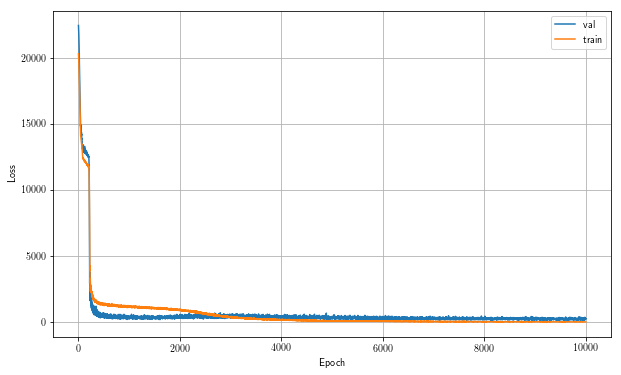

In [70]:
fig = plt.figure(figsize=(10,6))
plt.plot(vloss, label="val")
plt.plot(losses_1, label="train")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
fig.savefig("cnn_loss_unbranch.pdf", bbox_inches="tight")

In [71]:
x = np.zeros((len(list_times_ch_test), 54, 54))
ch = np.zeros((len(list_times_ch_test), 1))
loc = np.zeros((len(list_times_ch_test), 2))

for i in range(len(list_times_ch_test)):
        pointer = list_times_ch_test[i]
        x[i, :, :] = image_data[pointer]
        dim = x.shape[0]
        ch[i, :] = np.array(pointer[1])
        loc[i, :] = np.array(location[pointer])
x = torch.from_numpy(x).float().cuda()
x = x.view(len(list_times_ch_test), -1, 54, 54)
ch = torch.from_numpy(ch).float().cuda()
#---------FORWARD------------#
out = cnn_1.forward(x, dim, ch)
out = torch.tensor(out).float().cuda()
out = (out.data).cpu().numpy()

In [407]:
print(updated_neuron_channels.keys())

dict_keys([46, 41, 12, 49, 27, 43, 45, 28, 52, 53, 22, 21, 10, 34, 5, 35, 11, 50, 48, 47, 54, 18, 38, 9, 32, 13, 42, 1, 40, 31, 37, 29, 2, 39, 55, 24, 17, 0, 6, 8, 26, 7, 23, 36, 14, 3, 51, 25, 30, 15, 19, 33, 44, 20, 16, 4])


In [373]:
list_times_ch_test

[(682714, 35),
 (531099, 72),
 (854216, 46),
 (675443, 71),
 (680729, 13),
 (1148942, 1),
 (283588, 71),
 (793842, 58),
 (1145198, 60),
 (182821, 58),
 (452708, 95),
 (524795, 95),
 (280834, 57),
 (646161, 46),
 (22914, 84),
 (490329, 48),
 (693834, 53),
 (1104631, 60),
 (22469, 7),
 (337614, 7),
 (871876, 41),
 (669113, 26),
 (65210, 68),
 (1088085, 35),
 (632463, 28),
 (795280, 68),
 (168863, 53),
 (240653, 66),
 (788705, 17),
 (715990, 60),
 (162230, 28),
 (1050163, 13),
 (78027, 60),
 (342034, 13),
 (642618, 13),
 (538198, 71),
 (768084, 84),
 (388753, 84),
 (1131733, 58),
 (218029, 57),
 (689931, 17),
 (1013502, 33),
 (568671, 26),
 (622839, 53),
 (371074, 46),
 (655087, 11),
 (63532, 68),
 (453000, 58),
 (732361, 37),
 (525330, 93),
 (1011038, 35),
 (179432, 66),
 (763320, 37),
 (29316, 33),
 (154772, 65),
 (123283, 57),
 (890343, 65),
 (1022439, 84),
 (724458, 26),
 (620218, 96),
 (1121343, 66),
 (1032488, 60),
 (205103, 35),
 (926089, 7),
 (854766, 11),
 (838789, 13),
 (1114360

In [73]:
cnn_loc = []
com_loc = []
true_loc = []

# Use 12, 27, 43, 28, 53

for i, val in enumerate(updated_neuron_channels[13]):
    for j, index in enumerate(list_times_ch_test):
        if val == index:
            com_loc.append(location[val])
            cnn_loc.append(out[j])
            true_loc.append(new_location[val])
cnn_loc = np.array(cnn_loc)
com_loc = np.array(com_loc)
true_loc = np.array(true_loc)
#print(cnn_loc)
#print(com_loc)
print("True Location: ", true_loc[0, :])

print("CNN: ", np.median(cnn_loc, axis=0), np.var(cnn_loc, axis=0))
print("COM: ", np.median(com_loc, axis=0), np.var(com_loc, axis=0))

KeyError: 13

In [74]:
fig = plt.figure(figsize=(10,8))
plt.scatter(cnn_loc[:, 0], cnn_loc[:, 1], c = 'r', label='CNN estimate')
plt.scatter(com_loc[:, 0], com_loc[:, 1], c = 'b', label='COM estimate')
plt.scatter(true_loc[:, 0], true_loc[:, 1], c = 'g', label='True Location')
plt.xlabel(u'X-coordinates (${\mu}m$)', fontsize=14)
plt.ylabel(u'Y-coordinates (${\mu}m$)', fontsize=14)
plt.legend()
plt.grid()

TypeError: list indices must be integers or slices, not tuple

<Figure size 720x576 with 0 Axes>

In [512]:
fig.savefig("neuron_loc_8.png", bbox_inches='tight')

In [287]:
print(neuron_channels.keys())

dict_keys([46, 41, 12, 49, 27, 43, 45, 28, 52, 53, 22, 21, 10, 34, 5, 35, 11, 50, 48, 47, 54, 18, 38, 9, 32, 13, 42, 1, 40, 31, 37, 29, 2, 39, 55, 24, 17, 0, 6, 8, 26, 7, 23, 36, 14, 3, 51, 25, 30, 15, 19, 33, 44, 20, 16, 4])


In [2]:
# Filter only relevant frames
from collections import Counter

updated_neuron_channels = {}
for i in neuron_channels.keys():
    updated_neuron_channels[i] = []
    elec_list = np.array(neuron_channels[i])[:, 1]
    occ = Counter(elec_list)
    final_elec_list = []
    for d in occ.keys():
        if occ[d] > 80:
            final_elec_list.append(d)
    for j in final_elec_list:
        for k in neuron_channels[i]:
            if k[1] == j:
                updated_neuron_channels[i].append(k)

NameError: name 'neuron_channels' is not defined

In [323]:
list_loc_ch = []
for i in updated_neuron_channels.values():
    list_loc_ch = list_loc_ch + i
print(len(list_loc_ch))

8977


In [346]:
new_list_times_ch

[(10030, 48),
 (10110, 65),
 (10226, 68),
 (10309, 17),
 (10366, 72),
 (10411, 95),
 (10412, 75),
 (10425, 60),
 (10435, 13),
 (10511, 58),
 (10588, 7),
 (10671, 98),
 (10708, 46),
 (10753, 93),
 (10903, 37),
 (10930, 39),
 (10967, 58),
 (11041, 26),
 (11144, 60),
 (11269, 95),
 (11272, 84),
 (11301, 74),
 (11336, 28),
 (11418, 48),
 (11422, 57),
 (11677, 93),
 (11693, 46),
 (11769, 26),
 (11784, 58),
 (11883, 58),
 (11977, 60),
 (12112, 7),
 (12118, 35),
 (12301, 39),
 (12362, 33),
 (12371, 58),
 (12398, 98),
 (12437, 26),
 (12447, 84),
 (12618, 71),
 (12651, 17),
 (12734, 93),
 (12812, 60),
 (12828, 48),
 (12839, 95),
 (12931, 33),
 (13041, 35),
 (13111, 68),
 (13126, 53),
 (13155, 26),
 (13224, 98),
 (13422, 13),
 (13431, 7),
 (13469, 84),
 (13511, 75),
 (13520, 33),
 (13556, 60),
 (13638, 95),
 (13765, 72),
 (13940, 98),
 (13987, 93),
 (14233, 57),
 (14314, 75),
 (14353, 60),
 (14356, 58),
 (14395, 26),
 (14468, 84),
 (14596, 95),
 (14608, 7),
 (14636, 13),
 (14669, 68),
 (14826, 1

In [395]:
len(list_loc_ch)

8977

In [448]:
torch.save(cnn_1, 'models/cnn_models/loc_cnn_unbranched.pt') #Saving the autoencoder model

In [ ]:
torch.save(cnn_2, 'models/cnn_models/loc_cnn_branched.pt') #Saving the autoencoder model

In [511]:
for i in updated_neuron_channels.keys():
    if len(updated_neuron_channels[i]) > 0:
        print(i, len(updated_neuron_channels[i]))

46 775
41 631
12 543
49 398
27 497
43 576
28 276
53 406
22 306
21 213
10 507
34 529
11 307
48 311
47 179
18 338
38 277
32 207
13 436
42 434
40 302
37 280
8 128
15 121


In [516]:
def find_distance(val, true, cnn, com):
    mse_cnn = ((true[0] - cnn[0])**2 + (true[1] - cnn[1])**2)**0.5
    mse_com = ((true[0] - com[0])**2 + (true[1] - com[1])**2)**0.5
    print (val, mse_cnn, mse_com)

In [517]:
find_distance(28, [2.06295723, 159.07988044], [1.9581857, 157.33357], [11.2, 155.303])
find_distance(53, [29.19640478, 304.72127251], [28.455631, 304.98807], [30.6885, 287.489])
find_distance(43, [71.21975778, 227.26135914], [70.82858, 227.3075], [62.8995, 226.5885])
find_distance(27, [78.06279008, 142.09807089], [77.36751, 141.10225], [63.723, 143.626])
find_distance(12, [6.20463663, 66.89060094], [5.665558, 66.26047], [12.2245, 65.285])
find_distance(8, [-14.63904256, 29.02344793], [-14.920106, 29.798603], [8.82, 21.95])

28 1.749450549844591 9.886879003955897
53 0.7873542365452694 17.296750099497004
43 0.3938896222639826 8.347420496652358
27 1.2145260946579997 14.420962065814187
12 0.829259169902849 6.230305720588409
8 0.8245374702530742 24.502251803667203


In [29]:
for looper in [8]:
    cnn_loc = []
    com_loc = []
    true_loc = []

    # Use 12, 27, 43, 28, 53

    for i, val in enumerate(updated_neuron_channels[looper]):
        for j, index in enumerate(list_times_ch_test):
            if val == index:
                com_loc.append(location[val])
                cnn_loc.append(out[j])
                true_loc.append(new_location[val])
    cnn_loc = np.array(cnn_loc)
    com_loc = np.array(com_loc)
    true_loc = np.array(true_loc)
    #print(cnn_loc)
    #print(com_loc)
    
    #print("True Location: ", true_loc[0, :])
    #print("CNN: ", np.median(cnn_loc, axis=0), np.var(cnn_loc, axis=0))
    #print("COM: ", np.median(com_loc, axis=0), np.var(com_loc, axis=0))

    fig = plt.figure(figsize=(10,8))
    #plt.scatter(cnn_loc[:, 0], cnn_loc[:, 1], c = 'r', s=35, label='CNN estimates')
    #plt.scatter(com_loc[:, 0], com_loc[:, 1], c = 'b', s=35, label='COM estimates')
    plt.scatter(true_loc[:, 0], true_loc[:, 1], c = 'g', s=35, label='True Location')
    plt.scatter(np.median(cnn_loc, axis=0)[0], np.median(cnn_loc, axis=0)[1], facecolors='white', edgecolors=(0.8, 0, 0.2), s=60, marker="D", label='CNN est. median (Soma)')
    plt.scatter(np.median(com_loc, axis=0)[0], np.median(com_loc, axis=0)[1], facecolors='white', edgecolors=(0.3, 0.1, 0.6), s=60, marker="D", label='CoM est. median (AIS)')
    plt.plot(np.median(cnn_loc, axis=0), np.median(com_loc, axis=0), linewidth=1.8)
    plt.xlabel(u'X-coordinates (${\mu}m$)', fontsize=14)
    plt.ylabel(u'Y-coordinates (${\mu}m$)', fontsize=14)
    plt.legend()
    plt.grid()

    #fig.savefig("neuron_loc_"+str(looper)+".png", bbox_inches='tight')

KeyError: 8